built on:
  - numpy 1.26.4
  - matplotlib 3.10.3
  - astropy 6.1.7


In [8]:
"""
Import basic libraries and define useful constants
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import ascii
from astropy.table import Table, Column
from astropy.io import fits

from matplotlib.patches import Rectangle

import emcee
import corner
import os
from IPython.display import display, Math
from scipy import special as sp

clight=299792.4688      # km/s
hplanck=6.626069529e-27 # erg s
kboltz=1.380650337e-16  # erg/K
erg2eV=1.602176634e-12  # erg/eV
mass_proton=1.6726e-24  # g
lgZsun=8.69
Lsun=3.839e33  # erg/s
Msun=1.989e33  # erg/s


In [9]:
"""
A set of useful functions to setup plotting parameters,
convert quantities, define extinction laws, and estimates
of metallicities
"""

def nicePlot():
    # Set some matplotlib parameters to have nice looking plots (by Ema Farina)

    print("nicePlot: Setting rcParams")
    plt.rcParams["xtick.top"] = True
    plt.rcParams["ytick.right"] = True
    plt.rcParams["xtick.minor.visible"] = True
    plt.rcParams["ytick.minor.visible"] = True
    plt.rcParams["ytick.direction"] = 'in'
    plt.rcParams["xtick.direction"] = 'in'
    plt.rcParams["xtick.major.size"] = 6
    plt.rcParams["ytick.major.size"] = 6
    plt.rcParams["xtick.minor.size"] = 3
    plt.rcParams["ytick.minor.size"] = 3
    plt.rcParams["xtick.labelsize"] = 16
    plt.rcParams["ytick.labelsize"] = 16
    plt.rcParams["xtick.major.width"] = 1
    plt.rcParams["ytick.major.width"] = 1
    plt.rcParams["xtick.minor.width"] = 1
    plt.rcParams["ytick.minor.width"] = 1
    plt.rcParams["axes.linewidth"] = 2
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams["lines.linewidth"] = 3
    plt.rcParams["lines.markeredgewidth"] = 3
    plt.rcParams["patch.linewidth"] = 5
    plt.rcParams["hatch.linewidth"] = 5
    plt.rcParams["font.size"] = 16
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.handletextpad"] = 1

    
def en2wave(en):
    # convert a photon's energy (in eV) in its wavelength in Ang
    # input: energy in eV
    
    ien=np.ones_like(en)
    near_zero = np.isclose(en, 0)
    ien[near_zero] = np.inf
    ien[~near_zero] = 1. / en[~near_zero]
    
    wave=clight*ien*hplanck*1.e9/erg2eV*10000. # return wavelength in Ang
    return wave 


def wave2en(wave):
    # convert a photon's wavelength in Ang into its energy in eV
    # input: wavelength in Ang
    en=clight/wave*hplanck*1.e9/erg2eV*10000.   # return energy in eV
    return en 


def extinction_law(wave,Ebv):
    # This function computes the extinction law adopting the Calzetti+00 law
    # which is measured at 1200 < lambda/[Ang] < 22000 and extrapolated eslewhere
    # wave is the input rest-frame wavelength in micron

    R_V=4.05 # (+/- 0.80)

    klambda1=2.659*(-2.156+1.5090/wave-0.198/np.power(wave,2)+0.011/np.power(wave,3))+R_V
    klambda2=2.659*(-1.857+1.040/wave)+R_V

    klambda=np.where((wave<0.6300),klambda1,klambda2)

    Alambda=klambda*Ebv

    ext=np.power(10.,(-0.4*Alambda))
    
    return ext


def extinction_law_WD(wave,NH):
    # This function computes the extinction law by interpolating the values 
    # from the Weingartner & Draine (2001) model, case A, R_V=4.0, as reported here:
    # https://www.astro.princeton.edu/~draine/dust/dust.html
    # wave is the input rest-frame wavelength in micron, NH the hydrogen column density
    
    ext_tab=ascii.read("draine_extinction.dat", header_start=64, data_start=67, format='fixed_width')
    ext_tab.reverse()
    wave_all=ext_tab['lambda']
    CextH_all=ext_tab['C_ext/H']
    tau_all=CextH_all*NH
    tau=np.interp(wave,wave_all,tau_all)    
    ext=np.exp(-tau)
    
    return ext


def nicholls(Z):
    # abundances set following Nicholls et al. 2017, MNRAS, 466, 4403:
    lgOH=np.log10(Z)+lgZsun-12.
    lgNO=np.log10(np.power(10.,-1.732)+np.power(10.,lgOH+2.19))
    lgCO=np.log10(np.power(10.,-0.8)+np.power(10.,lgOH+2.72))
    lgNH=lgOH+lgNO
    lgCH=lgOH+lgCO
    lgHeH=-1.0783+np.log10(1.+0.17031*Z)

    return lgOH,lgNH,lgCH,lgHeH


def charlot_longhetti(o3hb,o2hb,n2hb,s2hb):
    # metallicity estimate based on nebular line ratios, from Charlot & Longetti's paper
    lgOH=np.log10(5.09)-4.+0.17*(o2hb-o3hb-np.log10(1.5))+1.17*(n2hb-s2hb-np.log10(0.85))-lgZsun+12.
    return lgOH



In [10]:
"""
Setup the level populations based on orbital structure, quantum numbers, oscillator strengths, etc
"""

def para2ortho(Tkin):
    # compute fraction of para-H2 as a function of Tkin
    # based on McIntosh 2015, IOP Conf. Ser.: Mater. Sci. Eng. 101 012079
    _T=np.array([20.,30.,40.,50.,60.,70.,78.,80.,90.,100.,120.,150.,200.,250.,300.])
    _parafrac=np.array([99.821,97.021,88.727,77.054,65.569,55.991,50.028,48.537,42.882,38.620,32.959,28.603,25.974,25.264,25.072])

    parafrac=np.interp(Tkin,_T,_parafrac,left=100.,right=25.)
    parafrac=parafrac/100.
    
    return parafrac


"""
The following functions set up matrixes with the 5-level atom/ion models.
Input parameters are the physical parameters of the collision partners:
    - n_coll: volume density of collision partners, in [cm-3]
    - Tkin: kinetic temperature of the collision partners, in [K]
    - n_gamma: photon occupation fraction [to be tested!]
    - fracCe: fraction of electrons vs H as collision partners
    - fracC2: fraction of H2 vs H as collision partners
    
It returns the set of linear equations combining the rates of each level, XX_mat;
the frequencies of the transitions, XX_nu;
the Einstein coefficient of each transition, XX_A;
the critical densities of each level, XX_ncrit
"""

# 5 electrons

def init_C2(n_coll,Tkin,n_gamma, fracCe, fracC2):
    C2_J=np.array([0.5, 1.5, 0.5, 1.5, 2.5]) 
    C2_L=np.array([1, 1, 1, 1, 1]) # total angular momentum
    C2_S=np.array([0.5, 0.5, 1.5, 1.5, 1.5]) # total spin
    C2_omega=2*C2_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    C2_om_u=np.array([C2_omega[1],
             C2_omega[2],
             C2_omega[3],
             C2_omega[4],
             C2_omega[2],
             C2_omega[3],
             C2_omega[4],
             C2_omega[3],
             C2_omega[4],
             C2_omega[4]])
    C2_om_l=np.array([C2_omega[0],
             C2_omega[0],
             C2_omega[0],
             C2_omega[0],
             C2_omega[1],
             C2_omega[1],
             C2_omega[1],
             C2_omega[2],
             C2_omega[2],
             C2_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    C2_A=np.array([2.3e-6, 73., 1.6, 1.e9, 76., 11., 53., 1.e-16, 1.e-16, 1.e-16])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    C2_YpsCe=np.array([(1.55+1.25*(Tkin/1.e4))/(1.+0.35*(Tkin/1.e4)**1.25),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
    # H atoms
    C2_YpsC1=np.array([7.58e-10*(Tkin/1.e2)**(0.128+0.009*np.log(Tkin/1.e2)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
    # H2 molecules
    C2_YpsC2_para=np.array([4.25e-10*(Tkin/1.e2)**(0.124-0.018*np.log(Tkin/1.e2)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
    C2_YpsC2_ortho=np.array([5.14e-10*(Tkin/1.e2)**(0.095+0.023*np.log(Tkin/1.e2)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
    
    
    # Transition wavelength [um]:
    C2_lmb=np.array([157.6,
            0.23254,
            0.23242,
            0.23227,
            0.23288,
            0.23276,
            0.23261,
            454.54,
            196.08,
            344.83])

    # Transition frequencies [Hz]:
    C2_nu=clight*1.e9/C2_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    
    C2_q=8.629e-6/np.sqrt(Tkin)/C2_om_u*fracCe*C2_YpsCe+(1.-fracCe-fracC2)*C2_YpsC1+fracC2*(paraH2frac*C2_YpsC2_para+(1.-paraH2frac)*C2_YpsC2_ortho)
    C2_qin=C2_q*C2_om_u/C2_om_l*np.exp(-hplanck*C2_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    C2_Rup=n_coll*C2_q+(1.+n_gamma)*C2_A
    C2_Rdown=C2_om_u/C2_om_l*(n_coll*C2_q*np.exp(-hplanck*C2_nu/kboltz/Tkin)+n_gamma*C2_A)

    # Fill in the matrix
    C2_a00=-(C2_Rdown[0]+C2_Rdown[1]+C2_Rdown[2]+C2_Rdown[3])
    C2_a01=C2_Rup[0]
    C2_a02=C2_Rup[1]
    C2_a03=C2_Rup[2]
    C2_a04=C2_Rup[3]
       
    C2_a10=C2_Rdown[0]
    C2_a11=-(C2_Rup[0]+C2_Rdown[4]+C2_Rdown[5]+C2_Rdown[6])
    C2_a12=C2_Rup[4]
    C2_a13=C2_Rup[5]
    C2_a14=C2_Rup[6]
       
    C2_a20=C2_Rdown[1]
    C2_a21=C2_Rdown[4]
    C2_a22=-(C2_Rup[1]+C2_Rup[4]+C2_Rdown[7]+C2_Rdown[8])
    C2_a23=C2_Rup[7]
    C2_a24=C2_Rup[8]
       
    C2_a30=C2_Rdown[2]
    C2_a31=C2_Rdown[5]
    C2_a32=C2_Rdown[7]
    C2_a33=-(C2_Rup[2]+C2_Rup[5]+C2_Rup[7]+C2_Rdown[9])
    C2_a34=C2_Rup[9]
       
    C2_a40=C2_Rdown[3]
    C2_a41=C2_Rdown[6]
    C2_a42=C2_Rdown[8]
    C2_a43=C2_Rdown[9]
    C2_a44=-(C2_Rup[3]+C2_Rup[6]+C2_Rup[8]+C2_Rup[9])

      
    C2_mat=np.array([[C2_a00,C2_a01,C2_a02,C2_a03,C2_a04],
                     [C2_a10,C2_a11,C2_a12,C2_a13,C2_a14],
                     [C2_a20,C2_a21,C2_a22,C2_a23,C2_a24],
                     [C2_a30,C2_a31,C2_a32,C2_a33,C2_a34],
                     [C2_a40,C2_a41,C2_a42,C2_a43,C2_a44]])

    C2_ncrit=np.zeros(4)
    C2_ncrit[0]=(1.+n_gamma)*C2_A[0]/(C2_q[0]+C2_qin[4]+C2_qin[5]+C2_qin[6])
    C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
    C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9]) 
    C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])

    return C2_mat, C2_nu, C2_A, C2_ncrit


def init_N3(n_coll,Tkin,n_gamma):
    N3_J=np.array([0.5, 1.5, 0.5, 1.5, 2.5]) 
    N3_L=np.array([1, 1, 1, 1, 1]) # total angular momentum
    N3_S=np.array([0.5, 0.5, 1.5, 1.5, 1.5]) # total spin
    N3_omega=2*N3_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    N3_om_u=np.array([N3_omega[1],
             N3_omega[2],
             N3_omega[3],
             N3_omega[4],
             N3_omega[2],
             N3_omega[3],
             N3_omega[4],
             N3_omega[3],
             N3_omega[4],
             N3_omega[4]])
    N3_om_l=np.array([N3_omega[0],
             N3_omega[0],
             N3_omega[0],
             N3_omega[0],
             N3_omega[1],
             N3_omega[1],
             N3_omega[1],
             N3_omega[2],
             N3_omega[2],
             N3_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    N3_A=np.array([4.7e-5, 420., 120., 1.e9, 4.5, 70., 320., 1.e-16, 1.e-16, 1.e-16])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    N3_YpsCe=np.array([1.21*(Tkin/1.e4)**(0.151+0.056*np.log(Tkin/1.e4)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
   
    # Transition wavelength [um]:
    N3_lmb=np.array([57.343,
            0.17486,
            0.17468,
            0.17443,
            0.17540,
            0.17522,
            0.17497,
            166.66,
            70.922,
            123.457])

    # Transition frequencies [Hz]:
    N3_nu=clight*1.e9/N3_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    N3_q=8.629e-6/np.sqrt(Tkin)/N3_om_u*N3_YpsCe
    N3_qin=N3_q*N3_om_u/N3_om_l*np.exp(-hplanck*N3_nu/kboltz/Tkin) # low --> up
   
    # Energy level population/depopulation rates
    N3_Rup=n_coll*N3_q+(1.+n_gamma)*N3_A
    N3_Rdown=N3_om_u/N3_om_l*(n_coll*N3_q*np.exp(-hplanck*N3_nu/kboltz/Tkin)+n_gamma*N3_A)

    # Fill in the matrix
    N3_a00=-(N3_Rdown[0]+N3_Rdown[1]+N3_Rdown[2]+N3_Rdown[3])
    N3_a01=N3_Rup[0]
    N3_a02=N3_Rup[1]
    N3_a03=N3_Rup[2]
    N3_a04=N3_Rup[3]
       
    N3_a10=N3_Rdown[0]
    N3_a11=-(N3_Rup[0]+N3_Rdown[4]+N3_Rdown[5]+N3_Rdown[6])
    N3_a12=N3_Rup[4]
    N3_a13=N3_Rup[5]
    N3_a14=N3_Rup[6]
       
    N3_a20=N3_Rdown[1]
    N3_a21=N3_Rdown[4]
    N3_a22=-(N3_Rup[1]+N3_Rup[4]+N3_Rdown[7]+N3_Rdown[8])
    N3_a23=N3_Rup[7]
    N3_a24=N3_Rup[8]
       
    N3_a30=N3_Rdown[2]
    N3_a31=N3_Rdown[5]
    N3_a32=N3_Rdown[7]
    N3_a33=-(N3_Rup[2]+N3_Rup[5]+N3_Rup[7]+N3_Rdown[9])
    N3_a34=N3_Rup[9]
       
    N3_a40=N3_Rdown[3]
    N3_a41=N3_Rdown[6]
    N3_a42=N3_Rdown[8]
    N3_a43=N3_Rdown[9]
    N3_a44=-(N3_Rup[3]+N3_Rup[6]+N3_Rup[8]+N3_Rup[9])

      
    N3_mat=np.array([[N3_a00,N3_a01,N3_a02,N3_a03,N3_a04],
                [N3_a10,N3_a11,N3_a12,N3_a13,N3_a14],
                [N3_a20,N3_a21,N3_a22,N3_a23,N3_a24],
                [N3_a30,N3_a31,N3_a32,N3_a33,N3_a34],
                [N3_a40,N3_a41,N3_a42,N3_a43,N3_a44]])

    N3_ncrit=np.zeros(4)
    N3_ncrit[0]=(1.+n_gamma)*N3_A[0]/(N3_q[0]+N3_qin[4]+N3_qin[5]+N3_qin[6])
    N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
    N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[5]+(1.+n_gamma)*N3_A[7])/(N3_q[2]+N3_q[5]+N3_q[7]+N3_qin[9]) 
    N3_ncrit[3]=((1.+n_gamma)*N3_A[3]+(1.+n_gamma)*N3_A[6]+(1.+n_gamma)*N3_A[8]+(1.+n_gamma)*N3_A[9])/(N3_q[3]+N3_q[6]+N3_q[8]+N3_q[9])

    return N3_mat, N3_nu, N3_A, N3_ncrit


def init_O4(n_coll,Tkin,n_gamma):
    O4_J=np.array([0.5, 1.5, 0.5, 1.5, 2.5]) 
    O4_L=np.array([1, 1, 1, 1, 1]) # total angular momentum
    O4_S=np.array([0.5, 0.5, 1.5, 1.5, 1.5]) # total spin
    O4_omega=2*O4_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    O4_om_u=np.array([O4_omega[1],
             O4_omega[2],
             O4_omega[3],
             O4_omega[4],
             O4_omega[2],
             O4_omega[3],
             O4_omega[4],
             O4_omega[3],
             O4_omega[4],
             O4_omega[4]])
    O4_om_l=np.array([O4_omega[0],
             O4_omega[0],
             O4_omega[0],
             O4_omega[0],
             O4_omega[1],
             O4_omega[1],
             O4_omega[1],
             O4_omega[2],
             O4_omega[2],
             O4_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    O4_A=np.array([5.2e-4, 1700., 48., 1.e-16, 1800., 310., 1300., 1.e-16, 1.e-16, 1.e-16])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    O4_YpsCe=np.array([2.144*(Tkin/1.e4)**(0.164-0.068*np.log(Tkin/1.e4)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
    
    
    # Transition wavelength [um]:
    O4_lmb=np.array([25.91,
            0.13998,
            0.13972,
            0.13936,
            0.14074,
            0.14048,
            0.14012,
            76.923,
            31.646,
            53.763])

    # Transition frequencies [Hz]:
    O4_nu=clight*1.e9/O4_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    O4_q=8.629e-6/np.sqrt(Tkin)/O4_om_u*O4_YpsCe
    O4_qin=O4_q*O4_om_u/O4_om_l*np.exp(-hplanck*O4_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    O4_Rup=n_coll*O4_q+(1.+n_gamma)*O4_A
    O4_Rdown=O4_om_u/O4_om_l*(n_coll*O4_q*np.exp(-hplanck*O4_nu/kboltz/Tkin)+n_gamma*O4_A)

    # Fill in the matrix
    O4_a00=-(O4_Rdown[0]+O4_Rdown[1]+O4_Rdown[2]+O4_Rdown[3])
    O4_a01=O4_Rup[0]
    O4_a02=O4_Rup[1]
    O4_a03=O4_Rup[2]
    O4_a04=O4_Rup[3]
       
    O4_a10=O4_Rdown[0]
    O4_a11=-(O4_Rup[0]+O4_Rdown[4]+O4_Rdown[5]+O4_Rdown[6])
    O4_a12=O4_Rup[4]
    O4_a13=O4_Rup[5]
    O4_a14=O4_Rup[6]
       
    O4_a20=O4_Rdown[1]
    O4_a21=O4_Rdown[4]
    O4_a22=-(O4_Rup[1]+O4_Rup[4]+O4_Rdown[7]+O4_Rdown[8])
    O4_a23=O4_Rup[7]
    O4_a24=O4_Rup[8]
       
    O4_a30=O4_Rdown[2]
    O4_a31=O4_Rdown[5]
    O4_a32=O4_Rdown[7]
    O4_a33=-(O4_Rup[2]+O4_Rup[5]+O4_Rup[7]+O4_Rdown[9])
    O4_a34=O4_Rup[9]
       
    O4_a40=O4_Rdown[3]
    O4_a41=O4_Rdown[6]
    O4_a42=O4_Rdown[8]
    O4_a43=O4_Rdown[9]
    O4_a44=-(O4_Rup[3]+O4_Rup[6]+O4_Rup[8]+O4_Rup[9])

      
    O4_mat=np.array([[O4_a00,O4_a01,O4_a02,O4_a03,O4_a04],
                [O4_a10,O4_a11,O4_a12,O4_a13,O4_a14],
                [O4_a20,O4_a21,O4_a22,O4_a23,O4_a24],
                [O4_a30,O4_a31,O4_a32,O4_a33,O4_a34],
                [O4_a40,O4_a41,O4_a42,O4_a43,O4_a44]])

    O4_ncrit=np.zeros(4)
    O4_ncrit[0]=(1.+n_gamma)*O4_A[0]/(O4_q[0]+O4_qin[4]+O4_qin[5]+O4_qin[6])
    O4_ncrit[1]=((1.+n_gamma)*O4_A[1]+(1.+n_gamma)*O4_A[4])/(O4_q[1]+O4_q[4]+O4_qin[7]+O4_qin[8])
    O4_ncrit[2]=((1.+n_gamma)*O4_A[2]+(1.+n_gamma)*O4_A[5]+(1.+n_gamma)*O4_A[7])/(O4_q[2]+O4_q[5]+O4_q[7]+O4_qin[9]) 
    O4_ncrit[3]=((1.+n_gamma)*O4_A[3]+(1.+n_gamma)*O4_A[6]+(1.+n_gamma)*O4_A[8]+(1.+n_gamma)*O4_A[9])/(O4_q[3]+O4_q[6]+O4_q[8]+O4_q[9])

    return O4_mat, O4_nu, O4_A, O4_ncrit



# 6 electrons

def init_C1(n_coll,Tkin,n_gamma, fracCe, fracC2):
    C1_J=np.array([0, 1, 2, 2, 0]) 
    C1_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    C1_S=np.array([1, 1, 1, 0, 0]) # total spin
    C1_omega=2*C1_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    C1_om_u=np.array([C1_omega[1],
             C1_omega[2],
             C1_omega[3],
             C1_omega[4],
             C1_omega[2],
             C1_omega[3],
             C1_omega[4],
             C1_omega[3],
             C1_omega[4],
             C1_omega[4]])
    C1_om_l=np.array([C1_omega[0],
             C1_omega[0],
             C1_omega[0],
             C1_omega[0],
             C1_omega[1],
             C1_omega[1],
             C1_omega[1],
             C1_omega[2],
             C1_omega[2],
             C1_omega[3]])


    # Einstein coefficients from LAMDA database, in s-1
    C1_A=np.array([7.880e-08, 1.810e-14, 1.e-16, 1.e-16, 2.650e-07, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16])
    #C1_A=np.array([7.880e-08, 1.810e-14, 0., 0., 2.650e-07, 0., 0., 0., 0., 0.])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    # formulae from Johnson, Burke, Kingston 1987
    _a0_10=np.where((Tkin<1000.),-9.25141,444.600)
    _a1_10=np.where((Tkin<1000.),-0.773782,-227.913)
    _a2_10=np.where((Tkin<1000.), 0.361184,42.5952)
    _a3_10=np.where((Tkin<1000.),-0.0150892,-3.47620)
    _a4_10=np.where((Tkin<1000.),-0.000656325,0.105085)

    _a0_20=np.where((Tkin<1000.),-7.69735,350.609)
    _a1_20=np.where((Tkin<1000.),-1.30743,-187.474)
    _a2_20=np.where((Tkin<1000.),0.697638,36.1803)
    _a3_20=np.where((Tkin<1000.),-0.111338,-3.03283)
    _a4_20=np.where((Tkin<1000.),0.00705277,0.0938138)

    _a0_21=np.where((Tkin<1000.),-7.43870,386.186)
    _a1_21=np.where((Tkin<1000.),-0.574430,-202.192)
    _a2_21=np.where((Tkin<1000.),0.358264,38.5049)
    _a3_21=np.where((Tkin<1000.),-0.0418166,-3.19268)
    _a4_21=np.where((Tkin<1000.),0.00235272,0.0978573)

    _yy_10=np.exp(_a0_10+_a1_10*np.log(Tkin)+_a2_10*(np.log(Tkin))**2+_a3_10*(np.log(Tkin))**3+_a4_10*(np.log(Tkin))**4)
    _yy_20=np.exp(_a0_20+_a1_20*np.log(Tkin)+_a2_20*(np.log(Tkin))**2+_a3_20*(np.log(Tkin))**3+_a4_20*(np.log(Tkin))**4)
    _yy_21=np.exp(_a0_21+_a1_21*np.log(Tkin)+_a2_21*(np.log(Tkin))**2+_a3_21*(np.log(Tkin))**3+_a4_21*(np.log(Tkin))**4)
    
    
    C1_YpsCe=np.array([_yy_10,
            _yy_20,
            0.,
            0.,
            _yy_21,
            0.,
            0.,
            0.,
            0.,
            0.])
    # H atoms
    C1_YpsC1=np.array([1.26e-10*np.power((Tkin/1.e2),(0.115+0.057*np.log(Tkin/1.e2))),
            2.64e-10*np.power((Tkin/1.e2),(0.231+0.046*np.log(Tkin/1.e2))),
            0.,
            0.,
            8.90e-11*np.power((Tkin/1.e2),(0.228+0.046*np.log(Tkin/1.e2))),
            0.,
            0.,
            0.,
            0.,
            0.])
    # H2 molecules
    C1_YpsC2_para=np.array([0.67e-10*np.power((Tkin/1.e2),(-0.085+0.102*np.log(Tkin/1.e2))),
            0.86e-10*np.power((Tkin/1.e2),(-0.010+0.048*np.log(Tkin/1.e2))),
            0.,
            0.,
            1.75e-10*np.power((Tkin/1.e2),(0.072+0.064*np.log(Tkin/1.e2))),
            0.,
            0.,
            0.,
            0.,
            0.])
    C1_YpsC2_ortho=np.array([0.71e-10*np.power((Tkin/1.e2),(-0.004+0.049*np.log(Tkin/1.e2))),
            0.69e-10*np.power((Tkin/1.e2),(0.169+0.038*np.log(Tkin/1.e2))),
            0.,
            0.,
            1.48e-10*np.power((Tkin/1.e2),(0.263+0.031*np.log(Tkin/1.e2))),
            0.,
            0.,
            0.,
            0.,
            0.])
    
    

# Transition wavelength [um]:
    C1_lmb=np.array([609.7,
            230.415,
            0.98107,
            0.46194,
            370.4,
            0.98268,
            0.46229,
            0.98530,
            0.46286,
            0.87295])

    # Transition frequencies [Hz]:
    C1_nu=clight*1.e9/C1_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    
    C1_q=8.629e-6/np.sqrt(Tkin)/C1_om_u*fracCe*C1_YpsCe+(1.-fracCe-fracC2)*C1_YpsC1+fracC2*(paraH2frac*C1_YpsC2_para+(1.-paraH2frac)*C1_YpsC2_ortho)
    C1_qin=C1_q*C1_om_u/C1_om_l*np.exp(-hplanck*C1_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    C1_Rup=n_coll*C1_q+(1.+n_gamma)*C1_A
    C1_Rdown=C1_om_u/C1_om_l*(n_coll*C1_q*np.exp(-hplanck*C1_nu/kboltz/Tkin)+n_gamma*C1_A)
    
    # Fill in the matrix
    C1_a00=-(C1_Rdown[0]+C1_Rdown[1]+C1_Rdown[2]+C1_Rdown[3])
    C1_a01=C1_Rup[0]
    C1_a02=C1_Rup[1]
    C1_a03=C1_Rup[2]
    C1_a04=C1_Rup[3]
       
    C1_a10=C1_Rdown[0]
    C1_a11=-(C1_Rup[0]+C1_Rdown[4]+C1_Rdown[5]+C1_Rdown[6])
    C1_a12=C1_Rup[4]
    C1_a13=C1_Rup[5]
    C1_a14=C1_Rup[6]
       
    C1_a20=C1_Rdown[1]
    C1_a21=C1_Rdown[4]
    C1_a22=-(C1_Rup[1]+C1_Rup[4]+C1_Rdown[7]+C1_Rdown[8])
    C1_a23=C1_Rup[7]
    C1_a24=C1_Rup[8]
       
    C1_a30=C1_Rdown[2]
    C1_a31=C1_Rdown[5]
    C1_a32=C1_Rdown[7]
    C1_a33=-(C1_Rup[2]+C1_Rup[5]+C1_Rup[7]+C1_Rdown[9])
    C1_a34=C1_Rup[9]
       
    C1_a40=C1_Rdown[3]
    C1_a41=C1_Rdown[6]
    C1_a42=C1_Rdown[8]
    C1_a43=C1_Rdown[9]
    C1_a44=-(C1_Rup[3]+C1_Rup[6]+C1_Rup[8]+C1_Rup[9])
      
    C1_mat=np.array([[C1_a00,C1_a01,C1_a02,C1_a03,C1_a04],
                     [C1_a10,C1_a11,C1_a12,C1_a13,C1_a14],
                     [C1_a20,C1_a21,C1_a22,C1_a23,C1_a24],
                     [C1_a30,C1_a31,C1_a32,C1_a33,C1_a34],
                     [C1_a40,C1_a41,C1_a42,C1_a43,C1_a44]])

    C1_ncrit=np.zeros(4)
    C1_ncrit[0]=(1.+n_gamma)*C1_A[0]/(C1_q[0]+C1_qin[4]+C1_qin[5]+C1_qin[6])
    C1_ncrit[1]=((1.+n_gamma)*C1_A[1]+(1.+n_gamma)*C1_A[4])/(C1_q[1]+C1_q[4]+C1_qin[7]+C1_qin[8])
    C1_ncrit[2]=((1.+n_gamma)*C1_A[2]+(1.+n_gamma)*C1_A[5]+(1.+n_gamma)*C1_A[7])/(C1_q[2]+C1_q[5]+C1_q[7]+C1_qin[9]) 
    C1_ncrit[3]=((1.+n_gamma)*C1_A[3]+(1.+n_gamma)*C1_A[6]+(1.+n_gamma)*C1_A[8]+(1.+n_gamma)*C1_A[9])/(C1_q[3]+C1_q[6]+C1_q[8]+C1_q[9])

    return C1_mat, C1_nu, C1_A, C1_ncrit #, C1_q


def init_N2(n_coll,Tkin,n_gamma):
    N2_J=np.array([0, 1, 2, 2, 0]) 
    N2_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    N2_S=np.array([1, 1, 1, 0, 0]) # total spin
    N2_omega=2*N2_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    N2_om_u=np.array([N2_omega[1],
             N2_omega[2],
             N2_omega[3],
             N2_omega[4],
             N2_omega[2],
             N2_omega[3],
             N2_omega[4],
             N2_omega[3],
             N2_omega[4],
             N2_omega[4]])
    N2_om_l=np.array([N2_omega[0],
             N2_omega[0],
             N2_omega[0],
             N2_omega[0],
             N2_omega[1],
             N2_omega[1],
             N2_omega[1],
             N2_omega[2],
             N2_omega[2],
             N2_omega[3]])

    # Einstein coefficients from Tab 3.12 of Osterbrook & Ferland, in s-1
    N2_A=np.array([2.1e-6, 1.1e-12, 3.6e-7, 1.e-16, 7.5e-6, 9.8e-4, 3.3e-2, 3.0e-3, 1.3e-4, 1.0])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    N2_Yps=np.array([0.431*(Tkin/1.e4)**(0.099+0.014*np.log(Tkin/1.e4)),
            0.273*(Tkin/1.e4)**(0.166+0.030*np.log(Tkin/1.e4)),
            0.303*(Tkin/1.e4)**(0.053+0.009*np.log(Tkin/1.e4)),
            0.0352*(Tkin/1.e4)**(0.066+0.018*np.log(Tkin/1.e4)),
            1.15*(Tkin/1.e4)**(0.137+0.024*np.log(Tkin/1.e4)),
            0.909*(Tkin/1.e4)**(0.053+0.010*np.log(Tkin/1.e4)),
            0.105*(Tkin/1.e4)**(0.070+0.021*np.log(Tkin/1.e4)),
            1.51*(Tkin/1.e4)**(0.054+0.011*np.log(Tkin/1.e4)),
            0.176*(Tkin/1.e4)**(0.065+0.017*np.log(Tkin/1.e4)),
            0.806*(Tkin/1.e4)**(-0.175-0.014*np.log(Tkin/1.e4))])
    
    # Transition wavelength [um]:
    N2_lmb=np.array([205.2,
            76.5,
            0.65271,
            0.3059,
            121.89,
            0.65480,
            0.30637,
            0.65834,
            0.30714,
            0.57562])

    # Transition frequencies [Hz]:
    N2_nu=clight*1.e9/N2_lmb

    # Collision rates
    N2_q=8.629e-6/np.sqrt(Tkin)*N2_Yps/N2_om_u                     # up --> low
    N2_qin=N2_q*N2_om_u/N2_om_l*np.exp(-hplanck*N2_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    N2_Rup=n_coll*N2_q+(1.+n_gamma)*N2_A
    N2_Rdown=N2_om_u/N2_om_l*(n_coll*N2_q*np.exp(-hplanck*N2_nu/kboltz/Tkin)+n_gamma*N2_A)
    
    # Fill in the matrix
    N2_a00=-(N2_Rdown[0]+N2_Rdown[1]+N2_Rdown[2]+N2_Rdown[3])
    N2_a01=N2_Rup[0]
    N2_a02=N2_Rup[1]
    N2_a03=N2_Rup[2]
    N2_a04=N2_Rup[3]
       
    N2_a10=N2_Rdown[0]
    N2_a11=-(N2_Rup[0]+N2_Rdown[4]+N2_Rdown[5]+N2_Rdown[6])
    N2_a12=N2_Rup[4]
    N2_a13=N2_Rup[5]
    N2_a14=N2_Rup[6]
       
    N2_a20=N2_Rdown[1]
    N2_a21=N2_Rdown[4]
    N2_a22=-(N2_Rup[1]+N2_Rup[4]+N2_Rdown[7]+N2_Rdown[8])
    N2_a23=N2_Rup[7]
    N2_a24=N2_Rup[8]
       
    N2_a30=N2_Rdown[2]
    N2_a31=N2_Rdown[5]
    N2_a32=N2_Rdown[7]
    N2_a33=-(N2_Rup[2]+N2_Rup[5]+N2_Rup[7]+N2_Rdown[9])
    N2_a34=N2_Rup[9]
       
    N2_a40=N2_Rdown[3]
    N2_a41=N2_Rdown[6]
    N2_a42=N2_Rdown[8]
    N2_a43=N2_Rdown[9]
    N2_a44=-(N2_Rup[3]+N2_Rup[6]+N2_Rup[8]+N2_Rup[9])
      
    N2_mat=np.array([[N2_a00,N2_a01,N2_a02,N2_a03,N2_a04],
                     [N2_a10,N2_a11,N2_a12,N2_a13,N2_a14],
                     [N2_a20,N2_a21,N2_a22,N2_a23,N2_a24],
                     [N2_a30,N2_a31,N2_a32,N2_a33,N2_a34],
                     [N2_a40,N2_a41,N2_a42,N2_a43,N2_a44]])

    N2_ncrit=np.zeros(4)
    N2_ncrit[0]=(1.+n_gamma)*N2_A[0]/(N2_q[0]+N2_qin[4]+N2_qin[5]+N2_qin[6])
    N2_ncrit[1]=((1.+n_gamma)*N2_A[1]+(1.+n_gamma)*N2_A[4])/(N2_q[1]+N2_q[4]+N2_qin[7]+N2_qin[8]) 
    N2_ncrit[2]=((1.+n_gamma)*N2_A[2]+(1.+n_gamma)*N2_A[5]+(1.+n_gamma)*N2_A[7])/(N2_q[2]+N2_q[5]+N2_q[7]+N2_qin[9]) 
    N2_ncrit[3]=((1.+n_gamma)*N2_A[3]+(1.+n_gamma)*N2_A[6]+(1.+n_gamma)*N2_A[8]+(1.+n_gamma)*N2_A[9])/(N2_q[3]+N2_q[6]+N2_q[8]+N2_q[9])

    return N2_mat, N2_nu, N2_A, N2_ncrit


def init_O3(n_coll,Tkin,n_gamma):
    O3_J=np.array([0, 1, 2, 2, 0]) 
    O3_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    O3_S=np.array([1, 1, 1, 0, 0]) # total spin
    O3_omega=2*O3_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    O3_om_u=np.array([O3_omega[1],
             O3_omega[2],
             O3_omega[3],
             O3_omega[4],
             O3_omega[2],
             O3_omega[3],
             O3_omega[4],
             O3_omega[3],
             O3_omega[4],
             O3_omega[4]])
    O3_om_l=np.array([O3_omega[0],
             O3_omega[0],
             O3_omega[0],
             O3_omega[0],
             O3_omega[1],
             O3_omega[1],
             O3_omega[1],
             O3_omega[2],
             O3_omega[2],
             O3_omega[3]])

    # Einstein coefficients from Tab 3.12 of Osterbrook & Ferland, in s-1
    O3_A=np.array([2.7e-5, 3.1e-11, 1.7e-6, 1.e-16, 9.7e-5, 6.8e-3, 2.3e-1, 2.0e-2, 6.1e-4, 1.6])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    O3_Yps=np.array([0.522*(Tkin/1.e4)**(0.033-0.009*np.log(Tkin/1.e4)),
            0.257*(Tkin/1.e4)**(0.081+0.017*np.log(Tkin/1.e4)),
            0.243*(2*O3_J[0]+1)*(Tkin/1.e4)**(0.120+0.031*np.log(Tkin/1.e4)),
            0.0321*(2*O3_J[0]+1)*(Tkin/1.e4)**(0.118+0.057*np.log(Tkin/1.e4)),
            1.23*(Tkin/1.e4)**(0.053+0.007*np.log(Tkin/1.e4)),
            0.243*(2*O3_J[1]+1)*(Tkin/1.e4)**(0.120+0.031*np.log(Tkin/1.e4)),
            0.0321*(2*O3_J[1]+1)*(Tkin/1.e4)**(0.118+0.057*np.log(Tkin/1.e4)),
            0.243*(2*O3_J[2]+1)*(Tkin/1.e4)**(0.120+0.031*np.log(Tkin/1.e4)),
            0.0321*(2*O3_J[2]+1)*(Tkin/1.e4)**(0.118+0.057*np.log(Tkin/1.e4)),
            0.523*(Tkin/1.e4)**(0.210-0.099*np.log(Tkin/1.e4))])

    # Transition wavelength [um]:
    O3_lmb=np.array([88.356,
            32.661,
            0.49311,
            0.23507,
            51.814,
            0.49589,
            0.23210,
            0.50069,
            0.23314,
            0.43632])

    # Transition frequencies [Hz]:
    O3_nu=clight*1.e9/O3_lmb

    # Collision rates
    O3_q=8.629e-6/np.sqrt(Tkin)*O3_Yps/O3_om_u
    O3_qin=O3_q*O3_om_u/O3_om_l*np.exp(-hplanck*O3_nu/kboltz/Tkin) # low --> up

    # Energy level population/depopulation rates
    O3_Rup=n_coll*O3_q+(1.+n_gamma)*O3_A
    O3_Rdown=O3_om_u/O3_om_l*(n_coll*O3_q*np.exp(-hplanck*O3_nu/kboltz/Tkin)+n_gamma*O3_A)

    # Fill in the matrix
    O3_a00=-(O3_Rdown[0]+O3_Rdown[1]+O3_Rdown[2]+O3_Rdown[3])
    O3_a01=O3_Rup[0]
    O3_a02=O3_Rup[1]
    O3_a03=O3_Rup[2]
    O3_a04=O3_Rup[3]
       
    O3_a10=O3_Rdown[0]
    O3_a11=-(O3_Rup[0]+O3_Rdown[4]+O3_Rdown[5]+O3_Rdown[6])
    O3_a12=O3_Rup[4]
    O3_a13=O3_Rup[5]
    O3_a14=O3_Rup[6]
       
    O3_a20=O3_Rdown[1]
    O3_a21=O3_Rdown[4]
    O3_a22=-(O3_Rup[1]+O3_Rup[4]+O3_Rdown[7]+O3_Rdown[8])
    O3_a23=O3_Rup[7]
    O3_a24=O3_Rup[8]
       
    O3_a30=O3_Rdown[2]
    O3_a31=O3_Rdown[5]
    O3_a32=O3_Rdown[7]
    O3_a33=-(O3_Rup[2]+O3_Rup[5]+O3_Rup[7]+O3_Rdown[9])
    O3_a34=O3_Rup[9]
       
    O3_a40=O3_Rdown[3]
    O3_a41=O3_Rdown[6]
    O3_a42=O3_Rdown[8]
    O3_a43=O3_Rdown[9]
    O3_a44=-(O3_Rup[3]+O3_Rup[6]+O3_Rup[8]+O3_Rup[9])

      
    O3_mat=np.array([[O3_a00,O3_a01,O3_a02,O3_a03,O3_a04],
                [O3_a10,O3_a11,O3_a12,O3_a13,O3_a14],
                [O3_a20,O3_a21,O3_a22,O3_a23,O3_a24],
                [O3_a30,O3_a31,O3_a32,O3_a33,O3_a34],
                [O3_a40,O3_a41,O3_a42,O3_a43,O3_a44]])

    O3_ncrit=np.zeros(4)
    O3_ncrit[0]=(1.+n_gamma)*O3_A[0]/(O3_q[0]+O3_qin[4]+O3_qin[5]+O3_qin[6])
    O3_ncrit[1]=((1.+n_gamma)*O3_A[1]+(1.+n_gamma)*O3_A[4])/(O3_q[1]+O3_q[4]+O3_qin[7]+O3_qin[8])
    O3_ncrit[2]=((1.+n_gamma)*O3_A[2]+(1.+n_gamma)*O3_A[5]+(1.+n_gamma)*O3_A[7])/(O3_q[2]+O3_q[5]+O3_q[7]+O3_qin[9])
    O3_ncrit[3]=((1.+n_gamma)*O3_A[3]+(1.+n_gamma)*O3_A[6]+(1.+n_gamma)*O3_A[8]+(1.+n_gamma)*O3_A[9])/(O3_q[3]+O3_q[6]+O3_q[8]+O3_q[9])

    return O3_mat, O3_nu, O3_A, O3_ncrit


def init_Ne5(n_coll,Tkin,n_gamma):
    Ne5_J=np.array([0, 1, 2, 2, 0]) 
    Ne5_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    Ne5_S=np.array([1, 1, 1, 0, 0]) # total spin
    Ne5_omega=2*Ne5_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Ne5_om_u=np.array([Ne5_omega[1],
             Ne5_omega[2],
             Ne5_omega[3],
             Ne5_omega[4],
             Ne5_omega[2],
             Ne5_omega[3],
             Ne5_omega[4],
             Ne5_omega[3],
             Ne5_omega[4],
             Ne5_omega[4]])
    Ne5_om_l=np.array([Ne5_omega[0],
             Ne5_omega[0],
             Ne5_omega[0],
             Ne5_omega[0],
             Ne5_omega[1],
             Ne5_omega[1],
             Ne5_omega[1],
             Ne5_omega[2],
             Ne5_omega[2],
             Ne5_omega[3]])

    # Einstein coefficients from Tab 3.12 of Osterbrook & Ferland, in s-1
    Ne5_A=np.array([1.3e-3, 5.0e-9, 1.9e-5, 1.e-16, 4.6e-3, 0.12, 4.0, 0.35, 6.3e-3, 2.8])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    Ne5_Yps=np.array([1.408*(Tkin/1.e4)**(-0.264-0.057*np.log(Tkin/1.e4)),
            1.810*(Tkin/1.e4)**(-0.444-0.060*np.log(Tkin/1.e4)),
            0.232*(2*Ne5_J[0]+1)*(Tkin/1.e4)**(0.016+0.019*np.log(Tkin/1.e4)),
            0.0273*(2*Ne5_J[0]+1)*(Tkin/1.e4)**(0.027+0.042*np.log(Tkin/1.e4)),
            5.832*(Tkin/1.e4)**(-0.390-0.056*np.log(Tkin/1.e4)),
            0.232*(2*Ne5_J[1]+1)*(Tkin/1.e4)**(0.016+0.019*np.log(Tkin/1.e4)),
            0.0273*(2*Ne5_J[1]+1)*(Tkin/1.e4)**(0.027+0.042*np.log(Tkin/1.e4)),
            0.232*(2*Ne5_J[2]+1)*(Tkin/1.e4)**(0.016+0.019*np.log(Tkin/1.e4)),
            0.0273*(2*Ne5_J[2]+1)*(Tkin/1.e4)**(0.027+0.042*np.log(Tkin/1.e4)),
            5.832*(Tkin/1.e4)**(-0.390-0.056*np.log(Tkin/1.e4))])

    # Transition wavelength [um]:
    Ne5_lmb=np.array([24.28,
            9.01,
            0.33005,
            0.15646,
            14.32,
            0.33459,
            0.15746,
            0.34259,
            0.15933,
            0.29728])

    # Transition frequencies [Hz]:
    Ne5_nu=clight*1.e9/Ne5_lmb

    # Collision rates
    Ne5_q=8.629e-6/np.sqrt(Tkin)*Ne5_Yps/Ne5_om_u
    Ne5_qin=Ne5_q*Ne5_om_u/Ne5_om_l*np.exp(-hplanck*Ne5_nu/kboltz/Tkin) # low --> up

    # Energy level population/depopulation rates
    Ne5_Rup=n_coll*Ne5_q+(1.+n_gamma)*Ne5_A
    Ne5_Rdown=Ne5_om_u/Ne5_om_l*(n_coll*Ne5_q*np.exp(-hplanck*Ne5_nu/kboltz/Tkin)+n_gamma*Ne5_A)

    # Fill in the matrix
    Ne5_a00=-(Ne5_Rdown[0]+Ne5_Rdown[1]+Ne5_Rdown[2]+Ne5_Rdown[3])
    Ne5_a01=Ne5_Rup[0]
    Ne5_a02=Ne5_Rup[1]
    Ne5_a03=Ne5_Rup[2]
    Ne5_a04=Ne5_Rup[3]
       
    Ne5_a10=Ne5_Rdown[0]
    Ne5_a11=-(Ne5_Rup[0]+Ne5_Rdown[4]+Ne5_Rdown[5]+Ne5_Rdown[6])
    Ne5_a12=Ne5_Rup[4]
    Ne5_a13=Ne5_Rup[5]
    Ne5_a14=Ne5_Rup[6]
       
    Ne5_a20=Ne5_Rdown[1]
    Ne5_a21=Ne5_Rdown[4]
    Ne5_a22=-(Ne5_Rup[1]+Ne5_Rup[4]+Ne5_Rdown[7]+Ne5_Rdown[8])
    Ne5_a23=Ne5_Rup[7]
    Ne5_a24=Ne5_Rup[8]
       
    Ne5_a30=Ne5_Rdown[2]
    Ne5_a31=Ne5_Rdown[5]
    Ne5_a32=Ne5_Rdown[7]
    Ne5_a33=-(Ne5_Rup[2]+Ne5_Rup[5]+Ne5_Rup[7]+Ne5_Rdown[9])
    Ne5_a34=Ne5_Rup[9]
       
    Ne5_a40=Ne5_Rdown[3]
    Ne5_a41=Ne5_Rdown[6]
    Ne5_a42=Ne5_Rdown[8]
    Ne5_a43=Ne5_Rdown[9]
    Ne5_a44=-(Ne5_Rup[3]+Ne5_Rup[6]+Ne5_Rup[8]+Ne5_Rup[9])

      
    Ne5_mat=np.array([[Ne5_a00,Ne5_a01,Ne5_a02,Ne5_a03,Ne5_a04],
                [Ne5_a10,Ne5_a11,Ne5_a12,Ne5_a13,Ne5_a14],
                [Ne5_a20,Ne5_a21,Ne5_a22,Ne5_a23,Ne5_a24],
                [Ne5_a30,Ne5_a31,Ne5_a32,Ne5_a33,Ne5_a34],
                [Ne5_a40,Ne5_a41,Ne5_a42,Ne5_a43,Ne5_a44]])

    Ne5_ncrit=np.zeros(4)
    Ne5_ncrit[0]=(1.+n_gamma)*Ne5_A[0]/(Ne5_q[0]+Ne5_qin[4]+Ne5_qin[5]+Ne5_qin[6])
    Ne5_ncrit[1]=((1.+n_gamma)*Ne5_A[1]+(1.+n_gamma)*Ne5_A[4])/(Ne5_q[1]+Ne5_q[4]+Ne5_qin[7]+Ne5_qin[8])
    Ne5_ncrit[2]=((1.+n_gamma)*Ne5_A[2]+(1.+n_gamma)*Ne5_A[5]+(1.+n_gamma)*Ne5_A[7])/(Ne5_q[2]+Ne5_q[5]+Ne5_q[7]+Ne5_qin[9])
    Ne5_ncrit[3]=((1.+n_gamma)*Ne5_A[3]+(1.+n_gamma)*Ne5_A[6]+(1.+n_gamma)*Ne5_A[8]+(1.+n_gamma)*Ne5_A[9])/(Ne5_q[3]+Ne5_q[6]+Ne5_q[8]+Ne5_q[9])

    return Ne5_mat, Ne5_nu, Ne5_A, Ne5_ncrit



# 8 electrons

def init_O1(n_coll,Tkin,n_gamma, fracCe, fracC2):
    O1_J=np.array([2, 1, 0, 2, 0]) 
    O1_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    O1_S=np.array([1, 1, 1, 0, 0]) # total spin
    O1_omega=2*O1_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    O1_om_u=np.array([O1_omega[1],
             O1_omega[2],
             O1_omega[3],
             O1_omega[4],
             O1_omega[2],
             O1_omega[3],
             O1_omega[4],
             O1_omega[3],
             O1_omega[4],
             O1_omega[4]])
    O1_om_l=np.array([O1_omega[0],
             O1_omega[0],
             O1_omega[0],
             O1_omega[0],
             O1_omega[1],
             O1_omega[1],
             O1_omega[1],
             O1_omega[2],
             O1_omega[2],
             O1_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    #O1_A=np.array([1.8e-5, 1.3e-10, 6.4e-7, 1.e9, 8.9e-5, 2.1e-3, 7.9e-2, 6.4e-3, 2.9e-4, 1.1])
    O1_A=np.array([8.9e-5, 1.3e-10, 6.4e-3, 2.9e-4, 1.8e-5, 2.1e-3, 7.9e-2, 6.4e-7, 1.e-16, 1.1])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    O1_YpsCe=np.array([0.0105*np.power((Tkin/1.e4),(0.4861+0.0054*np.log(Tkin/1.e4))),
            0.00459*np.power((Tkin/1.e4),(0.4507-0.0066*np.log(Tkin/1.e4))),
            0.0476*(2*2+1)*np.power((Tkin/1.e4),1.43)/(1.+0.605*np.power((Tkin/1.e4),1.105)),
            0.00653*(2*2+1)*np.power((Tkin/1.e4),1.50)/(1.+0.80*np.power((Tkin/1.e4),1.125)),
            0.00015*np.power((Tkin/1.e4),(0.4709-0.1396*np.log(Tkin/1.e4))),
            0.0476*(2*1+1)*np.power((Tkin/1.e4),1.43)/(1.+0.605*np.power((Tkin/1.e4),1.105)),
            0.00653*(2*1+1)*np.power((Tkin/1.e4),1.50)/(1.+0.80*np.power((Tkin/1.e4),1.125)),
            0.0476*np.power((Tkin/1.e4),1.43)/(1.+0.605*np.power((Tkin/1.e4),1.105)),
            0.00653*np.power((Tkin/1.e4),1.50)/(1.+0.80*np.power((Tkin/1.e4),1.125)),
            0.1116*np.power((Tkin/1.e4),0.54)/(1.+0.111*np.power((Tkin/1.e4),0.160))])
    # H atoms
    O1_YpsC1=np.array([
            3.57e-10*np.power((Tkin/1.e2),(0.419-0.003*np.log(Tkin/1.e2))),
            3.19e-10*np.power((Tkin/1.e2),(0.369-0.006*np.log(Tkin/1.e2))),
            #1.21e-13*(2*2+1)*np.power((Tkin/1.e4),(-0.045-0.078*np.log(Tkin/1.e4))),
            (1.74*Tkin/6000.+0.06)*1e-12/np.sqrt(Tkin/6000.)*np.exp(-0.47*Tkin/6000.),
            0.,
            4.34e-10*np.power((Tkin/1.e2),(0.755-0.160*np.log(Tkin/1.e2))),
            #1.21e-13*(2*1+1)*np.power((Tkin/1.e4),(-0.045-0.078*np.log(Tkin/1.e4))),
            (1.74*Tkin/6000.+0.06)*1e-12/np.sqrt(Tkin/6000.)*np.exp(-0.47*Tkin/6000.),
            0,
            #1.21e-13*np.power((Tkin/1.e4),(-0.045-0.078*np.log(Tkin/1.e4))),
            (1.74*Tkin/6000.+0.06)*1e-12/np.sqrt(Tkin/6000.)*np.exp(-0.47*Tkin/6000.),
            0,
            0])
    # H2 atoms
    O1_YpsC2_para=np.array([1.49e-10*np.power((Tkin/1.e2),(0.264+0.025*np.log(Tkin/1.e2))),
            1.90e-10*np.power((Tkin/1.e2),(0.203+0.041*np.log(Tkin/1.e2))),
            0,
            0,
            2.10e-12*np.power((Tkin/1.e2),(0.889+0.043*np.log(Tkin/1.e2))),
            0,
            0,
            0,
            0,
            0])
    O1_YpsC2_ortho=np.array([1.37e-10*np.power((Tkin/1.e2),(0.296+0.043*np.log(Tkin/1.e2))),
            2.23e-10*np.power((Tkin/1.e2),(0.237+0.058*np.log(Tkin/1.e2))),
            0,
            0,
            3.00e-12*np.power((Tkin/1.e2),(1.198+0.525*np.log(Tkin/1.e2))),
            0,
            0,
            0,
            0,
            0])
    
    
    # Transition wavelength [um]:
    O1_lmb=np.array([63.184,
            44.047,
            0.63003,
            0.29584,
            145.53,
            0.63638,
            0.29723,
            0.63918,
            0.29592,
            0.55773])

    # Transition frequencies [Hz]:
    O1_nu=clight*1.e9/O1_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    O1_q=8.629e-6/np.sqrt(Tkin)/O1_om_u*fracCe*O1_YpsCe+(1.-fracCe-fracC2)*O1_YpsC1+fracC2*(paraH2frac*O1_YpsC2_para+(1.-paraH2frac)*O1_YpsC2_ortho)
    O1_qin=O1_q*O1_om_u/O1_om_l*np.exp(-hplanck*O1_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    O1_Rup=n_coll*O1_q+(1.+n_gamma)*O1_A
    O1_Rdown=O1_om_u/O1_om_l*(n_coll*O1_q*np.exp(-hplanck*O1_nu/kboltz/Tkin)+n_gamma*O1_A)

    # Fill in the matrix
    O1_a00=-(O1_Rdown[0]+O1_Rdown[1]+O1_Rdown[2]+O1_Rdown[3])
    O1_a01=O1_Rup[0]
    O1_a02=O1_Rup[1]
    O1_a03=O1_Rup[2]
    O1_a04=O1_Rup[3]
       
    O1_a10=O1_Rdown[0]
    O1_a11=-(O1_Rup[0]+O1_Rdown[4]+O1_Rdown[5]+O1_Rdown[6])
    O1_a12=O1_Rup[4]
    O1_a13=O1_Rup[5]
    O1_a14=O1_Rup[6]
       
    O1_a20=O1_Rdown[1]
    O1_a21=O1_Rdown[4]
    O1_a22=-(O1_Rup[1]+O1_Rup[4]+O1_Rdown[7]+O1_Rdown[8])
    O1_a23=O1_Rup[7]
    O1_a24=O1_Rup[8]
       
    O1_a30=O1_Rdown[2]
    O1_a31=O1_Rdown[5]
    O1_a32=O1_Rdown[7]
    O1_a33=-(O1_Rup[2]+O1_Rup[5]+O1_Rup[7]+O1_Rdown[9])
    O1_a34=O1_Rup[9]
       
    O1_a40=O1_Rdown[3]
    O1_a41=O1_Rdown[6]
    O1_a42=O1_Rdown[8]
    O1_a43=O1_Rdown[9]
    O1_a44=-(O1_Rup[3]+O1_Rup[6]+O1_Rup[8]+O1_Rup[9])

      
    O1_mat=np.array([[O1_a00,O1_a01,O1_a02,O1_a03,O1_a04],
                [O1_a10,O1_a11,O1_a12,O1_a13,O1_a14],
                [O1_a20,O1_a21,O1_a22,O1_a23,O1_a24],
                [O1_a30,O1_a31,O1_a32,O1_a33,O1_a34],
                [O1_a40,O1_a41,O1_a42,O1_a43,O1_a44]])

    O1_ncrit=np.zeros(4)
    O1_ncrit[0]=(1.+n_gamma)*O1_A[0]/(O1_q[0]+O1_qin[4]+O1_qin[5]+O1_qin[6])
    O1_ncrit[1]=((1.+n_gamma)*O1_A[1]+(1.+n_gamma)*O1_A[4])/(O1_q[1]+O1_q[4]+O1_qin[7]+O1_qin[8])
    O1_ncrit[2]=((1.+n_gamma)*O1_A[2]+(1.+n_gamma)*O1_A[5]+(1.+n_gamma)*O1_A[7])/(O1_q[2]+O1_q[5]+O1_q[7]+O1_qin[9]) 
    O1_ncrit[3]=((1.+n_gamma)*O1_A[3]+(1.+n_gamma)*O1_A[6]+(1.+n_gamma)*O1_A[8]+(1.+n_gamma)*O1_A[9])/(O1_q[3]+O1_q[6]+O1_q[8]+O1_q[9])

    return O1_mat, O1_nu, O1_A, O1_ncrit


def init_Ne3(n_coll,Tkin,n_gamma):
    Ne3_J=np.array([2, 1, 0, 2, 0]) 
    Ne3_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    Ne3_S=np.array([1, 1, 1, 0, 0]) # total spin
    Ne3_omega=2*Ne3_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Ne3_om_u=np.array([Ne3_omega[1],
             Ne3_omega[2],
             Ne3_omega[3],
             Ne3_omega[4],
             Ne3_omega[2],
             Ne3_omega[3],
             Ne3_omega[4],
             Ne3_omega[3],
             Ne3_omega[4],
             Ne3_omega[4]])
    Ne3_om_l=np.array([Ne3_omega[0],
             Ne3_omega[0],
             Ne3_omega[0],
             Ne3_omega[0],
             Ne3_omega[1],
             Ne3_omega[1],
             Ne3_omega[1],
             Ne3_omega[2],
             Ne3_omega[2],
             Ne3_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    Ne3_A=np.array([6.0e-3, 2.1e-8, 0.17, 4.0e-3, 1.e-3, 5.4e-2, 2.0, 8.e3-6, 1.e-16, 2.6])
 
    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    Ne3_YpsCe=np.array([0.774*(Tkin/1.e4)**(0.068-0.0556*np.log(Tkin/1.e4)),
            0.208*(Tkin/1.e4)**(0.056-0.053*np.log(Tkin/1.e4)),
            0.754*(Tkin/1.e4)**(-0.011+0.004*np.log(Tkin/1.e4)),
            0.0840*(Tkin/1.e4)**(0.029+0.015*np.log(Tkin/1.e4)),
            0.244*(Tkin/1.e4)**(0.086-0.058*np.log(Tkin/1.e4)),
            0.452*(Tkin/1.e4)**(-0.010+0.004*np.log(Tkin/1.e4)),
            0.050*(Tkin/1.e4)**(0.028+0.020*np.log(Tkin/1.e4)),
            0.151*(Tkin/1.e4)**(-0.010+0.003*np.log(Tkin/1.e4)),
            0.0170*(Tkin/1.e4)**(0.021+0.015*np.log(Tkin/1.e4)),
            0.269*(Tkin/1.e4)**(0.055+0.034*np.log(Tkin/1.e4))])
    
    
    # Transition wavelength [um]:
    Ne3_lmb=np.array([15.555,
            10.86,
            0.38688,
            0.17936,
            36.02,
            0.39675,
            0.18146,
            0.40117,
            0.17937,
            0.33424])

    # Transition frequencies [Hz]:
    Ne3_nu=clight*1.e9/Ne3_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    Ne3_q=8.629e-6/np.sqrt(Tkin)/Ne3_om_u*Ne3_YpsCe
    Ne3_qin=Ne3_q*Ne3_om_u/Ne3_om_l*np.exp(-hplanck*Ne3_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    Ne3_Rup=n_coll*Ne3_q+(1.+n_gamma)*Ne3_A
    Ne3_Rdown=Ne3_om_u/Ne3_om_l*(n_coll*Ne3_q*np.exp(-hplanck*Ne3_nu/kboltz/Tkin)+n_gamma*Ne3_A)

    # Fill in the matrix
    Ne3_a00=-(Ne3_Rdown[0]+Ne3_Rdown[1]+Ne3_Rdown[2]+Ne3_Rdown[3])
    Ne3_a01=Ne3_Rup[0]
    Ne3_a02=Ne3_Rup[1]
    Ne3_a03=Ne3_Rup[2]
    Ne3_a04=Ne3_Rup[3]
       
    Ne3_a10=Ne3_Rdown[0]
    Ne3_a11=-(Ne3_Rup[0]+Ne3_Rdown[4]+Ne3_Rdown[5]+Ne3_Rdown[6])
    Ne3_a12=Ne3_Rup[4]
    Ne3_a13=Ne3_Rup[5]
    Ne3_a14=Ne3_Rup[6]
       
    Ne3_a20=Ne3_Rdown[1]
    Ne3_a21=Ne3_Rdown[4]
    Ne3_a22=-(Ne3_Rup[1]+Ne3_Rup[4]+Ne3_Rdown[7]+Ne3_Rdown[8])
    Ne3_a23=Ne3_Rup[7]
    Ne3_a24=Ne3_Rup[8]
       
    Ne3_a30=Ne3_Rdown[2]
    Ne3_a31=Ne3_Rdown[5]
    Ne3_a32=Ne3_Rdown[7]
    Ne3_a33=-(Ne3_Rup[2]+Ne3_Rup[5]+Ne3_Rup[7]+Ne3_Rdown[9])
    Ne3_a34=Ne3_Rup[9]
       
    Ne3_a40=Ne3_Rdown[3]
    Ne3_a41=Ne3_Rdown[6]
    Ne3_a42=Ne3_Rdown[8]
    Ne3_a43=Ne3_Rdown[9]
    Ne3_a44=-(Ne3_Rup[3]+Ne3_Rup[6]+Ne3_Rup[8]+Ne3_Rup[9])

      
    Ne3_mat=np.array([[Ne3_a00,Ne3_a01,Ne3_a02,Ne3_a03,Ne3_a04],
                [Ne3_a10,Ne3_a11,Ne3_a12,Ne3_a13,Ne3_a14],
                [Ne3_a20,Ne3_a21,Ne3_a22,Ne3_a23,Ne3_a24],
                [Ne3_a30,Ne3_a31,Ne3_a32,Ne3_a33,Ne3_a34],
                [Ne3_a40,Ne3_a41,Ne3_a42,Ne3_a43,Ne3_a44]])

    Ne3_ncrit=np.zeros(4)
    Ne3_ncrit[0]=(1.+n_gamma)*Ne3_A[0]/(Ne3_q[0]+Ne3_qin[4]+Ne3_qin[5]+Ne3_qin[6])
    Ne3_ncrit[1]=((1.+n_gamma)*Ne3_A[1]+(1.+n_gamma)*Ne3_A[4])/(Ne3_q[1]+Ne3_q[4]+Ne3_qin[7]+Ne3_qin[8])
    Ne3_ncrit[2]=((1.+n_gamma)*Ne3_A[2]+(1.+n_gamma)*Ne3_A[5]+(1.+n_gamma)*Ne3_A[7])/(Ne3_q[2]+Ne3_q[5]+Ne3_q[7]+Ne3_qin[9]) 
    Ne3_ncrit[3]=((1.+n_gamma)*Ne3_A[3]+(1.+n_gamma)*Ne3_A[6]+(1.+n_gamma)*Ne3_A[8]+(1.+n_gamma)*Ne3_A[9])/(Ne3_q[3]+Ne3_q[6]+Ne3_q[8]+Ne3_q[9])

    return Ne3_mat, Ne3_nu, Ne3_A, Ne3_ncrit



# 9 electrons

def init_Ne2(n_coll,Tkin,n_gamma):
    Ne2_J=np.array([1.5, 0.5, 0.5, 2.5, 1.5]) 
    Ne2_L=np.array([1, 1, 0, 1, 1]) # total angular momentum
    Ne2_S=np.array([0.5, 0.5, 0.5, 1.5, 1.5]) # total spin
    Ne2_omega=2*Ne2_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Ne2_om_u=np.array([Ne2_omega[1],
             Ne2_omega[2],
             Ne2_omega[3],
             Ne2_omega[4],
             Ne2_omega[2],
             Ne2_omega[3],
             Ne2_omega[4],
             Ne2_omega[3],
             Ne2_omega[4],
             Ne2_omega[4]])
    Ne2_om_l=np.array([Ne2_omega[0],
             Ne2_omega[0],
             Ne2_omega[0],
             Ne2_omega[0],
             Ne2_omega[1],
             Ne2_omega[1],
             Ne2_omega[1],
             Ne2_omega[2],
             Ne2_omega[2],
             Ne2_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    Ne2_A=np.array([8.6e-3, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    Ne2_YpsCe=np.array([0.314*(Tkin/1.e4)**(0.076+0.002*np.log10(Tkin/1.e4)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
  
    
    # Transition wavelength [um]:
    Ne2_lmb=np.array([12.814,
            0.04607,
            0.04563,
            0.04553,
            0.04624,
            0.04580,
            0.04569,
            4.8004,
            3.8449,
            19.318])

    # Transition frequencies [Hz]:
    Ne2_nu=clight*1.e9/Ne2_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    Ne2_q=8.629e-6/np.sqrt(Tkin)/Ne2_om_u*Ne2_YpsCe
    Ne2_qin=Ne2_q*Ne2_om_u/Ne2_om_l*np.exp(-hplanck*Ne2_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    Ne2_Rup=n_coll*Ne2_q+(1.+n_gamma)*Ne2_A
    Ne2_Rdown=Ne2_om_u/Ne2_om_l*(n_coll*Ne2_q*np.exp(-hplanck*Ne2_nu/kboltz/Tkin)+n_gamma*Ne2_A)

    # Fill in the matrix
    Ne2_a00=-(Ne2_Rdown[0]+Ne2_Rdown[1]+Ne2_Rdown[2]+Ne2_Rdown[3])
    Ne2_a01=Ne2_Rup[0]
    Ne2_a02=Ne2_Rup[1]
    Ne2_a03=Ne2_Rup[2]
    Ne2_a04=Ne2_Rup[3]
       
    Ne2_a10=Ne2_Rdown[0]
    Ne2_a11=-(Ne2_Rup[0]+Ne2_Rdown[4]+Ne2_Rdown[5]+Ne2_Rdown[6])
    Ne2_a12=Ne2_Rup[4]
    Ne2_a13=Ne2_Rup[5]
    Ne2_a14=Ne2_Rup[6]
       
    Ne2_a20=Ne2_Rdown[1]
    Ne2_a21=Ne2_Rdown[4]
    Ne2_a22=-(Ne2_Rup[1]+Ne2_Rup[4]+Ne2_Rdown[7]+Ne2_Rdown[8])
    Ne2_a23=Ne2_Rup[7]
    Ne2_a24=Ne2_Rup[8]
       
    Ne2_a30=Ne2_Rdown[2]
    Ne2_a31=Ne2_Rdown[5]
    Ne2_a32=Ne2_Rdown[7]
    Ne2_a33=-(Ne2_Rup[2]+Ne2_Rup[5]+Ne2_Rup[7]+Ne2_Rdown[9])
    Ne2_a34=Ne2_Rup[9]
       
    Ne2_a40=Ne2_Rdown[3]
    Ne2_a41=Ne2_Rdown[6]
    Ne2_a42=Ne2_Rdown[8]
    Ne2_a43=Ne2_Rdown[9]
    Ne2_a44=-(Ne2_Rup[3]+Ne2_Rup[6]+Ne2_Rup[8]+Ne2_Rup[9])

      
    Ne2_mat=np.array([[Ne2_a00,Ne2_a01,Ne2_a02,Ne2_a03,Ne2_a04],
                [Ne2_a10,Ne2_a11,Ne2_a12,Ne2_a13,Ne2_a14],
                [Ne2_a20,Ne2_a21,Ne2_a22,Ne2_a23,Ne2_a24],
                [Ne2_a30,Ne2_a31,Ne2_a32,Ne2_a33,Ne2_a34],
                [Ne2_a40,Ne2_a41,Ne2_a42,Ne2_a43,Ne2_a44]])

    Ne2_ncrit=np.zeros(4)
    Ne2_ncrit[0]=(1.+n_gamma)*Ne2_A[0]/(Ne2_q[0]+Ne2_qin[4]+Ne2_qin[5]+Ne2_qin[6])
    Ne2_ncrit[1]=((1.+n_gamma)*Ne2_A[1]+(1.+n_gamma)*Ne2_A[4])/(Ne2_q[1]+Ne2_q[4]+Ne2_qin[7]+Ne2_qin[8])
    Ne2_ncrit[2]=((1.+n_gamma)*Ne2_A[2]+(1.+n_gamma)*Ne2_A[5]+(1.+n_gamma)*Ne2_A[7])/(Ne2_q[2]+Ne2_q[5]+Ne2_q[7]+Ne2_qin[9]) 
    Ne2_ncrit[3]=((1.+n_gamma)*Ne2_A[3]+(1.+n_gamma)*Ne2_A[6]+(1.+n_gamma)*Ne2_A[8]+(1.+n_gamma)*Ne2_A[9])/(Ne2_q[3]+Ne2_q[6]+Ne2_q[8]+Ne2_q[9])

    return Ne2_mat, Ne2_nu, Ne2_A, Ne2_ncrit



# 13 electrons

def init_Si2(n_coll,Tkin,n_gamma, fracCe, fracC2):
    Si2_J=np.array([0.5, 1.5, 0.5, 1.5, 2.5])
    Si2_L=np.array([1, 1, 1, 1, 1]) # total angular momentum
    Si2_S=np.array([0.5, 0.5, 1.5, 1.5, 1.5]) # total spin
    Si2_omega=2*Si2_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Si2_om_u=np.array([Si2_omega[1],
             Si2_omega[2],
             Si2_omega[3],
             Si2_omega[4],
             Si2_omega[2],
             Si2_omega[3],
             Si2_omega[4],
             Si2_omega[3],
             Si2_omega[4],
             Si2_omega[4]])
    Si2_om_l=np.array([Si2_omega[0],
             Si2_omega[0],
             Si2_omega[0],
             Si2_omega[0],
             Si2_omega[1],
             Si2_omega[1],
             Si2_omega[1],
             Si2_omega[2],
             Si2_omega[2],
             Si2_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    Si2_A=np.array([2.2e-4, 6.3e3, 20., 1.e9, 4.9e3, 1.7e3, 2.7e3, 1.e-16, 1.e-16, 1.e-16])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    Si2_YpsCe=np.array([4.45*(Tkin/1.e4)**(-0.021+0.016*np.log(Tkin/1.e4)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
    # H atoms
    Si2_YpsC1=np.array([5.40e-10*(Tkin/1.e2)**(0.152+0.034*np.log(Tkin/1.e2)),
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])
    # H2 atoms
    Si2_YpsC2_para=0.40*Si2_YpsC1
    Si2_YpsC2_ortho=0.40*Si2_YpsC1
     
    
    # Transition wavelength [um]:
    Si2_lmb=np.array([34.814,
            0.23344,
            0.23285,
            0.23198,
            0.23502,
            0.23442,
            0.23346,
            92.3105,
            35.2584,
            57.0483])

    # Transition frequencies [Hz]:
    Si2_nu=clight*1.e9/Si2_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    Si2_q=8.629e-6/np.sqrt(Tkin)/Si2_om_u*fracCe*Si2_YpsCe+(1.-fracCe-fracC2)*Si2_YpsC1+fracC2*(paraH2frac*Si2_YpsC2_para+(1.-paraH2frac)*Si2_YpsC2_ortho)
    Si2_qin=Si2_q*Si2_om_u/Si2_om_l*np.exp(-hplanck*Si2_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    Si2_Rup=n_coll*Si2_q+(1.+n_gamma)*Si2_A
    Si2_Rdown=Si2_om_u/Si2_om_l*(n_coll*Si2_q*np.exp(-hplanck*Si2_nu/kboltz/Tkin)+n_gamma*Si2_A)

    # Fill in the matrix
    Si2_a00=-(Si2_Rdown[0]+Si2_Rdown[1]+Si2_Rdown[2]+Si2_Rdown[3])
    Si2_a01=Si2_Rup[0]
    Si2_a02=Si2_Rup[1]
    Si2_a03=Si2_Rup[2]
    Si2_a04=Si2_Rup[3]
       
    Si2_a10=Si2_Rdown[0]
    Si2_a11=-(Si2_Rup[0]+Si2_Rdown[4]+Si2_Rdown[5]+Si2_Rdown[6])
    Si2_a12=Si2_Rup[4]
    Si2_a13=Si2_Rup[5]
    Si2_a14=Si2_Rup[6]
       
    Si2_a20=Si2_Rdown[1]
    Si2_a21=Si2_Rdown[4]
    Si2_a22=-(Si2_Rup[1]+Si2_Rup[4]+Si2_Rdown[7]+Si2_Rdown[8])
    Si2_a23=Si2_Rup[7]
    Si2_a24=Si2_Rup[8]
       
    Si2_a30=Si2_Rdown[2]
    Si2_a31=Si2_Rdown[5]
    Si2_a32=Si2_Rdown[7]
    Si2_a33=-(Si2_Rup[2]+Si2_Rup[5]+Si2_Rup[7]+Si2_Rdown[9])
    Si2_a34=Si2_Rup[9]
       
    Si2_a40=Si2_Rdown[3]
    Si2_a41=Si2_Rdown[6]
    Si2_a42=Si2_Rdown[8]
    Si2_a43=Si2_Rdown[9]
    Si2_a44=-(Si2_Rup[3]+Si2_Rup[6]+Si2_Rup[8]+Si2_Rup[9])

      
    Si2_mat=np.array([[Si2_a00,Si2_a01,Si2_a02,Si2_a03,Si2_a04],
                [Si2_a10,Si2_a11,Si2_a12,Si2_a13,Si2_a14],
                [Si2_a20,Si2_a21,Si2_a22,Si2_a23,Si2_a24],
                [Si2_a30,Si2_a31,Si2_a32,Si2_a33,Si2_a34],
                [Si2_a40,Si2_a41,Si2_a42,Si2_a43,Si2_a44]])

    Si2_ncrit=np.zeros(4)
    Si2_ncrit[0]=(1.+n_gamma)*Si2_A[0]/(Si2_q[0]+Si2_qin[4]+Si2_qin[5]+Si2_qin[6])
    Si2_ncrit[1]=((1.+n_gamma)*Si2_A[1]+(1.+n_gamma)*Si2_A[4])/(Si2_q[1]+Si2_q[4]+Si2_qin[7]+Si2_qin[8])
    Si2_ncrit[2]=((1.+n_gamma)*Si2_A[2]+(1.+n_gamma)*Si2_A[5]+(1.+n_gamma)*Si2_A[7])/(Si2_q[2]+Si2_q[5]+Si2_q[7]+Si2_qin[9]) 
    Si2_ncrit[3]=((1.+n_gamma)*Si2_A[3]+(1.+n_gamma)*Si2_A[6]+(1.+n_gamma)*Si2_A[8]+(1.+n_gamma)*Si2_A[9])/(Si2_q[3]+Si2_q[6]+Si2_q[8]+Si2_q[9])

    return Si2_mat, Si2_nu, Si2_A, Si2_ncrit



# 14 electrons

def init_S3(n_coll,Tkin,n_gamma):
    S3_J=np.array([0, 1, 2, 2, 0]) 
    S3_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    S3_S=np.array([1, 1, 1, 0, 0]) # total spin
    S3_omega=2*S3_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    S3_om_u=np.array([S3_omega[1],
             S3_omega[2],
             S3_omega[3],
             S3_omega[4],
             S3_omega[2],
             S3_omega[3],
             S3_omega[4],
             S3_omega[3],
             S3_omega[4],
             S3_omega[4]])
    S3_om_l=np.array([S3_omega[0],
             S3_omega[0],
             S3_omega[0],
             S3_omega[0],
             S3_omega[1],
             S3_omega[1],
             S3_omega[1],
             S3_omega[2],
             S3_omega[2],
             S3_omega[3]])

    # Einstein coefficients from Tab 3.12 of Osterbrook & Ferland, in s-1
    S3_A=np.array([4.7e-4, 4.3e-8, 1.3e-5, 1.e-16, 2.1e-3, 2.1e-2, 0.84, 0.055, 0.013, 2.3])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    S3_Yps=np.array([3.98*(Tkin/1.e4)**(-0.227-0.100*np.log(Tkin/1.e4)),
            1.31*(Tkin/1.e4)**(-0.070+0.052*np.log(Tkin/1.e4)),
            0.773*(Tkin/1.e4)**(-0.015+0.056*np.log(Tkin/1.e4)),
            0.131*(Tkin/1.e4)**(0.043+0.031*np.log(Tkin/1.e4)),
            7.87*(Tkin/1.e4)**(-0.171-0.033*np.log(Tkin/1.e4)),
            2.32*(Tkin/1.e4)**(-0.015+0.058*np.log(Tkin/1.e4)),
            0.398*(Tkin/1.e4)**(0.040+0.031*np.log(Tkin/1.e4)),
            3.86*(Tkin/1.e4)**(-0.015+0.058*np.log(Tkin/1.e4)),
            0.655*(Tkin/1.e4)**(0.040+0.029*np.log(Tkin/1.e4)),
            1.38*(Tkin/1.e4)**(0.140+0.093*np.log(Tkin/1.e4))])

    # Transition wavelength [um]:
    S3_lmb=np.array([33.47,
            12.00,
            0.88299,
            0.88316,
            18.713,
            0.90689,
            0.37217,
            0.95310,
            0.37972,
            0.63120])

    # Transition frequencies [Hz]:
    S3_nu=clight*1.e9/S3_lmb

    # Collision rates
    S3_q=8.629e-6/np.sqrt(Tkin)*S3_Yps/S3_om_u
    S3_qin=S3_q*S3_om_u/S3_om_l*np.exp(-hplanck*S3_nu/kboltz/Tkin) # low --> up

    # Energy level population/depopulation rates
    S3_Rup=n_coll*S3_q+(1.+n_gamma)*S3_A
    S3_Rdown=S3_om_u/S3_om_l*(n_coll*S3_q*np.exp(-hplanck*S3_nu/kboltz/Tkin)+n_gamma*S3_A)

    # Fill in the matrix
    S3_a00=-(S3_Rdown[0]+S3_Rdown[1]+S3_Rdown[2]+S3_Rdown[3])
    S3_a01=S3_Rup[0]
    S3_a02=S3_Rup[1]
    S3_a03=S3_Rup[2]
    S3_a04=S3_Rup[3]
       
    S3_a10=S3_Rdown[0]
    S3_a11=-(S3_Rup[0]+S3_Rdown[4]+S3_Rdown[5]+S3_Rdown[6])
    S3_a12=S3_Rup[4]
    S3_a13=S3_Rup[5]
    S3_a14=S3_Rup[6]
       
    S3_a20=S3_Rdown[1]
    S3_a21=S3_Rdown[4]
    S3_a22=-(S3_Rup[1]+S3_Rup[4]+S3_Rdown[7]+S3_Rdown[8])
    S3_a23=S3_Rup[7]
    S3_a24=S3_Rup[8]
       
    S3_a30=S3_Rdown[2]
    S3_a31=S3_Rdown[5]
    S3_a32=S3_Rdown[7]
    S3_a33=-(S3_Rup[2]+S3_Rup[5]+S3_Rup[7]+S3_Rdown[9])
    S3_a34=S3_Rup[9]
       
    S3_a40=S3_Rdown[3]
    S3_a41=S3_Rdown[6]
    S3_a42=S3_Rdown[8]
    S3_a43=S3_Rdown[9]
    S3_a44=-(S3_Rup[3]+S3_Rup[6]+S3_Rup[8]+S3_Rup[9])

      
    S3_mat=np.array([[S3_a00,S3_a01,S3_a02,S3_a03,S3_a04],
                [S3_a10,S3_a11,S3_a12,S3_a13,S3_a14],
                [S3_a20,S3_a21,S3_a22,S3_a23,S3_a24],
                [S3_a30,S3_a31,S3_a32,S3_a33,S3_a34],
                [S3_a40,S3_a41,S3_a42,S3_a43,S3_a44]])

    S3_ncrit=np.zeros(4)
    S3_ncrit[0]=(1.+n_gamma)*S3_A[0]/(S3_q[0]+S3_qin[4]+S3_qin[5]+S3_qin[6])
    S3_ncrit[1]=((1.+n_gamma)*S3_A[1]+(1.+n_gamma)*S3_A[4])/(S3_q[1]+S3_q[4]+S3_qin[7]+S3_qin[8])
    S3_ncrit[2]=((1.+n_gamma)*S3_A[2]+(1.+n_gamma)*S3_A[5]+(1.+n_gamma)*S3_A[7])/(S3_q[2]+S3_q[5]+S3_q[7]+S3_qin[9]) 
    S3_ncrit[3]=((1.+n_gamma)*S3_A[3]+(1.+n_gamma)*S3_A[6]+(1.+n_gamma)*S3_A[8]+(1.+n_gamma)*S3_A[9])/(S3_q[3]+S3_q[6]+S3_q[8]+S3_q[9])

    return S3_mat, S3_nu, S3_A, S3_ncrit


def init_Ar5(n_coll,Tkin,n_gamma):
    Ar5_J=np.array([0, 1, 2, 2, 0]) 
    Ar5_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    Ar5_S=np.array([1, 1, 1, 0, 0]) # total spin
    Ar5_omega=2*Ar5_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Ar5_om_u=np.array([Ar5_omega[1],
             Ar5_omega[2],
             Ar5_omega[3],
             Ar5_omega[4],
             Ar5_omega[2],
             Ar5_omega[3],
             Ar5_omega[4],
             Ar5_omega[3],
             Ar5_omega[4],
             Ar5_omega[4]])
    Ar5_om_l=np.array([Ar5_omega[0],
             Ar5_omega[0],
             Ar5_omega[0],
             Ar5_omega[0],
             Ar5_omega[1],
             Ar5_omega[1],
             Ar5_omega[1],
             Ar5_omega[2],
             Ar5_omega[2],
             Ar5_omega[3]])

    # Einstein coefficients from Tab 3.12 of Osterbrook & Ferland, in s-1
    Ar5_A=np.array([8.0e-3, 1.2e-6, 6.1e-5, 1.e-16, 2.7e-2, 0.2, 6.7, 0.47, 0.068, 3.5])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    Ar5_Yps=np.array([0.257,
            0.320,
            0.131*(2*Ar5_J[0]+1)*(Tkin/1.e4)**(-0.092-0.150*np.log(Tkin/1.e4)),
            0.413*(2*Ar5_J[0]+1)*(Tkin/1.e4)**(-0.177+0.080*np.log(Tkin/1.e4)),
            1.04,
            0.131*(2*Ar5_J[1]+1)*(Tkin/1.e4)**(-0.092-0.150*np.log(Tkin/1.e4)),
            0.413*(2*Ar5_J[1]+1)*(Tkin/1.e4)**(-0.177+0.080*np.log(Tkin/1.e4)),
            0.131*(2*Ar5_J[2]+1)*(Tkin/1.e4)**(-0.092-0.150*np.log(Tkin/1.e4)),
            0.413*(2*Ar5_J[2]+1)*(Tkin/1.e4)**(-0.177+0.080*np.log(Tkin/1.e4)),
            1.25*(Tkin/1.e4)**(-0.017-0.009*np.log(Tkin/1.e4))])

    # Transition wavelength [um]:
    Ar5_lmb=np.array([13.1,
            4.9,
            0.61338,
            0.26377,
            7.9,
            0.64351,
            0.26910,
            0.70059,
            0.27860,
            0.46253])

    # Transition frequencies [Hz]:
    Ar5_nu=clight*1.e9/Ar5_lmb

    # Collision rates
    Ar5_q=8.629e-6/np.sqrt(Tkin)*Ar5_Yps/Ar5_om_u
    Ar5_qin=Ar5_q*Ar5_om_u/Ar5_om_l*np.exp(-hplanck*Ar5_nu/kboltz/Tkin) # low --> up

    # Energy level population/depopulation rates
    Ar5_Rup=n_coll*Ar5_q+(1.+n_gamma)*Ar5_A
    Ar5_Rdown=Ar5_om_u/Ar5_om_l*(n_coll*Ar5_q*np.exp(-hplanck*Ar5_nu/kboltz/Tkin)+n_gamma*Ar5_A)

    # Fill in the matrix
    Ar5_a00=-(Ar5_Rdown[0]+Ar5_Rdown[1]+Ar5_Rdown[2]+Ar5_Rdown[3])
    Ar5_a01=Ar5_Rup[0]
    Ar5_a02=Ar5_Rup[1]
    Ar5_a03=Ar5_Rup[2]
    Ar5_a04=Ar5_Rup[3]
       
    Ar5_a10=Ar5_Rdown[0]
    Ar5_a11=-(Ar5_Rup[0]+Ar5_Rdown[4]+Ar5_Rdown[5]+Ar5_Rdown[6])
    Ar5_a12=Ar5_Rup[4]
    Ar5_a13=Ar5_Rup[5]
    Ar5_a14=Ar5_Rup[6]
       
    Ar5_a20=Ar5_Rdown[1]
    Ar5_a21=Ar5_Rdown[4]
    Ar5_a22=-(Ar5_Rup[1]+Ar5_Rup[4]+Ar5_Rdown[7]+Ar5_Rdown[8])
    Ar5_a23=Ar5_Rup[7]
    Ar5_a24=Ar5_Rup[8]
       
    Ar5_a30=Ar5_Rdown[2]
    Ar5_a31=Ar5_Rdown[5]
    Ar5_a32=Ar5_Rdown[7]
    Ar5_a33=-(Ar5_Rup[2]+Ar5_Rup[5]+Ar5_Rup[7]+Ar5_Rdown[9])
    Ar5_a34=Ar5_Rup[9]
       
    Ar5_a40=Ar5_Rdown[3]
    Ar5_a41=Ar5_Rdown[6]
    Ar5_a42=Ar5_Rdown[8]
    Ar5_a43=Ar5_Rdown[9]
    Ar5_a44=-(Ar5_Rup[3]+Ar5_Rup[6]+Ar5_Rup[8]+Ar5_Rup[9])

      
    Ar5_mat=np.array([[Ar5_a00,Ar5_a01,Ar5_a02,Ar5_a03,Ar5_a04],
                [Ar5_a10,Ar5_a11,Ar5_a12,Ar5_a13,Ar5_a14],
                [Ar5_a20,Ar5_a21,Ar5_a22,Ar5_a23,Ar5_a24],
                [Ar5_a30,Ar5_a31,Ar5_a32,Ar5_a33,Ar5_a34],
                [Ar5_a40,Ar5_a41,Ar5_a42,Ar5_a43,Ar5_a44]])

    Ar5_ncrit=np.zeros(4)
    Ar5_ncrit[0]=(1.+n_gamma)*Ar5_A[0]/(Ar5_q[0]+Ar5_qin[4]+Ar5_qin[5]+Ar5_qin[6])
    Ar5_ncrit[1]=((1.+n_gamma)*Ar5_A[1]+(1.+n_gamma)*Ar5_A[4])/(Ar5_q[1]+Ar5_q[4]+Ar5_qin[7]+Ar5_qin[8])
    Ar5_ncrit[2]=((1.+n_gamma)*Ar5_A[2]+(1.+n_gamma)*Ar5_A[5]+(1.+n_gamma)*Ar5_A[7])/(Ar5_q[2]+Ar5_q[5]+Ar5_q[7]+Ar5_qin[9]) 
    Ar5_ncrit[3]=((1.+n_gamma)*Ar5_A[3]+(1.+n_gamma)*Ar5_A[6]+(1.+n_gamma)*Ar5_A[8]+(1.+n_gamma)*Ar5_A[9])/(Ar5_q[3]+Ar5_q[6]+Ar5_q[8]+Ar5_q[9])

    return Ar5_mat, Ar5_nu, Ar5_A, Ar5_ncrit



# 15 electrons

def init_S2(n_coll,Tkin,n_gamma):
    S2_J=np.array([1.5, 2.5, 1.5, 0.5, 1.5]) 
    S2_L=np.array([0, 2, 2, 1, 1]) # total angular momentum
    #S2_S=np.array([1, 1, 1, 0, 0]) # total spin
    S2_omega=2*S2_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    S2_om_u=np.array([S2_omega[1],
             S2_omega[2],
             S2_omega[3],
             S2_omega[4],
             S2_omega[2],
             S2_omega[3],
             S2_omega[4],
             S2_omega[3],
             S2_omega[4],
             S2_omega[4]])
    S2_om_l=np.array([S2_omega[0],
             S2_omega[0],
             S2_omega[0],
             S2_omega[0],
             S2_omega[1],
             S2_omega[1],
             S2_omega[1],
             S2_omega[2],
             S2_omega[2],
             S2_omega[3]])

    # Einstein coefficients from Tab 3.12 of Osterbrook & Ferland, in s-1
    S2_A=np.array([2.6e-4, 8.8e-4, 9.1e-2, 0.22, 3.3e-7, 7.8e-2, 0.18, 0.16, 0.13, 1.0e-6])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    S2_Yps=np.array([3.83*(Tkin/1.e4)**(-0.070-0.022*np.log(Tkin/1.e4)),
                     2.56*(Tkin/1.e4)**(-0.071-0.023*np.log(Tkin/1.e4)),
                     0.704*(Tkin/1.e4)**(0.042+0.006*np.log(Tkin/1.e4)),
                     1.42*(Tkin/1.e4)**(0.041-0.001*np.log(Tkin/1.e4)),
                     6.89*(Tkin/1.e4)**(-0.103-0.022*np.log(Tkin/1.e4)),
                     1.78*(Tkin/1.e4)**(-0.012-0.006*np.log(Tkin/1.e4)),
                     4.06*(Tkin/1.e4)**(0.005*np.log(Tkin/1.e4)),
                     1.47*(Tkin/1.e4)**(0.014*np.log(Tkin/1.e4)),
                     2.39*(Tkin/1.e4)**(-0.006*np.log(Tkin/1.e4)),
                     1.80*(Tkin/1.e4)**(0.032-0.001*np.log(Tkin/1.e4))])

    # Transition wavelength [um]:
    S2_lmb=np.array([0.67165,
                     0.67308,
                     0.40764,
                     0.40686,
                     314.5,
                     1.03705,
                     1.03204,
                     1.03363,
                     1.02867,
                     214.10])

    # Transition frequencies [Hz]:
    S2_nu=clight*1.e9/S2_lmb

    # Collision rates
    S2_q=8.629e-6/np.sqrt(Tkin)*S2_Yps/S2_om_u
    S2_qin=S2_q*S2_om_u/S2_om_l*np.exp(-hplanck*S2_nu/kboltz/Tkin) # low --> up

    # Energy level population/depopulation rates
    S2_Rup=n_coll*S2_q+(1.+n_gamma)*S2_A
    S2_Rdown=S2_om_u/S2_om_l*(n_coll*S2_q*np.exp(-hplanck*S2_nu/kboltz/Tkin)+n_gamma*S2_A)

    # Fill in the matrix
    S2_a00=-(S2_Rdown[0]+S2_Rdown[1]+S2_Rdown[2]+S2_Rdown[3])
    S2_a01=S2_Rup[0]
    S2_a02=S2_Rup[1]
    S2_a03=S2_Rup[2]
    S2_a04=S2_Rup[3]
       
    S2_a10=S2_Rdown[0]
    S2_a11=-(S2_Rup[0]+S2_Rdown[4]+S2_Rdown[5]+S2_Rdown[6])
    S2_a12=S2_Rup[4]
    S2_a13=S2_Rup[5]
    S2_a14=S2_Rup[6]
       
    S2_a20=S2_Rdown[1]
    S2_a21=S2_Rdown[4]
    S2_a22=-(S2_Rup[1]+S2_Rup[4]+S2_Rdown[7]+S2_Rdown[8])
    S2_a23=S2_Rup[7]
    S2_a24=S2_Rup[8]
       
    S2_a30=S2_Rdown[2]
    S2_a31=S2_Rdown[5]
    S2_a32=S2_Rdown[7]
    S2_a33=-(S2_Rup[2]+S2_Rup[5]+S2_Rup[7]+S2_Rdown[9])
    S2_a34=S2_Rup[9]
       
    S2_a40=S2_Rdown[3]
    S2_a41=S2_Rdown[6]
    S2_a42=S2_Rdown[8]
    S2_a43=S2_Rdown[9]
    S2_a44=-(S2_Rup[3]+S2_Rup[6]+S2_Rup[8]+S2_Rup[9])

      
    S2_mat=np.array([[S2_a00,S2_a01,S2_a02,S2_a03,S2_a04],
                [S2_a10,S2_a11,S2_a12,S2_a13,S2_a14],
                [S2_a20,S2_a21,S2_a22,S2_a23,S2_a24],
                [S2_a30,S2_a31,S2_a32,S2_a33,S2_a34],
                [S2_a40,S2_a41,S2_a42,S2_a43,S2_a44]])

    S2_ncrit=np.zeros(4)
    S2_ncrit[0]=(1.+n_gamma)*S2_A[0]/(S2_q[0]+S2_qin[4]+S2_qin[5]+S2_qin[6])
    S2_ncrit[1]=((1.+n_gamma)*S2_A[1]+(1.+n_gamma)*S2_A[4])/(S2_q[1]+S2_q[4]+S2_qin[7]+S2_qin[8])
    S2_ncrit[2]=((1.+n_gamma)*S2_A[2]+(1.+n_gamma)*S2_A[5]+(1.+n_gamma)*S2_A[7])/(S2_q[2]+S2_q[5]+S2_q[7]+S2_qin[9]) 
    S2_ncrit[3]=((1.+n_gamma)*S2_A[3]+(1.+n_gamma)*S2_A[6]+(1.+n_gamma)*S2_A[8]+(1.+n_gamma)*S2_A[9])/(S2_q[3]+S2_q[6]+S2_q[8]+S2_q[9])

    return S2_mat, S2_nu, S2_A, S2_ncrit



# 16 electrons 

def init_Ar3(n_coll,Tkin,n_gamma):
    Ar3_J=np.array([2, 1, 0, 2, 0]) 
    Ar3_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    Ar3_S=np.array([1, 1, 1, 0, 0]) # total spin
    Ar3_omega=2*Ar3_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Ar3_om_u=np.array([Ar3_omega[1],
             Ar3_omega[2],
             Ar3_omega[3],
             Ar3_omega[4],
             Ar3_omega[2],
             Ar3_omega[3],
             Ar3_omega[4],
             Ar3_omega[3],
             Ar3_omega[4],
             Ar3_omega[4]])
    Ar3_om_l=np.array([Ar3_omega[0],
             Ar3_omega[0],
             Ar3_omega[0],
             Ar3_omega[0],
             Ar3_omega[1],
             Ar3_omega[1],
             Ar3_omega[1],
             Ar3_omega[2],
             Ar3_omega[2],
             Ar3_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    Ar3_A=np.array([3.1e-2, 2.4e-6, 0.31, 4.2e-2, 5.2e-3, 8.2e-2, 3.9, 2.2e-5, 1.e-16, 2.6])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    Ar3_YpsCe=np.array([
            4.04*(Tkin/1.e4)**(0.031+0.002*np.log(Tkin/1.e4)),
            1.00*(Tkin/1.e4)**(0.111-0.009*np.log(Tkin/1.e4)),
            2.94*(Tkin/1.e4)**(0.011+0.014*np.log(Tkin/1.e4)),
            0.359*(Tkin/1.e4)**(0.006+0.031*np.log(Tkin/1.e4)),
            1.42*(Tkin/1.e4)**(-0.024-0.016*np.log(Tkin/1.e4)),
            1.80*(Tkin/1.e4)**(0.006+0.013*np.log(Tkin/1.e4)),
            0.220*(Tkin/1.e4)**(0.004+0.014*np.log(Tkin/1.e4)),
            0.602*(Tkin/1.e4)**(0.004+0.014*np.log(Tkin/1.e4)),
            0.073*(Tkin/1.e4)**(0.144+0.065*np.log(Tkin/1.e4)),
            1.18*(Tkin/1.e4)**(0.128-0.028*np.log(Tkin/1.e4))])
    
    
    # Transition wavelength [um] (cfr Kaufman & Whaling 1996, J. Res. Natl. Inst. Stand. Technol. 101, 691):
    Ar3_lmb=np.array([8.9910,
            6.36692,
            0.71358,
            0.30054,
            21.842,
            0.77511,
            0.31092,
            0.80369,
            0.30061,
            0.51918])

    # Transition frequencies [Hz]:
    Ar3_nu=clight*1.e9/Ar3_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    Ar3_q=8.629e-6/np.sqrt(Tkin)/Ar3_om_u*Ar3_YpsCe
    Ar3_qin=Ar3_q*Ar3_om_u/Ar3_om_l*np.exp(-hplanck*Ar3_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    Ar3_Rup=n_coll*Ar3_q+(1.+n_gamma)*Ar3_A
    Ar3_Rdown=Ar3_om_u/Ar3_om_l*(n_coll*Ar3_q*np.exp(-hplanck*Ar3_nu/kboltz/Tkin)+n_gamma*Ar3_A)

    # Fill in the matrix
    Ar3_a00=-(Ar3_Rdown[0]+Ar3_Rdown[1]+Ar3_Rdown[2]+Ar3_Rdown[3])
    Ar3_a01=Ar3_Rup[0]
    Ar3_a02=Ar3_Rup[1]
    Ar3_a03=Ar3_Rup[2]
    Ar3_a04=Ar3_Rup[3]
       
    Ar3_a10=Ar3_Rdown[0]
    Ar3_a11=-(Ar3_Rup[0]+Ar3_Rdown[4]+Ar3_Rdown[5]+Ar3_Rdown[6])
    Ar3_a12=Ar3_Rup[4]
    Ar3_a13=Ar3_Rup[5]
    Ar3_a14=Ar3_Rup[6]
       
    Ar3_a20=Ar3_Rdown[1]
    Ar3_a21=Ar3_Rdown[4]
    Ar3_a22=-(Ar3_Rup[1]+Ar3_Rup[4]+Ar3_Rdown[7]+Ar3_Rdown[8])
    Ar3_a23=Ar3_Rup[7]
    Ar3_a24=Ar3_Rup[8]
       
    Ar3_a30=Ar3_Rdown[2]
    Ar3_a31=Ar3_Rdown[5]
    Ar3_a32=Ar3_Rdown[7]
    Ar3_a33=-(Ar3_Rup[2]+Ar3_Rup[5]+Ar3_Rup[7]+Ar3_Rdown[9])
    Ar3_a34=Ar3_Rup[9]
       
    Ar3_a40=Ar3_Rdown[3]
    Ar3_a41=Ar3_Rdown[6]
    Ar3_a42=Ar3_Rdown[8]
    Ar3_a43=Ar3_Rdown[9]
    Ar3_a44=-(Ar3_Rup[3]+Ar3_Rup[6]+Ar3_Rup[8]+Ar3_Rup[9])

      
    Ar3_mat=np.array([[Ar3_a00,Ar3_a01,Ar3_a02,Ar3_a03,Ar3_a04],
                [Ar3_a10,Ar3_a11,Ar3_a12,Ar3_a13,Ar3_a14],
                [Ar3_a20,Ar3_a21,Ar3_a22,Ar3_a23,Ar3_a24],
                [Ar3_a30,Ar3_a31,Ar3_a32,Ar3_a33,Ar3_a34],
                [Ar3_a40,Ar3_a41,Ar3_a42,Ar3_a43,Ar3_a44]])

    Ar3_ncrit=np.zeros(4)
    Ar3_ncrit[0]=(1.+n_gamma)*Ar3_A[0]/(Ar3_q[0]+Ar3_qin[4]+Ar3_qin[5]+Ar3_qin[6])
    Ar3_ncrit[1]=((1.+n_gamma)*Ar3_A[1]+(1.+n_gamma)*Ar3_A[4])/(Ar3_q[1]+Ar3_q[4]+Ar3_qin[7]+Ar3_qin[8])
    Ar3_ncrit[2]=((1.+n_gamma)*Ar3_A[2]+(1.+n_gamma)*Ar3_A[5]+(1.+n_gamma)*Ar3_A[7])/(Ar3_q[2]+Ar3_q[5]+Ar3_q[7]+Ar3_qin[9]) 
    Ar3_ncrit[3]=((1.+n_gamma)*Ar3_A[3]+(1.+n_gamma)*Ar3_A[6]+(1.+n_gamma)*Ar3_A[8]+(1.+n_gamma)*Ar3_A[9])/(Ar3_q[3]+Ar3_q[6]+Ar3_q[8]+Ar3_q[9])

    return Ar3_mat, Ar3_nu, Ar3_A, Ar3_ncrit


# 17 electrons

def init_Ar2(n_coll,Tkin,n_gamma):
    Ar2_J=np.array([1.5, 0.5, 0.5, 3.5, 2.5]) 
    Ar2_L=np.array([1, 1, 0, 2, 2]) # total angular momentum
    Ar2_S=np.array([0.5, 0.5, 1.5, 3.5, 3.5]) # total spin
    Ar2_omega=2*Ar2_J+1

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Ar2_om_u=np.array([Ar2_omega[1],
             Ar2_omega[2],
             Ar2_omega[3],
             Ar2_omega[4],
             Ar2_omega[2],
             Ar2_omega[3],
             Ar2_omega[4],
             Ar2_omega[3],
             Ar2_omega[4],
             Ar2_omega[4]])
    Ar2_om_l=np.array([Ar2_omega[0],
             Ar2_omega[0],
             Ar2_omega[0],
             Ar2_omega[0],
             Ar2_omega[1],
             Ar2_omega[1],
             Ar2_omega[1],
             Ar2_omega[2],
             Ar2_omega[2],
             Ar2_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    Ar2_A=np.array([5.3e-2, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16, 1.e-16])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    Ar2_YpsCe=np.array([2.93,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.,
            0.])

    # Transition wavelength [um]:
    Ar2_lmb=np.array([6.985,
            0.09198,
            0.07557,
            0.07548,
            0.09321,
            0.07640,
            0.07631,
            0.42363,
            0.42088,
            64.8478])

    # Transition frequencies [Hz]:
    Ar2_nu=clight*1.e9/Ar2_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    Ar2_q=8.629e-6/np.sqrt(Tkin)/Ar2_om_u*Ar2_YpsCe
    Ar2_qin=Ar2_q*Ar2_om_u/Ar2_om_l*np.exp(-hplanck*Ar2_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    Ar2_Rup=n_coll*Ar2_q+(1.+n_gamma)*Ar2_A
    Ar2_Rdown=Ar2_om_u/Ar2_om_l*(n_coll*Ar2_q*np.exp(-hplanck*Ar2_nu/kboltz/Tkin)+n_gamma*Ar2_A)

    # Fill in the matrix
    Ar2_a00=-(Ar2_Rdown[0]+Ar2_Rdown[1]+Ar2_Rdown[2]+Ar2_Rdown[3])
    Ar2_a01=Ar2_Rup[0]
    Ar2_a02=Ar2_Rup[1]
    Ar2_a03=Ar2_Rup[2]
    Ar2_a04=Ar2_Rup[3]
       
    Ar2_a10=Ar2_Rdown[0]
    Ar2_a11=-(Ar2_Rup[0]+Ar2_Rdown[4]+Ar2_Rdown[5]+Ar2_Rdown[6])
    Ar2_a12=Ar2_Rup[4]
    Ar2_a13=Ar2_Rup[5]
    Ar2_a14=Ar2_Rup[6]
       
    Ar2_a20=Ar2_Rdown[1]
    Ar2_a21=Ar2_Rdown[4]
    Ar2_a22=-(Ar2_Rup[1]+Ar2_Rup[4]+Ar2_Rdown[7]+Ar2_Rdown[8])
    Ar2_a23=Ar2_Rup[7]
    Ar2_a24=Ar2_Rup[8]
       
    Ar2_a30=Ar2_Rdown[2]
    Ar2_a31=Ar2_Rdown[5]
    Ar2_a32=Ar2_Rdown[7]
    Ar2_a33=-(Ar2_Rup[2]+Ar2_Rup[5]+Ar2_Rup[7]+Ar2_Rdown[9])
    Ar2_a34=Ar2_Rup[9]
       
    Ar2_a40=Ar2_Rdown[3]
    Ar2_a41=Ar2_Rdown[6]
    Ar2_a42=Ar2_Rdown[8]
    Ar2_a43=Ar2_Rdown[9]
    Ar2_a44=-(Ar2_Rup[3]+Ar2_Rup[6]+Ar2_Rup[8]+Ar2_Rup[9])

      
    Ar2_mat=np.array([[Ar2_a00,Ar2_a01,Ar2_a02,Ar2_a03,Ar2_a04],
                [Ar2_a10,Ar2_a11,Ar2_a12,Ar2_a13,Ar2_a14],
                [Ar2_a20,Ar2_a21,Ar2_a22,Ar2_a23,Ar2_a24],
                [Ar2_a30,Ar2_a31,Ar2_a32,Ar2_a33,Ar2_a34],
                [Ar2_a40,Ar2_a41,Ar2_a42,Ar2_a43,Ar2_a44]])

    Ar2_ncrit=np.zeros(4)
    Ar2_ncrit[0]=(1.+n_gamma)*Ar2_A[0]/(Ar2_q[0]+Ar2_qin[4]+Ar2_qin[5]+Ar2_qin[6])
    Ar2_ncrit[1]=((1.+n_gamma)*Ar2_A[1]+(1.+n_gamma)*Ar2_A[4])/(Ar2_q[1]+Ar2_q[4]+Ar2_qin[7]+Ar2_qin[8])
    Ar2_ncrit[2]=((1.+n_gamma)*Ar2_A[2]+(1.+n_gamma)*Ar2_A[5]+(1.+n_gamma)*Ar2_A[7])/(Ar2_q[2]+Ar2_q[5]+Ar2_q[7]+Ar2_qin[9]) 
    Ar2_ncrit[3]=((1.+n_gamma)*Ar2_A[3]+(1.+n_gamma)*Ar2_A[6]+(1.+n_gamma)*Ar2_A[8]+(1.+n_gamma)*Ar2_A[9])/(Ar2_q[3]+Ar2_q[6]+Ar2_q[8]+Ar2_q[9])

    return Ar2_mat, Ar2_nu, Ar2_A, Ar2_ncrit








# 14 electrons
# TBD Einstein coefficients, collision strengths
def init_Si1(n_coll,Tkin,n_gamma, fracCe, fracC2):
    Si1_J=np.array([0, 1, 2, 2, 0]) 
    Si1_L=np.array([1, 1, 1, 2, 0]) # total angular momentum
    Si1_S=np.array([1, 1, 1, 0, 0]) # total spin
    Si1_omega=2*Si1_J+1    

    list_trans=['10','20','30','40','21','31','41','32','42','43']
    Si1_om_u=np.array([Si1_omega[1],
             Si1_omega[2],
             Si1_omega[3],
             Si1_omega[4],
             Si1_omega[2],
             Si1_omega[3],
             Si1_omega[4],
             Si1_omega[3],
             Si1_omega[4],
             Si1_omega[4]])
    Si1_om_l=np.array([Si1_omega[0],
             Si1_omega[0],
             Si1_omega[0],
             Si1_omega[0],
             Si1_omega[1],
             Si1_omega[1],
             Si1_omega[1],
             Si1_omega[2],
             Si1_omega[2],
             Si1_omega[3]])

    # Einstein coefficients from Tab 3.14 of Osterbrook & Ferland, in s-1
    Si1_A=np.array([])

    # Collision strengths Ypsilon + appendix F (tab F.2) in Draine
    # electrons
    Si1_YpsCe=np.array([0.00015*(Tkin/1.e4)**(0.4709-0.1396*np.log(Tkin/1.e4)),
            0.00459*(Tkin/1.e4)**(0.4507-0.0066*np.log(Tkin/1.e4)),
            0.0476*(Tkin/1.e4)**1.43/(1.+0.605*(Tkin/1.e4)**1.105),
            0.00653*(Tkin/1.e4)**1.50/(1.+0.80*(Tkin/1.e4)**1.125),
            0.0105*(Tkin/1.e4)**(0.4861+0.0054*np.log(Tkin/1.e4)),
            0.0476*(2*1+1)*(Tkin/1.e4)**1.43/(1.+0.605*(Tkin/1.e4)**1.105),
            0.00653*(2*1+1)*(Tkin/1.e4)**1.50/(1.+0.80*(Tkin/1.e4)**1.125),
            0.0476*(2*2+1)*(Tkin/1.e4)**1.43/(1.+0.605*(Tkin/1.e4)**1.105),
            0.00653*(2*2+1)*(Tkin/1.e4)**1.50/(1.+0.80*(Tkin/1.e4)**1.125),
            0.1116*(Tkin/1.e4)**0.54/(1.+0.111*(Tkin/1.e4)**0.160)])
    # H atoms
    Si1_YpsC1=np.array([4.34e-10*(Tkin/1.e2)**(0.755-0.160*np.log(Tkin/1.e2)),
            3.19e-10*(Tkin/1.e2)**(0.369-0.006*np.log(Tkin/1.e2)),
            1.21e-13*(Tkin/1.e4)**(-0.045-0.078*np.log(Tkin/1.e4)),
            0,
            3.57e-10*(Tkin/1.e2)**(0.419-0.003*np.log(Tkin/1.e2)),
            1.21e-13*(2*1+1)*(Tkin/1.e4)**(-0.045-0.078*np.log(Tkin/1.e4)),
            0,
            1.21e-13*(2*2+1)*(Tkin/1.e4)**(-0.045-0.078*np.log(Tkin/1.e4)),
            0,
            0])
    # H2 atoms
    Si1_YpsC2_para=np.array([2.10e-12*(Tkin/1.e2)**(0.889+0.043*np.log(Tkin/1.e2)),
            1.90e-10*(Tkin/1.e2)**(0.203+0.041*np.log(Tkin/1.e2)),
            0,
            0,
            1.49e-10*(Tkin/1.e2)**(0.264+0.025*np.log(Tkin/1.e2)),
            0,
            0,
            0,
            0,
            0])
    Si1_YpsC2_ortho=np.array([3.00e-12*(Tkin/1.e2)**(1.198+0.525*np.log(Tkin/1.e2)),
            2.23e-10*(Tkin/1.e2)**(0.237+0.058*np.log(Tkin/1.e2)),
            0,
            0,
            1.37e-10*(Tkin/1.e2)**(0.296+0.043*np.log(Tkin/1.e2)),
            0,
            0,
            0,
            0,
            0])
    
    
    # Transition wavelength [um]:
    Si1_lmb=np.array([129.7,
            44.8028,
            1.58758,
            0.64960,
            68.47,
            1.6072,
            0.65286,
            1.6459,
            0.65916,
            1.09949])

    # Transition frequencies [Hz]:
    Si1_nu=clight*1.e9/Si1_lmb

    # Collision rates
    paraH2frac=para2ortho(Tkin)
    Si1_q=8.629e-6/np.sqrt(Tkin)/Si1_om_u*(fracCe*Si1_YpsCe+(1.-fracCe-fracC2)*Si1_YpsC1+fracC2*(paraH2frac*Si1_YpsC2_para+(1.-paraH2frac)*Si1_YpsC2_ortho))
    Si1_qin=Si1_q*Si1_om_u/Si1_om_l*np.exp(-hplanck*Si1_nu/kboltz/Tkin) # low --> up
    
    # Energy level population/depopulation rates
    Si1_Rup=n_coll*Si1_q+(1.+n_gamma)*Si1_A
    Si1_Rdown=Si1_om_u/Si1_om_l*(n_coll*Si1_q*np.exp(-hplanck*Si1_nu/kboltz/Tkin)+n_gamma*Si1_A)

    # Fill in the matrix
    Si1_a00=-(Si1_Rdown[0]+Si1_Rdown[1]+Si1_Rdown[2]+Si1_Rdown[3])
    Si1_a01=Si1_Rup[0]
    Si1_a02=Si1_Rup[1]
    Si1_a03=Si1_Rup[2]
    Si1_a04=Si1_Rup[3]
       
    Si1_a10=Si1_Rdown[0]
    Si1_a11=-(Si1_Rup[0]+Si1_Rdown[4]+Si1_Rdown[5]+Si1_Rdown[6])
    Si1_a12=Si1_Rup[4]
    Si1_a13=Si1_Rup[5]
    Si1_a14=Si1_Rup[6]
       
    Si1_a20=Si1_Rdown[1]
    Si1_a21=Si1_Rdown[4]
    Si1_a22=-(Si1_Rup[1]+Si1_Rup[4]+Si1_Rdown[7]+Si1_Rdown[8])
    Si1_a23=Si1_Rup[7]
    Si1_a24=Si1_Rup[8]
       
    Si1_a30=Si1_Rdown[2]
    Si1_a31=Si1_Rdown[5]
    Si1_a32=Si1_Rdown[7]
    Si1_a33=-(Si1_Rup[2]+Si1_Rup[5]+Si1_Rup[7]+Si1_Rdown[9])
    Si1_a34=Si1_Rup[9]
       
    Si1_a40=Si1_Rdown[3]
    Si1_a41=Si1_Rdown[6]
    Si1_a42=Si1_Rdown[8]
    Si1_a43=Si1_Rdown[9]
    Si1_a44=-(Si1_Rup[3]+Si1_Rup[6]+Si1_Rup[8]+Si1_Rup[9])

      
    Si1_mat=np.array([[Si1_a00,Si1_a01,Si1_a02,Si1_a03,Si1_a04],
                [Si1_a10,Si1_a11,Si1_a12,Si1_a13,Si1_a14],
                [Si1_a20,Si1_a21,Si1_a22,Si1_a23,Si1_a24],
                [Si1_a30,Si1_a31,Si1_a32,Si1_a33,Si1_a34],
                [Si1_a40,Si1_a41,Si1_a42,Si1_a43,Si1_a44]])

    Si1_ncrit=np.zeros(4)
    Si1_ncrit[0]=(1.+n_gamma)*Si1_A[0]/(Si1_q[0]+Si1_qin[4]+Si1_qin[5]+Si1_qin[6])
    Si1_ncrit[1]=((1.+n_gamma)*Si1_A[1]+(1.+n_gamma)*Si1_A[4])/(Si1_q[1]+Si1_q[4]+Si1_qin[7]+Si1_qin[8])
    Si1_ncrit[2]=((1.+n_gamma)*Si1_A[2]+(1.+n_gamma)*Si1_A[5]+(1.+n_gamma)*Si1_A[7])/(Si1_q[2]+Si1_q[5]+Si1_q[7]+Si1_qin[9]) 
    Si1_ncrit[3]=((1.+n_gamma)*Si1_A[3]+(1.+n_gamma)*Si1_A[6]+(1.+n_gamma)*Si1_A[8]+(1.+n_gamma)*Si1_A[9])/(Si1_q[3]+Si1_q[6]+Si1_q[8]+Si1_q[9])

    return Si1_mat, Si1_nu, Si1_A, Si1_ncrit





In [11]:
"""
Two functions to solve the set of equations for the level populations, 
one is explicitly written here, the other takes advantage of linalg.solve in numpy.
Then, two functions to solve the systems of equations and plot the results.
"""

def solve_matrix(mat):
    # define the matrix rank
    rank=np.shape(mat)[0]
    # high energy levels are scarsely populated, which leads to numerical
    # issues when summing very small numbers with very big numbers. to circumvent
    # this, we flip the matrix column order in order to solve them first
    matR=np.zeros_like(mat)
    
    for i in range(rank):
        matR[:,i]=mat[:,rank-i-1]

    # create a copy in order not to change the input at every step
    matB=np.copy(matR)

    # diagonalize the matrix
    for j in range(0,rank-1):
        matC=np.copy(matB)
        for i in range(j+1,rank):
            #print(j,i)
            matC[i,:]=matB[i,:]-matB[j,:]*matB[i,j]/matB[j,j]
        matB=np.copy(matC)
    
    # solve the system accounting for the one degree of freedom (the total density)
    frac=np.ones(rank)
    indvec=np.arange(rank)

    for i in range(2,rank+1):
        vec_i=matB[rank-i,:]
        if((vec_i[rank-i]!=0.)):
            sumterms=np.copy(vec_i[(indvec>rank-i)]/vec_i[rank-i]*frac[(indvec>rank-i)])
            frac[rank-i]=np.nansum(-sumterms)
        else:
            #print('null entry!')
            frac[rank-i]=0.
        
    # normalize the population fraction, and flip back the order of columns
    pop_frac=np.flip(frac/np.sum(frac))
    #pop_frac=np.where((np.isfinite(np.any(pop_frac))),pop_frac,0.)
    
    return pop_frac



def solve_matrix_py(mat):
    rank=np.shape(mat)[0]
    matR=mat[0:rank-1,0:rank-1]
    #print(np.shape(mat))
    solR=np.ones(rank-1)
    #print('rank: ',rank)
    
    frac=np.linalg.solve(matR,solR)
    frac=np.append(frac,np.array([-1.]))
    pop_frac=frac/sum(frac)
    
    return pop_frac




def plotPF(ln_in,lT_in,tabPF,lblname,levnames):
    fig = plt.figure(figsize=(9,3))

    tabPF[(tabPF<=0.)]=1.e-20
    
    gs = GridSpec(1, 5, figure=fig, wspace=0, hspace=0)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1],sharex=ax1,sharey=ax1)
    ax2.get_yaxis().set_visible(False)
    ax3 = fig.add_subplot(gs[0,2],sharex=ax1,sharey=ax1)
    ax3.get_yaxis().set_visible(False)
    ax4 = fig.add_subplot(gs[0,3],sharex=ax1,sharey=ax1)
    ax4.get_yaxis().set_visible(False)
    ax5 = fig.add_subplot(gs[0,4],sharex=ax1,sharey=ax1)
    ax5.get_yaxis().set_visible(False)

    xmax=np.shape(tabPF[:,:,0])[1]
    ymax=np.shape(tabPF[:,:,0])[0]
    ax1.set_xlim(-0.5,xmax-0.5)
    ax1.set_ylim(-0.5,ymax-0.5)
    
    xj=np.arange(xmax)
    yj=np.arange(ymax)
    indx=np.arange(lT_in[0],lT_in[-1]+1,1)
    indx=np.where(indx>=0.,np.floor(indx),np.ceil(indx))
    indxR=indx[(indx>lT_in[0])]
    indy=np.arange(ln_in[0],ln_in[-1]+1,1)
    indy=np.where(indy>=0.,np.floor(indy),np.ceil(indy))
    indyR=indy[(indy>ln_in[0])]
    xi=np.interp(indxR,lT_in,xj)
    yi=np.interp(indyR,ln_in,yj)
    
    ax1.set_xticks(xi, labels=indxR, minor=False)
    ax1.set_yticks(yi, labels=indyR, minor=False)

    im0=ax1.imshow(np.log10(tabPF[:,:,0]),cmap='jet',vmin=-5,vmax=0)
    im1=ax2.imshow(np.log10(tabPF[:,:,1]),cmap='jet',vmin=-5,vmax=0)
    im2=ax3.imshow(np.log10(tabPF[:,:,2]),cmap='jet',vmin=-5,vmax=0)
    im3=ax4.imshow(np.log10(tabPF[:,:,3]),cmap='jet',vmin=-5,vmax=0)
    im4=ax5.imshow(np.log10(tabPF[:,:,4]),cmap='jet',vmin=-5,vmax=0)
    
    ax1.text(xmax/2.,ymax*1.05,s=levnames[0],ha='center',va='center',fontsize='small')
    ax2.text(xmax/2.,ymax*1.05,s=levnames[1],ha='center',va='center',fontsize='small')
    ax3.text(xmax/2.,ymax*1.05,s=levnames[2],ha='center',va='center',fontsize='small')
    ax4.text(xmax/2.,ymax*1.05,s=levnames[3],ha='center',va='center',fontsize='small')
    ax5.text(xmax/2.,ymax*1.05,s=levnames[4],ha='center',va='center',fontsize='small')
    ax1.text(-xmax/5.,ymax*1.2,s=lblname,ha='left',va='top',fontsize='large')
    
    fig.tight_layout()



    return im0,im1,im2,im3,im4




def compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0):

    lT_ln_inE=np.empty([len(lTE_in0)*len(lnE_in0),2],dtype='float')

    # build the grid
    for i_n in range(len(lnE_in0)):
        lT_ln_inE[len(lTE_in0)*i_n:len(lTE_in0)*(i_n+1),0]=np.ones_like(lTE_in0)*lnE_in0[i_n]
        lT_ln_inE[len(lTE_in0)*i_n:len(lTE_in0)*(i_n+1),1]=lTE_in0

    T_n_inE=np.power(10.,lT_ln_inE)

    # the radiation field density is still to be done
    n_gamma=0.  # cm-3

    # set up empty tables
    species=['C2', 'N3', 'O4', 'C1', 'N2', 'O3', 'Ne5', 'O1', 'Ne3', 'Ne2', 'Si2', 'S3', 'Ar5', 'S2', 'Ar3', 'Ar2']

    tab_pop_fracE=Table()
    tab_ncritE=Table()
    tab_AE=Table()
    tab_nuE=Table()

    for i in species:
        tab_pop_fracE[i+'_PF']=Column(np.empty([len(lTE_in0)*len(lnE_in0),5]),dtype='float')
        tab_ncritE[i+'_ncrit']=Column(np.empty([len(lTE_in0)*len(lnE_in0),4]),dtype='float')
        tab_AE[i+'_A']=Column(np.empty([10,1]),dtype='float')
        tab_nuE[i+'_nu']=Column(np.empty([10,1]),dtype='float')


    # compute the level population throughout the grid
    # ionized phase:
    for j in range(len(lT_ln_inE)):
        mat, nu, A, ncrit=init_C2(T_n_inE[j][0],T_n_inE[j][1],n_gamma,1.,0.)
        PF=solve_matrix(mat)
        tab_pop_fracE['C2_PF'][j]=PF
        tab_ncritE['C2_ncrit'][j]=ncrit
        tab_AE['C2_A']=A
        tab_nuE['C2_nu']=nu

        mat, nu, A, ncrit=init_N3(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['N3_PF'][j]=PF
        tab_ncritE['N3_ncrit'][j]=ncrit
        tab_AE['N3_A']=A
        tab_nuE['N3_nu']=nu

        mat, nu, A, ncrit=init_O4(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['O4_PF'][j]=PF
        tab_ncritE['O4_ncrit'][j]=ncrit
        tab_AE['O4_A']=A
        tab_nuE['O4_nu']=nu

        mat, nu, A, ncrit=init_N2(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['N2_PF'][j]=PF
        tab_ncritE['N2_ncrit'][j]=ncrit
        tab_AE['N2_A']=A
        tab_nuE['N2_nu']=nu

        mat, nu, A, ncrit=init_O3(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['O3_PF'][j]=PF
        tab_ncritE['O3_ncrit'][j]=ncrit
        tab_AE['O3_A']=A
        tab_nuE['O3_nu']=nu

        mat, nu, A, ncrit=init_Ne5(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['Ne5_PF'][j]=PF
        tab_ncritE['Ne5_ncrit'][j]=ncrit
        tab_AE['Ne5_A']=A
        tab_nuE['Ne5_nu']=nu

        mat, nu, A, ncrit=init_Ne3(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['Ne3_PF'][j]=PF
        tab_ncritE['Ne3_ncrit'][j]=ncrit
        tab_AE['Ne3_A']=A
        tab_nuE['Ne3_nu']=nu

        mat, nu, A, ncrit=init_Ne2(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['Ne2_PF'][j]=PF
        tab_ncritE['Ne2_ncrit'][j]=ncrit
        tab_AE['Ne2_A']=A
        tab_nuE['Ne2_nu']=nu

        mat, nu, A, ncrit=init_Si2(T_n_inE[j][0],T_n_inE[j][1],n_gamma,1.,0.)
        PF=solve_matrix(mat)
        tab_pop_fracE['Si2_PF'][j]=PF
        tab_ncritE['Si2_ncrit'][j]=ncrit
        tab_AE['Si2_A']=A
        tab_nuE['Si2_nu']=nu

        mat, nu, A, ncrit=init_S3(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['S3_PF'][j]=PF
        tab_ncritE['S3_ncrit'][j]=ncrit
        tab_AE['S3_A']=A
        tab_nuE['S3_nu']=nu

        mat, nu, A, ncrit=init_Ar5(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['Ar5_PF'][j]=PF
        tab_ncritE['Ar5_ncrit'][j]=ncrit
        tab_AE['Ar5_A']=A
        tab_nuE['Ar5_nu']=nu

        mat, nu, A, ncrit=init_S2(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['S2_PF'][j]=PF
        tab_ncritE['S2_ncrit'][j]=ncrit
        tab_AE['S2_A']=A
        tab_nuE['S2_nu']=nu

        mat, nu, A, ncrit=init_Ar3(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['Ar3_PF'][j]=PF
        tab_ncritE['Ar3_ncrit'][j]=ncrit
        tab_AE['Ar3_A']=A
        tab_nuE['Ar3_nu']=nu

        mat, nu, A, ncrit=init_Ar2(T_n_inE[j][0],T_n_inE[j][1],n_gamma)
        PF=solve_matrix(mat)
        tab_pop_fracE['Ar2_PF'][j]=PF
        tab_ncritE['Ar2_ncrit'][j]=ncrit
        tab_AE['Ar2_A']=A
        tab_nuE['Ar2_nu']=nu


        
    lT_ln_inN=np.empty([len(lTN_in0)*len(lnN_in0),2],dtype='float')

    # build the grid
    for i_n in range(len(lnN_in0)):
        lT_ln_inN[len(lTN_in0)*i_n:len(lTN_in0)*(i_n+1),0]=np.ones_like(lTN_in0)*lnN_in0[i_n]
        lT_ln_inN[len(lTN_in0)*i_n:len(lTN_in0)*(i_n+1),1]=lTN_in0

    T_n_inN=np.power(10.,lT_ln_inN)

    # the radiation field density is still to be done
    n_gamma=0.  # cm-3

    # set up empty tables
    tab_pop_fracN=Table()
    tab_ncritN=Table()
    tab_AN=Table()
    tab_nuN=Table()

    for i in species:
        tab_pop_fracN[i+'_PF']=Column(np.empty([len(lTN_in0)*len(lnN_in0),5]),dtype='float')
        tab_ncritN[i+'_ncrit']=Column(np.empty([len(lTN_in0)*len(lnN_in0),4]),dtype='float')
        tab_AN[i+'_A']=Column(np.empty([10,1]),dtype='float')
        tab_nuN[i+'_nu']=Column(np.empty([10,1]),dtype='float')


    # compute the level population throughout the grid
    # neutral phase:
    for j in range(len(lT_ln_inN)):
        mat, nu, A, ncrit=init_C2(T_n_inN[j][0],T_n_inN[j][1],n_gamma,0.,0.5)
        PF=solve_matrix(mat)
        tab_pop_fracN['C2_PF'][j]=PF
        tab_ncritN['C2_ncrit'][j]=ncrit
        tab_AN['C2_A']=A
        tab_nuN['C2_nu']=nu

        mat, nu, A, ncrit=init_C1(T_n_inN[j][0],T_n_inN[j][1],n_gamma,0.,0.5)
        tmpmat=mat[0:3,0:3]
        tmpPF=solve_matrix(tmpmat)
        PF=np.append(tmpPF,np.array([0.,0.]))
        tab_pop_fracN['C1_PF'][j]=PF
        tab_ncritN['C1_ncrit'][j]=ncrit
        tab_AN['C1_A']=A
        tab_nuN['C1_nu']=nu

        mat, nu, A, ncrit=init_O1(T_n_inN[j][0],T_n_inN[j][1],n_gamma,0.,0.5)
        PF=solve_matrix(mat)
        tab_pop_fracN['O1_PF'][j]=PF
        tab_ncritN['O1_ncrit'][j]=ncrit
        tab_AN['O1_A']=A
        tab_nuN['O1_nu']=nu

        mat, nu, A, ncrit=init_Si2(T_n_inN[j][0],T_n_inN[j][1],n_gamma,0.,0.5)
        PF=solve_matrix(mat)
        tab_pop_fracN['Si2_PF'][j]=PF
        tab_ncritN['Si2_ncrit'][j]=ncrit
        tab_AN['Si2_A']=A
        tab_nuN['Si2_nu']=nu


        
    return lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN




nicePlot: Setting rcParams


/tmp/ipykernel_1288213/3532595041.py:176: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_1288213/3532595041.py:177: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_1288213/3532595041.py:178: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_1288213/3532595041.py:291: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_1288213/3532595041.py:292: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*

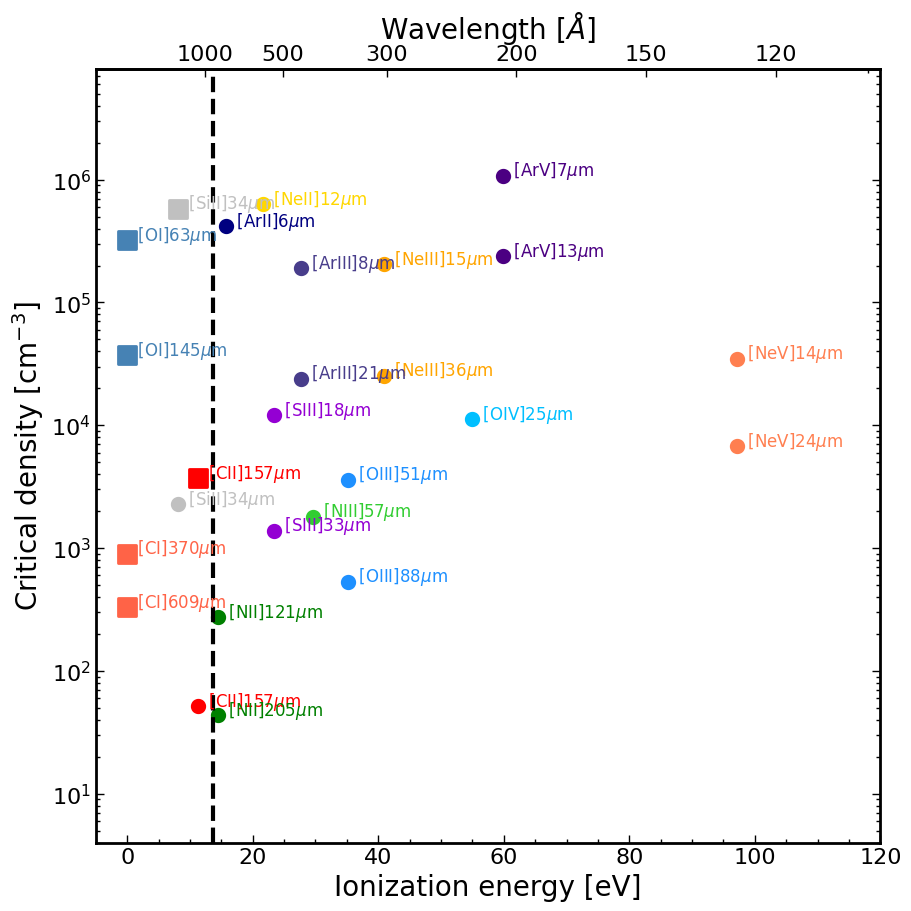

In [12]:
"""
Solve the level population for 5-level atoms for a neutral and ionized gas case, 
adopting n=10000 cm-3 and Tkin=100 K and n=100 cm-3 and Tkin=10000 K, respectively.
We then plot critical density vs ionization energy of all the transitions.
"""

nicePlot()

# grid spacing
lT_ln_in=np.array([[4.,2.],[2.,4.]])
T_n_in=np.power(10.,lT_ln_in)

# the radiation field density is still to be implemented
n_gamma=0.  # cm-3

# set up empty tables
Eioniz=np.array([11.26030, 29.6013, 54.9355, 14.5341, 35.1211, 97.12, 40.96296, 21.56454, 8.15168, 23.33788, 59.81,  27.62966, 15.75961])
species=['C2', 'N3', 'O4', 'N2', 'O3', 'Ne5', 'Ne3', 'Ne2', 'Si2', 'S3', 'Ar5', 'Ar3', 'Ar2']
plot2nd=[0,     0,    0,    1,    1,    1,     1,    0,      0,     1,    1,     1,    0]
colvec=['red','limegreen','deepskyblue','green','dodgerblue','coral','orange','gold','silver','darkviolet','indigo','darkslateblue','navy']
lbl=['[CII]', '[NIII]', '[OIV]', '[NII]', '[OIII]', '[NeV]', '[NeIII]', '[NeII]', '[SiII]', '[SIII]', '[ArV]', '[ArIII]', '[ArII]']

EionizN=np.array([11.26030, 0., 0., 8.15168])
speciesN=['C2', 'C1', 'O1', 'Si2']
colvecN=['red','tomato','steelblue','silver']

tab_ncrit=Table()
tab_l=Table()

for i in species:
    tab_ncrit[i+'_ncrit']=Column(np.empty([1,4]),dtype='float')
    tab_l[i+'_nu']=Column(np.empty([10,1]),dtype='float')


# compute the level population throughout the grid
# ionized phase:
mat, nu, A, ncrit=init_C2(T_n_in[1][0],T_n_in[1][1],n_gamma,1.,0.)
tab_ncrit['C2_ncrit']=ncrit
tab_l['C2']=clight*1.e9/nu

mat, nu, A, ncrit=init_N3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['N3_ncrit']=ncrit
tab_l['N3']=clight*1.e9/nu

mat, nu, A, ncrit=init_O4(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['O4_ncrit']=ncrit
tab_l['O4']=clight*1.e9/nu

mat, nu, A, ncrit=init_N2(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['N2_ncrit']=ncrit
tab_l['N2']=clight*1.e9/nu

mat, nu, A, ncrit=init_O3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['O3_ncrit']=ncrit
tab_l['O3']=clight*1.e9/nu

mat, nu, A, ncrit=init_Ne5(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ne5_ncrit']=ncrit
tab_l['Ne5']=clight*1.e9/nu

mat, nu, A, ncrit=init_Ne3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ne3_ncrit']=ncrit
tab_l['Ne3']=clight*1.e9/nu

mat, nu, A, ncrit=init_Ne2(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ne2_ncrit']=ncrit
tab_l['Ne2']=clight*1.e9/nu

mat, nu, A, ncrit=init_Si2(T_n_in[1][0],T_n_in[1][1],n_gamma,1.,0.)
tab_ncrit['Si2_ncrit']=ncrit
tab_l['Si2']=clight*1.e9/nu

mat, nu, A, ncrit=init_S3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['S3_ncrit']=ncrit
tab_l['S3']=clight*1.e9/nu

mat, nu, A, ncrit=init_Ar5(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ar5_ncrit']=ncrit
tab_l['Ar5']=clight*1.e9/nu

mat, nu, A, ncrit=init_Ar3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ar3_ncrit']=ncrit
tab_l['Ar3']=clight*1.e9/nu

mat, nu, A, ncrit=init_Ar2(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ar2_ncrit']=ncrit
tab_l['Ar2']=clight*1.e9/nu

# neutral phase:
mat, nuC1N, A, ncritC1N=init_C1(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
mat, nuC2N, A, ncritC2N=init_C2(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
mat, nuO1N, A, ncritO1N=init_O1(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
mat, nuSi2N, A, ncritSi2N=init_Si2(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)

lC1N=clight/np.array(nuC1N/1.e9)
lC2N=clight/np.array(nuC2N/1.e9)
lO1N=clight/np.array(nuO1N/1.e9)
lSi2N=clight/np.array(nuSi2N/1.e9)


plt.rcParams["xtick.top"] = False

fig,ax=plt.subplots(figsize=(9,9),layout='constrained')

xmin=-5.
xmax=120.
ymin=4.
ymax=8e6
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_yscale('log')

for i in range(len(species)):
    ax.scatter(Eioniz[i],tab_ncrit[species[i]+'_ncrit'][0][0],color=colvec[i],marker='o')
    ax.text(Eioniz[i],tab_ncrit[species[i]+'_ncrit'][0][0],'  '+lbl[i]+str(int(tab_l[species[i]][0]))+r'$\mu$m',color=colvec[i],fontsize=12)
    if(plot2nd[i]==1):
        ax.scatter(Eioniz[i],tab_ncrit[species[i]+'_ncrit'][0][1],color=colvec[i],marker='o')
        ax.text(Eioniz[i],tab_ncrit[species[i]+'_ncrit'][0][1],'  '+lbl[i]+str(int(tab_l[species[i]][4]))+r'$\mu$m',color=colvec[i],fontsize=12)

    
ax.scatter(EionizN[1],ncritC1N[0],color=colvecN[1],marker='s',linewidth=2,s=150)
ax.scatter(EionizN[0],ncritC2N[0],color=colvecN[0],marker='s',linewidth=2,s=150)
ax.scatter(EionizN[2],ncritO1N[0],color=colvecN[2],marker='s',linewidth=2,s=150)
ax.scatter(EionizN[3],ncritSi2N[0],color=colvecN[3],marker='s',linewidth=2,s=150)
ax.scatter(EionizN[1],ncritC1N[1],color=colvecN[1],marker='s',linewidth=2,s=150)
ax.scatter(EionizN[2],ncritO1N[1],color=colvecN[2],marker='s',linewidth=2,s=150)

ax.text(EionizN[1],ncritC1N[0],'  [CI]'+str(int(lC1N[0]))+r'$\mu$m',color=colvecN[1],fontsize=12)
ax.text(EionizN[0],ncritC2N[0],'  [CII]'+str(int(lC2N[0]))+r'$\mu$m',color=colvecN[0],fontsize=12)
ax.text(EionizN[2],ncritO1N[0],'  [OI]'+str(int(lO1N[0]))+r'$\mu$m',color=colvecN[2],fontsize=12)
ax.text(EionizN[3],ncritSi2N[0],'  [SiII]'+str(int(lSi2N[0]))+r'$\mu$m',color=colvecN[3],fontsize=12)
ax.text(EionizN[1],ncritC1N[1],'  [CI]'+str(int(lC1N[4]))+r'$\mu$m',color=colvecN[1],fontsize=12)
ax.text(EionizN[2],ncritO1N[1],'  [OI]'+str(int(lO1N[4]))+r'$\mu$m',color=colvecN[2],fontsize=12)
ax.plot((13.6,13.6),(ymin,ymax),c='black',linestyle='dashed')

ax.set_xlabel('Ionization energy [eV]')
ax.set_ylabel(r'Critical density [cm$^{-3}$]')

# add an additional horizontal axis showing the transitions' wavelengths:
secax = ax.secondary_xaxis('top', functions=(en2wave, wave2en))
secax.set_xlabel(r'Wavelength [$\AA$]')
tickvec=np.array([120., 150., 200., 300., 500., 1000.])
secax.set_xticks(tickvec)
plt.rcParams["xtick.top"] = True

plt.savefig('figures/ncrit_ionenergy.png',dpi=400,format='png', bbox_inches='tight')
plt.show()






nicePlot: Setting rcParams


/tmp/ipykernel_1288213/3532595041.py:176: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_1288213/3532595041.py:177: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_1288213/3532595041.py:178: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_1288213/3532595041.py:291: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_1288213/3532595041.py:292: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*

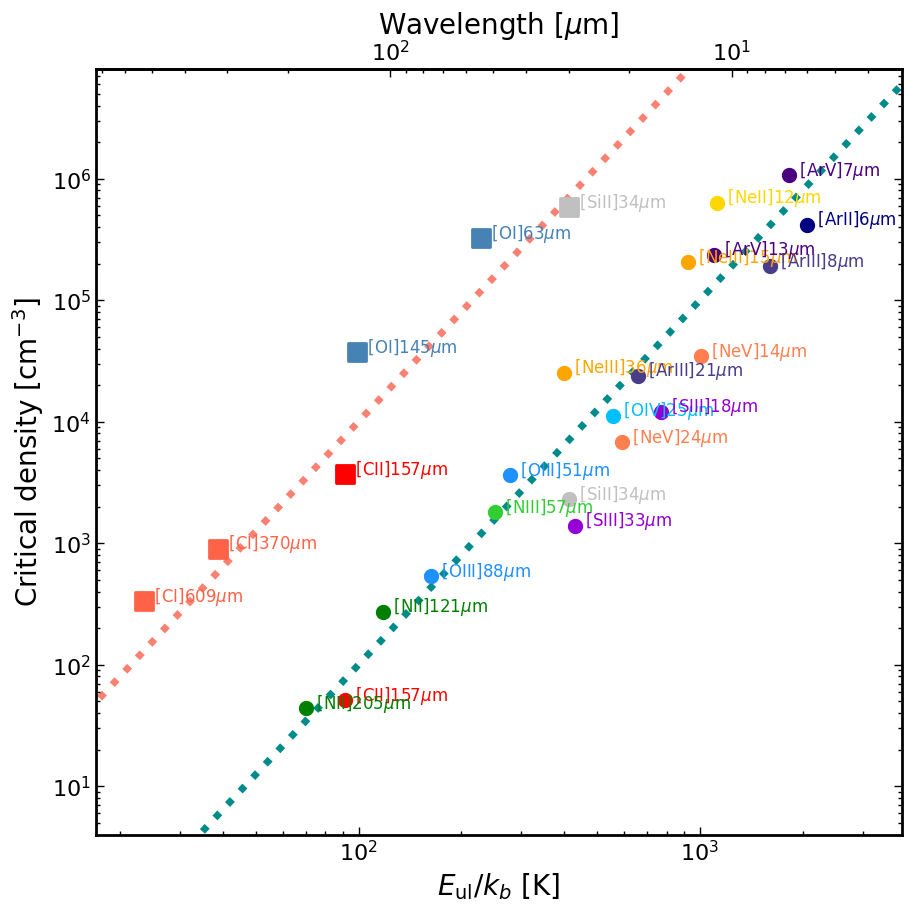

In [13]:
"""
Solve the level population for 5-level atoms for a neutral and ionized gas case, 
adopting n=10000 cm-3 and Tkin=100 K and n=100 cm-3 and Tkin=10000 K, respectively.
We then plot critical density vs photon energy of all the transitions.
"""


nicePlot()

# grid spacing
lT_ln_in=np.array([[4.,2.],[2.,4.]])
T_n_in=np.power(10.,lT_ln_in)

# the radiation field density is still to be done
n_gamma=0.  # cm-3

# set up empty tables
Eioniz=np.array([11.26030, 29.6013, 54.9355, 14.5341, 35.1211, 97.12, 40.96296, 21.56454, 8.15168, 23.33788, 59.81,  27.62966, 15.75961])
species=['C2', 'N3', 'O4', 'N2', 'O3', 'Ne5', 'Ne3', 'Ne2', 'Si2', 'S3', 'Ar5', 'Ar3', 'Ar2']
plot2nd=[0,     0,    0,    1,    1,    1,     1,    0,      0,     1,    1,     1,    0]
colvec=['red','limegreen','deepskyblue','green','dodgerblue','coral','orange','gold','silver','darkviolet','indigo','darkslateblue','navy']
lbl=['[CII]', '[NIII]', '[OIV]', '[NII]', '[OIII]', '[NeV]', '[NeIII]', '[NeII]', '[SiII]', '[SIII]', '[ArV]', '[ArIII]', '[ArII]']

EionizN=np.array([11.26030, 0., 0., 8.15168])
speciesN=['C2', 'C1', 'O1', 'Si2']
colvecN=['red','tomato','steelblue','silver']

tab_ncrit=Table()
tab_l=Table()
tab_Eul=Table()

for i in species:
    tab_ncrit[i+'_ncrit']=Column(np.empty([1,4]),dtype='float')
    tab_l[i+'_nu']=Column(np.empty([10,1]),dtype='float')


# compute the level population throughout the grid
# ionized phase:
mat, nu, A, ncrit=init_C2(T_n_in[1][0],T_n_in[1][1],n_gamma,1.,0.)
tab_ncrit['C2_ncrit']=ncrit
tab_l['C2']=clight*1.e9/nu
tab_Eul['C2']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_N3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['N3_ncrit']=ncrit
tab_l['N3']=clight*1.e9/nu
tab_Eul['N3']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_O4(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['O4_ncrit']=ncrit
tab_l['O4']=clight*1.e9/nu
tab_Eul['O4']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_N2(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['N2_ncrit']=ncrit
tab_l['N2']=clight*1.e9/nu
tab_Eul['N2']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_O3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['O3_ncrit']=ncrit
tab_l['O3']=clight*1.e9/nu
tab_Eul['O3']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_Ne5(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ne5_ncrit']=ncrit
tab_l['Ne5']=clight*1.e9/nu
tab_Eul['Ne5']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_Ne3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ne3_ncrit']=ncrit
tab_l['Ne3']=clight*1.e9/nu
tab_Eul['Ne3']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_Ne2(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ne2_ncrit']=ncrit
tab_l['Ne2']=clight*1.e9/nu
tab_Eul['Ne2']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_Si2(T_n_in[1][0],T_n_in[1][1],n_gamma,1.,0.)
tab_ncrit['Si2_ncrit']=ncrit
tab_l['Si2']=clight*1.e9/nu
tab_Eul['Si2']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_S3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['S3_ncrit']=ncrit
tab_l['S3']=clight*1.e9/nu
tab_Eul['S3']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_Ar5(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ar5_ncrit']=ncrit
tab_l['Ar5']=clight*1.e9/nu
tab_Eul['Ar5']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_Ar3(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ar3_ncrit']=ncrit
tab_l['Ar3']=clight*1.e9/nu
tab_Eul['Ar3']=hplanck*nu/kboltz

mat, nu, A, ncrit=init_Ar2(T_n_in[1][0],T_n_in[1][1],n_gamma)
tab_ncrit['Ar2_ncrit']=ncrit
tab_l['Ar2']=clight*1.e9/nu
tab_Eul['Ar2']=hplanck*nu/kboltz

# neutral phase:
mat, nuC1N, A, ncritC1N=init_C1(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
mat, nuC2N, A, ncritC2N=init_C2(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
mat, nuO1N, A, ncritO1N=init_O1(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
mat, nuSi2N, A, ncritSi2N=init_Si2(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)

EulC1N=np.array(hplanck*nuC1N/kboltz)
EulC2N=np.array(hplanck*nuC2N/kboltz)
EulO1N=np.array(hplanck*nuO1N/kboltz)
EulSi2N=np.array(hplanck*nuSi2N/kboltz)
lC1N=clight/np.array(nuC1N/1.e9)
lC2N=clight/np.array(nuC2N/1.e9)
lO1N=clight/np.array(nuO1N/1.e9)
lSi2N=clight/np.array(nuSi2N/1.e9)


plt.rcParams["xtick.top"] = False

fig,ax=plt.subplots(figsize=(9,9),layout='constrained')

xmin=17.
xmax=3900.
ax.set_xlim(xmin,xmax)
ax.set_ylim(4,0.8e7)
ax.set_xscale('log')
ax.set_yscale('log')

tt=np.arange(0.5,4.4,0.1)
ncn=3.*(tt-2.)+4
nce=3.*(tt-2.)+2

ax.plot(np.power(10.,tt),np.power(10.,ncn),linewidth=5,linestyle='dotted',c='salmon',zorder=-1)
ax.plot(np.power(10.,tt),np.power(10.,nce),linewidth=5,linestyle='dotted',c='darkcyan',zorder=-1)


for i in range(len(species)):
    ax.scatter(tab_Eul[species[i]][0],tab_ncrit[species[i]+'_ncrit'][0][0],color=colvec[i],marker='o')
    ax.text(tab_Eul[species[i]][0],tab_ncrit[species[i]+'_ncrit'][0][0],'  '+lbl[i]+str(int(tab_l[species[i]][0]))+r'$\mu$m',color=colvec[i],fontsize=12)
    if(plot2nd[i]==1):
        ax.scatter(tab_Eul[species[i]][4],tab_ncrit[species[i]+'_ncrit'][0][1],color=colvec[i],marker='o')
        ax.text(tab_Eul[species[i]][4],tab_ncrit[species[i]+'_ncrit'][0][1],'  '+lbl[i]+str(int(tab_l[species[i]][4]))+r'$\mu$m',color=colvec[i],fontsize=12)

    
ax.scatter(EulC1N[0],ncritC1N[0],color=colvecN[1],marker='s',linewidth=2,s=150)
ax.scatter(EulC2N[0],ncritC2N[0],color=colvecN[0],marker='s',linewidth=2,s=150)
ax.scatter(EulO1N[0],ncritO1N[0],color=colvecN[2],marker='s',linewidth=2,s=150)
ax.scatter(EulSi2N[0],ncritSi2N[0],color=colvecN[3],marker='s',linewidth=2,s=150)
ax.scatter(EulC1N[4],ncritC1N[1],color=colvecN[1],marker='s',linewidth=2,s=150)
ax.scatter(EulO1N[4],ncritO1N[1],color=colvecN[2],marker='s',linewidth=2,s=150)

ax.text(EulC1N[0],ncritC1N[0],'  [CI]'+str(int(lC1N[0]))+r'$\mu$m',color=colvecN[1],fontsize=12)
ax.text(EulC2N[0],ncritC2N[0],'  [CII]'+str(int(lC2N[0]))+r'$\mu$m',color=colvecN[0],fontsize=12)
ax.text(EulO1N[0],ncritO1N[0],'  [OI]'+str(int(lO1N[0]))+r'$\mu$m',color=colvecN[2],fontsize=12)
ax.text(EulSi2N[0],ncritSi2N[0],'  [SiII]'+str(int(lSi2N[0]))+r'$\mu$m',color=colvecN[3],fontsize=12)
ax.text(EulC1N[4],ncritC1N[1],'  [CI]'+str(int(lC1N[4]))+r'$\mu$m',color=colvecN[1],fontsize=12)
ax.text(EulO1N[4],ncritO1N[1],'  [OI]'+str(int(lO1N[4]))+r'$\mu$m',color=colvecN[2],fontsize=12)

ax.set_xlabel(r'$E_{\rm ul}/k_b$ [K]')
ax.set_ylabel(r'Critical density [cm$^{-3}$]')

secax = ax.secondary_xaxis('top', functions=(en2wave, wave2en))
secax.set_xlabel(r'Wavelength [$\mu$m]')

plt.rcParams["xtick.top"] = True


plt.savefig('./figures/fig_Eul_ncrit.png',dpi=400,format='png', bbox_inches='tight')
plt.show()






/tmp/ipykernel_1288213/3532595041.py:176: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_1288213/3532595041.py:177: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_1288213/3532595041.py:178: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_1288213/3532595041.py:291: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_1288213/3532595041.py:292: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*

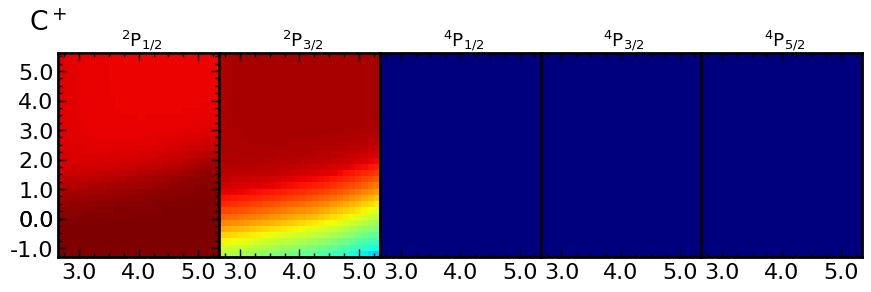

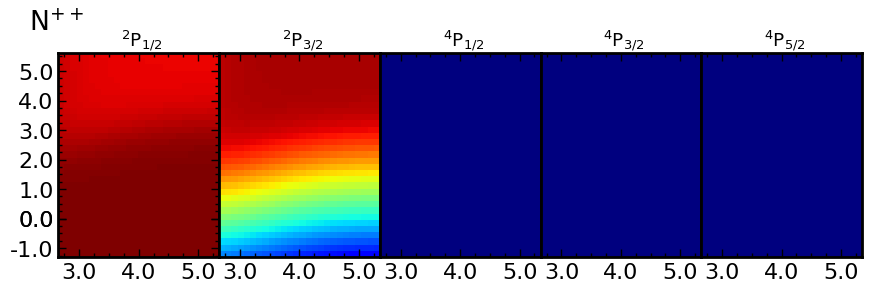

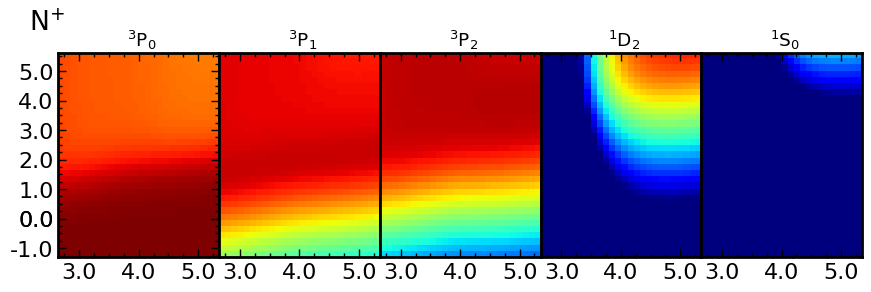

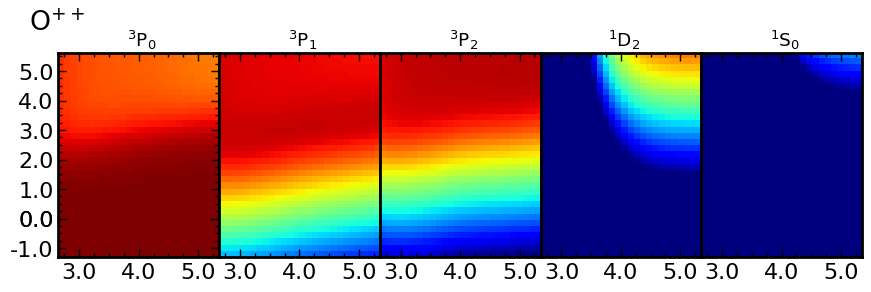

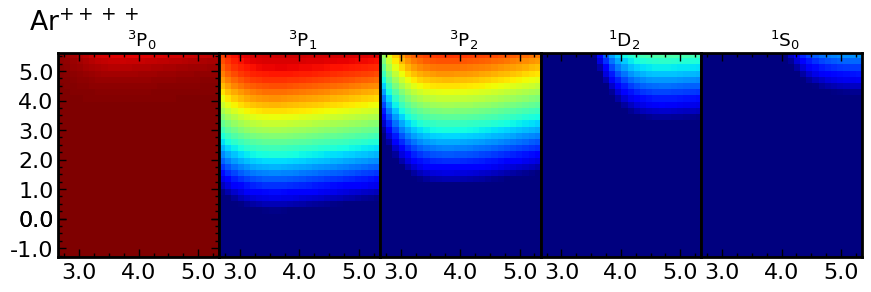

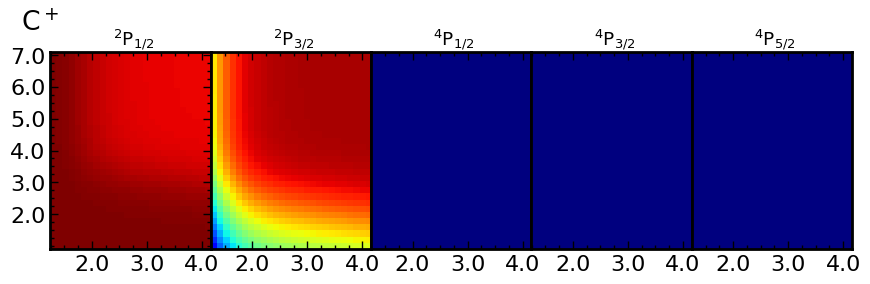

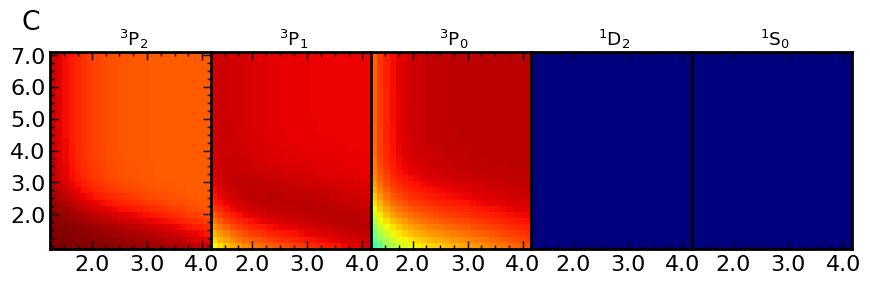

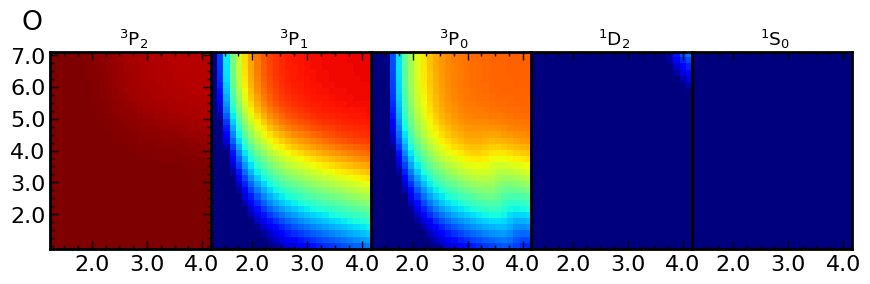

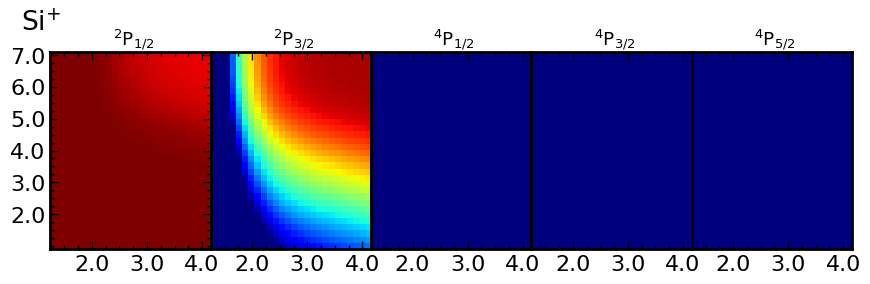

In [14]:
"""
Solve the level population for 5-level atoms for a neutral and ionized gas case, 
adopting a grid of (n,Tkin) values.
We then plot the level populations for various species.
"""

# grid spacing
lTE_in0=np.linspace(2.7,5.3,26,dtype='float')
lnE_in0=np.linspace(-1.2,5.5,33,dtype='float')

lTN_in0=np.linspace(1.3,4.1,26,dtype='float')
lnN_in0=np.linspace(1.0,7.0,32,dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)

# plot examples of energy level populations in different ionized gas tracers
inpPF_C2=np.reshape(tab_pop_fracE['C2_PF'],(len(lnE_in0),len(lTE_in0),5))
inpPF_N2=np.reshape(tab_pop_fracE['N2_PF'],(len(lnE_in0),len(lTE_in0),5))
inpPF_N3=np.reshape(tab_pop_fracE['N3_PF'],(len(lnE_in0),len(lTE_in0),5))
inpPF_O3=np.reshape(tab_pop_fracE['O3_PF'],(len(lnE_in0),len(lTE_in0),5))
inpPF_Ar5=np.reshape(tab_pop_fracE['Ar5_PF'],(len(lnE_in0),len(lTE_in0),5))

levc2=[r'$^{2}$P$_{1/2}$', r'$^{2}$P$_{3/2}$', r'$^{4}$P$_{1/2}$', r'$^{4}$P$_{3/2}$', r'$^{4}$P$_{5/2}$']
levo3=[r'$^{3}$P$_{0}$', r'$^{3}$P$_{1}$', r'$^{3}$P$_{2}$', r'$^{1}$D$_{2}$', r'$^{1}$S$_{0}$']
levo1=[r'$^{3}$P$_{2}$', r'$^{3}$P$_{1}$', r'$^{3}$P$_{0}$', r'$^{1}$D$_{2}$', r'$^{1}$S$_{0}$']
im0,im1,im2,im3,im4=plotPF(lnE_in0,lTE_in0,inpPF_C2,r'C$^+$',levc2)
plt.savefig('figures/popfrac_C2e.png',dpi=400,format='png', bbox_inches='tight')
im0,im1,im2,im3,im4=plotPF(lnE_in0,lTE_in0,inpPF_N3,r'N$^{++}$',levc2)
plt.savefig('figures/popfrac_N3.png',dpi=400,format='png', bbox_inches='tight')
im0,im1,im2,im3,im4=plotPF(lnE_in0,lTE_in0,inpPF_N2,r'N$^{+}$',levo3)
plt.savefig('figures/popfrac_N2.png',dpi=400,format='png', bbox_inches='tight')
im0,im1,im2,im3,im4=plotPF(lnE_in0,lTE_in0,inpPF_O3,r'O$^{++}$',levo3)
plt.savefig('figures/popfrac_O3.png',dpi=400,format='png', bbox_inches='tight')
im0,im1,im2,im3,im4=plotPF(lnE_in0,lTE_in0,inpPF_Ar5,r'Ar$^{++++}$',levo3)
plt.savefig('figures/popfrac_Ar5.png',dpi=400,format='png', bbox_inches='tight')



# plot examples of energy level populations in different neutral gas tracers
inpPF_C2=np.reshape(tab_pop_fracN['C2_PF'],(len(lnN_in0),len(lTN_in0),5))
inpPF_C1=np.reshape(tab_pop_fracN['C1_PF'],(len(lnN_in0),len(lTN_in0),5))
inpPF_O1=np.reshape(tab_pop_fracN['O1_PF'],(len(lnN_in0),len(lTN_in0),5))
inpPF_Si2=np.reshape(tab_pop_fracN['Si2_PF'],(len(lnN_in0),len(lTN_in0),5))

levc2=[r'$^{2}$P$_{1/2}$', r'$^{2}$P$_{3/2}$', r'$^{4}$P$_{1/2}$', r'$^{4}$P$_{3/2}$', r'$^{4}$P$_{5/2}$']
im0,im1,im2,im3,im4=plotPF(lnN_in0,lTN_in0,inpPF_C2,r'C$^+$',levc2)
plt.savefig('figures/popfrac_C2n.png',dpi=400,format='png', bbox_inches='tight')
im0,im1,im2,im3,im4=plotPF(lnN_in0,lTN_in0,inpPF_C1,r'C',levo1)
plt.savefig('figures/popfrac_C1.png',dpi=400,format='png', bbox_inches='tight')
im0,im1,im2,im3,im4=plotPF(lnN_in0,lTN_in0,inpPF_O1,r'O',levo1)
plt.savefig('figures/popfrac_O1.png',dpi=400,format='png', bbox_inches='tight')
im0,im1,im2,im3,im4=plotPF(lnN_in0,lTN_in0,inpPF_Si2,r'Si$^{+}$',levc2)
plt.savefig('figures/popfrac_Si2.png',dpi=400,format='png', bbox_inches='tight')



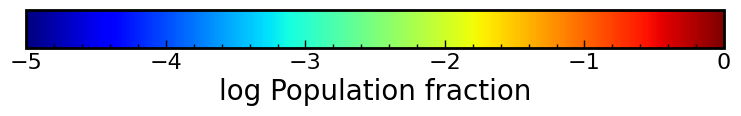

In [15]:
"""
Draw the color bar for the previous plot
"""
import matplotlib as mpl

figB, axB = plt.subplots(figsize=(9, 1))
figB.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-5, vmax=0)

figB.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=axB, orientation='horizontal', label=r'log Population fraction')
plt.savefig('figures/label_cbar.png',dpi=400,format='png', bbox_inches='tight')
plt.show()

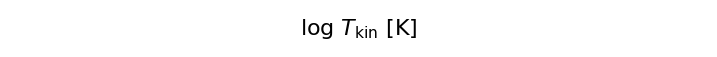

In [16]:
"""
Draw the x-axis label for the previous plot
"""
figX, axX = plt.subplots(figsize=(9, 1))
figX.subplots_adjust(bottom=0.5)
axX.set_xlim(0,1)
axX.set_ylim(0,1)
axX.get_xaxis().set_visible(False)
axX.get_yaxis().set_visible(False)
axX.axis('off')
axX.text(0.5,0.5,r'log $T_{\rm kin}$ [K]',ha='center',va='center')    
plt.savefig('figures/label_lgT.png',dpi=400,format='png', bbox_inches='tight')
plt.show()

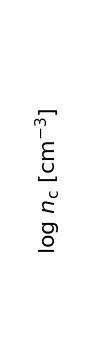

In [17]:
"""
Draw the y-axis label for the previous plot
"""
figY, axY = plt.subplots(figsize=(1, 9))
figY.subplots_adjust(bottom=0.5)
axY.set_xlim(0,1)
axY.set_ylim(0,1)
axY.get_xaxis().set_visible(False)
axY.get_yaxis().set_visible(False)
axY.axis('off')
axY.text(0.5,0.5,r'log $n_{\rm c}$ [cm$^{-3}$]',ha='center',va='center', rotation=90)   
plt.savefig('figures/label_lgn.png',dpi=400,format='png', bbox_inches='tight')
plt.show()

In [103]:
""" 
Setup fit for density diagnostics
"""
def modelf(theta, x):
    A,B,C,D=theta
    _z=(x-B)/A
    model=C*sp.erf(_z)+D
    return model


def log_likelihood(theta, x, y, ey):
    model = modelf(theta,x)
    sigma2 = ey**2 
    lglike = np.array(-0.5 * np.sum((y - model) ** 2 / sigma2))  #  + np.log(sigma2)
    return lglike


def log_prior(theta):
    A,B,C,D = theta
    log_P_A = np.log10(gauss(A,0.,1.))
    log_P_B = np.log10(maxwell(B,1.))
    log_P_C = np.log10(gauss(C,0.5,1.))
    log_P_D = np.log10(gauss(D,0.,1.))
    if not (np.isfinite(log_P_A) and np.isfinite(log_P_B) and np.isfinite(log_P_C) and np.isfinite(log_P_D)):
        return -np.inf
    log_P = log_P_A + log_P_B + log_P_C + log_P_D 
    return log_P
    
    
def maxwell(par,scale):
    _a=scale/2./np.sqrt(2./np.pi)
    _out=np.where((par>0.),np.sqrt((0.5/np.pi)**3)*(1./_a**3)*4.*np.pi*(par*par)*np.exp(-(par*par)/(2.*_a*_a)),np.nan)
    return _out
    

def gauss(par,mean,sigma):
    _out=1./np.sqrt(2.*np.pi)/sigma*np.exp(-(par-mean)**2/2./sigma/sigma)
    return _out


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    cond_inf=np.where((np.abs(lp)<np.inf),0,1)
    if np.sum(cond_inf)>0:
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


def make_cornerplots(theta):
    fig, axes = plt.subplots(len(theta), figsize=(len(theta), len(theta)), sharex=True)
    samples = sampler.get_chain()
    labels = ['A','B','C','D'] # ,'logf'

    for j in range(ndim):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

    flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)

    fig = corner.corner(
        flat_samples, labels=labels
    )
    return flat_samples, labels

    
def printout_fit_results(ind,flat_samples,theta):
    theta_out=np.empty_like(theta)
    em_theta_out=np.empty_like(theta)
    ep_theta_out=np.empty_like(theta)

    for j in range(len(theta)):
        mcmc = np.percentile(flat_samples[:, j], [16, 50, 84])
        theta_out[j]=mcmc[1]
        q = np.diff(mcmc)
        em_theta_out[j]=q[0]
        ep_theta_out[j]=q[1]
        txt = "{0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
        txt = txt.format(mcmc[1], q[0], q[1])
        display(Math(txt))

    tm = Table([theta_out, em_theta_out, ep_theta_out], names=['theta', 'em_theta', 'ep_theta'], masked=True)

    tm.write('tm'+str(ind)+'.csv', overwrite=True)

    return theta_out, em_theta_out, ep_theta_out

    


In [19]:
"""
Fit density diagnostics
"""

def fit_ratio_lne(lgRatio,x_fit):
    theta=np.array([0.6,1.5,0.,1.5]) #, np.array([0.1])

    y_fit=lgRatio
    ey_fit=np.ones_like(y_fit)*0.02
    
    guess=np.resize(theta,(100,len(theta)))

    pos = guess + 0.01 * np.random.randn(100, len(theta))
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(x_fit, y_fit, ey_fit)
    )
    sampler.run_mcmc(pos, 500, progress=True)

    #flat_samples,labels=make_cornerplots(theta)
    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
    
    theta_out, em, ep=printout_fit_results(i,flat_samples,theta)
    
    return theta_out, em, ep



lTE_in0=np.array([4.])
lnE_in0=np.linspace(-1.2,5.5,33,dtype='float')

lTN_in0=np.array([2.])
lnN_in0=np.linspace(1.0,7.0,32,dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)
ref_ncritE=np.copy(tab_ncritE)
ref_ncritN=np.copy(tab_ncritN)

print('[OIII]')
O3_Lum10=tab_pop_fracE['O3_PF'][:,1]*hplanck*tab_nuE['O3_nu'][0]*tab_AE['O3_A'][0]
O3_Lum21=tab_pop_fracE['O3_PF'][:,2]*hplanck*tab_nuE['O3_nu'][4]*tab_AE['O3_A'][4]
O3_ratio=O3_Lum21/O3_Lum10
O3_lratio=np.log10(O3_ratio)
lneE=lnE_in0
theta_o3,em_theta_o3,ep_theta_o3=fit_ratio_lne(O3_lratio,lneE)


print('[NII]')
N2_Lum10=tab_pop_fracE['N2_PF'][:,1]*hplanck*tab_nuE['N2_nu'][0]*tab_AE['N2_A'][0]
N2_Lum21=tab_pop_fracE['N2_PF'][:,2]*hplanck*tab_nuE['N2_nu'][4]*tab_AE['N2_A'][4]
N2_ratio=N2_Lum21/N2_Lum10
N2_lratio=np.log10(N2_ratio)
theta_n2,em_theta_n2,ep_theta_n2=fit_ratio_lne(N2_lratio,lneE)


print('[ArV]')
Ar5_Lum10=tab_pop_fracE['Ar5_PF'][:,1]*hplanck*tab_nuE['Ar5_nu'][0]*tab_AE['Ar5_A'][0]
Ar5_Lum21=tab_pop_fracE['Ar5_PF'][:,2]*hplanck*tab_nuE['Ar5_nu'][4]*tab_AE['Ar5_A'][4]
Ar5_ratio=Ar5_Lum21/Ar5_Lum10
Ar5_lratio=np.log10(Ar5_ratio)
theta_ar5,em_theta_ar5,ep_theta_ar5=fit_ratio_lne(Ar5_lratio,lneE)


print('[OI]')
O1_Lum10=tab_pop_fracN['O1_PF'][:,1]*hplanck*tab_nuN['O1_nu'][0]*tab_AN['O1_A'][0]
O1_Lum21=tab_pop_fracN['O1_PF'][:,2]*hplanck*tab_nuN['O1_nu'][4]*tab_AN['O1_A'][4]
O1_ratio=O1_Lum21/O1_Lum10
O1_lratio=np.log10(O1_ratio)
lneN=lnN_in0
theta_o1,em_theta_o1,ep_theta_o1=fit_ratio_lne(O1_lratio,lneN)


print('[CI]')
C1_Lum10=tab_pop_fracN['C1_PF'][:,1]*hplanck*tab_nuN['C1_nu'][0]*tab_AN['C1_A'][0]
C1_Lum21=tab_pop_fracN['C1_PF'][:,2]*hplanck*tab_nuN['C1_nu'][4]*tab_AN['C1_A'][4]
C1_ratio=C1_Lum21/C1_Lum10
C1_lratio=np.log10(C1_ratio)
theta_c1,em_theta_c1,ep_theta_c1=fit_ratio_lne(C1_lratio,lneN)


print('[NeIII]')
Ne3_Lum10=tab_pop_fracE['Ne3_PF'][:,1]*hplanck*tab_nuE['Ne3_nu'][0]*tab_AE['Ne3_A'][0]
Ne3_Lum21=tab_pop_fracE['Ne3_PF'][:,2]*hplanck*tab_nuE['Ne3_nu'][4]*tab_AE['Ne3_A'][4]
Ne3_ratio=Ne3_Lum21/Ne3_Lum10
Ne3_lratio=np.log10(Ne3_ratio)
theta_ne3,em_theta_ne3,ep_theta_ne3=fit_ratio_lne(Ne3_lratio,lneE)


print('[NeV]')
Ne5_Lum10=tab_pop_fracE['Ne5_PF'][:,1]*hplanck*tab_nuE['Ne5_nu'][0]*tab_AE['Ne5_A'][0]
Ne5_Lum21=tab_pop_fracE['Ne5_PF'][:,2]*hplanck*tab_nuE['Ne5_nu'][4]*tab_AE['Ne5_A'][4]
Ne5_ratio=Ne5_Lum21/Ne5_Lum10
Ne5_lratio=np.log10(Ne5_ratio)
theta_ne5,em_theta_ne5,ep_theta_ne5=fit_ratio_lne(Ne5_lratio,lneE)


print('[SIII]')
S3_Lum10=tab_pop_fracE['S3_PF'][:,1]*hplanck*tab_nuE['S3_nu'][0]*tab_AE['S3_A'][0]
S3_Lum21=tab_pop_fracE['S3_PF'][:,2]*hplanck*tab_nuE['S3_nu'][4]*tab_AE['S3_A'][4]
S3_ratio=S3_Lum21/S3_Lum10
S3_lratio=np.log10(S3_ratio)
theta_s3,em_theta_s3,ep_theta_s3=fit_ratio_lne(S3_lratio,lneE)

/tmp/ipykernel_274659/782143433.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_274659/782143433.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_274659/782143433.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_274659/782143433.py:272: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_274659/782143433.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[

[OIII]


100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 51.82it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[NII]


 15%|██████▍                                   | 77/500 [00:01<00:08, 51.78it/s]/tmp/ipykernel_274659/1564143524.py:27: RuntimeWarning: divide by zero encountered in log10
  log_P_B = np.log10(maxwell(B,1.))
100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 54.88it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[ArV]


100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 62.02it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[OI]


  6%|██▋                                       | 32/500 [00:00<00:07, 59.41it/s]/tmp/ipykernel_274659/1564143524.py:26: RuntimeWarning: divide by zero encountered in log10
  log_P_A = np.log10(gauss(A,0.,1.))
100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 52.69it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[CI]


100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 50.40it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[NeIII]


100%|█████████████████████████████████████████| 500/500 [00:12<00:00, 40.43it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[NeV]


100%|█████████████████████████████████████████| 500/500 [00:10<00:00, 49.89it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[SIII]


100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 51.46it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
"""
Write out best fit results
"""
tabout=Table()
tabout['[OIII]']=theta_o3
tabout['[NeIII]']=theta_ne3
tabout['[ArV]']=theta_ar5
tabout['[NeV]']=theta_ne5
tabout['[NII]']=theta_n2
tabout['[SIII]']=theta_s3
tabout['[CI]']=theta_c1
tabout['[OI]']=theta_o1

ascii.write(tabout, 'density_diagnostics.dat', overwrite=True)


/tmp/ipykernel_41925/782143433.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_41925/782143433.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_41925/782143433.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_41925/782143433.py:272: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_41925/782143433.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[5]+(1

36.019999999999996
nicePlot: Setting rcParams


/tmp/ipykernel_41925/579654900.py:228: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


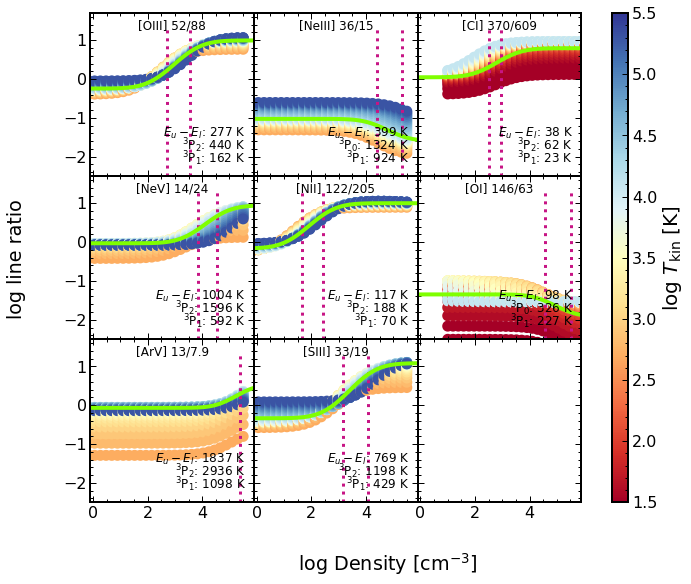

In [105]:
"""
Plot density diagnostics
"""

rr=np.arange(-1.,6.,0.1)

tabout=ascii.read('density_diagnostics.dat', format='basic')
theta_o3=tabout['[OIII]']
theta_ne3=tabout['[NeIII]']
theta_ar5=tabout['[ArV]']
theta_ne5=tabout['[NeV]']
theta_n2=tabout['[NII]']
theta_s3=tabout['[SIII]']
theta_c1=tabout['[CI]']
theta_o1=tabout['[OI]']

# grid spacing
lTE_in0=np.linspace(2.7,5.3,27,dtype='float')
lnE_in0=np.linspace(-1.2,5.5,33,dtype='float')

lTN_in0=np.linspace(1.3,4.1,29,dtype='float')
lnN_in0=np.linspace(1.0,7.0,32,dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)
ref_ncritE=np.copy(tab_ncritE)
ref_ncritN=np.copy(tab_ncritN)


O3_Lum10=tab_pop_fracE['O3_PF'][:,1]*hplanck*tab_nuE['O3_nu'][0]*tab_AE['O3_A'][0]
O3_Lum21=tab_pop_fracE['O3_PF'][:,2]*hplanck*tab_nuE['O3_nu'][4]*tab_AE['O3_A'][4]
O3_nc1=ref_ncritE['O3_ncrit'][:,0]
O3_nc2=ref_ncritE['O3_ncrit'][:,1]
O3_E1=(tab_nuE['O3_nu'][0])*hplanck/kboltz
O3_E2=(tab_nuE['O3_nu'][1])*hplanck/kboltz
O3_ratio=O3_Lum21/O3_Lum10
O3_lratio=np.log10(O3_ratio)
O3_fit=modelf(theta_o3,rr)


N2_Lum10=tab_pop_fracE['N2_PF'][:,1]*hplanck*tab_nuE['N2_nu'][0]*tab_AE['N2_A'][0]
N2_Lum21=tab_pop_fracE['N2_PF'][:,2]*hplanck*tab_nuE['N2_nu'][4]*tab_AE['N2_A'][4]
N2_nc1=ref_ncritE['N2_ncrit'][:,0]
N2_nc2=ref_ncritE['N2_ncrit'][:,1]
N2_E1=(tab_nuE['N2_nu'][0])*hplanck/kboltz
N2_E2=(tab_nuE['N2_nu'][1])*hplanck/kboltz
N2_ratio=N2_Lum21/N2_Lum10
N2_lratio=np.log10(N2_ratio)
N2_fit=modelf(theta_n2,rr)


Ar5_Lum10=tab_pop_fracE['Ar5_PF'][:,1]*hplanck*tab_nuE['Ar5_nu'][0]*tab_AE['Ar5_A'][0]
Ar5_Lum21=tab_pop_fracE['Ar5_PF'][:,2]*hplanck*tab_nuE['Ar5_nu'][4]*tab_AE['Ar5_A'][4]
Ar5_nc1=ref_ncritE['Ar5_ncrit'][:,0]
Ar5_nc2=ref_ncritE['Ar5_ncrit'][:,1]
Ar5_E1=(tab_nuE['Ar5_nu'][0])*hplanck/kboltz
Ar5_E2=(tab_nuE['Ar5_nu'][1])*hplanck/kboltz
Ar5_ratio=Ar5_Lum21/Ar5_Lum10
Ar5_lratio=np.log10(Ar5_ratio)
Ar5_fit=modelf(theta_ar5,rr)


O1_Lum10=tab_pop_fracN['O1_PF'][:,1]*hplanck*tab_nuN['O1_nu'][0]*tab_AN['O1_A'][0]
O1_Lum21=tab_pop_fracN['O1_PF'][:,2]*hplanck*tab_nuN['O1_nu'][4]*tab_AN['O1_A'][4]
O1_nc1=ref_ncritN['O1_ncrit'][:,0]
O1_nc2=ref_ncritN['O1_ncrit'][:,1]
O1_E1=(tab_nuN['O1_nu'][0])*hplanck/kboltz
O1_E2=(tab_nuN['O1_nu'][1])*hplanck/kboltz
O1_ratio=O1_Lum21/O1_Lum10
O1_lratio=np.log10(O1_ratio)
O1_fit=modelf(theta_o1,rr)

C1_Lum10=tab_pop_fracN['C1_PF'][:,1]*hplanck*tab_nuN['C1_nu'][0]*tab_AN['C1_A'][0]
C1_Lum21=tab_pop_fracN['C1_PF'][:,2]*hplanck*tab_nuN['C1_nu'][4]*tab_AN['C1_A'][4]
C1_nc1=ref_ncritN['C1_ncrit'][:,0]
C1_nc2=ref_ncritN['C1_ncrit'][:,1]
C1_E1=(tab_nuN['C1_nu'][0])*hplanck/kboltz
C1_E2=(tab_nuN['C1_nu'][1])*hplanck/kboltz
C1_ratio=C1_Lum21/C1_Lum10
C1_lratio=np.log10(C1_ratio)
C1_fit=modelf(theta_c1,rr)


Ne3_Lum10=tab_pop_fracE['Ne3_PF'][:,1]*hplanck*tab_nuE['Ne3_nu'][0]*tab_AE['Ne3_A'][0]
Ne3_Lum21=tab_pop_fracE['Ne3_PF'][:,2]*hplanck*tab_nuE['Ne3_nu'][4]*tab_AE['Ne3_A'][4]
Ne3_nc1=ref_ncritE['Ne3_ncrit'][:,0]
Ne3_nc2=ref_ncritE['Ne3_ncrit'][:,1]
Ne3_E1=(tab_nuE['Ne3_nu'][0])*hplanck/kboltz
Ne3_E2=(tab_nuE['Ne3_nu'][1])*hplanck/kboltz
Ne3_ratio=Ne3_Lum21/Ne3_Lum10
Ne3_lratio=np.log10(Ne3_ratio)
Ne3_fit=modelf(theta_ne3,rr)
print(clight/(tab_nuE['Ne3_nu'][4]/1.e9))


Ne5_Lum10=tab_pop_fracE['Ne5_PF'][:,1]*hplanck*tab_nuE['Ne5_nu'][0]*tab_AE['Ne5_A'][0]
Ne5_Lum21=tab_pop_fracE['Ne5_PF'][:,2]*hplanck*tab_nuE['Ne5_nu'][4]*tab_AE['Ne5_A'][4]
Ne5_nc1=ref_ncritE['Ne5_ncrit'][:,0]
Ne5_nc2=ref_ncritE['Ne5_ncrit'][:,1]
Ne5_E1=(tab_nuE['Ne5_nu'][0])*hplanck/kboltz
Ne5_E2=(tab_nuE['Ne5_nu'][1])*hplanck/kboltz
Ne5_ratio=Ne5_Lum21/Ne5_Lum10
Ne5_lratio=np.log10(Ne5_ratio)
Ne5_fit=modelf(theta_ne5,rr)


S3_Lum10=tab_pop_fracE['S3_PF'][:,1]*hplanck*tab_nuE['S3_nu'][0]*tab_AE['S3_A'][0]
S3_Lum21=tab_pop_fracE['S3_PF'][:,2]*hplanck*tab_nuE['S3_nu'][4]*tab_AE['S3_A'][4]
S3_nc1=ref_ncritE['S3_ncrit'][:,0]
S3_nc2=ref_ncritE['S3_ncrit'][:,1]
S3_E1=(tab_nuE['S3_nu'][0])*hplanck/kboltz
S3_E2=(tab_nuE['S3_nu'][1])*hplanck/kboltz
S3_ratio=S3_Lum21/S3_Lum10
S3_lratio=np.log10(S3_ratio)
S3_fit=modelf(theta_s3,rr)





nicePlot()
xmin=-0.1
xmax=5.9
ymin=-2.5
ymax=1.7


fig, axs = plt.subplots(3, 3, figsize=(11,9), 
                        sharex=True, sharey=True, squeeze=True,
                        gridspec_kw=dict(wspace=0,hspace=0))

pcm=axs[0,0].scatter(lT_ln_inE[:,0],O3_lratio,c=lT_ln_inE[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,0].plot((np.log10(O3_nc1[13]),np.log10(O3_nc1[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[0,0].plot((np.log10(O3_nc2[13]),np.log10(O3_nc2[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[0,0].plot(rr,O3_fit,c='chartreuse',linewidth=4)
axs[0,0].set_xlim(xmin,xmax)
axs[0,0].set_ylim(ymin,ymax)
axs[0,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[OIII] 52/88',ha='center',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(O3_E1)),ha='right',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(O3_E2)),ha='right',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(O3_E2-O3_E1)),ha='right',fontsize=12)

axs[0,1].scatter(lT_ln_inE[:,0],Ne3_lratio,c=lT_ln_inE[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeIII] 36/15',ha='center',fontsize=12)
axs[0,1].plot((np.log10(Ne3_nc1[13]),np.log10(Ne3_nc1[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[0,1].plot((np.log10(Ne3_nc2[13]),np.log10(Ne3_nc2[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[0,1].plot(rr,Ne3_fit,c='chartreuse',linewidth=4)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ne3_E1)),ha='right',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_0$: {} K'.format(int(Ne3_E2)),ha='right',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ne3_E2-Ne3_E1)),ha='right',fontsize=12)

axs[0,2].scatter(lT_ln_inN[:,0],C1_lratio,c=lT_ln_inN[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,2].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[CI] 370/609',ha='center',fontsize=12)
axs[0,2].plot((np.log10(C1_nc1[7]),np.log10(C1_nc1[7])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[0,2].plot((np.log10(C1_nc2[7]),np.log10(C1_nc2[7])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[0,2].plot(rr,C1_fit,c='chartreuse',linewidth=4)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(C1_E1)),ha='right',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(C1_E2)),ha='right',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(C1_E2-C1_E1)),ha='right',fontsize=12)

axs[1,0].scatter(lT_ln_inE[:,0],Ne5_lratio,c=lT_ln_inE[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeV] 14/24',ha='center',fontsize=12)
axs[1,0].plot((np.log10(Ne5_nc1[13]),np.log10(Ne5_nc1[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[1,0].plot((np.log10(Ne5_nc2[13]),np.log10(Ne5_nc2[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[1,0].plot(rr,Ne5_fit,c='chartreuse',linewidth=4)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ne5_E1)),ha='right',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(Ne5_E2)),ha='right',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ne5_E2-Ne5_E1)),ha='right',fontsize=12)

axs[1,1].scatter(lT_ln_inE[:,0],N2_lratio,c=lT_ln_inE[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NII] 122/205',ha='center',fontsize=12)
axs[1,1].plot((np.log10(N2_nc1[13]),np.log10(N2_nc1[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[1,1].plot((np.log10(N2_nc2[13]),np.log10(N2_nc2[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[1,1].plot(rr,N2_fit,c='chartreuse',linewidth=4)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(N2_E1)),ha='right',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(N2_E2)),ha='right',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(N2_E2-N2_E1)),ha='right',fontsize=12)

axs[1,2].scatter(lT_ln_inN[:,0],O1_lratio,c=lT_ln_inN[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,2].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[OI] 146/63',ha='center',fontsize=12)
axs[1,2].plot((np.log10(O1_nc1[7]),np.log10(O1_nc1[7])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[1,2].plot((np.log10(O1_nc2[7]),np.log10(O1_nc2[7])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[1,2].plot(rr,O1_fit,c='chartreuse',linewidth=4)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(O1_E1)),ha='right',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_0$: {} K'.format(int(O1_E2)),ha='right',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(O1_E2-O1_E1)),ha='right',fontsize=12)

axs[2,0].scatter(lT_ln_inE[:,0],Ar5_lratio,c=lT_ln_inE[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[2,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[ArV] 13/7.9',ha='center',fontsize=12)
axs[2,0].plot((np.log10(Ar5_nc1[13]),np.log10(Ar5_nc1[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[2,0].plot((np.log10(Ar5_nc2[13]),np.log10(Ar5_nc2[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[2,0].plot(rr,Ar5_fit,c='chartreuse',linewidth=4)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ar5_E1)),ha='right',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(Ar5_E2)),ha='right',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ar5_E2-Ar5_E1)),ha='right',fontsize=12)

axs[2,1].scatter(lT_ln_inE[:,0],S3_lratio,c=lT_ln_inE[:,1],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[2,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[SIII] 33/19',ha='center',fontsize=12)
axs[2,1].plot((np.log10(S3_nc1[13]),np.log10(S3_nc1[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[2,1].plot((np.log10(S3_nc2[13]),np.log10(S3_nc2[13])),(ymin,ymax-0.4),c='mediumvioletred',linestyle='dotted')
axs[2,1].plot(rr,S3_fit,c='chartreuse',linewidth=4)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(S3_E1)),ha='right',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(S3_E2)),ha='right',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(S3_E2-S3_E1)),ha='right',fontsize=12)





fig.supxlabel(r'log Density [cm$^{-3}$]')
fig.supylabel(r'log line ratio')

fig.colorbar(pcm,ax=axs,aspect=30,label=r'log $T_{\rm kin}$ [K]')

fig.savefig('figures/fig_n_diagnostics.png',dpi=400,format='png', bbox_inches='tight')
fig.show()


In [106]:
"""
Setup fits for temperature diagnostics
"""

def modelf(theta,ltt):
    _A,_B,_C=theta
    tt=np.power(10.,ltt)
    ratio=_A/(np.exp(_B/tt)/(1.+np.sqrt(_C/tt)))
    lratio=np.log10(ratio)

    return lratio



def log_likelihood(theta, x, y, ey):
    model = modelf(theta,x)
    sigma2 = ey**2 
    lglike = np.array(-0.5 * np.sum((y - model) ** 2 / sigma2)) 
    return lglike


def log_prior(theta):
    A,B,C = theta
    log_P_A = gauss(np.log10(A),1.,1.)
    log_P_B = gauss(np.log10(B),4.,1.)
    log_P_C = gauss(np.log10(C),4.,1.)
    if not (np.isfinite(log_P_A) and np.isfinite(log_P_B) and np.isfinite(log_P_C)):
        return -np.inf
    log_P = log_P_A + log_P_B + log_P_C 
    return log_P
    
    
def maxwell(par,scale):
    _a=scale/2./np.sqrt(2./np.pi)
    _out=np.where((par>0.),np.sqrt((0.5/np.pi)**3)*(1./_a**3)*4.*np.pi*(par*par)*np.exp(-(par*par)/(2.*_a*_a)),np.nan)
    return _out
    

def gauss(par,mean,sigma):
    _out=1./np.sqrt(2.*np.pi)/sigma*np.exp(-(par-mean)**2/2./sigma/sigma)
    return _out


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    cond_inf=np.where((np.abs(lp)<np.inf),0,1)
    if np.sum(cond_inf)>0:
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


    
def printout_fit_results(ind,flat_samples,theta):
    theta_out=np.empty_like(theta)
    em_theta_out=np.empty_like(theta)
    ep_theta_out=np.empty_like(theta)

    for j in range(len(theta)):
        mcmc = np.percentile(flat_samples[:, j], [16, 50, 84])
        theta_out[j]=mcmc[1]
        q = np.diff(mcmc)
        em_theta_out[j]=q[0]
        ep_theta_out[j]=q[1]
        txt = "{0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
        txt = txt.format(mcmc[1], q[0], q[1])
        display(Math(txt))

    tm = Table([theta_out, em_theta_out, ep_theta_out], names=['theta', 'em_theta', 'ep_theta'], masked=True)

    tm.write('tm'+str(ind)+'.csv', overwrite=True)

    return theta_out, em_theta_out, ep_theta_out




def fit_ratio_ltt(lgRatio,x_fit):
    theta=np.array([10.,10000.,5000.]) 

    y_fit=lgRatio
    ey_fit=np.ones_like(y_fit)*0.2
    
    guess=np.resize(theta,(100,len(theta)))

    pos = guess + 0.1 * theta * np.random.randn(100, len(theta))
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(x_fit, y_fit, ey_fit)
    )
    sampler.run_mcmc(pos, 500, progress=True)

    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
    
    theta_out, em, ep=printout_fit_results(i,flat_samples,theta)
    
    return theta_out, em, ep

In [23]:
"""
Fit temperature diagnostics
"""

rr=np.arange(3.5,6.,0.1)

# grid spacing
lTE_in0=np.linspace(3.5,5.3,26,dtype='float')
lnE_in0=np.array([2.]) 

lTN_in0=np.linspace(1.3,4.1,26,dtype='float')
lnN_in0=np.linspace(1.0,7.0,32,dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)


O3_Lum10=tab_pop_fracE['O3_PF'][:,1]*hplanck*tab_nuE['O3_nu'][0]*tab_AE['O3_A'][0]
O3_Lum21=tab_pop_fracE['O3_PF'][:,2]*hplanck*tab_nuE['O3_nu'][4]*tab_AE['O3_A'][4]
O3_Lum32=tab_pop_fracE['O3_PF'][:,3]*hplanck*tab_nuE['O3_nu'][7]*tab_AE['O3_A'][7]
O3_Lum43=tab_pop_fracE['O3_PF'][:,4]*hplanck*tab_nuE['O3_nu'][9]*tab_AE['O3_A'][9]
O3_E1=(tab_nuE['O3_nu'][0])*hplanck/kboltz
O3_E2=(tab_nuE['O3_nu'][1])*hplanck/kboltz
O3_E3=(tab_nuE['O3_nu'][2])*hplanck/kboltz
O3_E4=(tab_nuE['O3_nu'][3])*hplanck/kboltz

O3_ratio1=O3_Lum43/O3_Lum32
O3_ratio2=O3_Lum32/O3_Lum10
O3_lratio1=np.log10(O3_ratio1)
O3_lratio2=np.log10(O3_ratio2)
lttE=lTE_in0
theta_o3,em_theta_o3,ep_theta_o3=fit_ratio_ltt(O3_lratio2,lttE)


N2_Lum10=tab_pop_fracE['N2_PF'][:,1]*hplanck*tab_nuE['N2_nu'][0]*tab_AE['N2_A'][0]
N2_Lum21=tab_pop_fracE['N2_PF'][:,2]*hplanck*tab_nuE['N2_nu'][4]*tab_AE['N2_A'][4]
N2_Lum32=tab_pop_fracE['N2_PF'][:,3]*hplanck*tab_nuE['N2_nu'][7]*tab_AE['N2_A'][7]
N2_Lum43=tab_pop_fracE['N2_PF'][:,4]*hplanck*tab_nuE['N2_nu'][9]*tab_AE['N2_A'][9]
N2_E1=(tab_nuE['N2_nu'][0])*hplanck/kboltz
N2_E2=(tab_nuE['N2_nu'][1])*hplanck/kboltz
N2_E3=(tab_nuE['N2_nu'][2])*hplanck/kboltz
N2_E4=(tab_nuE['N2_nu'][3])*hplanck/kboltz
N2_ratio1=N2_Lum43/N2_Lum32
N2_ratio2=N2_Lum32/N2_Lum10
N2_lratio1=np.log10(N2_ratio1)
N2_lratio2=np.log10(N2_ratio2)
theta_n2,em_theta_n2,ep_theta_n2=fit_ratio_ltt(N2_lratio2,lttE)


Ar5_Lum10=tab_pop_fracE['Ar5_PF'][:,1]*hplanck*tab_nuE['Ar5_nu'][0]*tab_AE['Ar5_A'][0]
Ar5_Lum21=tab_pop_fracE['Ar5_PF'][:,2]*hplanck*tab_nuE['Ar5_nu'][4]*tab_AE['Ar5_A'][4]
Ar5_Lum32=tab_pop_fracE['Ar5_PF'][:,3]*hplanck*tab_nuE['Ar5_nu'][7]*tab_AE['Ar5_A'][7]
Ar5_Lum43=tab_pop_fracE['Ar5_PF'][:,4]*hplanck*tab_nuE['Ar5_nu'][9]*tab_AE['Ar5_A'][9]
Ar5_E1=(tab_nuE['Ar5_nu'][0])*hplanck/kboltz
Ar5_E2=(tab_nuE['Ar5_nu'][1])*hplanck/kboltz
Ar5_E3=(tab_nuE['Ar5_nu'][2])*hplanck/kboltz
Ar5_E4=(tab_nuE['Ar5_nu'][3])*hplanck/kboltz
Ar5_ratio1=Ar5_Lum43/Ar5_Lum32
Ar5_ratio2=Ar5_Lum32/Ar5_Lum10
Ar5_lratio1=np.log10(Ar5_ratio1)
Ar5_lratio2=np.log10(Ar5_ratio2)
theta_ar5,em_theta_ar5,ep_theta_ar5=fit_ratio_ltt(Ar5_lratio2,lttE)


Ne3_Lum10=tab_pop_fracE['Ne3_PF'][:,1]*hplanck*tab_nuE['Ne3_nu'][0]*tab_AE['Ne3_A'][0]
Ne3_Lum21=tab_pop_fracE['Ne3_PF'][:,2]*hplanck*tab_nuE['Ne3_nu'][4]*tab_AE['Ne3_A'][4]
Ne3_Lum32=tab_pop_fracE['Ne3_PF'][:,3]*hplanck*tab_nuE['Ne3_nu'][7]*tab_AE['Ne3_A'][7]
Ne3_Lum43=tab_pop_fracE['Ne3_PF'][:,4]*hplanck*tab_nuE['Ne3_nu'][9]*tab_AE['Ne3_A'][9]
Ne3_E1=(tab_nuE['Ne3_nu'][0])*hplanck/kboltz
Ne3_E2=(tab_nuE['Ne3_nu'][1])*hplanck/kboltz
Ne3_E3=(tab_nuE['Ne3_nu'][2])*hplanck/kboltz
Ne3_E4=(tab_nuE['Ne3_nu'][3])*hplanck/kboltz
Ne3_ratio1=Ne3_Lum43/Ne3_Lum32
Ne3_ratio2=Ne3_Lum32/Ne3_Lum21
Ne3_lratio1=np.log10(Ne3_ratio1)
Ne3_lratio2=np.log10(Ne3_ratio2)
theta_ne3,em_theta_ne3,ep_theta_ne3=fit_ratio_ltt(Ne3_lratio2,lttE)


Ne5_Lum10=tab_pop_fracE['Ne5_PF'][:,1]*hplanck*tab_nuE['Ne5_nu'][0]*tab_AE['Ne5_A'][0]
Ne5_Lum21=tab_pop_fracE['Ne5_PF'][:,2]*hplanck*tab_nuE['Ne5_nu'][4]*tab_AE['Ne5_A'][4]
Ne5_Lum32=tab_pop_fracE['Ne5_PF'][:,3]*hplanck*tab_nuE['Ne5_nu'][7]*tab_AE['Ne5_A'][7]
Ne5_Lum43=tab_pop_fracE['Ne5_PF'][:,4]*hplanck*tab_nuE['Ne5_nu'][9]*tab_AE['Ne5_A'][9]
Ne5_E1=(tab_nuE['Ne5_nu'][0])*hplanck/kboltz
Ne5_E2=(tab_nuE['Ne5_nu'][1])*hplanck/kboltz
Ne5_E3=(tab_nuE['Ne5_nu'][2])*hplanck/kboltz
Ne5_E4=(tab_nuE['Ne5_nu'][3])*hplanck/kboltz
Ne5_ratio1=Ne5_Lum43/Ne5_Lum32
Ne5_ratio2=Ne5_Lum32/Ne5_Lum10
Ne5_lratio1=np.log10(Ne5_ratio1)
Ne5_lratio2=np.log10(Ne5_ratio2)
theta_ne5,em_theta_ne5,ep_theta_ne5=fit_ratio_ltt(Ne5_lratio2,lttE)


S3_Lum10=tab_pop_fracE['S3_PF'][:,1]*hplanck*tab_nuE['S3_nu'][0]*tab_AE['S3_A'][0]
S3_Lum21=tab_pop_fracE['S3_PF'][:,2]*hplanck*tab_nuE['S3_nu'][4]*tab_AE['S3_A'][4]
S3_Lum32=tab_pop_fracE['S3_PF'][:,3]*hplanck*tab_nuE['S3_nu'][7]*tab_AE['S3_A'][7]
S3_Lum43=tab_pop_fracE['S3_PF'][:,4]*hplanck*tab_nuE['S3_nu'][9]*tab_AE['S3_A'][9]
S3_E1=(tab_nuE['S3_nu'][0])*hplanck/kboltz
S3_E2=(tab_nuE['S3_nu'][1])*hplanck/kboltz
S3_E3=(tab_nuE['S3_nu'][2])*hplanck/kboltz
S3_E4=(tab_nuE['S3_nu'][3])*hplanck/kboltz
S3_ratio1=S3_Lum43/S3_Lum32
S3_ratio2=S3_Lum32/S3_Lum10
S3_lratio1=np.log10(S3_ratio1)
S3_lratio2=np.log10(S3_ratio2)
theta_s3,em_theta_s3,ep_theta_s3=fit_ratio_ltt(S3_lratio2,lttE)


/tmp/ipykernel_274659/782143433.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_274659/782143433.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_274659/782143433.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_274659/782143433.py:272: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_274659/782143433.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 61.53it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 64.47it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 63.60it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/tmp/ipykernel_274659/2955073841.py:94: RuntimeWarning: divide by zero encountered in log10
  Ne5_lratio1=np.log10(Ne5_ratio1)
100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 64.67it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 67.63it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
"""
Write out best fits for temperature diagnostics
"""
tabout=Table()
tabout['[OIII]']=theta_o3
tabout['[NeIII]']=theta_ne3
tabout['[ArV]']=theta_ar5
tabout['[NeV]']=theta_ne5
tabout['[NII]']=theta_n2
tabout['[SIII]']=theta_s3

ascii.write(tabout, 'temperature_diagnostics.dat', overwrite=True)

/tmp/ipykernel_41925/782143433.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_41925/782143433.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_41925/782143433.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_41925/782143433.py:272: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_41925/782143433.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[5]+(1

nicePlot: Setting rcParams


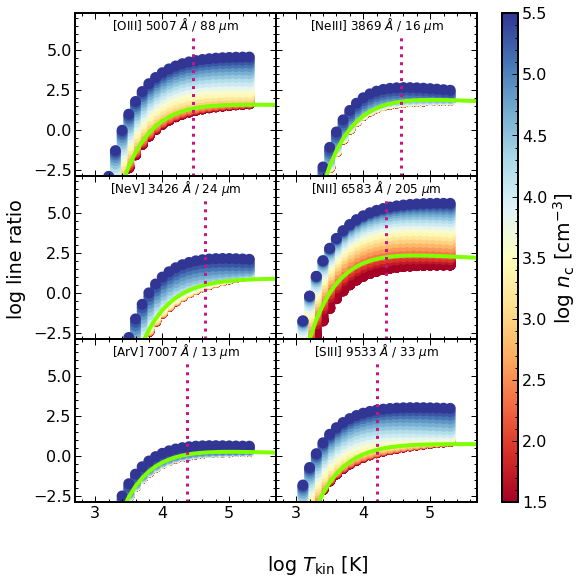

In [132]:
"""
Plot temperature diagnostics
"""

tabout=ascii.read('temperature_diagnostics.dat',format='basic')

theta_o3=tabout['[OIII]']
theta_ne3=tabout['[NeIII]']
theta_ar5=tabout['[ArV]']
theta_ne5=tabout['[NeV]']
theta_n2=tabout['[NII]']
theta_s3=tabout['[SIII]']

rr=np.arange(-1.,6.,0.1)

# grid spacing
lTE_in0=np.linspace(2.7,5.3,27,dtype='float')
lnE_in0=np.linspace(-1.2,5.5,33,dtype='float')

lTN_in0=np.linspace(1.3,4.1,29,dtype='float')
lnN_in0=np.linspace(1.0,7.0,32,dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)


O3_Lum10=tab_pop_fracE['O3_PF'][:,1]*hplanck*tab_nuE['O3_nu'][0]*tab_AE['O3_A'][0]
O3_Lum21=tab_pop_fracE['O3_PF'][:,2]*hplanck*tab_nuE['O3_nu'][4]*tab_AE['O3_A'][4]
O3_Lum32=tab_pop_fracE['O3_PF'][:,3]*hplanck*tab_nuE['O3_nu'][7]*tab_AE['O3_A'][7]
O3_Lum43=tab_pop_fracE['O3_PF'][:,4]*hplanck*tab_nuE['O3_nu'][9]*tab_AE['O3_A'][9]
O3_E1=(tab_nuE['O3_nu'][0])*hplanck/kboltz
O3_E2=(tab_nuE['O3_nu'][1])*hplanck/kboltz
O3_E3=(tab_nuE['O3_nu'][2])*hplanck/kboltz
O3_E4=(tab_nuE['O3_nu'][3])*hplanck/kboltz

O3_ratio1=O3_Lum43/O3_Lum32
O3_ratio2=O3_Lum32/O3_Lum10
O3_lratio1=np.log10(O3_ratio1)
O3_lratio2=np.log10(O3_ratio2)
O3_fit=modelf(theta_o3,rr)


N2_Lum10=tab_pop_fracE['N2_PF'][:,1]*hplanck*tab_nuE['N2_nu'][0]*tab_AE['N2_A'][0]
N2_Lum21=tab_pop_fracE['N2_PF'][:,2]*hplanck*tab_nuE['N2_nu'][4]*tab_AE['N2_A'][4]
N2_Lum32=tab_pop_fracE['N2_PF'][:,3]*hplanck*tab_nuE['N2_nu'][7]*tab_AE['N2_A'][7]
N2_Lum43=tab_pop_fracE['N2_PF'][:,4]*hplanck*tab_nuE['N2_nu'][9]*tab_AE['N2_A'][9]
N2_E1=(tab_nuE['N2_nu'][0])*hplanck/kboltz
N2_E2=(tab_nuE['N2_nu'][1])*hplanck/kboltz
N2_E3=(tab_nuE['N2_nu'][2])*hplanck/kboltz
N2_E4=(tab_nuE['N2_nu'][3])*hplanck/kboltz

N2_ratio1=N2_Lum43/N2_Lum32
N2_ratio2=N2_Lum32/N2_Lum10
N2_lratio1=np.log10(N2_ratio1)
N2_lratio2=np.log10(N2_ratio2)
N2_fit=modelf(theta_n2,rr)


Ar5_Lum10=tab_pop_fracE['Ar5_PF'][:,1]*hplanck*tab_nuE['Ar5_nu'][0]*tab_AE['Ar5_A'][0]
Ar5_Lum21=tab_pop_fracE['Ar5_PF'][:,2]*hplanck*tab_nuE['Ar5_nu'][4]*tab_AE['Ar5_A'][4]
Ar5_Lum32=tab_pop_fracE['Ar5_PF'][:,3]*hplanck*tab_nuE['Ar5_nu'][7]*tab_AE['Ar5_A'][7]
Ar5_Lum43=tab_pop_fracE['Ar5_PF'][:,4]*hplanck*tab_nuE['Ar5_nu'][9]*tab_AE['Ar5_A'][9]
Ar5_E1=(tab_nuE['Ar5_nu'][0])*hplanck/kboltz
Ar5_E2=(tab_nuE['Ar5_nu'][1])*hplanck/kboltz
Ar5_E3=(tab_nuE['Ar5_nu'][2])*hplanck/kboltz
Ar5_E4=(tab_nuE['Ar5_nu'][3])*hplanck/kboltz
Ar5_ratio1=Ar5_Lum43/Ar5_Lum32
Ar5_ratio2=Ar5_Lum32/Ar5_Lum10
Ar5_lratio1=np.log10(Ar5_ratio1)
Ar5_lratio2=np.log10(Ar5_ratio2)
Ar5_fit=modelf(theta_ar5,rr)


O1_Lum10=tab_pop_fracN['O1_PF'][:,1]*hplanck*tab_nuN['O1_nu'][0]*tab_AN['O1_A'][0]
O1_Lum21=tab_pop_fracN['O1_PF'][:,2]*hplanck*tab_nuN['O1_nu'][4]*tab_AN['O1_A'][4]
O1_Lum32=tab_pop_fracN['O1_PF'][:,3]*hplanck*tab_nuN['O1_nu'][7]*tab_AN['O1_A'][7]
O1_Lum43=tab_pop_fracN['O1_PF'][:,4]*hplanck*tab_nuN['O1_nu'][9]*tab_AN['O1_A'][9]
O1_E1=(tab_nuN['O1_nu'][0])*hplanck/kboltz
O1_E2=(tab_nuN['O1_nu'][1])*hplanck/kboltz
O1_E3=(tab_nuN['O1_nu'][2])*hplanck/kboltz
O1_E4=(tab_nuN['O1_nu'][3])*hplanck/kboltz
O1_ratio1=O1_Lum43/O1_Lum32
O1_ratio2=O1_Lum32/O1_Lum21
O1_lratio1=np.log10(O1_ratio1)
O1_lratio2=np.log10(O1_ratio2)


C1_Lum10=tab_pop_fracN['C1_PF'][:,1]*hplanck*tab_nuN['C1_nu'][0]*tab_AN['C1_A'][0]
C1_Lum21=tab_pop_fracN['C1_PF'][:,2]*hplanck*tab_nuN['C1_nu'][4]*tab_AN['C1_A'][4]
C1_Lum32=tab_pop_fracN['C1_PF'][:,3]*hplanck*tab_nuN['C1_nu'][7]*tab_AN['C1_A'][7]
C1_Lum43=tab_pop_fracN['C1_PF'][:,4]*hplanck*tab_nuN['C1_nu'][9]*tab_AN['C1_A'][9]
C1_E1=(tab_nuN['C1_nu'][0])*hplanck/kboltz
C1_E2=(tab_nuN['C1_nu'][1])*hplanck/kboltz
C1_E3=(tab_nuN['C1_nu'][2])*hplanck/kboltz
C1_E4=(tab_nuN['C1_nu'][3])*hplanck/kboltz
C1_ratio1=C1_Lum43/C1_Lum32
C1_ratio2=C1_Lum32/C1_Lum21
C1_lratio1=np.log10(C1_ratio1)
C1_lratio2=np.log10(C1_ratio2)


Ne3_Lum10=tab_pop_fracE['Ne3_PF'][:,1]*hplanck*tab_nuE['Ne3_nu'][0]*tab_AE['Ne3_A'][0]
Ne3_Lum21=tab_pop_fracE['Ne3_PF'][:,2]*hplanck*tab_nuE['Ne3_nu'][4]*tab_AE['Ne3_A'][4]
Ne3_Lum32=tab_pop_fracE['Ne3_PF'][:,3]*hplanck*tab_nuE['Ne3_nu'][7]*tab_AE['Ne3_A'][7]
Ne3_Lum43=tab_pop_fracE['Ne3_PF'][:,4]*hplanck*tab_nuE['Ne3_nu'][9]*tab_AE['Ne3_A'][9]
Ne3_E1=(tab_nuE['Ne3_nu'][0])*hplanck/kboltz
Ne3_E2=(tab_nuE['Ne3_nu'][1])*hplanck/kboltz
Ne3_E3=(tab_nuE['Ne3_nu'][2])*hplanck/kboltz
Ne3_E4=(tab_nuE['Ne3_nu'][3])*hplanck/kboltz
Ne3_ratio1=Ne3_Lum43/Ne3_Lum32
Ne3_ratio2=Ne3_Lum32/Ne3_Lum21
Ne3_lratio1=np.log10(Ne3_ratio1)
Ne3_lratio2=np.log10(Ne3_ratio2)
Ne3_fit=modelf(theta_ne3,rr)


Ne5_Lum10=tab_pop_fracE['Ne5_PF'][:,1]*hplanck*tab_nuE['Ne5_nu'][0]*tab_AE['Ne5_A'][0]
Ne5_Lum21=tab_pop_fracE['Ne5_PF'][:,2]*hplanck*tab_nuE['Ne5_nu'][4]*tab_AE['Ne5_A'][4]
Ne5_Lum32=tab_pop_fracE['Ne5_PF'][:,3]*hplanck*tab_nuE['Ne5_nu'][7]*tab_AE['Ne5_A'][7]
Ne5_Lum43=tab_pop_fracE['Ne5_PF'][:,4]*hplanck*tab_nuE['Ne5_nu'][9]*tab_AE['Ne5_A'][9]
Ne5_E1=(tab_nuE['Ne5_nu'][0])*hplanck/kboltz
Ne5_E2=(tab_nuE['Ne5_nu'][1])*hplanck/kboltz
Ne5_E3=(tab_nuE['Ne5_nu'][2])*hplanck/kboltz
Ne5_E4=(tab_nuE['Ne5_nu'][3])*hplanck/kboltz
Ne5_ratio1=Ne5_Lum43/Ne5_Lum32
Ne5_ratio2=Ne5_Lum32/Ne5_Lum10
Ne5_lratio1=np.log10(Ne5_ratio1)
Ne5_lratio2=np.log10(Ne5_ratio2)
Ne5_fit=modelf(theta_ne5,rr)


S3_Lum10=tab_pop_fracE['S3_PF'][:,1]*hplanck*tab_nuE['S3_nu'][0]*tab_AE['S3_A'][0]
S3_Lum21=tab_pop_fracE['S3_PF'][:,2]*hplanck*tab_nuE['S3_nu'][4]*tab_AE['S3_A'][4]
S3_Lum32=tab_pop_fracE['S3_PF'][:,3]*hplanck*tab_nuE['S3_nu'][7]*tab_AE['S3_A'][7]
S3_Lum43=tab_pop_fracE['S3_PF'][:,4]*hplanck*tab_nuE['S3_nu'][9]*tab_AE['S3_A'][9]
S3_E1=(tab_nuE['S3_nu'][0])*hplanck/kboltz
S3_E2=(tab_nuE['S3_nu'][1])*hplanck/kboltz
S3_E3=(tab_nuE['S3_nu'][2])*hplanck/kboltz
S3_E4=(tab_nuE['S3_nu'][3])*hplanck/kboltz
S3_ratio1=S3_Lum43/S3_Lum32
S3_ratio2=S3_Lum32/S3_Lum10
S3_lratio1=np.log10(S3_ratio1)
S3_lratio2=np.log10(S3_ratio2)
S3_fit=modelf(theta_s3,rr)





nicePlot()
xmin=2.7
xmax=5.7
ymin=-2.9
ymax=7.3


fig, axs = plt.subplots(3, 2, figsize=(9,9), 
                        sharex=True, sharey=True, squeeze=True,
                        gridspec_kw=dict(wspace=0,hspace=0))

pcm=axs[0,0].scatter(lT_ln_inE[:,1],O3_lratio2,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,0].set_xlim(xmin,xmax)
axs[0,0].set_ylim(ymin,ymax)
axs[0,0].plot(rr,O3_fit,c='chartreuse',linewidth=4)
axs[0,0].plot((np.log10(O3_E3),np.log10(O3_E3)),(ymin,ymax-1.4),c='mediumvioletred',linestyle='dotted')
axs[0,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[OIII] 5007 $\AA$ / 88 $\mu$m',ha='center',fontsize=12)

axs[0,1].scatter(lT_ln_inE[:,1],Ne3_lratio2,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,1].plot(rr,Ne3_fit,c='chartreuse',linewidth=4)
axs[0,1].plot((np.log10(Ne3_E3),np.log10(Ne3_E3)),(ymin,ymax-1.4),c='mediumvioletred',linestyle='dotted')
axs[0,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeIII] 3869 $\AA$ / 16 $\mu$m',ha='center',fontsize=12)

axs[1,0].scatter(lT_ln_inE[:,1],Ne5_lratio2,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,0].plot(rr,Ne5_fit,c='chartreuse',linewidth=4)
axs[1,0].plot((np.log10(Ne5_E3),np.log10(Ne5_E3)),(ymin,ymax-1.4),c='mediumvioletred',linestyle='dotted')
axs[1,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeV] 3426 $\AA$ / 24 $\mu$m',ha='center',fontsize=12)

axs[1,1].scatter(lT_ln_inE[:,1],N2_lratio2,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,1].plot(rr,N2_fit,c='chartreuse',linewidth=4)
axs[1,1].plot((np.log10(N2_E3),np.log10(N2_E3)),(ymin,ymax-1.4),c='mediumvioletred',linestyle='dotted')
axs[1,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NII] 6583 $\AA$ / 205 $\mu$m',ha='center',fontsize=12)

axs[2,0].scatter(lT_ln_inE[:,1],Ar5_lratio2,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[2,0].plot(rr,Ar5_fit,c='chartreuse',linewidth=4)
axs[2,0].plot((np.log10(Ar5_E3),np.log10(Ar5_E3)),(ymin,ymax-1.4),c='mediumvioletred',linestyle='dotted')
axs[2,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[ArV] 7007 $\AA$ / 13 $\mu$m',ha='center',fontsize=12)

axs[2,1].scatter(lT_ln_inE[:,1],S3_lratio2,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[2,1].plot(rr,S3_fit,c='chartreuse',linewidth=4)
axs[2,1].plot((np.log10(S3_E3),np.log10(S3_E3)),(ymin,ymax-1.4),c='mediumvioletred',linestyle='dotted')
axs[2,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[SIII] 9533 $\AA$ / 33 $\mu$m',ha='center',fontsize=12)





fig.supxlabel(r'log $T_{\rm kin}$ [K]')
fig.supylabel(r'log line ratio')

fig.colorbar(pcm,ax=axs,aspect=30,label=r'log $n_{\rm c}$ [cm$^{-3}$]')
fig.show()
fig.savefig('figures/fig_T_diagnostics.png',dpi=400,format='png', bbox_inches='tight')




/tmp/ipykernel_83422/782143433.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_83422/782143433.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_83422/782143433.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_83422/782143433.py:272: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_83422/782143433.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[5]+(1

[88.356    0.50069  0.43632]
nicePlot: Setting rcParams


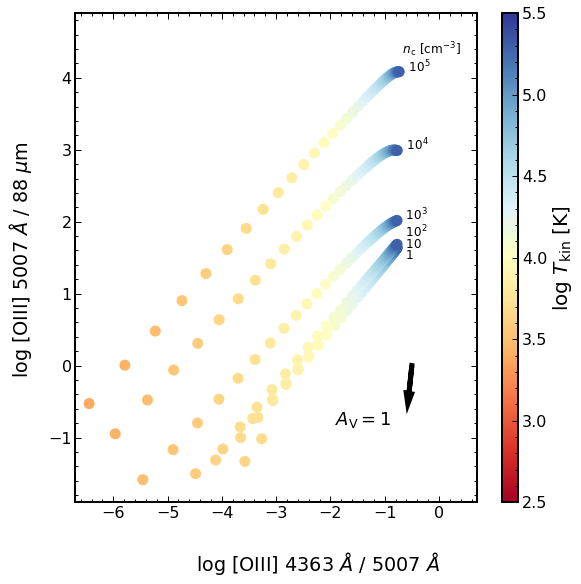

In [16]:
"""
Plot temperature diagnostics
"""

tabout=ascii.read('temperature_diagnostics.dat',format='basic')

theta_o3=tabout['[OIII]']




# grid spacing
lTE_in0=np.linspace(2.7,5.3,54,dtype='float')
lnE_in0=np.linspace(0.,5.,6,dtype='float')

lTN_in0=np.linspace(1.3,2.1,2,dtype='float')
lnN_in0=np.linspace(1.0,3.0,2,dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)

nn=np.array([tab_nuE['O3_nu'][0], tab_nuE['O3_nu'][7], tab_nuE['O3_nu'][9]])
ll=clight/(nn*1.e-9)
NH=1.4e21 # cm-2
print(ll)

ext=extinction_law_WD(ll,NH)

O3_Lum10=tab_pop_fracE['O3_PF'][:,1]*hplanck*tab_nuE['O3_nu'][0]*tab_AE['O3_A'][0]
O3_Lum21=tab_pop_fracE['O3_PF'][:,2]*hplanck*tab_nuE['O3_nu'][4]*tab_AE['O3_A'][4]
O3_Lum32=tab_pop_fracE['O3_PF'][:,3]*hplanck*tab_nuE['O3_nu'][7]*tab_AE['O3_A'][7]
O3_Lum43=tab_pop_fracE['O3_PF'][:,4]*hplanck*tab_nuE['O3_nu'][9]*tab_AE['O3_A'][9]
O3_E1=(tab_nuE['O3_nu'][0])*hplanck/kboltz
O3_E2=(tab_nuE['O3_nu'][1])*hplanck/kboltz
O3_E3=(tab_nuE['O3_nu'][2])*hplanck/kboltz
O3_E4=(tab_nuE['O3_nu'][3])*hplanck/kboltz

O3_ratio1=O3_Lum43/O3_Lum32
O3_ratio2=O3_Lum32/O3_Lum10
O3_lratio1=np.log10(O3_ratio1)
O3_lratio2=np.log10(O3_ratio2)


nicePlot()
xmin=-6.7
xmax=0.7
ymin=-1.9
ymax=4.9


fig, axs = plt.subplots(1, 1, figsize=(9,9), 
                        sharex=True, sharey=True, squeeze=True,
                        gridspec_kw=dict(wspace=0,hspace=0))

pcm=axs.scatter(O3_lratio1,O3_lratio2,c=lT_ln_inE[:,1],cmap='RdYlBu',vmin=2.5,vmax=5.5)
axs.set_xlim(xmin,xmax)
axs.set_ylim(ymin,ymax)
axs.text(O3_lratio1[6*54-1],O3_lratio2[6*54-1]+0.25,r' $n_{\rm c}$ [cm$^{-3}$]',ha='left',fontsize=12)
axs.text(O3_lratio1[1*54-1]+0.1,O3_lratio2[1*54-1]-0.15,r' $1$',ha='left',fontsize=12)
axs.text(O3_lratio1[2*54-1]+0.1,O3_lratio2[2*54-1],r' $10$',ha='left',fontsize=12)
axs.text(O3_lratio1[3*54-1]+0.1,O3_lratio2[3*54-1]+0.1,r' $10^2$',ha='left',fontsize=12)
axs.text(O3_lratio1[4*54-1]+0.1,O3_lratio2[4*54-1],r' $10^3$',ha='left',fontsize=12)
axs.text(O3_lratio1[5*54-1]+0.1,O3_lratio2[5*54-1],r' $10^4$',ha='left',fontsize=12)
axs.text(O3_lratio1[6*54-1]+0.1,O3_lratio2[6*54-1],r' $10^5$',ha='left',fontsize=12)

axs.arrow(-0.5,0,np.log10(ext[2]/ext[1]),np.log10(ext[1]/ext[0]),head_width=0.1)
axs.text(-1.4,-0.82,r'$A_{\rm V}=1$',ha='center',fontsize=18,rotation=0)


fig.supxlabel(r'log [OIII] 4363 $\AA$ / 5007 $\AA$')
fig.supylabel(r'log [OIII] 5007 $\AA$ / 88 $\mu$m')

fig.colorbar(pcm,ax=axs,aspect=30,label=r'log $T_{\rm kin}$ [K]')
fig.show()
fig.savefig('figures/fig_T_opt_fir_diagnostics.png',dpi=400,format='png', bbox_inches='tight')



/tmp/ipykernel_41925/782143433.py:157: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_41925/782143433.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_41925/782143433.py:159: RuntimeWarning: divide by zero encountered in double_scalars
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_41925/782143433.py:272: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_41925/782143433.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[5]+(1

nicePlot: Setting rcParams


/tmp/ipykernel_41925/2509217192.py:230: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


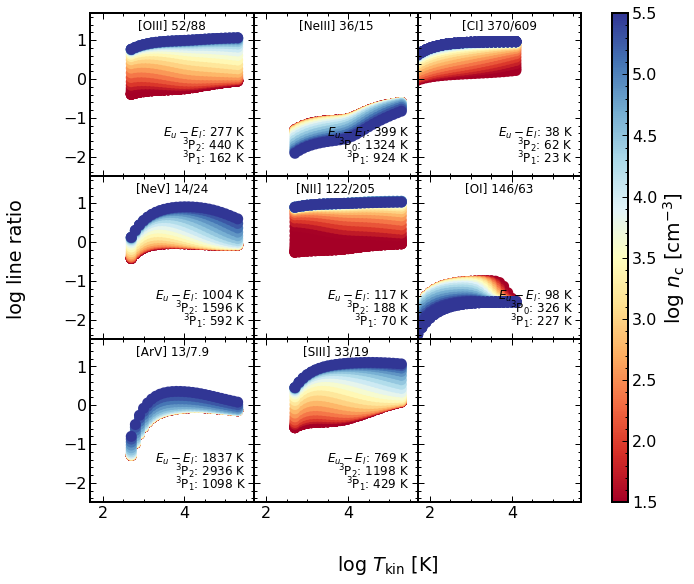

In [110]:
"""
Plot density diagnostics
"""

rr=np.arange(-1.,6.,0.1)

tabout=ascii.read('density_diagnostics.dat', format='basic')
theta_o3=tabout['[OIII]']
theta_ne3=tabout['[NeIII]']
theta_ar5=tabout['[ArV]']
theta_ne5=tabout['[NeV]']
theta_n2=tabout['[NII]']
theta_s3=tabout['[SIII]']
theta_c1=tabout['[CI]']
theta_o1=tabout['[OI]']

# grid spacing
lTE_in0=np.linspace(2.7,5.3,27,dtype='float')
lnE_in0=np.linspace(-1.2,5.5,33,dtype='float')

lTN_in0=np.linspace(1.3,4.1,29,dtype='float')
lnN_in0=np.linspace(1.0,7.0,32,dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)
ref_ncritE=np.copy(tab_ncritE)
ref_ncritN=np.copy(tab_ncritN)


O3_Lum10=tab_pop_fracE['O3_PF'][:,1]*hplanck*tab_nuE['O3_nu'][0]*tab_AE['O3_A'][0]
O3_Lum21=tab_pop_fracE['O3_PF'][:,2]*hplanck*tab_nuE['O3_nu'][4]*tab_AE['O3_A'][4]
O3_nc1=ref_ncritE['O3_ncrit'][:,0]
O3_nc2=ref_ncritE['O3_ncrit'][:,1]
O3_E1=(tab_nuE['O3_nu'][0])*hplanck/kboltz
O3_E2=(tab_nuE['O3_nu'][1])*hplanck/kboltz
O3_ratio=O3_Lum21/O3_Lum10
O3_lratio=np.log10(O3_ratio)


N2_Lum10=tab_pop_fracE['N2_PF'][:,1]*hplanck*tab_nuE['N2_nu'][0]*tab_AE['N2_A'][0]
N2_Lum21=tab_pop_fracE['N2_PF'][:,2]*hplanck*tab_nuE['N2_nu'][4]*tab_AE['N2_A'][4]
N2_nc1=ref_ncritE['N2_ncrit'][:,0]
N2_nc2=ref_ncritE['N2_ncrit'][:,1]
N2_E1=(tab_nuE['N2_nu'][0])*hplanck/kboltz
N2_E2=(tab_nuE['N2_nu'][1])*hplanck/kboltz
N2_ratio=N2_Lum21/N2_Lum10
N2_lratio=np.log10(N2_ratio)


Ar5_Lum10=tab_pop_fracE['Ar5_PF'][:,1]*hplanck*tab_nuE['Ar5_nu'][0]*tab_AE['Ar5_A'][0]
Ar5_Lum21=tab_pop_fracE['Ar5_PF'][:,2]*hplanck*tab_nuE['Ar5_nu'][4]*tab_AE['Ar5_A'][4]
Ar5_nc1=ref_ncritE['Ar5_ncrit'][:,0]
Ar5_nc2=ref_ncritE['Ar5_ncrit'][:,1]
Ar5_E1=(tab_nuE['Ar5_nu'][0])*hplanck/kboltz
Ar5_E2=(tab_nuE['Ar5_nu'][1])*hplanck/kboltz
Ar5_ratio=Ar5_Lum21/Ar5_Lum10
Ar5_lratio=np.log10(Ar5_ratio)


O1_Lum10=tab_pop_fracN['O1_PF'][:,1]*hplanck*tab_nuN['O1_nu'][0]*tab_AN['O1_A'][0]
O1_Lum21=tab_pop_fracN['O1_PF'][:,2]*hplanck*tab_nuN['O1_nu'][4]*tab_AN['O1_A'][4]
O1_nc1=ref_ncritN['O1_ncrit'][:,0]
O1_nc2=ref_ncritN['O1_ncrit'][:,1]
O1_E1=(tab_nuN['O1_nu'][0])*hplanck/kboltz
O1_E2=(tab_nuN['O1_nu'][1])*hplanck/kboltz
O1_ratio=O1_Lum21/O1_Lum10
O1_lratio=np.log10(O1_ratio)

C1_Lum10=tab_pop_fracN['C1_PF'][:,1]*hplanck*tab_nuN['C1_nu'][0]*tab_AN['C1_A'][0]
C1_Lum21=tab_pop_fracN['C1_PF'][:,2]*hplanck*tab_nuN['C1_nu'][4]*tab_AN['C1_A'][4]
C1_nc1=ref_ncritN['C1_ncrit'][:,0]
C1_nc2=ref_ncritN['C1_ncrit'][:,1]
C1_E1=(tab_nuN['C1_nu'][0])*hplanck/kboltz
C1_E2=(tab_nuN['C1_nu'][1])*hplanck/kboltz
C1_ratio=C1_Lum21/C1_Lum10
C1_lratio=np.log10(C1_ratio)


Ne3_Lum10=tab_pop_fracE['Ne3_PF'][:,1]*hplanck*tab_nuE['Ne3_nu'][0]*tab_AE['Ne3_A'][0]
Ne3_Lum21=tab_pop_fracE['Ne3_PF'][:,2]*hplanck*tab_nuE['Ne3_nu'][4]*tab_AE['Ne3_A'][4]
Ne3_nc1=ref_ncritE['Ne3_ncrit'][:,0]
Ne3_nc2=ref_ncritE['Ne3_ncrit'][:,1]
Ne3_E1=(tab_nuE['Ne3_nu'][0])*hplanck/kboltz
Ne3_E2=(tab_nuE['Ne3_nu'][1])*hplanck/kboltz
Ne3_ratio=Ne3_Lum21/Ne3_Lum10
Ne3_lratio=np.log10(Ne3_ratio)


Ne5_Lum10=tab_pop_fracE['Ne5_PF'][:,1]*hplanck*tab_nuE['Ne5_nu'][0]*tab_AE['Ne5_A'][0]
Ne5_Lum21=tab_pop_fracE['Ne5_PF'][:,2]*hplanck*tab_nuE['Ne5_nu'][4]*tab_AE['Ne5_A'][4]
Ne5_nc1=ref_ncritE['Ne5_ncrit'][:,0]
Ne5_nc2=ref_ncritE['Ne5_ncrit'][:,1]
Ne5_E1=(tab_nuE['Ne5_nu'][0])*hplanck/kboltz
Ne5_E2=(tab_nuE['Ne5_nu'][1])*hplanck/kboltz
Ne5_ratio=Ne5_Lum21/Ne5_Lum10
Ne5_lratio=np.log10(Ne5_ratio)


S3_Lum10=tab_pop_fracE['S3_PF'][:,1]*hplanck*tab_nuE['S3_nu'][0]*tab_AE['S3_A'][0]
S3_Lum21=tab_pop_fracE['S3_PF'][:,2]*hplanck*tab_nuE['S3_nu'][4]*tab_AE['S3_A'][4]
S3_nc1=ref_ncritE['S3_ncrit'][:,0]
S3_nc2=ref_ncritE['S3_ncrit'][:,1]
S3_E1=(tab_nuE['S3_nu'][0])*hplanck/kboltz
S3_E2=(tab_nuE['S3_nu'][1])*hplanck/kboltz
S3_ratio=S3_Lum21/S3_Lum10
S3_lratio=np.log10(S3_ratio)





nicePlot()

xmin=1.7
xmax=5.7
ymin=-2.5
ymax=1.7


fig, axs = plt.subplots(3, 3, figsize=(11,9), 
                        sharex=True, sharey=True, squeeze=True,
                        gridspec_kw=dict(wspace=0,hspace=0))

pcm=axs[0,0].scatter(lT_ln_inE[:,1],O3_lratio,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,0].set_xlim(xmin,xmax)
axs[0,0].set_ylim(ymin,ymax)
axs[0,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[OIII] 52/88',ha='center',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(O3_E1)),ha='right',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(O3_E2)),ha='right',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(O3_E2-O3_E1)),ha='right',fontsize=12)

axs[0,1].scatter(lT_ln_inE[:,1],Ne3_lratio,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeIII] 36/15',ha='center',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ne3_E1)),ha='right',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_0$: {} K'.format(int(Ne3_E2)),ha='right',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ne3_E2-Ne3_E1)),ha='right',fontsize=12)

axs[0,2].scatter(lT_ln_inN[:,1],C1_lratio,c=lT_ln_inN[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,2].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[CI] 370/609',ha='center',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(C1_E1)),ha='right',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(C1_E2)),ha='right',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(C1_E2-C1_E1)),ha='right',fontsize=12)

axs[1,0].scatter(lT_ln_inE[:,1],Ne5_lratio,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeV] 14/24',ha='center',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ne5_E1)),ha='right',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(Ne5_E2)),ha='right',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ne5_E2-Ne5_E1)),ha='right',fontsize=12)

axs[1,1].scatter(lT_ln_inE[:,1],N2_lratio,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NII] 122/205',ha='center',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(N2_E1)),ha='right',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(N2_E2)),ha='right',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(N2_E2-N2_E1)),ha='right',fontsize=12)

axs[1,2].scatter(lT_ln_inN[:,1],O1_lratio,c=lT_ln_inN[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,2].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[OI] 146/63',ha='center',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(O1_E1)),ha='right',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_0$: {} K'.format(int(O1_E2)),ha='right',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(O1_E2-O1_E1)),ha='right',fontsize=12)

axs[2,0].scatter(lT_ln_inE[:,1],Ar5_lratio,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[2,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[ArV] 13/7.9',ha='center',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ar5_E1)),ha='right',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(Ar5_E2)),ha='right',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ar5_E2-Ar5_E1)),ha='right',fontsize=12)

axs[2,1].scatter(lT_ln_inE[:,1],S3_lratio,c=lT_ln_inE[:,0],cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[2,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[SIII] 33/19',ha='center',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(S3_E1)),ha='right',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(S3_E2)),ha='right',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(S3_E2-S3_E1)),ha='right',fontsize=12)









fig.supxlabel(r'log $T_{\rm kin}$ [K]')
fig.supylabel(r'log line ratio')

fig.colorbar(pcm,ax=axs,aspect=30,label=r'log $n_{\rm c}$ [cm$^{-3}$]')
fig.show()
fig.savefig('figures/fig_Tratio.png',dpi=400,format='png', bbox_inches='tight')



nicePlot: Setting rcParams


/tmp/ipykernel_1754841/2811648860.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


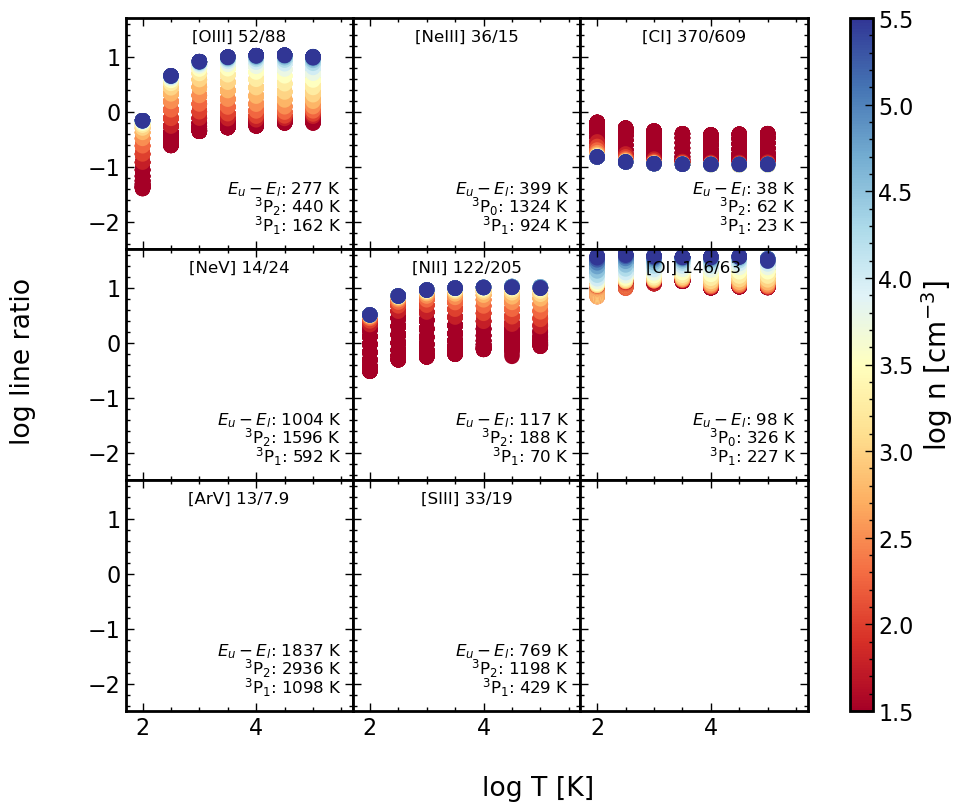

In [19]:
"""
Plot density diagnostics a la Cloudy
"""

rr=np.arange(-1.,6.,0.1)

tcloudy=ascii.read('ionized_grid_nT.out', format='basic')

# grid spacing
lTE0=tcloudy['lgT']
lnE0=tcloudy['lgn']
lnZ0=tcloudy['lgZ']


O3_lratio=tcloudy['F_o3_21']-tcloudy['F_o3_10']
N2_lratio=tcloudy['F_n2_21']-tcloudy['F_n2_10']
O1_lratio=tcloudy['F_o1_21']-tcloudy['F_o1_10']
C1_lratio=tcloudy['F_c1_21']-tcloudy['F_c1_10']



nicePlot()
xmin=1.7
xmax=5.7
ymin=-2.5
ymax=1.7


fig, axs = plt.subplots(3, 3, figsize=(11,9), 
                        sharex=True, sharey=True, squeeze=True,
                        gridspec_kw=dict(wspace=0,hspace=0))

pcm=axs[0,0].scatter(lTE0,O3_lratio,c=lnE0,cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,0].set_xlim(xmin,xmax)
axs[0,0].set_ylim(ymin,ymax)
axs[0,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[OIII] 52/88',ha='center',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(O3_E1)),ha='right',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(O3_E2)),ha='right',fontsize=12)
axs[0,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(O3_E2-O3_E1)),ha='right',fontsize=12)

axs[0,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeIII] 36/15',ha='center',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ne3_E1)),ha='right',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_0$: {} K'.format(int(Ne3_E2)),ha='right',fontsize=12)
axs[0,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ne3_E2-Ne3_E1)),ha='right',fontsize=12)

axs[0,2].scatter(lTE0,C1_lratio,c=lnE0,cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[0,2].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[CI] 370/609',ha='center',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(C1_E1)),ha='right',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(C1_E2)),ha='right',fontsize=12)
axs[0,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(C1_E2-C1_E1)),ha='right',fontsize=12)

axs[1,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NeV] 14/24',ha='center',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ne5_E1)),ha='right',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(Ne5_E2)),ha='right',fontsize=12)
axs[1,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ne5_E2-Ne5_E1)),ha='right',fontsize=12)

axs[1,1].scatter(lTE0,N2_lratio,c=lnE0,cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[NII] 122/205',ha='center',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(N2_E1)),ha='right',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(N2_E2)),ha='right',fontsize=12)
axs[1,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(N2_E2-N2_E1)),ha='right',fontsize=12)

axs[1,2].scatter(lTE0,O1_lratio,c=lnE0,cmap='RdYlBu',vmin=1.5,vmax=5.5)
axs[1,2].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[OI] 146/63',ha='center',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(O1_E1)),ha='right',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_0$: {} K'.format(int(O1_E2)),ha='right',fontsize=12)
axs[1,2].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(O1_E2-O1_E1)),ha='right',fontsize=12)

axs[2,0].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[ArV] 13/7.9',ha='center',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(Ar5_E1)),ha='right',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(Ar5_E2)),ha='right',fontsize=12)
axs[2,0].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(Ar5_E2-Ar5_E1)),ha='right',fontsize=12)

axs[2,1].text((xmax+xmin)/2.,(ymax-ymin)*0.9+ymin,r'[SIII] 33/19',ha='center',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.08+ymin,r'$^3$P$_1$: {} K'.format(int(S3_E1)),ha='right',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.16+ymin,r'$^3$P$_2$: {} K'.format(int(S3_E2)),ha='right',fontsize=12)
axs[2,1].text((xmax-xmin)*0.95+xmin,(ymax-ymin)*0.24+ymin,r'$E_u-E_l$: {} K'.format(int(S3_E2-S3_E1)),ha='right',fontsize=12)






fig.supxlabel(r'log T [K]')
fig.supylabel(r'log line ratio')

fig.colorbar(pcm,ax=axs,aspect=30,label='log n [cm$^{-3}$]')
fig.show()
fig.savefig('figures/fig_Tratio_cloudy.png',dpi=400,format='png', bbox_inches='tight')



In [18]:
"""
Print out line ratios for the two cases of ionized and neutral gas, with 
 (n, Tkin)=(100 cm-3, 10000 K) and (n, Tkin)=(10000 cm-3, 100 K),
respectively
"""


# grid spacing
lTE_in0=np.array([4.],dtype='float')
lnE_in0=np.array([2.],dtype='float')

lTN_in0=np.array([2.],dtype='float')
lnN_in0=np.array([4.],dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)


C2_frac=np.array([tab_pop_fracE['C2_PF'][:,1],tab_pop_fracE['C2_PF'][:,2],tab_pop_fracE['C2_PF'][:,3],
                  tab_pop_fracE['C2_PF'][:,4],tab_pop_fracE['C2_PF'][:,2],tab_pop_fracE['C2_PF'][:,3],
                  tab_pop_fracE['C2_PF'][:,4],tab_pop_fracE['C2_PF'][:,3],tab_pop_fracE['C2_PF'][:,4],
                  tab_pop_fracE['C2_PF'][:,4]])
C2_LumE=C2_frac[:,0]*hplanck*tab_nuE['C2_nu']*tab_AE['C2_A']
C2_l=clight/tab_nuE['C2_nu']*1.e9


O3_frac=np.array([tab_pop_fracE['O3_PF'][:,1],tab_pop_fracE['O3_PF'][:,2],tab_pop_fracE['O3_PF'][:,3],
                  tab_pop_fracE['O3_PF'][:,4],tab_pop_fracE['O3_PF'][:,2],tab_pop_fracE['O3_PF'][:,3],
                  tab_pop_fracE['O3_PF'][:,4],tab_pop_fracE['O3_PF'][:,3],tab_pop_fracE['O3_PF'][:,4],
                  tab_pop_fracE['O3_PF'][:,4]])
O3_Lum=O3_frac[:,0]*hplanck*tab_nuE['O3_nu']*tab_AE['O3_A']
O3_l=clight/tab_nuE['O3_nu']*1.e9


N2_frac=np.array([tab_pop_fracE['N2_PF'][:,1],tab_pop_fracE['N2_PF'][:,2],tab_pop_fracE['N2_PF'][:,3],
                  tab_pop_fracE['N2_PF'][:,4],tab_pop_fracE['N2_PF'][:,2],tab_pop_fracE['N2_PF'][:,3],
                  tab_pop_fracE['N2_PF'][:,4],tab_pop_fracE['N2_PF'][:,3],tab_pop_fracE['N2_PF'][:,4],
                  tab_pop_fracE['N2_PF'][:,4]])
N2_Lum=N2_frac[:,0]*hplanck*tab_nuE['N2_nu']*tab_AE['N2_A']
N2_l=clight/tab_nuE['N2_nu']*1.e9


N3_frac=np.array([tab_pop_fracE['N3_PF'][:,1],tab_pop_fracE['N3_PF'][:,2],tab_pop_fracE['N3_PF'][:,3],
                  tab_pop_fracE['N3_PF'][:,4],tab_pop_fracE['N3_PF'][:,2],tab_pop_fracE['N3_PF'][:,3],
                  tab_pop_fracE['N3_PF'][:,4],tab_pop_fracE['N3_PF'][:,3],tab_pop_fracE['N3_PF'][:,4],
                  tab_pop_fracE['N3_PF'][:,4]])
N3_Lum=N3_frac[:,0]*hplanck*tab_nuE['N3_nu']*tab_AE['N3_A']
N3_l=clight/tab_nuE['N3_nu']*1.e9


Ar2_frac=np.array([tab_pop_fracE['Ar2_PF'][:,1],tab_pop_fracE['Ar2_PF'][:,2],tab_pop_fracE['Ar2_PF'][:,3],
                  tab_pop_fracE['Ar2_PF'][:,4],tab_pop_fracE['Ar2_PF'][:,2],tab_pop_fracE['Ar2_PF'][:,3],
                  tab_pop_fracE['Ar2_PF'][:,4],tab_pop_fracE['Ar2_PF'][:,3],tab_pop_fracE['Ar2_PF'][:,4],
                  tab_pop_fracE['Ar2_PF'][:,4]])
Ar2_Lum=Ar2_frac[:,0]*hplanck*tab_nuE['Ar2_nu']*tab_AE['Ar2_A']
Ar2_l=clight/tab_nuE['Ar2_nu']*1.e9


Ar3_frac=np.array([tab_pop_fracE['Ar3_PF'][:,1],tab_pop_fracE['Ar3_PF'][:,2],tab_pop_fracE['Ar3_PF'][:,3],
                  tab_pop_fracE['Ar3_PF'][:,4],tab_pop_fracE['Ar3_PF'][:,2],tab_pop_fracE['Ar3_PF'][:,3],
                  tab_pop_fracE['Ar3_PF'][:,4],tab_pop_fracE['Ar3_PF'][:,3],tab_pop_fracE['Ar3_PF'][:,4],
                  tab_pop_fracE['Ar3_PF'][:,4]])
Ar3_Lum=Ar3_frac[:,0]*hplanck*tab_nuE['Ar3_nu']*tab_AE['Ar3_A']
Ar3_l=clight/tab_nuE['Ar3_nu']*1.e9


Ar5_frac=np.array([tab_pop_fracE['Ar5_PF'][:,1],tab_pop_fracE['Ar5_PF'][:,2],tab_pop_fracE['Ar5_PF'][:,3],
                  tab_pop_fracE['Ar5_PF'][:,4],tab_pop_fracE['Ar5_PF'][:,2],tab_pop_fracE['Ar5_PF'][:,3],
                  tab_pop_fracE['Ar5_PF'][:,4],tab_pop_fracE['Ar5_PF'][:,3],tab_pop_fracE['Ar5_PF'][:,4],
                  tab_pop_fracE['Ar5_PF'][:,4]])
Ar5_Lum=Ar5_frac[:,0]*hplanck*tab_nuE['Ar5_nu']*tab_AE['Ar5_A']
Ar5_l=clight/tab_nuE['Ar5_nu']*1.e9


Ne2_frac=np.array([tab_pop_fracE['Ne2_PF'][:,1],tab_pop_fracE['Ne2_PF'][:,2],tab_pop_fracE['Ne2_PF'][:,3],
                  tab_pop_fracE['Ne2_PF'][:,4],tab_pop_fracE['Ne2_PF'][:,2],tab_pop_fracE['Ne2_PF'][:,3],
                  tab_pop_fracE['Ne2_PF'][:,4],tab_pop_fracE['Ne2_PF'][:,3],tab_pop_fracE['Ne2_PF'][:,4],
                  tab_pop_fracE['Ne2_PF'][:,4]])
Ne2_Lum=Ne2_frac[:,0]*hplanck*tab_nuE['Ne2_nu']*tab_AE['Ne2_A']
Ne2_l=clight/tab_nuE['Ne2_nu']*1.e9


Ne3_frac=np.array([tab_pop_fracE['Ne3_PF'][:,1],tab_pop_fracE['Ne3_PF'][:,2],tab_pop_fracE['Ne3_PF'][:,3],
                  tab_pop_fracE['Ne3_PF'][:,4],tab_pop_fracE['Ne3_PF'][:,2],tab_pop_fracE['Ne3_PF'][:,3],
                  tab_pop_fracE['Ne3_PF'][:,4],tab_pop_fracE['Ne3_PF'][:,3],tab_pop_fracE['Ne3_PF'][:,4],
                  tab_pop_fracE['Ne3_PF'][:,4]])
Ne3_Lum=Ne3_frac[:,0]*hplanck*tab_nuE['Ne3_nu']*tab_AE['Ne3_A']
Ne3_l=clight/tab_nuE['Ne3_nu']*1.e9


Ne5_frac=np.array([tab_pop_fracE['Ne5_PF'][:,1],tab_pop_fracE['Ne5_PF'][:,2],tab_pop_fracE['Ne5_PF'][:,3],
                  tab_pop_fracE['Ne5_PF'][:,4],tab_pop_fracE['Ne5_PF'][:,2],tab_pop_fracE['Ne5_PF'][:,3],
                  tab_pop_fracE['Ne5_PF'][:,4],tab_pop_fracE['Ne5_PF'][:,3],tab_pop_fracE['Ne5_PF'][:,4],
                  tab_pop_fracE['Ne5_PF'][:,4]])
Ne5_Lum=Ne5_frac[:,0]*hplanck*tab_nuE['Ne5_nu']*tab_AE['Ne5_A']
Ne5_l=clight/tab_nuE['Ne5_nu']*1.e9


S3_frac=np.array([tab_pop_fracE['S3_PF'][:,1],tab_pop_fracE['S3_PF'][:,2],tab_pop_fracE['S3_PF'][:,3],
                  tab_pop_fracE['S3_PF'][:,4],tab_pop_fracE['S3_PF'][:,2],tab_pop_fracE['S3_PF'][:,3],
                  tab_pop_fracE['S3_PF'][:,4],tab_pop_fracE['S3_PF'][:,3],tab_pop_fracE['S3_PF'][:,4],
                  tab_pop_fracE['S3_PF'][:,4]])
S3_Lum=S3_frac[:,0]*hplanck*tab_nuE['S3_nu']*tab_AE['S3_A']
S3_l=clight/tab_nuE['S3_nu']*1.e9




C2_fracN=np.array([tab_pop_fracN['C2_PF'][:,1],tab_pop_fracN['C2_PF'][:,2],tab_pop_fracN['C2_PF'][:,3],
                  tab_pop_fracN['C2_PF'][:,4],tab_pop_fracN['C2_PF'][:,2],tab_pop_fracN['C2_PF'][:,3],
                  tab_pop_fracN['C2_PF'][:,4],tab_pop_fracN['C2_PF'][:,3],tab_pop_fracN['C2_PF'][:,4],
                  tab_pop_fracN['C2_PF'][:,4]])
C2_LumN=C2_fracN[:,0]*hplanck*tab_nuN['C2_nu']*tab_AN['C2_A']
C2_l=clight/tab_nuN['C2_nu']*1.e9


C1_fracN=np.array([tab_pop_fracN['C1_PF'][:,1],tab_pop_fracN['C1_PF'][:,2],tab_pop_fracN['C1_PF'][:,3],
                  tab_pop_fracN['C1_PF'][:,4],tab_pop_fracN['C1_PF'][:,2],tab_pop_fracN['C1_PF'][:,3],
                  tab_pop_fracN['C1_PF'][:,4],tab_pop_fracN['C1_PF'][:,3],tab_pop_fracN['C1_PF'][:,4],
                  tab_pop_fracN['C1_PF'][:,4]])
C1_LumN=C1_fracN[:,0]*hplanck*tab_nuN['C1_nu']*tab_AN['C1_A']
C1_l=clight/tab_nuN['C1_nu']*1.e9


O1_fracN=np.array([tab_pop_fracN['O1_PF'][:,1],tab_pop_fracN['O1_PF'][:,2],tab_pop_fracN['O1_PF'][:,3],
                  tab_pop_fracN['O1_PF'][:,4],tab_pop_fracN['O1_PF'][:,2],tab_pop_fracN['O1_PF'][:,3],
                  tab_pop_fracN['O1_PF'][:,4],tab_pop_fracN['O1_PF'][:,3],tab_pop_fracN['O1_PF'][:,4],
                  tab_pop_fracN['O1_PF'][:,4]])
O1_LumN=O1_fracN[:,0]*hplanck*tab_nuN['O1_nu']*tab_AN['O1_A']
O1_l=clight/tab_nuN['O1_nu']*1.e9


Si2_fracN=np.array([tab_pop_fracN['Si2_PF'][:,1],tab_pop_fracN['Si2_PF'][:,2],tab_pop_fracN['Si2_PF'][:,3],
                  tab_pop_fracN['Si2_PF'][:,4],tab_pop_fracN['Si2_PF'][:,2],tab_pop_fracN['Si2_PF'][:,3],
                  tab_pop_fracN['Si2_PF'][:,4],tab_pop_fracN['Si2_PF'][:,3],tab_pop_fracN['Si2_PF'][:,4],
                  tab_pop_fracN['Si2_PF'][:,4]])
Si2_LumN=Si2_fracN[:,0]*hplanck*tab_nuN['Si2_nu']*tab_AN['Si2_A']
Si2_l=clight/tab_nuN['Si2_nu']*1.e9


linrat=Table()

lgOH,lgNH,lgCH,lgHeH=nicholls(1.)

Qsfr=ascii.read('Qage.out')
print(Qsfr['age'][54])
print(Qsfr['Oii'][70]-Qsfr['Oii'][115])
print(Qsfr['Ci'][70]-Qsfr['Ci'][115])
print(Qsfr['Oii'][70]-Qsfr['Ci'][70])

# Qsfr[115] --> 100 Myr
# Qsfr[69] --> 10 Myr
# Qsfr[54] --> 5 Myr
linrat['l_C2']=C2_l
linrat['C2E']=np.where(C2_LumE>0,C2_LumE/C2_LumE[0],0)
linrat['C2N']=np.where(C2_LumN>0,C2_LumN/C2_LumN[0],0)
linrat['l_N2']=N2_l
linrat['N2']=np.where(N2_Lum>0,N2_Lum/C2_LumE[0]*np.power(10.,lgNH-lgCH+Qsfr['Ni'][54]-Qsfr['Ci'][54]),0)
linrat['l_N3']=N3_l
linrat['N3']=np.where(N3_Lum>0,N3_Lum/C2_LumE[0]*np.power(10.,lgNH-lgCH+Qsfr['Nii'][54]-Qsfr['Ci'][54]),0)
linrat['l_O3']=O3_l
linrat['O3']=np.where(O3_Lum>0,O3_Lum/C2_LumE[0]*np.power(10.,lgOH-lgCH+Qsfr['Oii'][54]-Qsfr['Ci'][54]),0)
linrat['l_Ne2']=Ne2_l
linrat['Ne2']=np.where(Ne2_Lum>0,Ne2_Lum/C2_LumE[0]*np.power(10.,1.15-5.-lgCH+Qsfr['Nei'][54]-Qsfr['Ci'][54]),0) # Ne/H from Pagomenos+18
linrat['l_Ne3']=Ne3_l
linrat['Ne3']=np.where(Ne3_Lum>0,Ne3_Lum/C2_LumE[0]*np.power(10.,1.15-5.-lgCH+Qsfr['Neii'][54]-Qsfr['Ci'][54]),0) # Ne/H from Pagomenos+18
linrat['l_Ne5']=Ne5_l
linrat['Ne5']=np.where(Ne5_Lum>0,Ne5_Lum/C2_LumE[0]*np.power(10.,1.15-5.-lgCH+Qsfr['Neiv'][54]-Qsfr['Ci'][54]),0) # Ne/H from Pagomenos+18
linrat['l_Ar2']=Ar2_l
linrat['Ar2']=np.where(Ar2_Lum>0,Ar2_Lum/C2_LumE[0]*np.power(10.,1.70-7.-lgCH+Qsfr['Ari'][54]-Qsfr['Ci'][54]),0) # Ar/H from Pagomenos+18
linrat['l_Ar3']=Ar3_l
linrat['Ar3']=np.where(Ar3_Lum>0,Ar3_Lum/C2_LumE[0]*np.power(10.,1.70-7.-lgCH+Qsfr['Arii'][54]-Qsfr['Ci'][54]),0) # Ar/H from Pagomenos+18
linrat['l_Ar5']=Ar5_l
linrat['Ar5']=np.where(Ar5_Lum>0,Ar5_Lum/C2_LumE[0]*np.power(10.,1.70-7.-lgCH+Qsfr['Ariv'][54]-Qsfr['Ci'][54]),0) # Ar/H from Pagomenos+18
linrat['l_S3']=S3_l
linrat['S3']=np.where(S3_Lum>0,S3_Lum/C2_LumE[0]*np.power(10.,1.8-7.-lgCH+Qsfr['Sii'][54]-Qsfr['Ci'][54]),0)    # S/H from Pagomenos+18
linrat['l_O1']=O1_l
linrat['O1']=np.where(O1_LumN>0,O1_LumN/C2_LumN[0]*np.power(10.,lgOH-lgCH),0)
linrat['l_C1']=C1_l
linrat['C1']=np.where(C1_LumN>0,C1_LumN/C2_LumN[0],0)
linrat['l_Si2']=Si2_l
linrat['Si2']=np.where(Si2_LumN>0,Si2_LumN/C2_LumN[0],0)


ascii.write(linrat,'line_ratios.dat',format='fixed_width',overwrite=True)

5.011861
5.853879093852148
-2.467534422331182
-8.405884319054199


/tmp/ipykernel_1288213/3532595041.py:176: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_1288213/3532595041.py:177: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_1288213/3532595041.py:178: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_1288213/3532595041.py:291: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_1288213/3532595041.py:292: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*

In [19]:
"""
Compute alpha[CII] for n=10000 cm-3, Tkin=100, neutral medium
"""
# grid spacing
lTE_in0=np.array([4.],dtype='float')
lnE_in0=np.array([2.],dtype='float')

lTN_in0=np.array([2.],dtype='float')
lnN_in0=np.array([4.],dtype='float')

lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)

C2_fracN=np.array(tab_pop_fracN['C2_PF'][:,1])
C2_LumN=C2_fracN*hplanck*tab_nuN['C2_nu'][0]*tab_AN['C2_A'][0]
C2_l=clight/tab_nuN['C2_nu'][0]*1.e9
lgOH,lgNH,lgCH,lgHeH=nicholls(1.)
lgalphac2=-(np.log10(C2_LumN)+lgCH+np.log10(1.9884/12.)+33.-np.log10(1.67262192595)+24.-np.log10(3.828)-33.)
alphaC2=np.power(10.,lgalphac2)
print(alphaC2)



[17.74113971]


/tmp/ipykernel_1288213/3532595041.py:176: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_1288213/3532595041.py:177: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_1288213/3532595041.py:178: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_1288213/3532595041.py:291: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_1288213/3532595041.py:292: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*

nicePlot: Setting rcParams


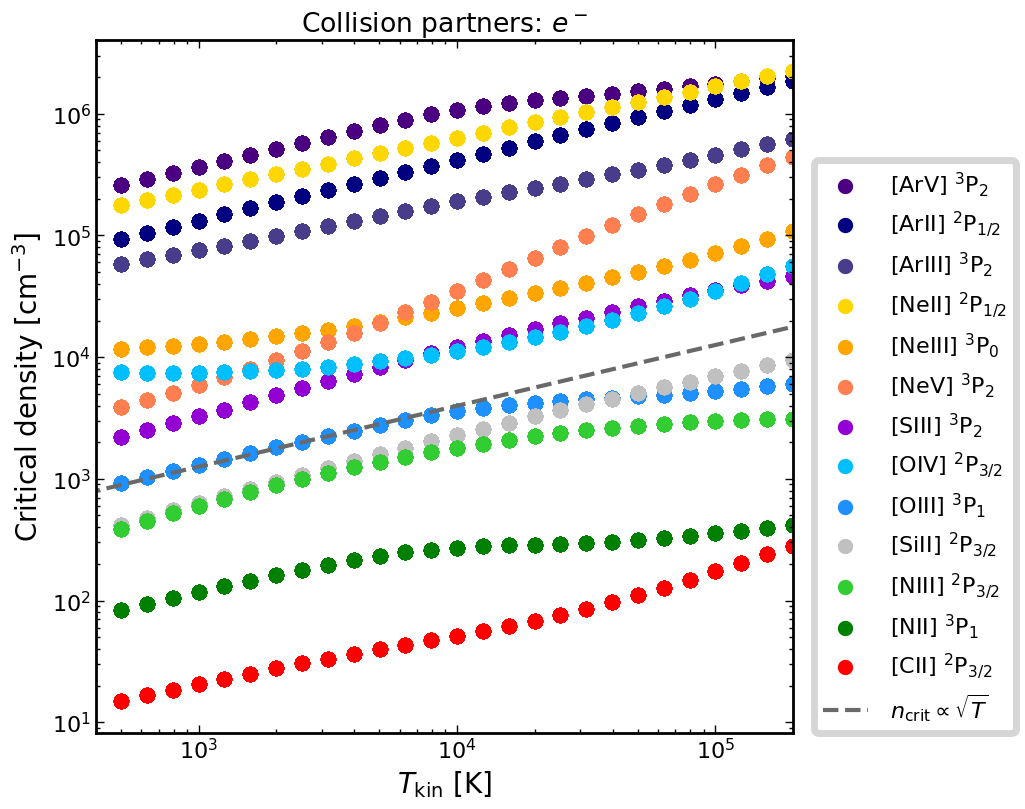

In [22]:
"""
Plot critical density as a function of temperature for the ionized medium
"""

nicePlot()
plt.figure(figsize=[9,9])
_TT=np.arange(0.,6.,0.1)
_nn=10.**(0.5*(_TT-3.)+3.1)

#print(N2_nc)
plt.xscale('log')
plt.yscale('log')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['Ar5_ncrit'][:,1],color='indigo', label=r'[ArV] $^{3}$P$_{2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['Ar2_ncrit'][:,0],color='navy', label=r'[ArII] $^{2}$P$_{1/2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['Ar3_ncrit'][:,0],color='darkslateblue', label=r'[ArIII] $^{3}$P$_{2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['Ne2_ncrit'][:,0],color='gold', label=r'[NeII] $^{2}$P$_{1/2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['Ne3_ncrit'][:,1],color='orange', label=r'[NeIII] $^{3}$P$_{0}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['Ne5_ncrit'][:,1],color='coral', label=r'[NeV] $^{3}$P$_{2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['S3_ncrit'][:,1], color='darkviolet', label=r'[SIII] $^{3}$P$_{2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['O4_ncrit'][:,0], color='deepskyblue', label=r'[OIV] $^{2}$P$_{3/2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['O3_ncrit'][:,1], color='dodgerblue', label=r'[OIII] $^{3}$P$_{1}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['Si2_ncrit'][:,0],color='silver', label=r'[SiII] $^{2}$P$_{3/2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['N3_ncrit'][:,0], color='limegreen', label=r'[NIII] $^{2}$P$_{3/2}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['N2_ncrit'][:,1], color='green',label=r'[NII] $^{3}$P$_{1}$')
plt.scatter(10.**lT_ln_inE[:,1],tab_ncritE['C2_ncrit'][:,0], color='red', label=r'[CII] $^{2}$P$_{3/2}$')
plt.plot(10.**_TT, _nn, color='dimgrey', linestyle='dashed', label=r'$n_{\rm crit}\propto \sqrt{T}$')
plt.xlim(400.,200000.)
plt.legend(loc=(1.03,0))
plt.title(r'Collision partners: $e^-$')
plt.xlabel(r'$T_{\rm kin}$ [K]')
plt.ylabel(r'Critical density [cm$^{-3}$]')


plt.savefig('figures/ncrit_ionized.png',dpi=400,format='png', bbox_inches='tight')
plt.show()


nicePlot: Setting rcParams


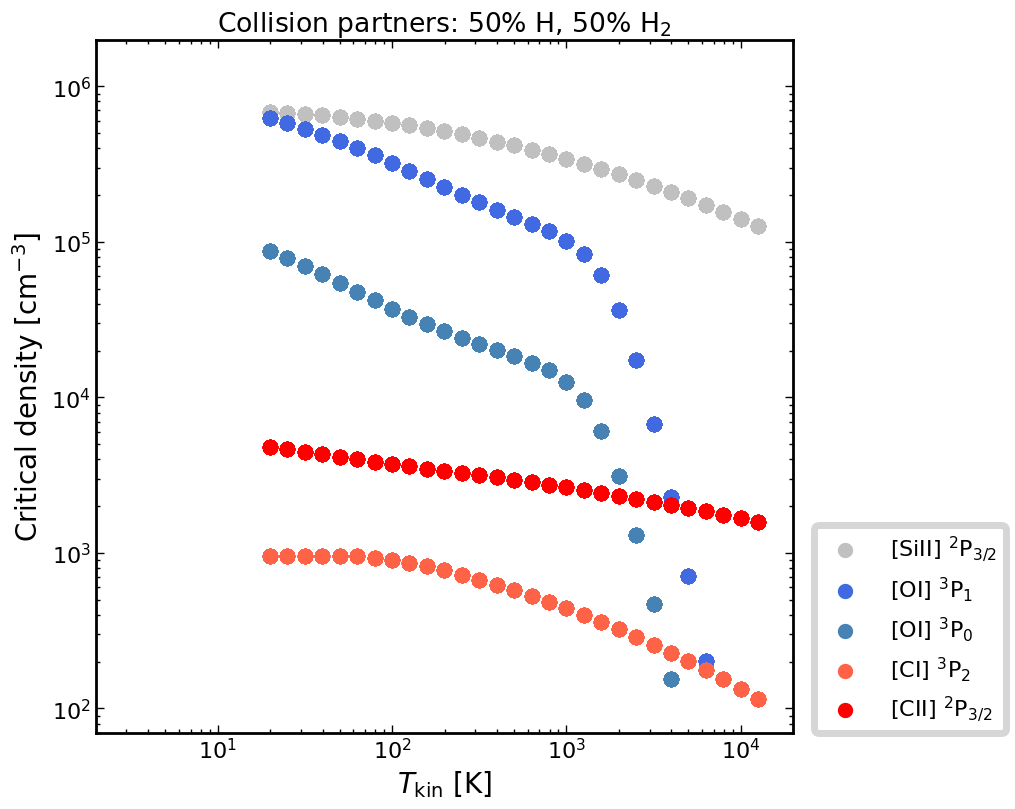

In [24]:
"""
Plot critical density as a function of temperature for the neutral medium
"""

nicePlot()
plt.figure(figsize=[9,9])
_TT=np.arange(0.,6.2,0.1)
_nn=10.**(0.5*(_TT-3.)+3.1)

#print(N2_nc)
plt.xscale('log')
plt.yscale('log')

plt.scatter(10.**lT_ln_inN[:,1],tab_ncritN['Si2_ncrit'][:,0],color='silver', label=r'[SiII] $^{2}$P$_{3/2}$')
plt.scatter(10.**lT_ln_inN[:,1],tab_ncritN['O1_ncrit'][:,0], color='royalblue', label=r'[OI] $^{3}$P$_{1}$')
plt.scatter(10.**lT_ln_inN[:,1],tab_ncritN['O1_ncrit'][:,1], color='steelblue', label=r'[OI] $^{3}$P$_{0}$')
plt.scatter(10.**lT_ln_inN[:,1],tab_ncritN['C1_ncrit'][:,1], color='tomato',label=r'[CI] $^{3}$P$_{2}$')
plt.scatter(10.**lT_ln_inN[:,1],tab_ncritN['C2_ncrit'][:,0], color='red', label=r'[CII] $^{2}$P$_{3/2}$')
#plt.plot(10.**_TT, _nn, color='dimgrey', linestyle='dashed', label=r'n$_{crit}\propto \sqrt{T}$')
plt.xlim(2.,20000.)
plt.ylim(70.,2000000.)
plt.legend(loc=(1.03,0))
plt.title(r'Collision partners: 50% H, 50% H$_2$')
plt.xlabel(r'$T_{\rm kin}$ [K]')
plt.ylabel(r'Critical density [cm$^{-3}$]')


plt.savefig('figures/ncrit_neutral.png',dpi=400,format='png', bbox_inches='tight')
plt.show()


nicePlot: Setting rcParams


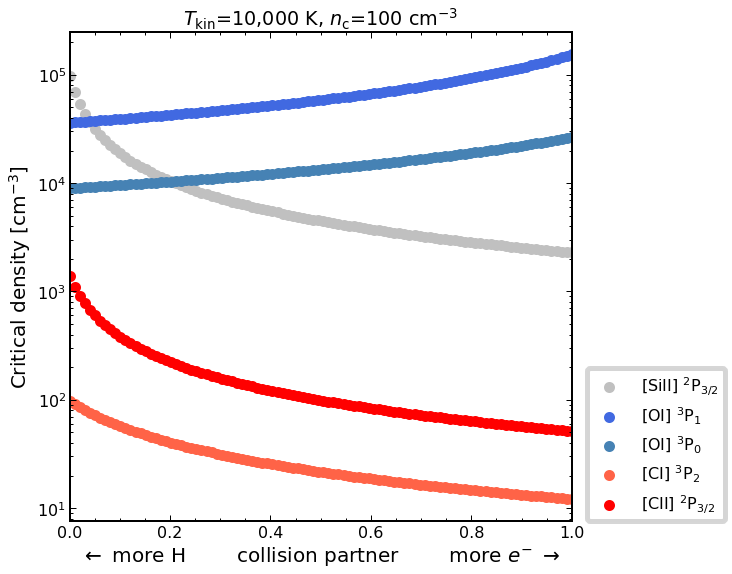

In [33]:
"""
Compute n_crit at a fixed (Tkin, n) but changing the fraction of collisions by electrons vs H.
"""
ntot=100. # cm-3
Tkin=10000. # K

# grid spacing
frace_in0=np.linspace(0.,1.0,100,dtype='float')

# the radiation field density is still to be done
n_gamma=0.  # cm-3

# set up empty tables
species=['C2', 'N3', 'O4', 'C1', 'N2', 'O3', 'Ne5', 'O1', 'Ne3', 'Ne2', 'Si2', 'S3', 'Ar5', 'S2', 'Ar3', 'Ar2']

tab_pop_frac=Table()
tab_ncrit=Table()
tab_A=Table()
tab_nu=Table()

for i in species:
    tab_pop_frac[i+'_PF']=Column(np.empty([len(frace_in0),5]),dtype='float')
    tab_ncrit[i+'_ncrit']=Column(np.empty([len(frace_in0),4]),dtype='float')
    tab_A[i+'_A']=Column(np.empty([10,1]),dtype='float')
    tab_nu[i+'_nu']=Column(np.empty([10,1]),dtype='float')


# compute the level population throughout the grid
# ionized phase:
for j in range(len(frace_in0)):
    mat, nu, A, ncrit=init_C2(ntot,Tkin,n_gamma,frace_in0[j],0.)
    PF=solve_matrix(mat)
    tab_pop_frac['C2_PF'][j]=PF
    tab_ncrit['C2_ncrit'][j]=ncrit
    tab_A['C2_A']=A
    tab_nu['C2_nu']=nu
    
    mat, nu, A, ncrit=init_C1(ntot,Tkin,n_gamma,frace_in0[j],0.)
    PF=solve_matrix(mat)
    tab_pop_frac['C1_PF'][j]=PF
    tab_ncrit['C1_ncrit'][j]=ncrit
    tab_A['C1_A']=A
    tab_nu['C1_nu']=nu

    mat, nu, A, ncrit=init_O1(ntot,Tkin,n_gamma,frace_in0[j],0.)
    PF=solve_matrix(mat)
    tab_pop_frac['O1_PF'][j]=PF
    tab_ncrit['O1_ncrit'][j]=ncrit
    tab_A['O1_A']=A
    tab_nu['O1_nu']=nu

    mat, nu, A, ncrit=init_Si2(ntot,Tkin,n_gamma,frace_in0[j],0.)
    PF=solve_matrix(mat)
    tab_pop_frac['Si2_PF'][j]=PF
    tab_ncrit['Si2_ncrit'][j]=ncrit
    tab_A['Si2_A']=A
    tab_nu['Si2_nu']=nu


"""
Plot critical densities as a function of electron fraction among collision partners
"""
nicePlot()
plt.figure(figsize=[9,9])
_TT=np.arange(0.,6.,0.1)
_nn=10.**(0.5*(_TT-3.)+3.1)

plt.yscale('log')

plt.scatter(frace_in0,tab_ncrit['Si2_ncrit'][:,0],color='silver', label=r'[SiII] $^{2}$P$_{3/2}$')
plt.scatter(frace_in0,tab_ncrit['O1_ncrit'][:,0], color='royalblue', label=r'[OI] $^{3}$P$_{1}$')
plt.scatter(frace_in0,tab_ncrit['O1_ncrit'][:,1], color='steelblue', label=r'[OI] $^{3}$P$_{0}$')
plt.scatter(frace_in0,tab_ncrit['C1_ncrit'][:,1], color='tomato',label=r'[CI] $^{3}$P$_{2}$')
plt.scatter(frace_in0,tab_ncrit['C2_ncrit'][:,0], color='red', label=r'[CII] $^{2}$P$_{3/2}$')
plt.xlim(0,1)
plt.legend(loc=(1.03,0))
plt.title(r'$T_{\rm kin}$=10,000 K, $n_{\rm c}$=100 cm$^{-3}$')
plt.xlabel(r'$\leftarrow$ more H        collision partner        more $e^{-}$ $\rightarrow$')
plt.ylabel(r'Critical density [cm$^{-3}$]')

plt.savefig('figures/ncrit_e-vsH.png',dpi=400,format='png', bbox_inches='tight')
plt.show()


nicePlot: Setting rcParams


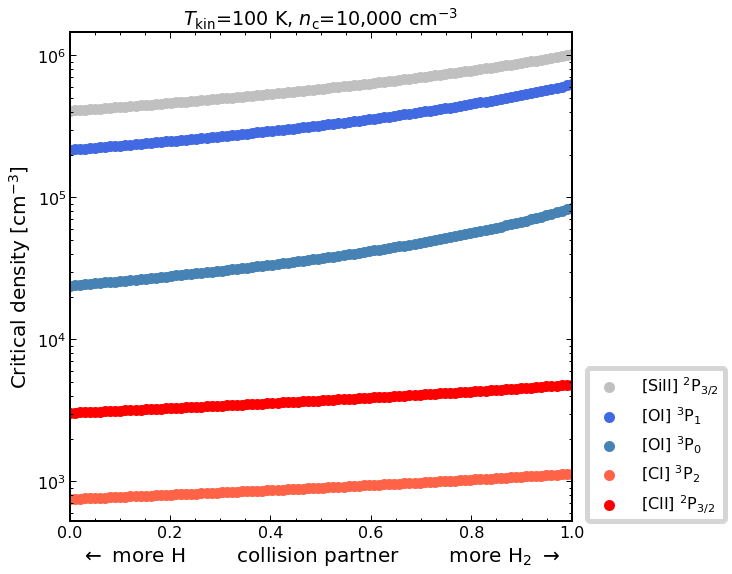

In [35]:
"""
Compute n_crit at a fixed (Tkin, n) but changing the fraction of collisions by neutral vs molecular hydrogen
"""
ntot=10000. # cm-3
Tkin=100. # K

# grid spacing
fracH2_in0=np.linspace(0.,1.0,100,dtype='float')

# the radiation field density is still to be done
n_gamma=0.  # cm-3

# set up empty tables
species=['C2', 'N3', 'O4', 'C1', 'N2', 'O3', 'Ne5', 'O1', 'Ne3', 'Ne2', 'Si2', 'S3', 'Ar5', 'S2', 'Ar3', 'Ar2']

tab_pop_frac=Table()
tab_ncrit=Table()
tab_A=Table()
tab_nu=Table()

for i in species:
    tab_pop_frac[i+'_PF']=Column(np.empty([len(fracH2_in0),5]),dtype='float')
    tab_ncrit[i+'_ncrit']=Column(np.empty([len(fracH2_in0),4]),dtype='float')
    tab_A[i+'_A']=Column(np.empty([10,1]),dtype='float')
    tab_nu[i+'_nu']=Column(np.empty([10,1]),dtype='float')


# compute the level population throughout the grid
# ionized phase:
for j in range(len(fracH2_in0)):
    mat, nu, A, ncrit=init_C2(ntot,Tkin,n_gamma,0.,fracH2_in0[j])
    PF=solve_matrix(mat)
    tab_pop_frac['C2_PF'][j]=PF
    tab_ncrit['C2_ncrit'][j]=ncrit
    tab_A['C2_A']=A
    tab_nu['C2_nu']=nu
    
    mat, nu, A, ncrit=init_C1(ntot,Tkin,n_gamma,0.,fracH2_in0[j])
    PF=solve_matrix(mat)
    tab_pop_frac['C1_PF'][j]=PF
    tab_ncrit['C1_ncrit'][j]=ncrit
    tab_A['C1_A']=A
    tab_nu['C1_nu']=nu

    mat, nu, A, ncrit=init_O1(ntot,Tkin,n_gamma,0.,fracH2_in0[j])
    PF=solve_matrix(mat)
    tab_pop_frac['O1_PF'][j]=PF
    tab_ncrit['O1_ncrit'][j]=ncrit
    tab_A['O1_A']=A
    tab_nu['O1_nu']=nu

    mat, nu, A, ncrit=init_Si2(ntot,Tkin,n_gamma,0.,fracH2_in0[j])
    PF=solve_matrix(mat)
    tab_pop_frac['Si2_PF'][j]=PF
    tab_ncrit['Si2_ncrit'][j]=ncrit
    tab_A['Si2_A']=A
    tab_nu['Si2_nu']=nu

nicePlot()
plt.figure(figsize=[9,9])
_TT=np.arange(0.,6.,0.1)
_nn=10.**(0.5*(_TT-3.)+3.1)

plt.yscale('log')

plt.scatter(frace_in0,tab_ncrit['Si2_ncrit'][:,0],color='silver', label=r'[SiII] $^{2}$P$_{3/2}$')
plt.scatter(frace_in0,tab_ncrit['O1_ncrit'][:,0], color='royalblue', label=r'[OI] $^{3}$P$_{1}$')
plt.scatter(frace_in0,tab_ncrit['O1_ncrit'][:,1], color='steelblue', label=r'[OI] $^{3}$P$_{0}$')
plt.scatter(frace_in0,tab_ncrit['C1_ncrit'][:,1], color='tomato',label=r'[CI] $^{3}$P$_{2}$')
plt.scatter(frace_in0,tab_ncrit['C2_ncrit'][:,0], color='red', label=r'[CII] $^{2}$P$_{3/2}$')
plt.xlim(0,1)
plt.legend(loc=(1.03,0))
plt.title(r'$T_{\rm kin}$=100 K, $n_{\rm c}$=10,000 cm$^{-3}$')
plt.xlabel(r'$\leftarrow$ more H        collision partner        more H$_2$ $\rightarrow$')
plt.ylabel(r'Critical density [cm$^{-3}$]')


plt.savefig('figures/ncrit_H2vsH.png',dpi=400,format='png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_274659/3921442492.py:169: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


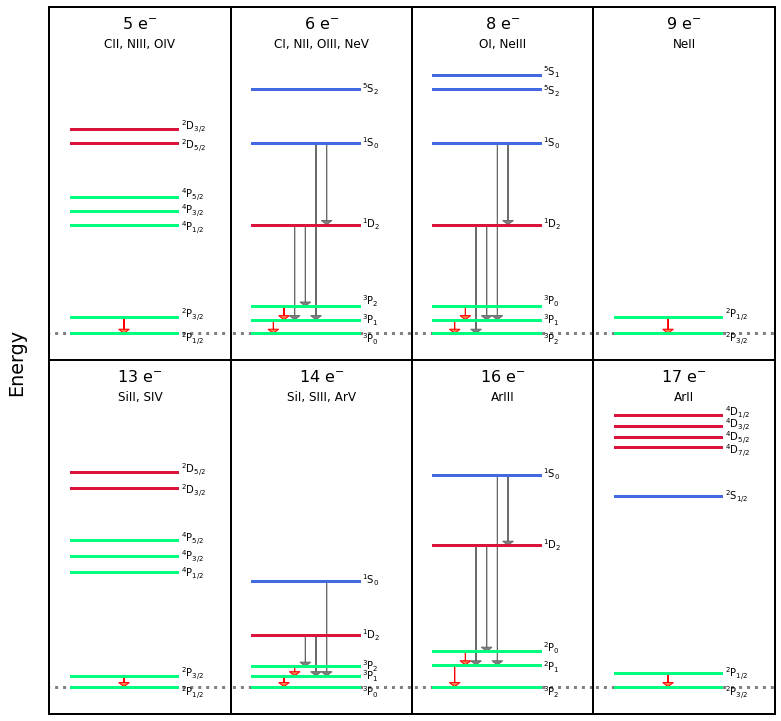

In [37]:
"""
Plot the structure of energy levels for different number of valence electrons
"""

lev5=[0., 600., 4000., 4500., 5000., 7000., 7500.]
lbl5=['$^{2}$P$_{1/2}$','$^{2}$P$_{3/2}$','$^{4}$P$_{1/2}$','$^{4}$P$_{3/2}$','$^{4}$P$_{5/2}$','$^{2}$D$_{5/2}$','$^{2}$D$_{3/2}$']
col5=['springgreen','springgreen','springgreen','springgreen','springgreen','crimson','crimson']
off5=[-200., 100., -100., 0., +100., -100., +100]

lev6=[0., 500., 1000., 4000., 7000., 9000.]
lbl6=['$^{3}$P$_{0}$','$^{3}$P$_{1}$','$^{3}$P$_{2}$',r'$^{1}$D$_{2}$',r'$^{1}$S$_{0}$',r'$^{5}$S$_{2}$']
col6=['springgreen','springgreen','springgreen','crimson','royalblue','royalblue']
off6=[-200., 0., 200., 0., 0., 0.]

lev8=[0., 500., 1000., 4000., 7000., 9000., 9500.]
lbl8=['$^{3}$P$_{2}$','$^{3}$P$_{1}$','$^{3}$P$_{0}$',r'$^{1}$D$_{2}$',r'$^{1}$S$_{0}$',r'$^{5}$S$_{2}$',r'$^{5}$S$_{1}$']
col8=['springgreen','springgreen','springgreen','crimson','royalblue','royalblue','royalblue']
off8=[-200., 0., 200., 0., 0., -100., 100.]

lev9=[0., 600.]
lbl9=[r'$^{2}$P$_{3/2}$',r'$^{2}$P$_{1/2}$']
col9=['springgreen','springgreen']
off9=[-200., 100.]

lev13=[0., 400., 4200., 4800., 5400., 7300., 7900.]
lbl13=['$^{2}$P$_{1/2}$','$^{2}$P$_{3/2}$','$^{4}$P$_{1/2}$',r'$^{4}$P$_{3/2}$',r'$^{4}$P$_{5/2}$',r'$^{2}$D$_{3/2}$',r'$^{2}$D$_{5/2}$']
col13=['springgreen','springgreen','springgreen','springgreen','springgreen','crimson','crimson']
off13=[-200., 100., -50., 0., 50., -100., 100]

lev14=[0., 400., 750., 1900., 3900.]
lbl14=['$^{3}$P$_{0}$','$^{3}$P$_{1}$','$^{3}$P$_{2}$',r'$^{1}$D$_{2}$',r'$^{1}$S$_{0}$']
col14=['springgreen','springgreen','springgreen','crimson','royalblue']
off14=[-200., 0., 0., 0., 0., 0.]

lev16=[0., 800., 1300., 5200., 7800.]
lbl16=['$^{3}$P$_{2}$','$^{2}$P$_{1}$','$^{2}$P$_{0}$',r'$^{1}$D$_{2}$',r'$^{1}$S$_{0}$']
col16=['springgreen','springgreen','springgreen','crimson','royalblue']
off16=[-200., -100., 100., 0., 0.]

lev17=[0., 500., 7000., 8800., 9200., 9600., 10000.]
lbl17=['$^{2}$P$_{3/2}$','$^{2}$P$_{1/2}$','$^{2}$S$_{1/2}$',r'$^{4}$D$_{7/2}$',r'$^{4}$D$_{5/2}$',r'$^{4}$D$_{3/2}$',r'$^{4}$D$_{1/2}$']
col17=['springgreen','springgreen','royalblue','crimson','crimson','crimson','crimson']
off17=[-200., 0., 0., -100., -50., 50., +100]



fig=plt.figure(figsize=(13,13))

gs = fig.add_gridspec(2, 4, hspace=0, wspace=0)
(ax5, ax6, ax8, ax9), (ax13, ax14, ax16, ax17) = gs.subplots(sharex='col', sharey='row')
#fig.suptitle('Sharing x per column, y per row')

ax5.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev5)):
    ax5.plot((0,1), (lev5[i],lev5[i]), c=col5[i])
    ax5.text(1.03,lev5[i]+off5[i],lbl5[i],fontsize=10,c='black',ha='left',va='center')
ax5.arrow(0.5,lev5[1],0.,lev5[0]-lev5[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax5.set_xlim(-0.2,1.5)
ax5.set_ylim(-1000.,12000.)
ax5.set_yticks([])
ax5.text(0.65,11200.,r'5 e$^{-}$',ha='center')
ax5.text(0.65,10500.,r'CII, NIII, OIV',ha='center',fontsize=12)


ax6.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev6)):
    ax6.plot((0,1), (lev6[i],lev6[i]), c=col6[i])
    ax6.text(1.03,lev6[i]+off6[i],lbl6[i],fontsize=10,c='black',ha='left',va='center')
ax6.arrow(0.2,lev6[1],0.,lev6[0]-lev6[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax6.arrow(0.3,lev6[2],0.,lev6[1]-lev6[2],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax6.arrow(0.4,lev6[3],0.,lev6[1]-lev6[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax6.arrow(0.5,lev6[3],0.,lev6[2]-lev6[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax6.arrow(0.6,lev6[4],0.,lev6[1]-lev6[4],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax6.arrow(0.7,lev6[4],0.,lev6[3]-lev6[4],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax6.set_xlim(-0.2,1.5)
ax6.set_ylim(-1000.,12000.)
ax6.text(0.65,11200.,r'6 e$^{-}$',ha='center')
ax6.text(0.65,10500.,r'CI, NII, OIII, NeV',ha='center',fontsize=12)



ax8.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev8)):
    ax8.plot((0,1), (lev8[i],lev8[i]), c=col8[i])
    ax8.text(1.03,lev8[i]+off8[i],lbl8[i],fontsize=10,c='black',ha='left',va='center')
ax8.arrow(0.2,lev8[1],0.,lev8[0]-lev8[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax8.arrow(0.3,lev8[2],0.,lev8[1]-lev8[2],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax8.arrow(0.4,lev8[3],0.,lev8[0]-lev8[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax8.arrow(0.5,lev8[3],0.,lev8[1]-lev8[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax8.arrow(0.6,lev8[4],0.,lev8[1]-lev8[4],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax8.arrow(0.7,lev8[4],0.,lev8[3]-lev8[4],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax8.set_xlim(-0.2,1.5)
ax8.set_ylim(-1000.,12000.)
ax8.text(0.65,11200.,r'8 e$^{-}$',ha='center')
ax8.text(0.65,10500.,r'OI, NeIII',ha='center',fontsize=12)


ax9.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev9)):
    ax9.plot((0,1), (lev9[i],lev9[i]), c=col9[i])
    ax9.text(1.03,lev9[i]+off9[i],lbl9[i],fontsize=10,c='black',ha='left',va='center')
ax9.arrow(0.5,lev9[1],0.,lev9[0]-lev9[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax9.set_xlim(-0.2,1.5)
ax9.set_ylim(-1000.,12000.)
ax9.text(0.65,11200.,r'9 e$^{-}$',ha='center')
ax9.text(0.65,10500.,r'NeII',ha='center',fontsize=12)


ax13.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev13)):
    ax13.plot((0,1), (lev13[i],lev13[i]), c=col13[i])
    ax13.text(1.03,lev13[i]+off13[i],lbl13[i],fontsize=10,c='black',ha='left',va='center')
ax13.arrow(0.5,lev13[1],0.,lev13[0]-lev13[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax13.set_xlim(-0.2,1.5)
ax13.set_ylim(-1000.,12000.)
ax13.set_yticks([])
ax13.set_xticks([])
ax13.text(0.65,11200.,r'13 e$^{-}$',ha='center')
ax13.text(0.65,10500.,r'SiII, SIV',ha='center',fontsize=12)


ax14.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev14)):
    ax14.plot((0,1), (lev14[i],lev14[i]), c=col14[i])
    ax14.text(1.03,lev14[i]+off14[i],lbl14[i],fontsize=10,c='black',ha='left',va='center')
ax14.arrow(0.3,lev14[1],0.,lev14[0]-lev14[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax14.arrow(0.4,lev14[2],0.,lev14[1]-lev14[2],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax14.arrow(0.5,lev14[3],0.,lev14[2]-lev14[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax14.arrow(0.6,lev14[3],0.,lev14[1]-lev14[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax14.arrow(0.7,lev14[4],0.,lev14[1]-lev14[4],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax14.set_xlim(-0.2,1.5)
ax14.set_ylim(-1000.,12000.)
ax14.set_xticks([])
ax14.text(0.65,11200.,r'14 e$^{-}$',ha='center')
ax14.text(0.65,10500.,r'SiI, SIII, ArV',ha='center',fontsize=12)



ax16.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev16)):
    ax16.plot((0,1), (lev16[i],lev16[i]), c=col16[i])
    ax16.text(1.03,lev16[i]+off16[i],lbl16[i],fontsize=10,c='black',ha='left',va='center')
ax16.arrow(0.2,lev16[1],0.,lev16[0]-lev16[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax16.arrow(0.3,lev16[2],0.,lev16[1]-lev16[2],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax16.arrow(0.4,lev16[3],0.,lev16[1]-lev16[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax16.arrow(0.5,lev16[3],0.,lev16[2]-lev16[3],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax16.arrow(0.6,lev16[4],0.,lev16[1]-lev16[4],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax16.arrow(0.7,lev16[4],0.,lev16[3]-lev16[4],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='dimgrey',facecolor='grey')
ax16.set_xlim(-0.2,1.5)
ax16.set_ylim(-1000.,12000.)
ax16.set_xticks([])
ax16.text(0.65,11200.,r'16 e$^{-}$',ha='center')
ax16.text(0.65,10500.,r'ArIII',ha='center',fontsize=12)


ax17.plot((-1.,2.),(0.,0.),linestyle='dotted',color='grey')
for i in range(len(lev17)):
    ax17.plot((0,1), (lev17[i],lev17[i]), c=col17[i])
    ax17.text(1.03,lev17[i]+off17[i],lbl17[i],fontsize=10,c='black',ha='left',va='center')
ax17.arrow(0.5,lev17[1],0.,lev17[0]-lev17[1],linewidth=1,head_width=0.1,head_length=150,length_includes_head=True,edgecolor='red',facecolor='coral')
ax17.set_xlim(-0.2,1.5)
ax17.set_ylim(-1000.,12000.)
ax17.set_xticks([])
ax17.text(0.65,11200.,r'17 e$^{-}$',ha='center')
ax17.text(0.65,10500.,r'ArII',ha='center',fontsize=12)



fig.supylabel('Energy',x=0.08)


fig.savefig('figures/energy_levels.png',dpi=400,format='png', bbox_inches='tight')
fig.show()


/tmp/ipykernel_274659/637978808.py:47: RuntimeWarning: divide by zero encountered in true_divide
  en=clight/wave*hplanck*1.e9/erg2eV*10000.   # return energy in eV


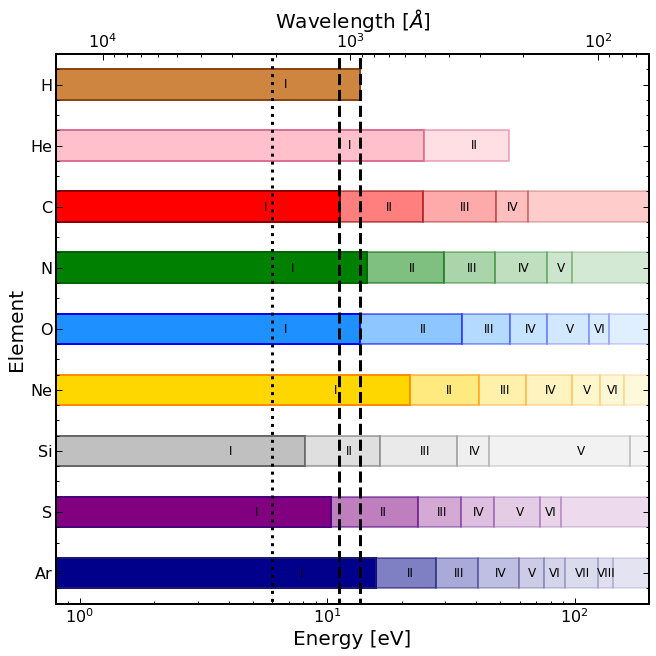

In [38]:
"""
Plot the ionization energies of various elements
"""


element=['H','He','C', 'N', 'O', 'Ne', 'Si', 'S', 'Ar']
Z=[1, 2, 6, 7, 8, 10, 14, 16, 18]
id=np.arange(len(Z))

H_Eion =[0., 13.59844]
He_Eion=[0., 24.58738, 54.41776]
C_Eion =[0., 11.26030, 24.38332, 47.8878,  64.4939,  392.087,  489.99334]
N_Eion =[0., 14.53414, 29.6013,  47.44924, 77.4735,  97.8902,  552.0718, 667.046]
O_Eion =[0., 13.61806, 35.11730, 54.9355,  77.41353, 113.8990, 138.1197, 739.29  ,871.4101]
Ne_Eion=[0., 21.5646 , 40.96328, 63.45  ,  97.12   , 126.21  , 157.93  , 207.2759,239.0989, 1195.8286, 1362.1995]
Si_Eion=[0., 8.15169 , 16.34585, 33.49302, 45.14181, 166.767 , 205.27  , 246.5,   303.54  , 351.12   , 401.37   , 476.36, 523.42, 2437.63, 2673.182]
S_Eion =[0., 10.36001, 23.3379,  34.79  ,  47.222,   72.5945,  88.0530 , 280.948, 328.75  , 379.55   , 447.5    , 504.8 , 564.44, 652.2  , 707.01 , 3223.78, 3494.1892]
Ar_Eion=[0., 15.75962, 27.62967, 40.74  ,  59.81,    75.02,    91.009  , 124.323, 143.460 , 422.45   , 478.69   , 538.96, 618.26, 686.10 , 755.74 , 854.77 ,  918.03, 4120.8857, 4426.2296]

ionlbl=['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI','XVII','XVIII','XIX']

plt.rcParams["xtick.top"] = False

fig, ax = plt.subplots(figsize=(9, 9), layout='constrained')

ax.set_xscale('log')
ax.set_ylim(0,18)
ax.set_xlim(0.8,200.)



ionv=np.arange(len(H_Eion))
for i in range(len(H_Eion)-1):
    ax.add_patch(Rectangle((H_Eion[i], 16.5), H_Eion[i+1]-H_Eion[i], 1, edgecolor='saddlebrown',facecolor='peru',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(H_Eion[i+1]<200.):
        ax.text((H_Eion[i+1]+H_Eion[i])/2.,17.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(He_Eion))
for i in range(len(He_Eion)-1):
    ax.add_patch(Rectangle((He_Eion[i], 14.5), He_Eion[i+1]-He_Eion[i], 1, edgecolor='palevioletred',facecolor='pink',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(He_Eion[i+1]<200.):
        ax.text((He_Eion[i+1]+He_Eion[i])/2.,15.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(C_Eion))
for i in range(len(C_Eion)-1):
    ax.add_patch(Rectangle((C_Eion[i], 12.5), C_Eion[i+1]-C_Eion[i], 1, edgecolor='darkred',facecolor='r',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(C_Eion[i+1]<200.):
        ax.text((C_Eion[i+1]+C_Eion[i])/2.,13.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(N_Eion))
for i in range(len(N_Eion)-1):
    ax.add_patch(Rectangle((N_Eion[i], 10.5), N_Eion[i+1]-N_Eion[i], 1, edgecolor='darkgreen',facecolor='green',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(N_Eion[i+1]<200.):
        ax.text((N_Eion[i+1]+N_Eion[i])/2.,11.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(O_Eion))
for i in range(len(O_Eion)-1):
    ax.add_patch(Rectangle((O_Eion[i], 8.5), O_Eion[i+1]-O_Eion[i], 1, edgecolor='blue',facecolor='dodgerblue',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(O_Eion[i+1]<200.):
        ax.text((O_Eion[i+1]+O_Eion[i])/2.,9.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(Ne_Eion))
for i in range(len(Ne_Eion)-1):
    ax.add_patch(Rectangle((Ne_Eion[i], 6.5), Ne_Eion[i+1]-Ne_Eion[i], 1, edgecolor='darkorange',facecolor='gold',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(Ne_Eion[i+1]<200.):
        ax.text((Ne_Eion[i+1]+Ne_Eion[i])/2.,7.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(Si_Eion))
for i in range(len(Si_Eion)-1):
    ax.add_patch(Rectangle((Si_Eion[i], 4.5), Si_Eion[i+1]-Si_Eion[i], 1, edgecolor='dimgrey',facecolor='silver',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(Si_Eion[i+1]<200.):
        ax.text((Si_Eion[i+1]+Si_Eion[i])/2.,5.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(S_Eion))
for i in range(len(S_Eion)-1):
    ax.add_patch(Rectangle((S_Eion[i], 2.5), S_Eion[i+1]-S_Eion[i], 1, edgecolor='indigo',facecolor='purple',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(S_Eion[i+1]<200.):
        ax.text((S_Eion[i+1]+S_Eion[i])/2.,3.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)

ionv=np.arange(len(Ar_Eion))
for i in range(len(Ar_Eion)-1):
    ax.add_patch(Rectangle((Ar_Eion[i], 0.5), Ar_Eion[i+1]-Ar_Eion[i], 1, edgecolor='midnightblue',facecolor='darkblue',linewidth=2,alpha=1./(ionv[i]+1.)))
    if(Ar_Eion[i+1]<200.):
        ax.text((Ar_Eion[i+1]+Ar_Eion[i])/2.,1.,ionlbl[i],color='black',ha='center',va='center',fontsize=12)


ax.plot((13.6,13.6),(-3,20),c='black',linestyle='dashed')
ax.plot((11.2,11.2),(-3,20),c='black',linestyle='dashed')
ax.plot((6.,6.),(-3,20),c='black',linestyle='dotted')
    
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Element')
ax.set_yticks((np.arange(1,19,2)),labels=['Ar','S','Si','Ne','O','N','C','He','H'])


secax = ax.secondary_xaxis('top', functions=(en2wave, wave2en))
secax.set_xlabel(r'Wavelength [$\AA$]')
plt.rcParams["xtick.top"] = True




plt.savefig('figures/ionization_energy.png',dpi=400,format='png', bbox_inches='tight')
plt.show()


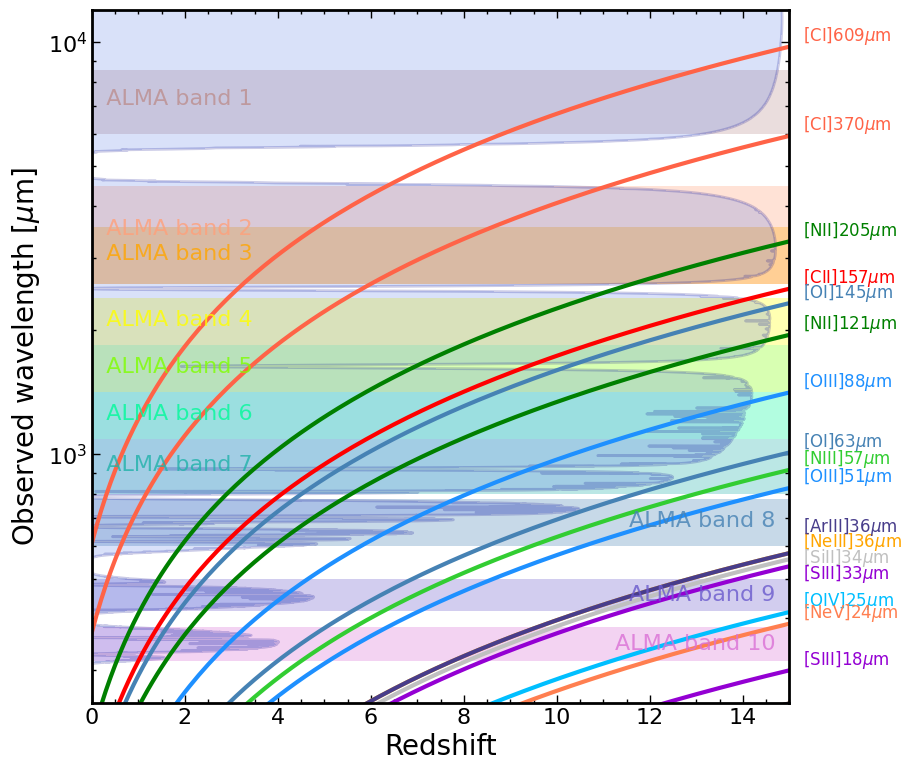

In [25]:
"""
Plot the observed wavelengths of various FSLs against redshift, and overplot ALMA bands
"""

skydata = ascii.read('mm_sky_abs_1mm.dat', format='csv')

zz=np.arange(0.,50.,0.1)

l5=[157.74, 57.343, 25.910]
lbl5=['[CII]','[NIII]','[OIV]']
clr5=['red', 'limegreen', 'deepskyblue']

l6=[609.7, 370.4, 205.5, 121.89, 88.356, 51.814, 24.28, 14.32]
lbl6=['[CI]','[CI]','[NII]','[NII]','[OIII]','[OIII]','[NeV]','[NeV]']
clr6=['tomato','tomato','green','green','dodgerblue','dodgerblue','coral','coral']

l8=[145.53, 63.184, 36.02, 15.555]
lbl8=['[OI]','[OI]','[NeIII]','[NeIII]']
clr8=['steelblue','steelblue','orange','orange']

l9=[12.814, 34.814, 33.47, 18.713, 13.1, 7.9, 36.02, 15.555, 2.93]
lbl9=['[NeII]','[SiII]','[SIII]','[SIII]','[ArV]','[ArV]','[ArIII]','[ArIII]','[ArII]']
clr9=['gold','silver','darkviolet','darkviolet','indigo','indigo','darkslateblue','darkslateblue','navy']

l0=np.concatenate((l5,l6,l8,l9),axis=0)
lbl=np.concatenate((lbl5,lbl6,lbl8,lbl9),axis=0)
clr=np.concatenate((clr5,clr6,clr8,clr9),axis=0)

off=np.ones_like(l0)
off[(lbl=='[ArIII]')]=1.09
off[((lbl=='[SIII]')&(l0>30.))]=0.90
off[(lbl=='[SiII]')]=0.95
off[(lbl=='[NeII]')]=0.97

nu0=clight/l0

nu_bands=[(35.,50.),(67.,116.),(84.,116.),(125.,163.),(163.,211.),(211.,275.),(275.,373.),(385.,500.),(602.,720.),(787.,950.)]
l_bands=clight/np.array(nu_bands)
clr_bands=['rosybrown','lightsalmon','orange','yellow','chartreuse','mediumspringgreen','lightseagreen','steelblue','slateblue','orchid']


xmin=0.
xmax=15.
ymin=250
ymax=12000.

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_yscale('log')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)

for i in range(len(nu_bands)):
    ax.add_patch(Rectangle((0., l_bands[i][0]), 50, l_bands[i][1]-l_bands[i][0], edgecolor=None,facecolor=clr_bands[i],alpha=0.3))

lsky=clight/skydata['freq']
dlsky=np.diff(lsky,append=0.)

ax.barh(lsky,skydata['Transmission']*xmax,height=dlsky,align='center',color='royalblue',alpha=0.2)
ax.plot(skydata['Transmission']*xmax,lsky,c='darkblue',linewidth=2,alpha=0.2)

for i in range(len(nu_bands)):
    if(l_bands[i][0]>800):
        ax.text(0.,(l_bands[i][1]+l_bands[i][0])/2.,'  ALMA band '+str(i+1),color=clr_bands[i],alpha=0.8,ha='left',va='center')
    else:
        ax.text(xmax,(l_bands[i][1]+l_bands[i][0])/2.,'ALMA band '+str(i+1)+'  ',color=clr_bands[i],alpha=0.8,ha='right',va='center')


for i in range(len(nu0)):
    li=l0[i]*(1+zz)
    ax.plot(zz,li,c=clr[i])
    if((li[(zz==xmax)]>ymin) & (li[(zz==xmax)]<ymax)):
        ax.text(xmax*1.02,li[(zz==xmax)]*off[i],lbl[i]+str(int(l0[i]))+r'$\mu$m',fontsize=12,c=clr[i],ha='left',va='bottom')
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Observed wavelength [$\mu$m]')


plt.savefig('figures/lambda_redshift_alma.png',dpi=400,format='png', bbox_inches='tight')
plt.show()

nicePlot: Setting rcParams


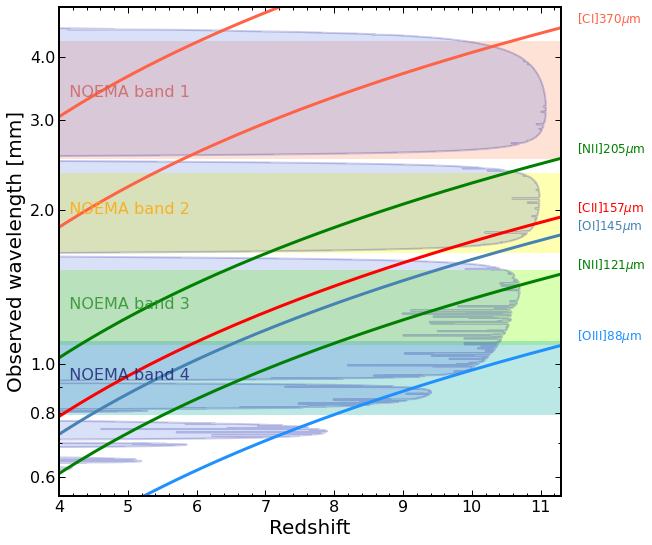

In [40]:
"""
Plot the observed wavelengths of various FSLs against redshift, and overplot NOEMA bands
"""
skydata = ascii.read('mm_sky_abs_1mm.dat', format='csv')

zz=np.arange(0.,50.,0.1)

l5=[157.74]
lbl5=['[CII]']
clr5=['red']

l6=[609.7, 370.4, 205.5, 121.89, 88.356]
lbl6=['[CI]','[CI]','[NII]','[NII]','[OIII]']
clr6=['tomato','tomato','green','green','dodgerblue']

l8=[145.53]
lbl8=['[OI]']
clr8=['steelblue']

l0=np.concatenate((l5,l6,l8),axis=0)/1000.
lbl=np.concatenate((lbl5,lbl6,lbl8),axis=0)
clr=np.concatenate((clr5,clr6,clr8),axis=0)

off=np.ones_like(l0)
off[(lbl=='[ArIII]')]=1.09
off[((lbl=='[SIII]')&(l0>30.))]=0.90
off[(lbl=='[SiII]')]=0.95
off[(lbl=='[NeII]')]=0.97

nu0=clight/l0

nu_bands=[(70.,119.),(127.,182.),(196.,276.),(271.,377.)]
l_bands=clight/np.array(nu_bands)/1000.
clr_bands=['lightsalmon','yellow','chartreuse','lightseagreen']
clr2_bands=['indianred','orange','forestgreen','midnightblue']

xmin=4.
xmax=11.3
ymin=0.550
ymax=5.

nicePlot()
fig, ax = plt.subplots(figsize=(9, 9))

ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)

for i in range(len(nu_bands)):
    ax.add_patch(Rectangle((0., l_bands[i][0]), 50, l_bands[i][1]-l_bands[i][0], edgecolor=None,facecolor=clr_bands[i],alpha=0.3))

lsky=clight/skydata['freq']/1000.
dlsky=np.diff(lsky,append=0.)

ax.barh(lsky,skydata['Transmission']*xmax,height=dlsky,align='center',color='royalblue',alpha=0.2)
ax.plot(skydata['Transmission']*xmax,lsky,c='darkblue',linewidth=2,alpha=0.2)

for i in range(len(nu_bands)):
    if(l_bands[i][0]>0.800):
        ax.text(4.,(l_bands[i][1]+l_bands[i][0])/2.,'  NOEMA band '+str(i+1),color=clr2_bands[i],alpha=0.8,ha='left',va='center')
    else:
        ax.text(xmax,(l_bands[i][1]+l_bands[i][0])/2.,'NOEMA band '+str(i+1)+'  ',color=clr_bands[i],alpha=0.8,ha='right',va='center')


for i in range(len(nu0)):
    li=l0[i]*(1+zz)
    ax.plot(zz,li,c=clr[i])
    if((li[(zz==xmax)]>ymin) & (li[(zz==xmax)]<ymax)):
        ax.text(xmax*1.02,li[(zz==xmax)]*off[i],lbl[i]+str(int(1000.*l0[i]))+r'$\mu$m',fontsize=12,c=clr[i],ha='left',va='bottom')
ax.set_yticks(np.array([0.6,0.8,1.0,2.0,3.0,4.0]),labels=['0.6','0.8','1.0','2.0','3.0','4.0'])
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Observed wavelength [mm]')

fig.savefig('fig_z_freq_noema.png',dpi=400,format='png', bbox_inches='tight')


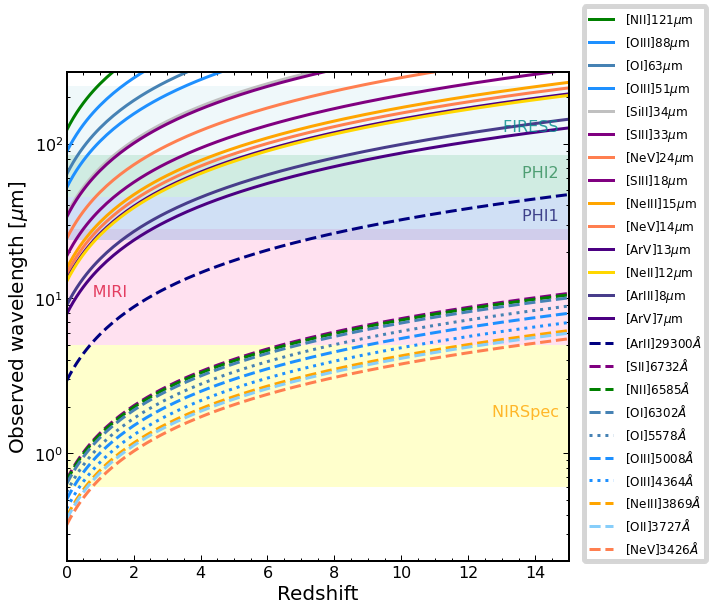

In [41]:
"""
Plot the observed wavelengths of various FSLs against redshift, and overplot JWST / PRIMA bands
"""

zz=np.arange(0.,50.,0.1)

# TRIMMED LIST (for the sake of plot clarity):
fna0=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2])
l0=np.array([121.89, 88.356, 63.184, 51.814, 34.814, 33.47, 24.28, 18.713, 15.555, 14.32, 13.1, 12.814, 8.991, 7.9, 2.93, 0.67327, 0.65853, 0.6302, 0.55789, 0.50082, 0.43644, 0.38699, 0.37271, 0.34268])
clr=['green', 'dodgerblue', 'steelblue', 'dodgerblue', 'silver', 'purple', 'coral', 'purple', 'orange', 'coral', 'indigo', 'gold', 'darkslateblue', 'indigo', 'navy', 'purple', 'green', 'steelblue', 'steelblue', 'dodgerblue', 'dodgerblue', 'orange', 'lightskyblue',  'coral']
lbl=['[NII]','[OIII]','[OI]','[OIII]','[SiII]','[SIII]','[NeV]','[SIII]','[NeIII]','[NeV]','[ArV]','[NeII]','[ArIII]','[ArV]','[ArII]','[SII]','[NII]','[OI]','[OI]','[OIII]','[OIII]','[NeIII]','[OII]','[NeV]']

nu0=clight/l0

l_bands=[(0.6,5.),(5.,28.),(24.,45.),(45.,84.),(24.,235.)]
nu_bands=clight/np.array(l_bands)
clr_bands=['yellow','hotpink','royalblue','mediumseagreen','powderblue']

xmin=0.
xmax=15.
ymin=0.2
ymax=290.

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_yscale('log')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)

for i in range(len(nu_bands)):
    ax.add_patch(Rectangle((0., l_bands[i][0]), 50, l_bands[i][1]-l_bands[i][0], edgecolor=None,facecolor=clr_bands[i],alpha=0.2))

ax.text(xmax,(l_bands[0][1]+l_bands[0][0])/3.,'NIRSpec  ',color='orange',alpha=0.8,ha='right',va='center')
ax.text(0.,(l_bands[1][1]+l_bands[1][0])/3.,'     MIRI',color='crimson',alpha=0.8,ha='left',va='center')
ax.text(xmax,(l_bands[2][1]+l_bands[2][0])/2.,'PHI1  ',color='midnightblue',alpha=0.8,ha='right',va='center')
ax.text(xmax,(l_bands[3][1]+l_bands[3][0])/2.,'PHI2  ',color='seagreen',alpha=0.8,ha='right',va='center')
ax.text(xmax,(l_bands[4][1]+l_bands[4][0])/2.,'FIRESS  ',color='darkcyan',alpha=0.8,ha='right',va='center')

for i in range(len(nu0)):
    li=l0[i]*(1+zz)
    if(fna0[i]==1):
        if((li[(zz==0.)]>ymin) & (li[(zz==0.)]<ymax)):
            ax.plot(zz,li,c=clr[i],linestyle='solid',label=lbl[i]+str(int(l0[i]))+r'$\mu$m')
        else:
            ax.plot(zz,li,c=clr[i],linestyle='solid')
    if(fna0[i]==2):
        ax.plot(zz,li,c=clr[i],linestyle='dashed',label=lbl[i]+str(int(10000.*l0[i]))+r'$\AA$')
    if(fna0[i]==3):
        ax.plot(zz,li,c=clr[i],linestyle='dotted',label=lbl[i]+str(int(10000.*l0[i]))+r'$\AA$')
ax.legend(loc=(1.03,0.0),fontsize=12)
ax.set_xlabel('Redshift')
ax.set_ylabel(r'Observed wavelength [$\mu$m]')



plt.savefig('figures/lambda_redshift_jwst.png',dpi=400,format='png', bbox_inches='tight')
plt.show()

In [13]:
"""
Functions defining the sources of ionizing flux
"""

def read_ssp():
    age=ascii.read('bc03_time.dat')
    tab=Table.read('bc2003_spec_tab.out',format='csv')
    return age,tab


def intburst(SSPage,SSPtab):
    #t=np.arange(0,1000.,1.) # in Myr
    tburst=1000. # in Myr
    t=np.array(SSPage[(SSPage<tburst)])
    dt=np.diff(t)
    dt=np.append(dt[0],dt)
    # ssfr=tb/tau/tau*exp(-tb*tb/tau/tau/2.)
    ssfr=np.ones_like(dt)
    dmass=ssfr*dt
    totmass=np.sum(dmass)*0.01
    age=t
    tab=Table()
    tab['Wave']=SSPtab['Wave']
    for j in range(len(t)):
        y=np.zeros_like(tab['Wave'])
        for i in range(len(t)-j):
            y+=SSPtab['F'+str(i+1)]*dmass[i]/totmass
        tab['F'+str(j)]=y 


    return age,tab


def load_AGN():
    lnu=np.arange(12.,18.,0.01)
    ll=np.log10(clight)+13.-lnu
    l_agn=np.power(10.,ll)
    nu_agn=np.power(10.,lnu)

    tabAGN=Table()
    tabAGN['l']=l_agn
    
    # reference frequencies for alpha_OX (from Zamorani+81):
    laa=np.arange(np.log10(140.),np.log10(6.0e4),0.1)
    aa=np.power(10.,laa)
    cond_comp_agn1=np.where(((nu_agn>1.36*erg2eV/hplanck)&(nu_agn<100000.*erg2eV/hplanck)),1,0)
    refnu=np.array([4.835980274e+17, 1.199169e15])
    lrefnu=np.log10(refnu)

    alox=np.zeros_like(aa)
    
    for i in range(len(aa)):
        lFnAGN=-5.+np.log10(1./np.sqrt(nu_agn)*np.exp(-hplanck*nu_agn/kboltz/1.5e5-0.01*13.6*erg2eV/hplanck/nu_agn)+(np.power((cond_comp_agn1*aa[i]/nu_agn),0.9)))
        tabAGN['F'+str(i)]=np.power(10.,lFnAGN+lnu-ll)
        lFnAGNref=np.log10(1./np.sqrt(refnu)*np.exp(-hplanck*refnu/kboltz/1.5e5-0.01*13.6*erg2eV/hplanck/refnu)+aa[i]/refnu)
        alox[i]=(lFnAGNref[1]+lrefnu[1]-lFnAGNref[0]-lrefnu[0])/(lrefnu[1]-lrefnu[0])

    return alox,tabAGN


def load_AGN2():
    lnu=np.arange(12.,18.,0.01)
    ll=np.log10(clight)+13.-lnu
    l_agn=np.power(10.,ll)
    nu_agn=np.power(10.,lnu)

    tabAGN=Table()
    tabAGN['l']=l_agn
    
    # reference frequencies for alpha_OX (from Zamorani+81):
    aa=200.
    Tbbb=np.arange(10000.,200000.,5000.)
    cond_comp_agn1=np.where(((nu_agn>1.36*erg2eV/hplanck)&(nu_agn<100000.*erg2eV/hplanck)),1,0)
    refnu=np.array([4.835980274e+17, 1.199169e15])
    lrefnu=np.log10(refnu)

    alox=np.zeros_like(Tbbb)
    
    for i in range(len(Tbbb)):
        lFnAGN=-5.+np.log10(1./np.sqrt(nu_agn)*np.exp(-hplanck*nu_agn/kboltz/Tbbb[i]-0.01*13.6*erg2eV/hplanck/nu_agn)+(np.power((cond_comp_agn1*aa/nu_agn),0.9)))
        tabAGN['F'+str(i)]=np.power(10.,lFnAGN+lnu-ll)
        lFnAGNref=np.log10(1./np.sqrt(refnu)*np.exp(-hplanck*refnu/kboltz/Tbbb[i]-0.01*13.6*erg2eV/hplanck/refnu)+aa/refnu)
        alox[i]=(lFnAGNref[1]+lrefnu[1]-lFnAGNref[0]-lrefnu[0])/(lrefnu[1]-lrefnu[0])

    return alox,Tbbb,tabAGN



def intQ(l,Fl,Eion,Eion2):
    lion=clight*hplanck/(Eion*erg2eV)*1.e13
    lion2=clight*hplanck/(Eion2*erg2eV)*1.e13
    x=l[(l<=lion)&(l>lion2)]
    y=Fl[(l<=lion)&(l>lion2)]
    dx=np.ediff1d(x, to_begin=x[1]-x[0])
    Q=np.sum(y*x*np.abs(dx))  # the x factor is to sum on the number of photons, not on the energy
    return Q


/tmp/ipykernel_13491/2569557116.py:15: RuntimeWarning: divide by zero encountered in power
  _Fy=(np.power(_x-1.,2)+np.power(iverner['yw'],2))*(np.power(_y,0.5*iverner['P']-5.5))*(np.power(1.+np.sqrt(_y/iverner['ya']),-iverner['P']))


nicePlot: Setting rcParams


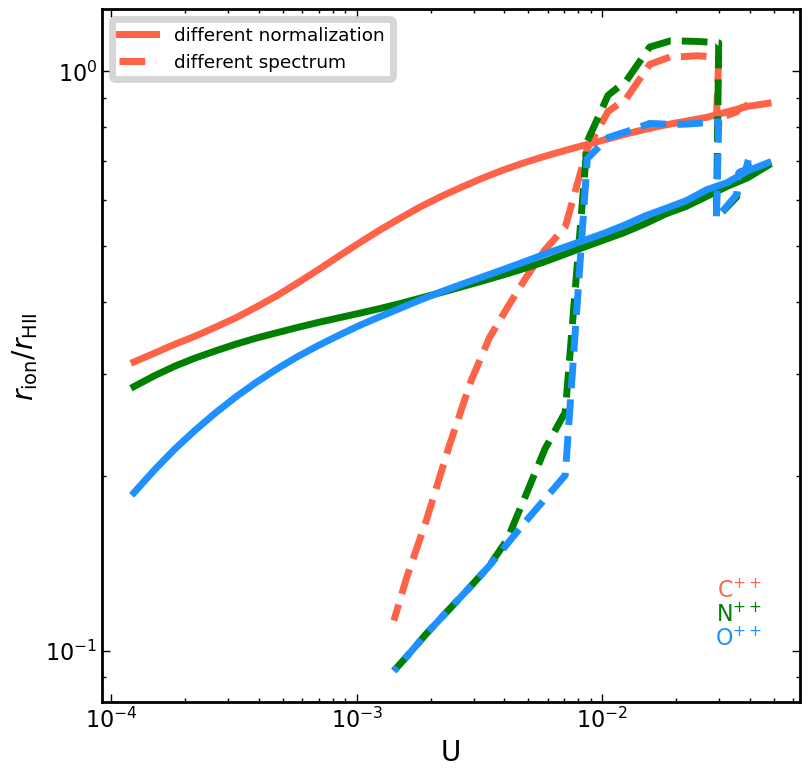

/tmp/ipykernel_13491/782143433.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_13491/782143433.py:158: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_13491/782143433.py:159: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_13491/782143433.py:272: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_13491/782143433.py:273: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[5]+(1.+n_g

nicePlot: Setting rcParams


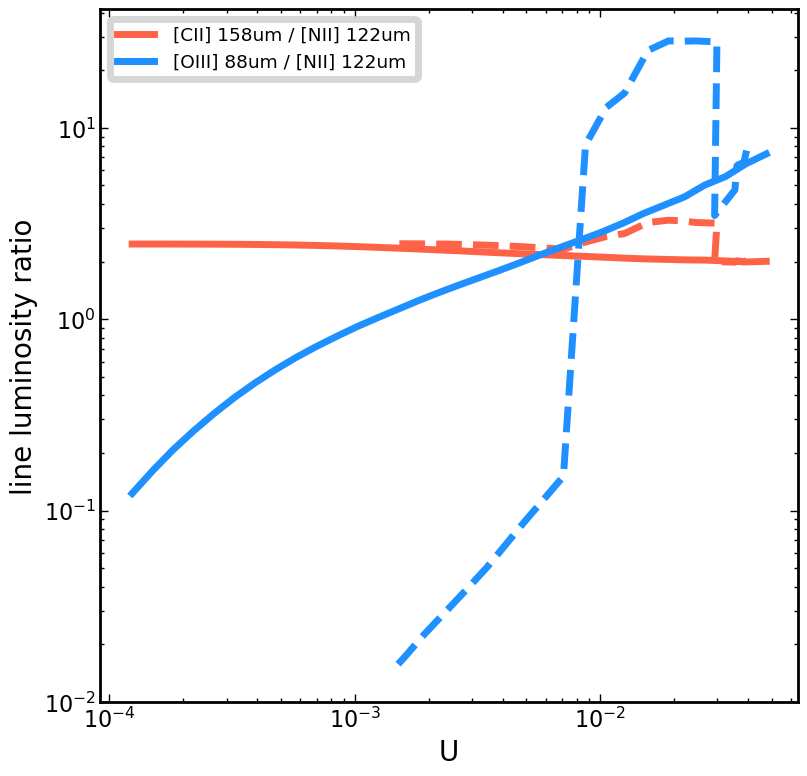

In [17]:
""" Photoionization equilibrium """

def read_verner():
    # read best fit params for photoionization cross sections from Verner+96
    verner=ascii.read('verner.tab')
    return verner


def sigmaE(nu,element,ion,verner):
    energy=hplanck*nu/erg2eV # energy in eV
    # compute the photoionization cross section based on best-fit params from Verner+96
    iverner=verner[((verner['Element']==element)&(verner['Ion']==ion))]
    _x=energy/iverner['E0']-iverner['y0']
    _y=np.sqrt(np.power(_x,2)+np.power(iverner['y1'],2))
    _Fy=(np.power(_x-1.,2)+np.power(iverner['yw'],2))*(np.power(_y,0.5*iverner['P']-5.5))*(np.power(1.+np.sqrt(_y/iverner['ya']),-iverner['P']))
    sigmaE=np.where(energy>iverner['Eth'],iverner['sigma0']*_Fy*1.e-18,0.)

    return sigmaE


def read_recomb():
    # read best-fit params for recombination coefficients
    recomb_ver=ascii.read('recombination_verner.dat')
    recomb_rad=ascii.read('recombination_radiative.dat')
    recomb_die=ascii.read('recombination_dielectric.dat')
    
    return recomb_ver, recomb_rad, recomb_die


def comp_recomb(T,Z,ion,Tver,Trad,Tdie):
    # compute recombination coefficients
    alphaR=np.zeros_like(T)
    
    flag_pw=np.where((Trad['Z']==Z)&(Trad['Z']-Trad['Ne']==ion-1),1,0)
    if(np.sum(flag_pw)>0):
        iTrad=Trad[(flag_pw>0)]
        iTdie=Tdie[(flag_pw>0)]
        alphaR_rad=iTrad['alpha_rad']*np.power(T/1.e4,-iTrad['eta_rad'])
        alphaR_die=iTdie['A']*np.power(T,-1.5)*np.exp(-iTdie['T0']/T)*(1.+iTdie['B']*np.exp(-iTdie['T1']/T))
        alphaR=alphaR_rad+alphaR_die
    
    flag_ver=np.where(((Tver['Z']==Z)&(Tver['Z']-Tver['Ne']==ion-1)),1,0)
    if(np.sum(flag_ver)>0):
        iTver=Tver[(flag_ver>0)]
        alphaR=iTver['a']/(np.sqrt(T/iTver['T0'])*np.power(1.+np.sqrt(T/iTver['T0']),(1.-iTver['b']))*np.power(1.+np.sqrt(T/iTver['T1']),1.+iTver['b']))
        
    return alphaR.value


def intQphot(nu,Lnu,sigmaE,tau_nu):
    x=nu
    y=np.where((sigmaE>0.),Lnu,0.)
    dx=np.ediff1d(x, to_begin=x[1]-x[0])
    
    intQphot=np.sum(y*np.abs(dx)*sigmaE*np.exp(-tau_nu)/hplanck/nu)/np.sum(np.abs(dx)*sigmaE/x)
    
    return intQphot


def intphotoion(nu,Fnu,sigmaE):
    x=nu # nu[(nu>=nuion)]
    y=Fnu
    dx=np.ediff1d(x, to_begin=x[1]-x[0])
    intphot=np.sum(y*np.abs(dx)/(hplanck*nu)*sigmaE) 
    
    return intphot


def init_frac_ion(Z):
    # this sets the densities based on abundances from Nicholls+17 
    # and assumes that all of the gas species are in neutral phase
    
    lgOH,lgNH,lgCH,lgHeH=nicholls(Z)
    nH=np.ones_like(ntot)
    nHe=np.power(10.,lgHeH)*nH
    nC=np.power(10.,lgCH)*nH
    nN=np.power(10.,lgNH)*nH
    nO=np.power(10.,lgOH)*nH
    nsum=nH+nHe+nC+nN+nO
    nH=nH/nsum
    nHe=nHe/nsum
    nC=nC/nsum
    nN=nN/nsum
    nO=nO/nsum
    
    fmat=np.array([[nH*0.1,nH*0.9,0.,0.,0.],
                   [nHe*0.8,nHe*0.2,0.,0.,0.],
                   [0.,nC,0.,0.,0.],
                   [0.,nN,0.,0.,0.],
                   [0.,0.,nO,0.,0.]])
    
    return fmat


def cfrac_r(nu,Lnu,Rout,T0,ntot,metal,boolPlot):
    _lgy=np.arange(-2,1.05,0.05)
    _y=np.power(10.,_lgy)
    _dy=np.ediff1d(_y, to_begin=_y[1]-_y[0])
    #_dy=0.003
    #_y=np.arange(0.01,1.05,_dy)
    tau=np.zeros_like(nu)

    lgOH,lgNH,lgCH,lgHeH=nicholls(metal)

    nH=np.ones_like(ntot)
    nHe=np.power(10.,lgHeH)
    nC=np.power(10.,lgCH)
    nN=np.power(10.,lgNH)
    nO=np.power(10.,lgOH)
    nsum=nH+nHe+nC+nN+nO
    nH=nH/nsum*ntot
    nHe=nHe/nsum*ntot
    nC=nC/nsum*ntot
    nN=nN/nsum*ntot
    nO=nO/nsum*ntot
    
    verner=read_verner()
    tver,trad,tdie=read_recomb()
    frac_ion0=init_frac_ion(metal)
    #tfrac_ion = np.zeros(shape=(len(_y),np.shape(frac_ion0)[0],np.shape(frac_ion0)[1]))
    
    #for i in range(len(_y)):
    #    tfrac_ion[i]=frac_ion0
    
    sigma00=sigmaE(nu,'H',1,verner)
    sigma10=sigmaE(nu,'He',1,verner)
    sigma11=sigmaE(nu,'He',2,verner)
    sigma20=sigmaE(nu,'C',1,verner)
    sigma21=sigmaE(nu,'C',2,verner)
    sigma22=sigmaE(nu,'C',3,verner)
    sigma23=sigmaE(nu,'C',4,verner)
    sigma30=sigmaE(nu,'N',1,verner)
    sigma31=sigmaE(nu,'N',2,verner)
    sigma32=sigmaE(nu,'N',3,verner)
    sigma33=sigmaE(nu,'N',4,verner)
    sigma40=sigmaE(nu,'O',1,verner)
    sigma41=sigmaE(nu,'O',2,verner)
    sigma42=sigmaE(nu,'O',3,verner)
    sigma43=sigmaE(nu,'O',4,verner)
   
    recomb00=comp_recomb(T0,1,1,tver,trad,tdie)
    recomb10=comp_recomb(T0,2,1,tver,trad,tdie)
    recomb11=comp_recomb(T0,2,2,tver,trad,tdie)
    #print(str(np.max(recomb10))+' cm3 s-1')
    recomb20=comp_recomb(T0,6,1,tver,trad,tdie)
    recomb21=comp_recomb(T0,6,2,tver,trad,tdie)
    recomb22=comp_recomb(T0,6,3,tver,trad,tdie)
    recomb23=comp_recomb(T0,6,4,tver,trad,tdie)
    recomb30=comp_recomb(T0,7,1,tver,trad,tdie)
    recomb31=comp_recomb(T0,7,2,tver,trad,tdie)
    recomb32=comp_recomb(T0,7,3,tver,trad,tdie)
    recomb33=comp_recomb(T0,7,4,tver,trad,tdie)
    recomb40=comp_recomb(T0,8,1,tver,trad,tdie)
    recomb41=comp_recomb(T0,8,2,tver,trad,tdie)
    recomb42=comp_recomb(T0,8,3,tver,trad,tdie)
    recomb43=comp_recomb(T0,8,4,tver,trad,tdie)
    
    integral00=np.zeros_like(_y)
    integral10=np.zeros_like(_y)
    integral11=np.zeros_like(_y)
    integral20=np.zeros_like(_y)
    integral21=np.zeros_like(_y)
    integral22=np.zeros_like(_y)
    integral23=np.zeros_like(_y)
    integral30=np.zeros_like(_y)
    integral31=np.zeros_like(_y)
    integral32=np.zeros_like(_y)
    integral33=np.zeros_like(_y)
    integral40=np.zeros_like(_y)
    integral41=np.zeros_like(_y)
    integral42=np.zeros_like(_y)
    integral43=np.zeros_like(_y)

    ne=np.ones_like(_y)*ntot #*(tfrac_ion[0,0,1]+tfrac_ion[0,1,1])
    icoeff_h=np.zeros_like(_y)
    icoeff_c=np.zeros_like(_y)
    icoeff_n=np.zeros_like(_y)
    icoeff_o=np.zeros_like(_y)

    ref_frac=0.5
    
    for i in range(len(_y)):
        dt_dr=Rout*ntot*(frac_ion0[0,0]*sigma00+
                         frac_ion0[1,0]*sigma10+frac_ion0[1,1]*sigma11+
                         frac_ion0[2,0]*sigma20+frac_ion0[2,1]*sigma21+frac_ion0[2,2]*sigma22+frac_ion0[2,3]*sigma23+
                         frac_ion0[3,0]*sigma30+frac_ion0[3,1]*sigma31+frac_ion0[3,2]*sigma32+frac_ion0[3,3]*sigma33+
                         frac_ion0[4,0]*sigma40+frac_ion0[4,1]*sigma41+frac_ion0[4,2]*sigma42+frac_ion0[4,3]*sigma43)

        tau+=np.maximum(dt_dr,0.)*_dy[i]
        max_tau=np.max(tau)
        
        #if(np.max(tau)<20.):
        Fnu=Lnu/(4.*np.pi*np.power(Rout*_y[i],2))*np.exp(-tau)
            
        integral00[i]=intphotoion(nu,Fnu,sigma00)
        integral10[i]=intphotoion(nu,Fnu,sigma10)
        integral11[i]=intphotoion(nu,Fnu,sigma11)
        integral20[i]=intphotoion(nu,Fnu,sigma20)
        integral21[i]=intphotoion(nu,Fnu,sigma21)
        integral22[i]=intphotoion(nu,Fnu,sigma22)
        integral23[i]=intphotoion(nu,Fnu,sigma23)
        integral30[i]=intphotoion(nu,Fnu,sigma30)
        integral31[i]=intphotoion(nu,Fnu,sigma31)
        integral32[i]=intphotoion(nu,Fnu,sigma32)
        integral33[i]=intphotoion(nu,Fnu,sigma33)
        integral40[i]=intphotoion(nu,Fnu,sigma40)
        integral41[i]=intphotoion(nu,Fnu,sigma41)
        integral42[i]=intphotoion(nu,Fnu,sigma42)
        integral43[i]=intphotoion(nu,Fnu,sigma43)
        
        coeff_h1=integral00[i]
        coeff_h2=ne[i]*recomb00
        coeff_h=1.+coeff_h1/coeff_h2
        icoeff_h[i]=1./coeff_h
        
        coeff_c2=integral21[i]
        coeff_c3=ne[i]*recomb23
        coeff_c=1.+coeff_c2/coeff_c3
        icoeff_c[i]=1./coeff_c

        coeff_n2=integral31[i]
        coeff_n3=ne[i]*recomb33
        coeff_n=1.+coeff_n2/coeff_n3
        icoeff_n[i]=1./coeff_n

        coeff_o2=integral41[i]
        coeff_o3=ne[i]*recomb43+ntot*icoeff_h[i]*1.05e-9
        coeff_o=1.+coeff_o2/coeff_o3
        icoeff_o[i]=1./coeff_o

    xHI=np.interp(ref_frac,icoeff_h,_y*Rout)
    xCII=np.interp(ref_frac,icoeff_c,_y*Rout)
    xNII=np.interp(ref_frac,icoeff_n,_y*Rout)
    xOII=np.interp(ref_frac,icoeff_o,_y*Rout)
    #print(xOII/xHI)
    
    if(boolPlot):
        nicePlot()

        fig = plt.figure(figsize=(9,9))

        plt.plot(Rout*_y,icoeff_o,c='royalblue',linewidth=5,label='O+')
        plt.plot(Rout*_y,1.-icoeff_o,c='dodgerblue',linewidth=5,label='O++')
        plt.plot(Rout*_y,icoeff_h,c='forestgreen',linewidth=5,label='N+')
        plt.plot(Rout*_y,1.-icoeff_h,c='green',linewidth=5,label='N++')
        plt.plot(Rout*_y,icoeff_h,c='red',linewidth=5,label='C+')
        plt.plot(Rout*_y,1.-icoeff_h,c='indianred',linewidth=5,label='C++')
        plt.plot(Rout*_y,icoeff_h,c='siena',linewidth=5,label='H')
        plt.plot(Rout*_y,1.-icoeff_h,c='black',linewidth=5,label='H+')
        #plt.yscale('log')
        plt.xscale('log')
        #plt.ylim(0,1.15)

        plt.legend(fontsize='small')
        plt.xlabel(r'$r$ [cm]')
        plt.ylabel(r'Fraction')

    return xHI, xCII, xNII, xOII


def cfrac_r_new(nu,Lnu,Rout,T0,ntot,metal,boolPlot):
    _lgy=np.arange(-2,1.05,0.05)
    _y=np.power(10.,_lgy)
    _dy=np.ediff1d(_y, to_begin=_y[1]-_y[0])
    #_dy=0.003
    #_y=np.arange(0.01,1.05,_dy)
    tau=np.zeros_like(nu)

    lgOH,lgNH,lgCH,lgHeH=nicholls(metal)

    nH=np.ones_like(ntot)
    nHe=np.power(10.,lgHeH)
    nC=np.power(10.,lgCH)
    nN=np.power(10.,lgNH)
    nO=np.power(10.,lgOH)
    nsum=nH+nHe+nC+nN+nO
    nH=nH/nsum*ntot
    nHe=nHe/nsum*ntot
    nC=nC/nsum*ntot
    nN=nN/nsum*ntot
    nO=nO/nsum*ntot
    
    verner=read_verner()
    tver,trad,tdie=read_recomb()
    frac_ion0=init_frac_ion(metal)
    #tfrac_ion = np.zeros(shape=(len(_y),np.shape(frac_ion0)[0],np.shape(frac_ion0)[1]))
    
    #for i in range(len(_y)):
    #    tfrac_ion[i]=frac_ion0
    
    sigma00=sigmaE(nu,'H',1,verner)
    sigma10=sigmaE(nu,'He',1,verner)
    sigma11=sigmaE(nu,'He',2,verner)
    sigma20=sigmaE(nu,'C',1,verner)
    sigma21=sigmaE(nu,'C',2,verner)
    sigma22=sigmaE(nu,'C',3,verner)
    sigma23=sigmaE(nu,'C',4,verner)
    sigma30=sigmaE(nu,'N',1,verner)
    sigma31=sigmaE(nu,'N',2,verner)
    sigma32=sigmaE(nu,'N',3,verner)
    sigma33=sigmaE(nu,'N',4,verner)
    sigma40=sigmaE(nu,'O',1,verner)
    sigma41=sigmaE(nu,'O',2,verner)
    sigma42=sigmaE(nu,'O',3,verner)
    sigma43=sigmaE(nu,'O',4,verner)
   
    recomb00=comp_recomb(T0,1,1,tver,trad,tdie)
    recomb10=comp_recomb(T0,2,1,tver,trad,tdie)
    recomb11=comp_recomb(T0,2,2,tver,trad,tdie)
    #print(str(np.max(recomb10))+' cm3 s-1')
    recomb20=comp_recomb(T0,6,1,tver,trad,tdie)
    recomb21=comp_recomb(T0,6,2,tver,trad,tdie)
    recomb22=comp_recomb(T0,6,3,tver,trad,tdie)
    recomb23=comp_recomb(T0,6,4,tver,trad,tdie)
    recomb30=comp_recomb(T0,7,1,tver,trad,tdie)
    recomb31=comp_recomb(T0,7,2,tver,trad,tdie)
    recomb32=comp_recomb(T0,7,3,tver,trad,tdie)
    recomb33=comp_recomb(T0,7,4,tver,trad,tdie)
    recomb40=comp_recomb(T0,8,1,tver,trad,tdie)
    recomb41=comp_recomb(T0,8,2,tver,trad,tdie)
    recomb42=comp_recomb(T0,8,3,tver,trad,tdie)
    recomb43=comp_recomb(T0,8,4,tver,trad,tdie)
    
    integral00=np.zeros_like(_y)
    integral10=np.zeros_like(_y)
    integral11=np.zeros_like(_y)
    integral20=np.zeros_like(_y)
    integral21=np.zeros_like(_y)
    integral22=np.zeros_like(_y)
    integral23=np.zeros_like(_y)
    integral30=np.zeros_like(_y)
    integral31=np.zeros_like(_y)
    integral32=np.zeros_like(_y)
    integral33=np.zeros_like(_y)
    integral40=np.zeros_like(_y)
    integral41=np.zeros_like(_y)
    integral42=np.zeros_like(_y)
    integral43=np.zeros_like(_y)

    ne=np.ones_like(_y)*ntot #*(tfrac_ion[0,0,1]+tfrac_ion[0,1,1])
    icoeff_h=np.zeros_like(_y)
    icoeff_he=np.zeros_like(_y)
    icoeff_c=np.zeros_like(_y)
    icoeff_n=np.zeros_like(_y)
    icoeff_o=np.zeros_like(_y)

    ref_frac=0.5
    
    for i in range(len(_y)):
        dt_dr=Rout*ntot*(frac_ion0[0,0]*sigma00+
                         frac_ion0[1,0]*sigma10+frac_ion0[1,1]*sigma11+
                         frac_ion0[2,0]*sigma20+frac_ion0[2,1]*sigma21+frac_ion0[2,2]*sigma22+frac_ion0[2,3]*sigma23+
                         frac_ion0[3,0]*sigma30+frac_ion0[3,1]*sigma31+frac_ion0[3,2]*sigma32+frac_ion0[3,3]*sigma33+
                         frac_ion0[4,0]*sigma40+frac_ion0[4,1]*sigma41+frac_ion0[4,2]*sigma42+frac_ion0[4,3]*sigma43)

        tau+=np.maximum(dt_dr,0.)*_dy[i]
        max_tau=np.max(tau)
        
        #if(np.max(tau)<20.):
        Fnu=Lnu/(4.*np.pi*np.power(Rout*_y[i],2))*np.exp(-tau)
            
        integral00[i]=intphotoion(nu,Fnu,sigma00)
        integral10[i]=intphotoion(nu,Fnu,sigma10)
        integral11[i]=intphotoion(nu,Fnu,sigma11)
        integral20[i]=intphotoion(nu,Fnu,sigma20)
        integral21[i]=intphotoion(nu,Fnu,sigma21)
        integral22[i]=intphotoion(nu,Fnu,sigma22)
        integral23[i]=intphotoion(nu,Fnu,sigma23)
        integral30[i]=intphotoion(nu,Fnu,sigma30)
        integral31[i]=intphotoion(nu,Fnu,sigma31)
        integral32[i]=intphotoion(nu,Fnu,sigma32)
        integral33[i]=intphotoion(nu,Fnu,sigma33)
        integral40[i]=intphotoion(nu,Fnu,sigma40)
        integral41[i]=intphotoion(nu,Fnu,sigma41)
        integral42[i]=intphotoion(nu,Fnu,sigma42)
        integral43[i]=intphotoion(nu,Fnu,sigma43)
        
        coeff_h1=integral00[i]
        coeff_h2=ne[i]*recomb00
        
        coeff_he1=integral10[i]
        coeff_he2=ne[i]*recomb10-integral11[i]
        coeff_he3=ne[i]*recomb11
            
        coeff_c1=integral20[i]
        coeff_c2=ne[i]*recomb20-integral21[i]
        coeff_c3=ne[i]*recomb21-integral22[i]
        coeff_c4=ne[i]*recomb22-integral23[i]
        coeff_c5=ne[i]*recomb23

        coeff_n1=integral30[i]
        coeff_n2=ne[i]*recomb30-integral31[i]
        coeff_n3=ne[i]*recomb31-integral32[i]
        coeff_n4=ne[i]*recomb32-integral33[i]
        coeff_n5=ne[i]*recomb33

        coeff_o1=integral40[i]
        coeff_o2=ne[i]*recomb40[i]-integral41[i]
        coeff_o3=ne[i]*recomb41+ntot*icoeff_h[i]*1.05e-9-integral42[i]
        coeff_o4=ne[i]*recomb42-integral43[i]
        coeff_o5=ne[i]*recomb43
        
        ion_mat=np.asarray([[coeff_h1,coeff_h2,0.,0.,0.],
                            [coeff_he1,coeff_he2,coeff_he3,0.,0.],
                            [coeff_c1,coeff_c2,coeff_c3,coeff_c4,coeff_c5],
                            [coeff_n1,coeff_n2,coeff_n3,coeff_n4,coeff_n5],
                            [coeff_o1,coeff_o2,coeff_o3,coeff_o4,coeff_o5]])
        

        new_ne=a01+a11+2*a12 #+a21+a31+a41+2*(a12+a22+a32+a42)+3*(a23+a33+a43)+4*(a24+a34+a44)


    xHI=np.interp(ref_frac,icoeff_h,_y*Rout)
    xHeI=np.interp(ref_frac,icoeff_he,_y*Rout)
    xHeII=np.interp(ref_frac,icoeff_he,_y*Rout)
    xCI=np.interp(ref_frac,icoeff_c,_y*Rout)
    xCII=np.interp(ref_frac,icoeff_c,_y*Rout)
    xNI=np.interp(ref_frac,icoeff_n,_y*Rout)
    xNII=np.interp(ref_frac,icoeff_n,_y*Rout)
    xNIII=np.interp(ref_frac,icoeff_n,_y*Rout)
    xOI=np.interp(ref_frac,icoeff_o,_y*Rout)
    xOII=np.interp(ref_frac,icoeff_o,_y*Rout)
    xOIII=np.interp(ref_frac,icoeff_o,_y*Rout)
    #print(xOII/xHI)
    
    if(boolPlot):
        nicePlot()

        fig = plt.figure(figsize=(9,9))

        plt.plot(Rout*_y,icoeff_o,c='red',linewidth=5,label='O+')
        plt.plot(Rout*_y,1.-icoeff_o,c='orangered',linewidth=5,label='O++')
        plt.plot(Rout*_y,icoeff_h,c='green',linewidth=5,label='H')
        plt.plot(Rout*_y,1.-icoeff_h,c='lime',linewidth=5,label='H+')
        #plt.yscale('log')
        plt.xscale('log')
        #plt.ylim(0,1.15)

        plt.legend(fontsize='small')
        plt.xlabel(r'$r$ [cm]')
        plt.ylabel(r'Fraction')

    return xHI, xOII



def Oion_vs_U(U_norm,xHI_norm,xCII_norm,xNII_norm,xOII_norm,U_hard,xHI_hard,xCII_hard,xNII_hard,xOII_hard):
    
    nicePlot()

    fig = plt.figure(figsize=(9,9))

    plt.plot(U_norm,xCII_norm/xHI_norm,c='tomato',linewidth=5,linestyle='solid',label='different normalization')
    plt.plot(U_hard,xCII_hard/xHI_hard,c='tomato',linewidth=5,linestyle='dashed',label='different spectrum')
    plt.plot(U_norm,xNII_norm/xHI_norm,c='green',linewidth=5,linestyle='solid')
    plt.plot(U_hard,xNII_hard/xHI_hard,c='green',linewidth=5,linestyle='dashed')
    plt.plot(U_norm,xOII_norm/xHI_norm,c='dodgerblue',linewidth=5,linestyle='solid')
    plt.plot(U_hard,xOII_hard/xHI_hard,c='dodgerblue',linewidth=5,linestyle='dashed')
    plt.text(0.045, 0.121, r'C$^{++}$', c='tomato', horizontalalignment='right', verticalalignment='bottom')
    plt.text(0.045, 0.11, r'N$^{++}$', c='green', horizontalalignment='right', verticalalignment='bottom')
    plt.text(0.045, 0.10, r'O$^{++}$', c='dodgerblue', horizontalalignment='right', verticalalignment='bottom')
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim(0,1.15)
    
    plt.legend(fontsize='small')
    plt.xlabel(r'U')
    plt.ylabel(r'$r_{\rm ion}/r_{\rm HII}$')

    plt.savefig('figures/fig_Oion_vs_U.png',dpi=400,format='png', bbox_inches='tight')
    plt.show()
    
    return



def populate_levels():
    lTE_in0=np.array([4.],dtype='float')
    lnE_in0=np.array([2.],dtype='float')

    lTN_in0=np.array([2.],dtype='float')
    lnN_in0=np.array([4.],dtype='float')

    lT_ln_inE,tab_pop_fracE,tab_ncritE,tab_AE,tab_nuE,lT_ln_inN,tab_pop_fracN,tab_ncritN,tab_AN,tab_nuN=compute_PF(lTE_in0,lnE_in0,lTN_in0,lnN_in0)


    C2_frac=np.array([tab_pop_fracE['C2_PF'][:,1],tab_pop_fracE['C2_PF'][:,2],tab_pop_fracE['C2_PF'][:,3],
                      tab_pop_fracE['C2_PF'][:,4],tab_pop_fracE['C2_PF'][:,2],tab_pop_fracE['C2_PF'][:,3],
                      tab_pop_fracE['C2_PF'][:,4],tab_pop_fracE['C2_PF'][:,3],tab_pop_fracE['C2_PF'][:,4],
                      tab_pop_fracE['C2_PF'][:,4]])
    C2_LumE=C2_frac[:,0]*hplanck*tab_nuE['C2_nu']*tab_AE['C2_A']
    C2_l=clight/tab_nuE['C2_nu']*1.e9


    O3_frac=np.array([tab_pop_fracE['O3_PF'][:,1],tab_pop_fracE['O3_PF'][:,2],tab_pop_fracE['O3_PF'][:,3],
                      tab_pop_fracE['O3_PF'][:,4],tab_pop_fracE['O3_PF'][:,2],tab_pop_fracE['O3_PF'][:,3],
                      tab_pop_fracE['O3_PF'][:,4],tab_pop_fracE['O3_PF'][:,3],tab_pop_fracE['O3_PF'][:,4],
                      tab_pop_fracE['O3_PF'][:,4]])
    O3_Lum=O3_frac[:,0]*hplanck*tab_nuE['O3_nu']*tab_AE['O3_A']
    O3_l=clight/tab_nuE['O3_nu']*1.e9


    N2_frac=np.array([tab_pop_fracE['N2_PF'][:,1],tab_pop_fracE['N2_PF'][:,2],tab_pop_fracE['N2_PF'][:,3],
                      tab_pop_fracE['N2_PF'][:,4],tab_pop_fracE['N2_PF'][:,2],tab_pop_fracE['N2_PF'][:,3],
                      tab_pop_fracE['N2_PF'][:,4],tab_pop_fracE['N2_PF'][:,3],tab_pop_fracE['N2_PF'][:,4],
                      tab_pop_fracE['N2_PF'][:,4]])
    N2_Lum=N2_frac[:,0]*hplanck*tab_nuE['N2_nu']*tab_AE['N2_A']
    N2_l=clight/tab_nuE['N2_nu']*1.e9


    N3_frac=np.array([tab_pop_fracE['N3_PF'][:,1],tab_pop_fracE['N3_PF'][:,2],tab_pop_fracE['N3_PF'][:,3],
                      tab_pop_fracE['N3_PF'][:,4],tab_pop_fracE['N3_PF'][:,2],tab_pop_fracE['N3_PF'][:,3],
                      tab_pop_fracE['N3_PF'][:,4],tab_pop_fracE['N3_PF'][:,3],tab_pop_fracE['N3_PF'][:,4],
                      tab_pop_fracE['N3_PF'][:,4]])
    N3_Lum=N3_frac[:,0]*hplanck*tab_nuE['N3_nu']*tab_AE['N3_A']
    N3_l=clight/tab_nuE['N3_nu']*1.e9

    return C2_LumE, N2_Lum, N3_Lum, O3_Lum


def Lline_vs_U(metal,U_norm,xHI_norm,xCII_norm,xNII_norm,xOII_norm,U_hard,xHI_hard,xCII_hard,xNII_hard,xOII_hard):
    lgOH,lgNH,lgCH,lgHeH=nicholls(metal)

    volHI_norm=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xHI_norm))
    volC3_norm=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xCII_norm))
    volN3_norm=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xNII_norm))
    volO3_norm=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xOII_norm))
    volHI_hard=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xHI_hard))
    volC3_hard=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xCII_hard))
    volN3_hard=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xNII_hard))
    volO3_hard=np.power(10.,np.log10(4.*np.pi/3.)+3.*np.log10(xOII_hard))
    
    volC2_norm=np.where((volHI_norm>volC3_norm),volHI_norm-volC3_norm,0.)
    volC2_hard=np.where((volHI_hard>volC3_hard),volHI_hard-volC3_hard,0.)
    volN2_norm=np.where((volHI_norm>volN3_norm),volHI_norm-volN3_norm,0.)
    volN2_hard=np.where((volHI_hard>volN3_hard),volHI_hard-volN3_hard,0.)
    
    C2_Lum, N2_Lum, N3_Lum, O3_Lum=populate_levels()
    
    LCII_norm=C2_Lum[0]*volC2_norm*np.power(10.,lgCH)/Lsun
    LNII_norm=N2_Lum[4]*volN2_norm*np.power(10.,lgNH)/Lsun
    LOII_norm=O3_Lum[0]*volO3_norm*np.power(10.,lgOH)/Lsun
    LCII_hard=C2_Lum[0]*volC2_hard*np.power(10.,lgCH)/Lsun
    LNII_hard=N2_Lum[4]*volN2_hard*np.power(10.,lgNH)/Lsun
    LOII_hard=O3_Lum[0]*volO3_hard*np.power(10.,lgOH)/Lsun
 
    
    nicePlot()

    fig = plt.figure(figsize=(9,9))

    plt.plot(U_norm,LCII_norm/LNII_norm,c='tomato',linewidth=5,linestyle='solid',label='[CII] 158um / [NII] 122um')
    plt.plot(U_hard,LCII_hard/LNII_hard,c='tomato',linewidth=5,linestyle='dashed')
    #plt.plot(U_norm,LNII_norm,c='forestgreen',linewidth=5,linestyle='solid',label='[NII]')
    #plt.plot(U_hard,LNII_hard,c='forestgreen',linewidth=5,linestyle='dashed')
    plt.plot(U_norm,LOII_norm/LNII_norm,c='dodgerblue',linewidth=5,linestyle='solid',label='[OIII] 88um / [NII] 122um')
    plt.plot(U_hard,LOII_hard/LNII_hard,c='dodgerblue',linewidth=5,linestyle='dashed')
    plt.yscale('log')
    plt.xscale('log')
    #plt.ylim(0,1.15)
    
    plt.legend(fontsize='small')
    plt.xlabel(r'U')
    plt.ylabel(r'line luminosity ratio')

    plt.savefig('figures/fig_Lratio_vs_U.png',dpi=400,format='png', bbox_inches='tight')
    plt.show()
    
    return



def plot_alphaR(Tin,tver,trad,tdie):
    alphaR_Hi=comp_recomb(Tin,1,1,tver,trad,tdie)
    alphaR_Oi=comp_recomb(Tin,8,1,tver,trad,tdie)
    alphaR_Oiii=comp_recomb(Tin,8,3,tver,trad,tdie)


    nicePlot()

    fig = plt.figure(figsize=(9,9))

    plt.yscale('log')
    plt.plot(Tin,alphaR_Hi,c='dodgerblue')
    plt.plot(Tin,alphaR_Oi,c='darkorange')
    plt.plot(Tin,alphaR_Oiii,c='indianred')
    plt.xlabel('T [K]')
    plt.ylabel(r'$\alpha_{\rm R}$ [cm$^3$]')

    return


def plot_sigmaE(nu,tverner):
    sigmaE_Hi=sigmaE(nu,'H',1,tverner)
    sigmaE_Ci=sigmaE(nu,'C',1,tverner)
    sigmaE_Cii=sigmaE(nu,'C',2,tverner)
    sigmaE_Ciii=sigmaE(nu,'C',3,tverner)
    sigmaE_Ni=sigmaE(nu,'N',1,tverner)
    sigmaE_Nii=sigmaE(nu,'N',2,tverner)
    sigmaE_Niii=sigmaE(nu,'N',3,tverner)
    sigmaE_Oi=sigmaE(nu,'O',1,tverner)
    sigmaE_Oii=sigmaE(nu,'O',2,tverner)
    sigmaE_Oiii=sigmaE(nu,'O',3,tverner)

    nicePlot()

    fig = plt.figure(figsize=(9,9))

    plt.plot(Ein,sigmaE_Hi*1.e18,c='purple')
    plt.plot(Ein,sigmaE_Ci*1.e18,c='darkorange')
    plt.plot(Ein,sigmaE_Cii*1.e18,c='indianred')
    plt.plot(Ein,sigmaE_Ciii*1.e18,c='sienna')
    plt.plot(Ein,sigmaE_Ni*1.e18,c='forestgreen')
    plt.plot(Ein,sigmaE_Nii*1.e18,c='green')
    plt.plot(Ein,sigmaE_Niii*1.e18,c='seagreen')
    plt.plot(Ein,sigmaE_Oi*1.e18,c='navy')
    plt.plot(Ein,sigmaE_Oii*1.e18,c='blue')
    plt.plot(Ein,sigmaE_Oiii*1.e18,c='royalblue')
    
    plt.xlabel('Energy [eV]')
    plt.ylabel(r'$\sigma_{E}$ [$10^{-18}$ cm$^{2}$]')

    return


def plot_input_spectrum(nu,Lnu):
    nicePlot()

    fig = plt.figure(figsize=(9,9))

    plt.plot(nu,Lnu,c='indianred')
    
    plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(1.e-16,1.e-11)
    
    plt.xlabel(r'$\nu_0$ [Hz]')
    plt.ylabel(r'$L_\nu$ [erg s$^{-1}$ Hz$^{-1}$]')

    return


def plot_t_r(nu,dt_dr):
    _y=np.arange(0.,1.05,0.1)
    tau=np.zeros_like(nu)
    colvec=['indianred','red','darkorange','orange','gold','chartreuse','green','seagreen','turquoise','steelblue','blue']
        
    nicePlot()

    fig = plt.figure(figsize=(9,9))

    for i in range(len(_y)):
        tau+=dt_dr*0.1
        plt.plot(nu,tau,c=colvec[i])
    
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.ylim(1.e-5,100.)
    
    plt.xlabel(r'$\nu$ [Hz]')
    plt.ylabel(r'$\tau_\nu$')

    return


def plot_Lnu_r(nu,Lnu,dt_dr,Rout):
    _dy=0.01
    _y=np.arange(0.,1.05,_dy)
    tau=np.zeros_like(nu)
    colvec=['indianred','red','darkorange','orange','gold','chartreuse','green','seagreen','turquoise','steelblue','blue']
    nicePlot()

    fig = plt.figure(figsize=(9,9))

    for i in range(len(_y)):
        tau+=dt_dr*_dy
        Fnu=Lnu/(4.*np.pi*np.power(Rout*_y[i],2))*np.exp(-tau)
        if(i%10==0):
            plt.plot(nu,Fnu,c=colvec[int(i/10)])
    
    #plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1.e-35,1.e-15)
    
    plt.xlabel(r'$\nu$ [Hz]')
    plt.ylabel(r'$F_\nu$ [erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$]')

    return



ntot=100. # cm-3
metal=1.   # Zsun
T0=10000.  # K
age,tssp=read_ssp()

nu=clight*1.e13/tssp['Wave']
Lnu=tssp['F20']*tssp['Wave']/nu*Lsun


tverner=read_verner()
tver,trad,tdie=read_recomb()
tfrac_ion=init_frac_ion(metal)

sigmaE_Hi=sigmaE(nu,'H',1,tverner)
alphaR_Hii=comp_recomb(T0,1,1,tver,trad,tdie)
tau0=np.zeros_like(nu)

normlogL=np.arange(-2,6,0.25)
U_norm=np.zeros_like(normlogL)
QHi_norm=np.zeros_like(normlogL)
xHI_norm=np.zeros_like(normlogL)
xCII_norm=np.zeros_like(normlogL)
xNII_norm=np.zeros_like(normlogL)
xOII_norm=np.zeros_like(normlogL)
Rout_norm=np.zeros_like(normlogL)    

for j in range(len(normlogL)):
    QHi_norm[j]=intQphot(nu,Lnu*np.power(10.,normlogL[j]),sigmaE_Hi,tau0)
    U_norm[j]=np.power(QHi_norm[j]*ntot*alphaR_Hii*alphaR_Hii/36./np.pi,1./3.)/(clight*1.e5)
    Rout_norm[j]=np.power(3.*QHi_norm[j]/(4.*np.pi*ntot*ntot*alphaR_Hii),1./3.) # cm   
    xHI_norm[j],xCII_norm[j],xNII_norm[j],xOII_norm[j]=cfrac_r(nu,Lnu*np.power(10.,normlogL[j]),Rout_norm[j],T0,ntot,metal,False)

indSSP=np.arange(1,100,3)
U_hard=np.zeros_like(indSSP*1.0)
QHi_hard=np.zeros_like(indSSP*1.0)
xHI_hard=np.zeros_like(indSSP*1.0)
xCII_hard=np.zeros_like(indSSP*1.0)
xNII_hard=np.zeros_like(indSSP*1.0)
xOII_hard=np.zeros_like(indSSP*1.0)
Rout_hard=np.zeros_like(indSSP*1.0)

for j in range(len(indSSP)):
    Lnuj=tssp['F'+str(indSSP[j])]*tssp['Wave']/nu*Lsun*300000.

    QHi_hard[j]=intQphot(nu,Lnuj,sigmaE_Hi,tau0)
    U_hard[j]=np.power(QHi_hard[j]*ntot*alphaR_Hii*alphaR_Hii/36./np.pi,1./3.)/(clight*1.e5)
    Rout_hard[j]=np.power(3.*QHi_hard[j]/(4.*np.pi*ntot*ntot*alphaR_Hii),1./3.) # cm
    
    xHI_hard[j],xCII_hard[j],xNII_hard[j],xOII_hard[j]=cfrac_r(nu,Lnuj,Rout_hard[j],T0,ntot,metal,False)

    
Oion_vs_U(U_norm,xHI_norm,xCII_norm,xNII_norm,xOII_norm,U_hard,xHI_hard,xCII_hard,xNII_hard,xOII_hard)


Lline_vs_U(metal,U_norm,1.3*xHI_norm,xCII_norm,xNII_norm,xOII_norm,U_hard,1.3*xHI_hard,xCII_hard,xNII_hard,xOII_hard)



/tmp/ipykernel_13491/668381553.py:86: RuntimeWarning: divide by zero encountered in log10
  lgQageNiv[i]=np.log10(intQ(x,y,N_Eion[4],N_Eion[5]))-lgQageHi[i]
/tmp/ipykernel_13491/668381553.py:89: RuntimeWarning: divide by zero encountered in log10
  lgQageOiii[i]=np.log10(intQ(x,y,O_Eion[3],O_Eion[4]))-lgQageHi[i]
/tmp/ipykernel_13491/668381553.py:90: RuntimeWarning: divide by zero encountered in log10
  lgQageOiv[i]=np.log10(intQ(x,y,O_Eion[4],O_Eion[5]))-lgQageHi[i]
/tmp/ipykernel_13491/668381553.py:95: RuntimeWarning: divide by zero encountered in log10
  lgQageAriv[i]=np.log10(intQ(x,y,Ar_Eion[4],Ar_Eion[5]))-lgQageHi[i]
/tmp/ipykernel_13491/668381553.py:96: RuntimeWarning: divide by zero encountered in log10
  lgQageArv[i]=np.log10(intQ(x,y,Ar_Eion[5],Ar_Eion[6]))-lgQageHi[i]
/tmp/ipykernel_13491/668381553.py:99: RuntimeWarning: divide by zero encountered in log10
  lgQageNeiii[i]=np.log10(intQ(x,y,Ne_Eion[3],Ne_Eion[4]))-lgQageHi[i]
/tmp/ipykernel_13491/668381553.py:100: RuntimeWa

nicePlot: Setting rcParams


/tmp/ipykernel_13491/668381553.py:218: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.log10(x),np.log10(SSP['F69']),color='springgreen',label='10 Myr')   # 10 Myr
/tmp/ipykernel_13491/668381553.py:219: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.log10(x),np.log10(SSP['F84']),color='chartreuse',label='20 Myr')    # 20 Myr
/tmp/ipykernel_13491/668381553.py:220: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.log10(x),np.log10(SSP['F93']),color='gold',label='30 Myr')          # 30 Myr
/tmp/ipykernel_13491/668381553.py:221: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.log10(x),np.log10(SSP['F103']),color='orange',label='40 Myr')       # 40 Myr
/tmp/ipykernel_13491/668381553.py:222: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.log10(x),np.log10(SSP['F107']),color='orangered',label='50 Myr')    # 50 Myr
/tmp/ipykernel_13491/668381553.py:223: RuntimeWarning: divide by zero encountered in log10

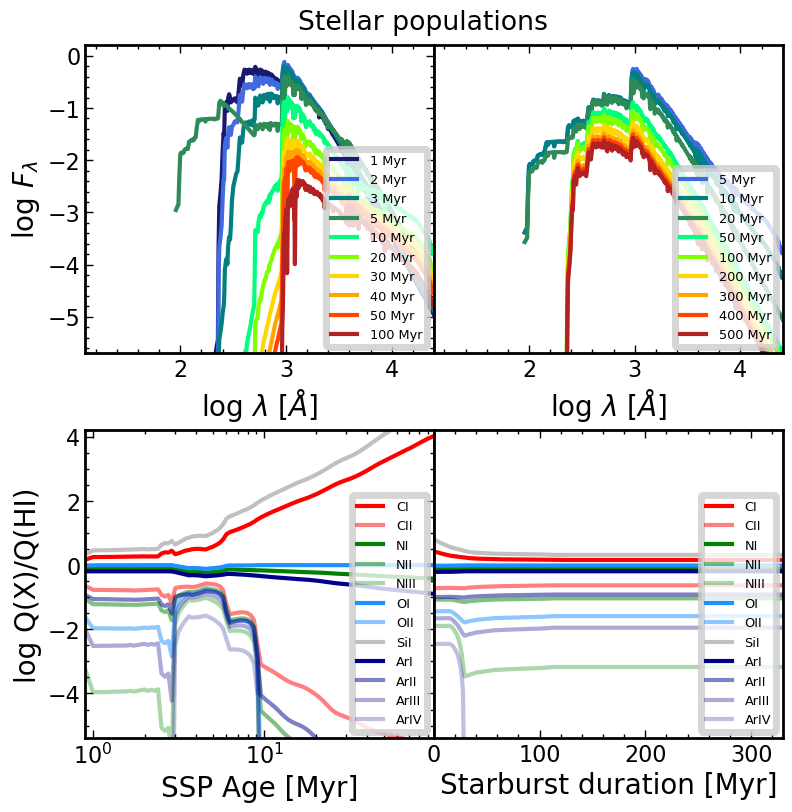

In [18]:
"""
Compute the budget of emitted ionizing photons for stellar populations of different ages
"""

H_Eion =[0., 13.59844]
He_Eion=[0., 24.58738, 54.41776]
C_Eion =[0., 11.26030, 24.38332, 47.8878,  64.4939,  392.087,  489.99334]
N_Eion =[0., 14.53414, 29.6013,  47.44924, 77.4735,  97.8902,  552.0718, 667.046]
O_Eion =[0., 13.61806, 35.11730, 54.9355,  77.41353, 113.8990, 138.1197, 739.29  ,871.4101]
Ne_Eion=[0., 21.5646 , 40.96328, 63.45  ,  97.12   , 126.21  , 157.93  , 207.2759,239.0989, 1195.8286, 1362.1995]
Si_Eion=[0., 8.15169 , 16.34585, 33.49302, 45.14181, 166.767 , 205.27  , 246.5,   303.54  , 351.12   , 401.37   , 476.36, 523.42, 2437.63, 2673.182]
S_Eion =[0., 10.36001, 23.3379,  34.79  ,  47.222,   72.5945,  88.0530 , 280.948, 328.75  , 379.55   , 447.5    , 504.8 , 564.44, 652.2  , 707.01 , 3223.78, 3494.1892]
Ar_Eion=[0., 15.75962, 27.62967, 40.74  ,  59.81,    75.02,    91.009  , 124.323, 143.460 , 422.45   , 478.69   , 538.96, 618.26, 686.10 , 755.74 , 854.77 ,  918.03, 4120.8857, 4426.2296]

ionlbl=['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI','XVII','XVIII','XIX']


tabage,SSP=read_ssp()
x=np.where((SSP['Wave']>0.),SSP['Wave'],1.e-9)
age=(tabage['Age']+1.)/1.e6

sfrage,tabsfr=intburst(age,SSP)

# initialize Q for SSP:
lgQageHi=np.zeros_like(age)
lgQageHei=np.zeros_like(age)
lgQageHeii=np.zeros_like(age)
lgQageCi=np.zeros_like(age)
lgQageCii=np.zeros_like(age)
lgQageCiii=np.zeros_like(age)
lgQageNi=np.zeros_like(age)
lgQageNii=np.zeros_like(age)
lgQageNiii=np.zeros_like(age)
lgQageNiv=np.zeros_like(age)
lgQageOi=np.zeros_like(age)
lgQageOii=np.zeros_like(age)
lgQageOiii=np.zeros_like(age)
lgQageOiv=np.zeros_like(age)
lgQageSii=np.zeros_like(age)
lgQageAri=np.zeros_like(age)
lgQageArii=np.zeros_like(age)
lgQageAriii=np.zeros_like(age)
lgQageAriv=np.zeros_like(age)
lgQageArv=np.zeros_like(age)
lgQageNei=np.zeros_like(age)
lgQageNeii=np.zeros_like(age)
lgQageNeiii=np.zeros_like(age)
lgQageNeiv=np.zeros_like(age)
lgQageNev=np.zeros_like(age)

# initialize Q for constant SFR:
lgQsfrHi=np.zeros_like(sfrage)
lgQsfrHei=np.zeros_like(sfrage)
lgQsfrHeii=np.zeros_like(sfrage)
lgQsfrCi=np.zeros_like(sfrage)
lgQsfrCii=np.zeros_like(sfrage)
lgQsfrCiii=np.zeros_like(sfrage)
lgQsfrNi=np.zeros_like(sfrage)
lgQsfrNii=np.zeros_like(sfrage)
lgQsfrNiii=np.zeros_like(sfrage)
lgQsfrNiv=np.zeros_like(sfrage)
lgQsfrOi=np.zeros_like(sfrage)
lgQsfrOii=np.zeros_like(sfrage)
lgQsfrOiii=np.zeros_like(sfrage)
lgQsfrOiv=np.zeros_like(sfrage)
lgQsfrSii=np.zeros_like(sfrage)
lgQsfrAri=np.zeros_like(sfrage)
lgQsfrArii=np.zeros_like(sfrage)
lgQsfrAriii=np.zeros_like(sfrage)
lgQsfrAriv=np.zeros_like(sfrage)
lgQsfrArv=np.zeros_like(sfrage)
lgQsfrNei=np.zeros_like(sfrage)
lgQsfrNeii=np.zeros_like(sfrage)
lgQsfrNeiii=np.zeros_like(sfrage)
lgQsfrNeiv=np.zeros_like(sfrage)
lgQsfrNev=np.zeros_like(sfrage)


for i in range(len(age)):
    y=SSP['F'+str(i+1)]
    lgQageHi[i]=np.log10(intQ(x,y,H_Eion[1],np.inf))
    lgQageHei[i]=np.log10(intQ(x,y,He_Eion[1],He_Eion[2]))-lgQageHi[i]
    lgQageHeii[i]=np.log10(intQ(x,y,He_Eion[2],np.inf))-lgQageHi[i]
    lgQageCi[i]=np.log10(intQ(x,y,C_Eion[1],C_Eion[2]))-lgQageHi[i]
    lgQageCii[i]=np.log10(intQ(x,y,C_Eion[2],C_Eion[3]))-lgQageHi[i]
    lgQageCiii[i]=np.log10(intQ(x,y,C_Eion[3],C_Eion[4]))-lgQageHi[i]
    lgQageNi[i]=np.log10(intQ(x,y,N_Eion[1],N_Eion[2]))-lgQageHi[i]
    lgQageNii[i]=np.log10(intQ(x,y,N_Eion[2],N_Eion[3]))-lgQageHi[i]
    lgQageNiii[i]=np.log10(intQ(x,y,N_Eion[3],N_Eion[4]))-lgQageHi[i]
    lgQageNiv[i]=np.log10(intQ(x,y,N_Eion[4],N_Eion[5]))-lgQageHi[i]
    lgQageOi[i]=np.log10(intQ(x,y,O_Eion[1],O_Eion[2]))-lgQageHi[i]
    lgQageOii[i]=np.log10(intQ(x,y,O_Eion[2],O_Eion[3]))-lgQageHi[i]
    lgQageOiii[i]=np.log10(intQ(x,y,O_Eion[3],O_Eion[4]))-lgQageHi[i]
    lgQageOiv[i]=np.log10(intQ(x,y,O_Eion[4],O_Eion[5]))-lgQageHi[i]
    lgQageSii[i]=np.log10(intQ(x,y,Si_Eion[1],Si_Eion[2]))-lgQageHi[i]
    lgQageAri[i]=np.log10(intQ(x,y,Ar_Eion[1],Ar_Eion[2]))-lgQageHi[i]
    lgQageArii[i]=np.log10(intQ(x,y,Ar_Eion[2],Ar_Eion[3]))-lgQageHi[i]
    lgQageAriii[i]=np.log10(intQ(x,y,Ar_Eion[3],Ar_Eion[4]))-lgQageHi[i]
    lgQageAriv[i]=np.log10(intQ(x,y,Ar_Eion[4],Ar_Eion[5]))-lgQageHi[i]
    lgQageArv[i]=np.log10(intQ(x,y,Ar_Eion[5],Ar_Eion[6]))-lgQageHi[i]
    lgQageNei[i]=np.log10(intQ(x,y,Ne_Eion[1],Ne_Eion[2]))-lgQageHi[i]
    lgQageNeii[i]=np.log10(intQ(x,y,Ne_Eion[2],Ne_Eion[3]))-lgQageHi[i]
    lgQageNeiii[i]=np.log10(intQ(x,y,Ne_Eion[3],Ne_Eion[4]))-lgQageHi[i]
    lgQageNeiv[i]=np.log10(intQ(x,y,Ne_Eion[4],Ne_Eion[5]))-lgQageHi[i]
    lgQageNev[i]=np.log10(intQ(x,y,Ne_Eion[5],Ne_Eion[6]))-lgQageHi[i]

for i in range(len(sfrage)):
    y=tabsfr['F'+str(i)]
    lgQsfrHi[i]=np.log10(intQ(x,y,H_Eion[1],np.inf))
    lgQsfrHei[i]=np.log10(intQ(x,y,He_Eion[1],He_Eion[2]))-lgQsfrHi[i]
    lgQsfrHeii[i]=np.log10(intQ(x,y,He_Eion[2],np.inf))-lgQsfrHi[i]
    lgQsfrCi[i]=np.log10(intQ(x,y,C_Eion[1],C_Eion[2]))-lgQsfrHi[i]
    lgQsfrCii[i]=np.log10(intQ(x,y,C_Eion[2],C_Eion[3]))-lgQsfrHi[i]
    lgQsfrCiii[i]=np.log10(intQ(x,y,C_Eion[3],C_Eion[4]))-lgQsfrHi[i]
    lgQsfrNi[i]=np.log10(intQ(x,y,N_Eion[1],N_Eion[2]))-lgQsfrHi[i]
    lgQsfrNii[i]=np.log10(intQ(x,y,N_Eion[2],N_Eion[3]))-lgQsfrHi[i]
    lgQsfrNiii[i]=np.log10(intQ(x,y,N_Eion[3],N_Eion[4]))-lgQsfrHi[i]
    lgQsfrNiv[i]=np.log10(intQ(x,y,N_Eion[4],N_Eion[5]))-lgQsfrHi[i]
    lgQsfrOi[i]=np.log10(intQ(x,y,O_Eion[1],O_Eion[2]))-lgQsfrHi[i]
    lgQsfrOii[i]=np.log10(intQ(x,y,O_Eion[2],O_Eion[3]))-lgQsfrHi[i]
    lgQsfrOiii[i]=np.log10(intQ(x,y,O_Eion[3],O_Eion[4]))-lgQsfrHi[i]
    lgQsfrOiv[i]=np.log10(intQ(x,y,O_Eion[4],O_Eion[5]))-lgQsfrHi[i]
    lgQsfrSii[i]=np.log10(intQ(x,y,Si_Eion[1],Si_Eion[2]))-lgQsfrHi[i]
    lgQsfrAri[i]=np.log10(intQ(x,y,Ar_Eion[1],Ar_Eion[2]))-lgQsfrHi[i]
    lgQsfrArii[i]=np.log10(intQ(x,y,Ar_Eion[2],Ar_Eion[3]))-lgQsfrHi[i]
    lgQsfrAriii[i]=np.log10(intQ(x,y,Ar_Eion[3],Ar_Eion[4]))-lgQsfrHi[i]
    lgQsfrAriv[i]=np.log10(intQ(x,y,Ar_Eion[4],Ar_Eion[5]))-lgQsfrHi[i]
    lgQsfrArv[i]=np.log10(intQ(x,y,Ar_Eion[5],Ar_Eion[6]))-lgQsfrHi[i]
    lgQsfrNei[i]=np.log10(intQ(x,y,Ne_Eion[1],Ne_Eion[2]))-lgQageHi[i]
    lgQsfrNeii[i]=np.log10(intQ(x,y,Ne_Eion[2],Ne_Eion[3]))-lgQageHi[i]
    lgQsfrNeiii[i]=np.log10(intQ(x,y,Ne_Eion[3],Ne_Eion[4]))-lgQsfrHi[i]
    lgQsfrNeiv[i]=np.log10(intQ(x,y,Ne_Eion[4],Ne_Eion[5]))-lgQsfrHi[i]
    lgQsfrNev[i]=np.log10(intQ(x,y,Ne_Eion[5],Ne_Eion[6]))-lgQsfrHi[i]


    
nicePlot()

fig = plt.figure(figsize=(9,9))

gs = GridSpec(2, 2, figure=fig, wspace=0, hspace=0.25)

ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1],sharey=ax1)
ax2.get_yaxis().set_visible(False)
ax3 = fig.add_subplot(gs[0,0])
ax4 = fig.add_subplot(gs[0,1],sharey=ax3,sharex=ax3)
ax4.get_yaxis().set_visible(False)

xmin1=0.9  # Myr
xmax1=98.  # Myr
xmin2=0    # Myr
xmax2=330. # Myr
xmin3=1.1  # log lambda [Ang]
xmax3=4.4  # log lambda [Ang]
ymin1=-5.4 # log Q(X)/Q(H)
ymax1=4.2   # log Q(X)/Q(H)
ymin3=-5.7  # log Fl 
ymax3=0.2   # log Fl

ax1.set_xlim(xmin1,xmax1)
ax2.set_xlim(xmin2,xmax2)
ax3.set_xlim(xmin3,xmax3)
ax1.set_ylim(ymin1,ymax1)
ax3.set_ylim(ymin3,ymax3)
ax1.set_xscale('log')

ax1.plot(age,lgQageCi,color='red',alpha=1.0,label='CI')
ax1.plot(age,lgQageCii,color='red',alpha=0.5,label='CII')
ax1.plot(age,lgQageNi,color='green',alpha=1.0,label='NI')
ax1.plot(age,lgQageNii,color='green',alpha=0.5,label='NII')
ax1.plot(age,lgQageNiii,color='green',alpha=0.33,label='NIII')
ax1.plot(age,lgQageOi,color='dodgerblue',alpha=1.0,label='OI')
ax1.plot(age,lgQageOii,color='dodgerblue',alpha=0.5,label='OII')
ax1.plot(age,lgQageSii,color='silver',alpha=1.0,label='SiI')
ax1.plot(age,lgQageAri,color='darkblue',alpha=1.0,label='ArI')
ax1.plot(age,lgQageArii,color='darkblue',alpha=0.5,label='ArII')
ax1.plot(age,lgQageAriii,color='darkblue',alpha=0.33,label='ArIII')
ax1.plot(age,lgQageAriv,color='darkblue',alpha=0.25,label='ArIV')
ax1.legend(loc='lower right',fontsize='xx-small')

ax1.set_xlabel('SSP Age [Myr]')
ax1.set_ylabel('log Q(X)/Q(HI)')


ax2.plot(sfrage,lgQsfrCi,color='red',alpha=1.0,label='CI')
ax2.plot(sfrage,lgQsfrCii,color='red',alpha=0.5,label='CII')
ax2.plot(sfrage,lgQsfrNi,color='green',alpha=1.0,label='NI')
ax2.plot(sfrage,lgQsfrNii,color='green',alpha=0.5,label='NII')
ax2.plot(sfrage,lgQsfrNiii,color='green',alpha=0.33,label='NIII')
ax2.plot(sfrage,lgQsfrOi,color='dodgerblue',alpha=1.0,label='OI')
ax2.plot(sfrage,lgQsfrOii,color='dodgerblue',alpha=0.5,label='OII')
ax2.plot(sfrage,lgQsfrSii,color='silver',alpha=1.0,label='SiI')
ax2.plot(sfrage,lgQsfrAri,color='darkblue',alpha=1.0,label='ArI')
ax2.plot(sfrage,lgQsfrArii,color='darkblue',alpha=0.5,label='ArII')
ax2.plot(sfrage,lgQsfrAriii,color='darkblue',alpha=0.33,label='ArIII')
ax2.plot(sfrage,lgQsfrAriv,color='darkblue',alpha=0.25,label='ArIV')
ax2.legend(loc='lower right',fontsize='xx-small')
ax2.set_xlabel('Starburst duration [Myr]')

ax3.plot(np.log10(x),np.log10(SSP['F19']),color='midnightblue',label='1 Myr')   # 1 Myr
ax3.plot(np.log10(x),np.log10(SSP['F34']),color='royalblue',label='2 Myr')      # 2 Myr
ax3.plot(np.log10(x),np.log10(SSP['F43']),color='teal',label='3 Myr')           # 3 Myr
ax3.plot(np.log10(x),np.log10(SSP['F54']),color='seagreen',label='5 Myr')       # 5 Myr
ax3.plot(np.log10(x),np.log10(SSP['F69']),color='springgreen',label='10 Myr')   # 10 Myr
ax3.plot(np.log10(x),np.log10(SSP['F84']),color='chartreuse',label='20 Myr')    # 20 Myr
ax3.plot(np.log10(x),np.log10(SSP['F93']),color='gold',label='30 Myr')          # 30 Myr
ax3.plot(np.log10(x),np.log10(SSP['F103']),color='orange',label='40 Myr')       # 40 Myr
ax3.plot(np.log10(x),np.log10(SSP['F107']),color='orangered',label='50 Myr')    # 50 Myr
ax3.plot(np.log10(x),np.log10(SSP['F115']),color='firebrick',label='100 Myr')   # 100 Myr
ax3.legend(loc='lower right',fontsize='xx-small')
ax3.set_xlabel(r'log $\lambda$ [$\AA$]')
ax3.set_ylabel(r'log $F_\lambda$')


ax4.plot(np.log10(x),np.log10(tabsfr['F54']),color='royalblue',label='5 Myr')   
ax4.plot(np.log10(x),np.log10(tabsfr['F69']),color='teal',label='10 Myr')        
ax4.plot(np.log10(x),np.log10(tabsfr['F84']),color='seagreen',label='20 Myr')    
ax4.plot(np.log10(x),np.log10(tabsfr['F107']),color='springgreen',label='50 Myr')
ax4.plot(np.log10(x),np.log10(tabsfr['F115']),color='chartreuse',label='100 Myr') 
ax4.plot(np.log10(x),np.log10(tabsfr['F120']),color='gold',label='200 Myr')       
ax4.plot(np.log10(x),np.log10(tabsfr['F124']),color='orange',label='300 Myr')     
ax4.plot(np.log10(x),np.log10(tabsfr['F126']),color='orangered',label='400 Myr')  
ax4.plot(np.log10(x),np.log10(tabsfr['F128']),color='firebrick',label='500 Myr') 
ax4.legend(loc='lower right',fontsize='xx-small')
ax4.set_xlabel(r'log $\lambda$ [$\AA$]')

fig.suptitle('Stellar populations',y=0.92)



fig.show()
fig.savefig('figures/Qsfr.png',dpi=400,format='png', bbox_inches='tight')

tab_Qsfr=Table()
tab_Qsfr['age']=sfrage
tab_Qsfr['Ci']=lgQsfrCi
tab_Qsfr['Cii']=lgQsfrCii
tab_Qsfr['Ciii']=lgQsfrCiii
tab_Qsfr['Ni']=lgQsfrNi
tab_Qsfr['Nii']=lgQsfrNii
tab_Qsfr['Niii']=lgQsfrNiii
tab_Qsfr['Niv']=lgQsfrNiv
tab_Qsfr['Oi']=lgQsfrOi
tab_Qsfr['Oii']=lgQsfrOii
tab_Qsfr['Oiii']=lgQsfrOiii
tab_Qsfr['Oiv']=lgQsfrOiv
tab_Qsfr['Sii']=lgQsfrSii
tab_Qsfr['Ari']=lgQsfrAri
tab_Qsfr['Arii']=lgQsfrArii
tab_Qsfr['Ariii']=lgQsfrAriii
tab_Qsfr['Ariv']=lgQsfrAriv
tab_Qsfr['Nei']=lgQsfrNei
tab_Qsfr['Neii']=lgQsfrNeii
tab_Qsfr['Neiii']=lgQsfrNeiii
tab_Qsfr['Neiv']=lgQsfrNeiv

ascii.write(tab_Qsfr,'Qsfr.out',format='basic',overwrite=True)


tab_Qage=Table()
tab_Qage['age']=age
tab_Qage['Ci']=lgQageCi
tab_Qage['Cii']=lgQageCii
tab_Qage['Ciii']=lgQageCiii
tab_Qage['Ni']=lgQageNi
tab_Qage['Nii']=lgQageNii
tab_Qage['Niii']=lgQageNiii
tab_Qage['Niv']=lgQageNiv
tab_Qage['Oi']=lgQageOi
tab_Qage['Oii']=lgQageOii
tab_Qage['Oiii']=lgQageOiii
tab_Qage['Oiv']=lgQageOiv
tab_Qage['Sii']=lgQageSii
tab_Qage['Ari']=lgQageAri
tab_Qage['Arii']=lgQageArii
tab_Qage['Ariii']=lgQageAriii
tab_Qage['Ariv']=lgQageAriv
tab_Qage['Nei']=lgQageNei
tab_Qage['Neii']=lgQageNeii
tab_Qage['Neiii']=lgQageNeiii
tab_Qage['Neiv']=lgQageNeiv

ascii.write(tab_Qage,'Qage.out',format='basic',overwrite=True)


nicePlot: Setting rcParams


/tmp/ipykernel_13491/1497370571.py:241: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


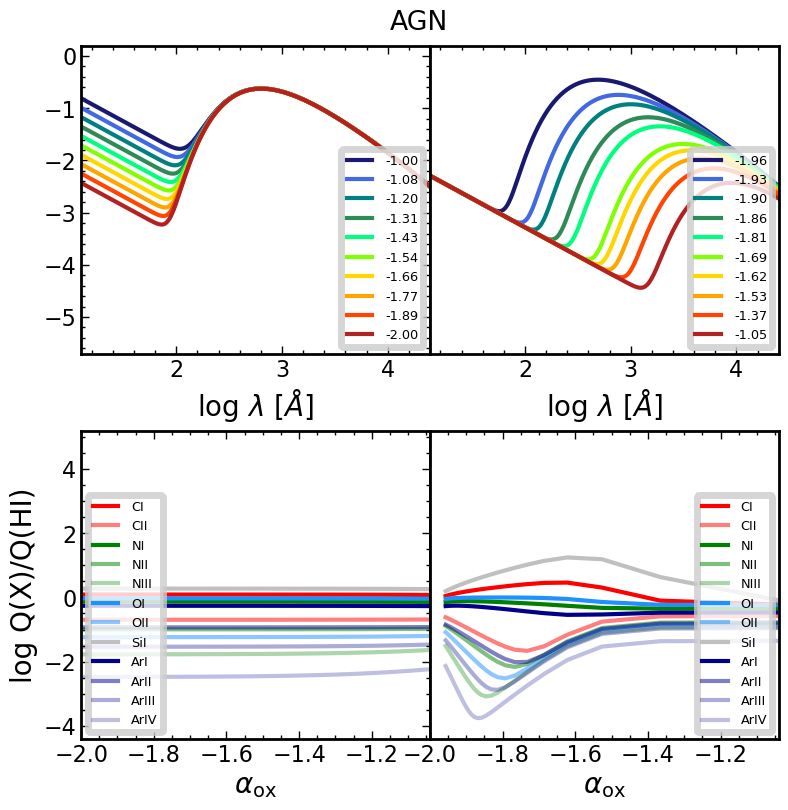

In [19]:
"""
Compute the budget of emitted ionizing photons for AGN templates of different shapes
"""

H_Eion =[0., 13.59844]
He_Eion=[0., 24.58738, 54.41776]
C_Eion =[0., 11.26030, 24.38332, 47.8878,  64.4939,  392.087,  489.99334]
N_Eion =[0., 14.53414, 29.6013,  47.44924, 77.4735,  97.8902,  552.0718, 667.046]
O_Eion =[0., 13.61806, 35.11730, 54.9355,  77.41353, 113.8990, 138.1197, 739.29  ,871.4101]
Ne_Eion=[0., 21.5646 , 40.96328, 63.45  ,  97.12   , 126.21  , 157.93  , 207.2759,239.0989, 1195.8286, 1362.1995]
Si_Eion=[0., 8.15169 , 16.34585, 33.49302, 45.14181, 166.767 , 205.27  , 246.5,   303.54  , 351.12   , 401.37   , 476.36, 523.42, 2437.63, 2673.182]
S_Eion =[0., 10.36001, 23.3379,  34.79  ,  47.222,   72.5945,  88.0530 , 280.948, 328.75  , 379.55   , 447.5    , 504.8 , 564.44, 652.2  , 707.01 , 3223.78, 3494.1892]
Ar_Eion=[0., 15.75962, 27.62967, 40.74  ,  59.81,    75.02,    91.009  , 124.323, 143.460 , 422.45   , 478.69   , 538.96, 618.26, 686.10 , 755.74 , 854.77 ,  918.03, 4120.8857, 4426.2296]

ionlbl=['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI','XVII','XVIII','XIX']


aox,AGN=load_AGN()
x_agn=AGN['l']
aox2,Tbbb,AGN2=load_AGN2()


# initialize Q for AGN:
lgQagnHi=np.zeros_like(aox)
lgQagnHei=np.zeros_like(aox)
lgQagnHeii=np.zeros_like(aox)
lgQagnCi=np.zeros_like(aox)
lgQagnCii=np.zeros_like(aox)
lgQagnCiii=np.zeros_like(aox)
lgQagnNi=np.zeros_like(aox)
lgQagnNii=np.zeros_like(aox)
lgQagnNiii=np.zeros_like(aox)
lgQagnNiv=np.zeros_like(aox)
lgQagnOi=np.zeros_like(aox)
lgQagnOii=np.zeros_like(aox)
lgQagnOiii=np.zeros_like(aox)
lgQagnOiv=np.zeros_like(aox)
lgQagnSii=np.zeros_like(aox)
lgQagnAri=np.zeros_like(aox)
lgQagnArii=np.zeros_like(aox)
lgQagnAriii=np.zeros_like(aox)
lgQagnAriv=np.zeros_like(aox)
lgQagnArv=np.zeros_like(aox)
lgQagnNeii=np.zeros_like(aox)
lgQagnNeiii=np.zeros_like(aox)
lgQagnNeiv=np.zeros_like(aox)
lgQagnNev=np.zeros_like(aox)

# initialize Q for AGN:
lgQagn2Hi=np.zeros_like(aox2)
lgQagn2Hei=np.zeros_like(aox2)
lgQagn2Heii=np.zeros_like(aox2)
lgQagn2Ci=np.zeros_like(aox2)
lgQagn2Cii=np.zeros_like(aox2)
lgQagn2Ciii=np.zeros_like(aox2)
lgQagn2Ni=np.zeros_like(aox2)
lgQagn2Nii=np.zeros_like(aox2)
lgQagn2Niii=np.zeros_like(aox2)
lgQagn2Niv=np.zeros_like(aox2)
lgQagn2Oi=np.zeros_like(aox2)
lgQagn2Oii=np.zeros_like(aox2)
lgQagn2Oiii=np.zeros_like(aox2)
lgQagn2Oiv=np.zeros_like(aox2)
lgQagn2Sii=np.zeros_like(aox2)
lgQagn2Ari=np.zeros_like(aox2)
lgQagn2Arii=np.zeros_like(aox2)
lgQagn2Ariii=np.zeros_like(aox2)
lgQagn2Ariv=np.zeros_like(aox2)
lgQagn2Arv=np.zeros_like(aox2)
lgQagn2Neii=np.zeros_like(aox2)
lgQagn2Neiii=np.zeros_like(aox2)
lgQagn2Neiv=np.zeros_like(aox2)
lgQagn2Nev=np.zeros_like(aox2)

for i in range(len(aox)):
    y=AGN['F'+str(i)]
    lgQagnHi[i]=np.log10(intQ(x_agn,y,H_Eion[1],np.inf))
    lgQagnHei[i]=np.log10(intQ(x_agn,y,He_Eion[1],He_Eion[2]))-lgQagnHi[i]
    lgQagnHeii[i]=np.log10(intQ(x_agn,y,He_Eion[2],np.inf))-lgQagnHi[i]
    lgQagnCi[i]=np.log10(intQ(x_agn,y,C_Eion[1],C_Eion[2]))-lgQagnHi[i]
    lgQagnCii[i]=np.log10(intQ(x_agn,y,C_Eion[2],C_Eion[3]))-lgQagnHi[i]
    lgQagnCiii[i]=np.log10(intQ(x_agn,y,C_Eion[3],C_Eion[4]))-lgQagnHi[i]
    lgQagnNi[i]=np.log10(intQ(x_agn,y,N_Eion[1],N_Eion[2]))-lgQagnHi[i]
    lgQagnNii[i]=np.log10(intQ(x_agn,y,N_Eion[2],N_Eion[3]))-lgQagnHi[i]
    lgQagnNiii[i]=np.log10(intQ(x_agn,y,N_Eion[3],N_Eion[4]))-lgQagnHi[i]
    lgQagnNiv[i]=np.log10(intQ(x_agn,y,N_Eion[4],N_Eion[5]))-lgQagnHi[i]
    lgQagnOi[i]=np.log10(intQ(x_agn,y,O_Eion[1],O_Eion[2]))-lgQagnHi[i]
    lgQagnOii[i]=np.log10(intQ(x_agn,y,O_Eion[2],O_Eion[3]))-lgQagnHi[i]
    lgQagnOiii[i]=np.log10(intQ(x_agn,y,O_Eion[3],O_Eion[4]))-lgQagnHi[i]
    lgQagnOiv[i]=np.log10(intQ(x_agn,y,O_Eion[4],O_Eion[5]))-lgQagnHi[i]
    lgQagnSii[i]=np.log10(intQ(x_agn,y,Si_Eion[1],Si_Eion[2]))-lgQagnHi[i]
    lgQagnAri[i]=np.log10(intQ(x_agn,y,Ar_Eion[1],Ar_Eion[2]))-lgQagnHi[i]
    lgQagnArii[i]=np.log10(intQ(x_agn,y,Ar_Eion[2],Ar_Eion[3]))-lgQagnHi[i]
    lgQagnAriii[i]=np.log10(intQ(x_agn,y,Ar_Eion[3],Ar_Eion[4]))-lgQagnHi[i]
    lgQagnAriv[i]=np.log10(intQ(x_agn,y,Ar_Eion[4],Ar_Eion[5]))-lgQagnHi[i]
    lgQagnArv[i]=np.log10(intQ(x_agn,y,Ar_Eion[5],Ar_Eion[6]))-lgQagnHi[i]
    lgQagnNeii[i]=np.log10(intQ(x_agn,y,Ne_Eion[2],Ne_Eion[3]))-lgQagnHi[i]
    lgQagnNeiii[i]=np.log10(intQ(x_agn,y,Ne_Eion[3],Ne_Eion[4]))-lgQagnHi[i]
    lgQagnNeiv[i]=np.log10(intQ(x_agn,y,Ne_Eion[4],Ne_Eion[5]))-lgQagnHi[i]
    lgQagnNev[i]=np.log10(intQ(x_agn,y,Ne_Eion[5],Ne_Eion[6]))-lgQagnHi[i]

for i in range(len(aox2)):
    y=AGN2['F'+str(i)]
    lgQagn2Hi[i]=np.log10(intQ(x_agn,y,H_Eion[1],np.inf))
    lgQagn2Hei[i]=np.log10(intQ(x_agn,y,He_Eion[1],He_Eion[2]))-lgQagn2Hi[i]
    lgQagn2Heii[i]=np.log10(intQ(x_agn,y,He_Eion[2],np.inf))-lgQagn2Hi[i]
    lgQagn2Ci[i]=np.log10(intQ(x_agn,y,C_Eion[1],C_Eion[2]))-lgQagn2Hi[i]
    lgQagn2Cii[i]=np.log10(intQ(x_agn,y,C_Eion[2],C_Eion[3]))-lgQagn2Hi[i]
    lgQagn2Ciii[i]=np.log10(intQ(x_agn,y,C_Eion[3],C_Eion[4]))-lgQagn2Hi[i]
    lgQagn2Ni[i]=np.log10(intQ(x_agn,y,N_Eion[1],N_Eion[2]))-lgQagn2Hi[i]
    lgQagn2Nii[i]=np.log10(intQ(x_agn,y,N_Eion[2],N_Eion[3]))-lgQagn2Hi[i]
    lgQagn2Niii[i]=np.log10(intQ(x_agn,y,N_Eion[3],N_Eion[4]))-lgQagn2Hi[i]
    lgQagn2Niv[i]=np.log10(intQ(x_agn,y,N_Eion[4],N_Eion[5]))-lgQagn2Hi[i]
    lgQagn2Oi[i]=np.log10(intQ(x_agn,y,O_Eion[1],O_Eion[2]))-lgQagn2Hi[i]
    lgQagn2Oii[i]=np.log10(intQ(x_agn,y,O_Eion[2],O_Eion[3]))-lgQagn2Hi[i]
    lgQagn2Oiii[i]=np.log10(intQ(x_agn,y,O_Eion[3],O_Eion[4]))-lgQagn2Hi[i]
    lgQagn2Oiv[i]=np.log10(intQ(x_agn,y,O_Eion[4],O_Eion[5]))-lgQagn2Hi[i]
    lgQagn2Sii[i]=np.log10(intQ(x_agn,y,Si_Eion[1],Si_Eion[2]))-lgQagn2Hi[i]
    lgQagn2Ari[i]=np.log10(intQ(x_agn,y,Ar_Eion[1],Ar_Eion[2]))-lgQagn2Hi[i]
    lgQagn2Arii[i]=np.log10(intQ(x_agn,y,Ar_Eion[2],Ar_Eion[3]))-lgQagn2Hi[i]
    lgQagn2Ariii[i]=np.log10(intQ(x_agn,y,Ar_Eion[3],Ar_Eion[4]))-lgQagn2Hi[i]
    lgQagn2Ariv[i]=np.log10(intQ(x_agn,y,Ar_Eion[4],Ar_Eion[5]))-lgQagn2Hi[i]
    lgQagn2Arv[i]=np.log10(intQ(x_agn,y,Ar_Eion[5],Ar_Eion[6]))-lgQagn2Hi[i]
    lgQagn2Neii[i]=np.log10(intQ(x_agn,y,Ne_Eion[2],Ne_Eion[3]))-lgQagn2Hi[i]
    lgQagn2Neiii[i]=np.log10(intQ(x_agn,y,Ne_Eion[3],Ne_Eion[4]))-lgQagn2Hi[i]
    lgQagn2Neiv[i]=np.log10(intQ(x_agn,y,Ne_Eion[4],Ne_Eion[5]))-lgQagn2Hi[i]
    lgQagn2Nev[i]=np.log10(intQ(x_agn,y,Ne_Eion[5],Ne_Eion[6]))-lgQagn2Hi[i]

    
nicePlot()

fig = plt.figure(figsize=(9,9))

gs = GridSpec(2, 2, figure=fig, wspace=0, hspace=0.25)

ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1],sharey=ax1)
ax2.get_yaxis().set_visible(False)
ax3 = fig.add_subplot(gs[0,0])
ax4 = fig.add_subplot(gs[0,1],sharey=ax3,sharex=ax3)
ax4.get_yaxis().set_visible(False)

xmin1=-2.  # Myr
xmax1=-1.04 # Myr
xmin2=-2.   # alphaOX
xmax2=-1.04   # alphaOX
xmin3=1.1  # log lambda [Ang]
xmax3=4.4  # log lambda [Ang]
ymin1=-4.4 # log Q(X)/Q(H)
ymax1=5.2   # log Q(X)/Q(H)
ymin3=-5.7  # log Fl 
ymax3=0.2   # log Fl

ax1.set_xlim(xmin1,xmax1)
ax2.set_xlim(xmin2,xmax2)
ax3.set_xlim(xmin3,xmax3)
ax1.set_ylim(ymin1,ymax1)
ax3.set_ylim(ymin3,ymax3)

ax1.plot(aox,lgQagnCi,color='red',alpha=1.0,label='CI')
ax1.plot(aox,lgQagnCii,color='red',alpha=0.5,label='CII')
ax1.plot(aox,lgQagnNi,color='green',alpha=1.0,label='NI')
ax1.plot(aox,lgQagnNii,color='green',alpha=0.5,label='NII')
ax1.plot(aox,lgQagnNiii,color='green',alpha=0.33,label='NIII')
ax1.plot(aox,lgQagnOi,color='dodgerblue',alpha=1.0,label='OI')
ax1.plot(aox,lgQagnOii,color='dodgerblue',alpha=0.5,label='OII')
ax1.plot(aox,lgQagnSii,color='silver',alpha=1.0,label='SiI')
ax1.plot(aox,lgQagnAri,color='darkblue',alpha=1.0,label='ArI')
ax1.plot(aox,lgQagnArii,color='darkblue',alpha=0.5,label='ArII')
ax1.plot(aox,lgQagnAriii,color='darkblue',alpha=0.33,label='ArIII')
ax1.plot(aox,lgQagnAriv,color='darkblue',alpha=0.25,label='ArIV')
ax1.legend(loc='lower left',fontsize='xx-small')
ax1.set_xlabel(r'$\alpha_{\rm ox}$')


ax1.set_ylabel('log Q(X)/Q(HI)')


ax2.plot(aox2,lgQagn2Ci,color='red',alpha=1.0,label='CI')
ax2.plot(aox2,lgQagn2Cii,color='red',alpha=0.5,label='CII')
ax2.plot(aox2,lgQagn2Ni,color='green',alpha=1.0,label='NI')
ax2.plot(aox2,lgQagn2Nii,color='green',alpha=0.5,label='NII')
ax2.plot(aox2,lgQagn2Niii,color='green',alpha=0.33,label='NIII')
ax2.plot(aox2,lgQagn2Oi,color='dodgerblue',alpha=1.0,label='OI')
ax2.plot(aox2,lgQagn2Oii,color='dodgerblue',alpha=0.5,label='OII')
ax2.plot(aox2,lgQagn2Sii,color='silver',alpha=1.0,label='SiI')
ax2.plot(aox2,lgQagn2Ari,color='darkblue',alpha=1.0,label='ArI')
ax2.plot(aox2,lgQagn2Arii,color='darkblue',alpha=0.5,label='ArII')
ax2.plot(aox2,lgQagn2Ariii,color='darkblue',alpha=0.33,label='ArIII')
ax2.plot(aox2,lgQagn2Ariv,color='darkblue',alpha=0.25,label='ArIV')
ax2.legend(loc='lower right',fontsize='xx-small')
ax2.set_xlabel(r'$\alpha_{\rm ox}$')


ax3.plot(np.log10(x_agn),np.log10(AGN['F18']),color='midnightblue',label='-1.00')
ax3.plot(np.log10(x_agn),np.log10(AGN['F16']),color='royalblue',label='-1.08')   
ax3.plot(np.log10(x_agn),np.log10(AGN['F14']),color='teal',label='-1.20')        
ax3.plot(np.log10(x_agn),np.log10(AGN['F12']),color='seagreen',label='-1.31')    
ax3.plot(np.log10(x_agn),np.log10(AGN['F10']),color='springgreen',label='-1.43')
ax3.plot(np.log10(x_agn),np.log10(AGN['F8']),color='chartreuse',label='-1.54') 
ax3.plot(np.log10(x_agn),np.log10(AGN['F6']),color='gold',label='-1.66')       
ax3.plot(np.log10(x_agn),np.log10(AGN['F4']),color='orange',label='-1.77')     
ax3.plot(np.log10(x_agn),np.log10(AGN['F2']),color='orangered',label='-1.89')  
ax3.plot(np.log10(x_agn),np.log10(AGN['F0']),color='firebrick',label='-2.00')
ax3.legend(loc='lower right',fontsize='xx-small')
ax3.set_xlabel(r'log $\lambda$ [$\AA$]')

ax4.plot(np.log10(x_agn),np.log10(AGN2['F37']),color='midnightblue',label='-1.96')
ax4.plot(np.log10(x_agn),np.log10(AGN2['F23']),color='royalblue',label='-1.93')   
ax4.plot(np.log10(x_agn),np.log10(AGN2['F17']),color='teal',label='-1.90')        
ax4.plot(np.log10(x_agn),np.log10(AGN2['F11']),color='seagreen',label='-1.86')    
ax4.plot(np.log10(x_agn),np.log10(AGN2['F8']),color='springgreen',label='-1.81')
ax4.plot(np.log10(x_agn),np.log10(AGN2['F4']),color='chartreuse',label='-1.69') 
ax4.plot(np.log10(x_agn),np.log10(AGN2['F3']),color='gold',label='-1.62')       
ax4.plot(np.log10(x_agn),np.log10(AGN2['F2']),color='orange',label='-1.53')     
ax4.plot(np.log10(x_agn),np.log10(AGN2['F1']),color='orangered',label='-1.37')  
ax4.plot(np.log10(x_agn),np.log10(AGN2['F0']),color='firebrick',label='-1.05')  
ax4.legend(loc='lower right',fontsize='xx-small')
ax4.set_xlabel(r'log $\lambda$ [$\AA$]')

fig.suptitle('AGN',y=0.92)

fig.show()
fig.savefig('figures/Qagn.png',dpi=400,format='png', bbox_inches='tight')



In [49]:
"""
Test metallicities and abundances
"""

def read_sdss():
    sdss_file='./galSpecLine-dr8.fits'

    hdul = fits.open(sdss_file)

    data = hdul[1].data # assuming the first extension is a table

    head = hdul[1].header
    
    #print(head)
    #cond_use_sdss=np.where(((data['OIII_4363_FLUX']>3.*data['OIII_4363_FLUX_ERR'])&(data['H_ALPHA_FLUX']>3.*data['H_ALPHA_FLUX_ERR'])),1,0)
    cond_flux=np.where(((data['OIII_5007_FLUX']>0.)
                       &(data['OIII_4959_FLUX']>0.)
                       &(data['OII_3729_FLUX']>0.)
                       &(data['OII_3726_FLUX']>0.)
                       &(data['NII_6584_FLUX']>0.)
                       &(data['NII_6548_FLUX']>0.)
                       &(data['H_ALPHA_FLUX']>0.)
                       &(data['H_BETA_FLUX']>0.)),1,0)
    cond_snr=np.where((data['OIII_5007_FLUX']>5.*data['OIII_5007_FLUX_ERR'])
                       &(data['OIII_4959_FLUX']>5.*data['OIII_4959_FLUX_ERR'])
                       &(data['OII_3726_FLUX']>5.*data['OII_3726_FLUX_ERR'])
                       &(data['OII_3729_FLUX']>5.*data['OII_3729_FLUX_ERR'])
                       &(data['NII_6548_FLUX']>5.*data['NII_6548_FLUX_ERR'])
                       &(data['NII_6584_FLUX']>5.*data['NII_6584_FLUX_ERR'])
                       &(data['H_ALPHA_FLUX']>5.*data['H_ALPHA_FLUX_ERR'])
                       &(data['H_BETA_FLUX']>5.*data['H_BETA_FLUX_ERR']),1,0)
    cond_use_sdss=cond_snr
    f_o2=data['OII_3726_FLUX']+data['OII_3729_FLUX']
    ef_o2=np.sqrt(np.power(data['OII_3726_FLUX_ERR'],2)+np.power(data['OII_3729_FLUX_ERR'],2))
    f_o3b=data['OIII_4959_FLUX']
    ef_o3b=data['OIII_4959_FLUX_ERR']
    f_o3a=data['OIII_5007_FLUX']
    ef_o3a=data['OIII_5007_FLUX_ERR']
    f_o3=data['OIII_4959_FLUX']+data['OIII_5007_FLUX']
    ef_o3=np.sqrt(np.power(data['OIII_5007_FLUX_ERR'],2)+np.power(data['OIII_4959_FLUX_ERR'],2))
    f_n2=data['NII_6584_FLUX']+data['NII_6548_FLUX']
    ef_n2=np.sqrt(np.power(data['NII_6584_FLUX_ERR'],2)+np.power(data['NII_6548_FLUX_ERR'],2))
    f_s2a=data['SII_6717_FLUX']
    ef_s2a=data['SII_6717_FLUX_ERR']
    f_s2b=data['SII_6731_FLUX']
    ef_s2b=data['SII_6731_FLUX_ERR']
    f_s2=data['SII_6717_FLUX']+data['SII_6731_FLUX']
    ef_s2=np.sqrt(np.power(data['SII_6717_FLUX_ERR'],2)+np.power(data['SII_6731_FLUX_ERR'],2))
    f_hb=data['H_BETA_FLUX']
    ef_hb=data['H_BETA_FLUX_ERR']
    f_ha=data['H_ALPHA_FLUX']
    ef_ha=data['H_ALPHA_FLUX_ERR']

    sdss_o3hb=np.log10(f_o3[(cond_use_sdss==1)]/f_hb[(cond_use_sdss==1)])
    sdss_n2ha=np.log10(f_n2[(cond_use_sdss==1)]/f_ha[(cond_use_sdss==1)])
    sdss_s2ha=np.log10(f_s2[(cond_use_sdss==1)]/f_ha[(cond_use_sdss==1)])
    sdss_n2hb=np.log10(f_n2[(cond_use_sdss==1)]/f_hb[(cond_use_sdss==1)])
    sdss_o2hb=np.log10(f_o2[(cond_use_sdss==1)]/f_hb[(cond_use_sdss==1)])
    sdss_hahb=np.log10(f_ha[(cond_use_sdss==1)]/f_hb[(cond_use_sdss==1)])

    tab=Table()
    
    tab['O3Hb']=sdss_o3hb
    tab['O2Hb']=sdss_o2hb
    tab['N2Hb']=sdss_n2hb
    tab['HaHb']=sdss_hahb
    tab['N2Ha']=sdss_n2ha
    tab['S2Ha']=sdss_s2ha
    
    return tab


def no_abundance(o2hb,n2hb):
    # from Pilyugin & Grebel 2016
    lgNO=-0.657-0.201*n2hb+(0.742-0.075*n2hb)*(n2hb-o2hb)
    return lgNO

def oh_abundance(o3hb,o2hb,n2hb):
    # one of the implementations in Pilyugin & Grebel 2016
    lgZ=7.939+0.135*(o3hb-o2hb)+1.217*n2hb+(-0.765*(o3hb-o2hb)+0.449*n2hb)*o2hb-8.76
    return lgZ

def oh_abundance_g23(o3hb,s2hb,n2hb):
    # from Greves+23, based on Pilyugin & Grebel 2016
    lgZ_g23=np.where((n2hb>-0.6),
                     8.424+0.030*(o3hb-s2hb)+0.751*n2hb+(-0.349+0.182*(o3hb-s2hb)+0.508*n2hb)*s2hb,
                     8.072+0.789*(o3hb-s2hb)+0.726*n2hb+( 1.069-0.170*(o3hb-s2hb)+0.022*n2hb)*s2hb)
    lgZ_g23=lgZ_g23-8.76
    return lgZ_g23


def read_chaos():
    chaos_file='./chaos_data.dat'
    
    
    chaos=ascii.read(chaos_file, format='basic', header_start=0, data_start=1)
    
    return chaos
    

/tmp/ipykernel_274659/332913607.py:44: RuntimeWarning: overflow encountered in power
  ef_s2=np.sqrt(np.power(data['SII_6717_FLUX_ERR'],2)+np.power(data['SII_6731_FLUX_ERR'],2))
/tmp/ipykernel_274659/332913607.py:50: RuntimeWarning: divide by zero encountered in true_divide
  sdss_o3hb=np.log10(f_o3[(cond_use_sdss==1)]/f_hb[(cond_use_sdss==1)])
/tmp/ipykernel_274659/332913607.py:50: RuntimeWarning: invalid value encountered in true_divide
  sdss_o3hb=np.log10(f_o3[(cond_use_sdss==1)]/f_hb[(cond_use_sdss==1)])
/tmp/ipykernel_274659/332913607.py:50: RuntimeWarning: divide by zero encountered in log10
  sdss_o3hb=np.log10(f_o3[(cond_use_sdss==1)]/f_hb[(cond_use_sdss==1)])
/tmp/ipykernel_274659/332913607.py:51: RuntimeWarning: divide by zero encountered in true_divide
  sdss_n2ha=np.log10(f_n2[(cond_use_sdss==1)]/f_ha[(cond_use_sdss==1)])
/tmp/ipykernel_274659/332913607.py:51: RuntimeWarning: invalid value encountered in true_divide
  sdss_n2ha=np.log10(f_n2[(cond_use_sdss==1)]/f_ha[(cond_

nicePlot: Setting rcParams


Text(0, 0.5, 'Relative abundance')

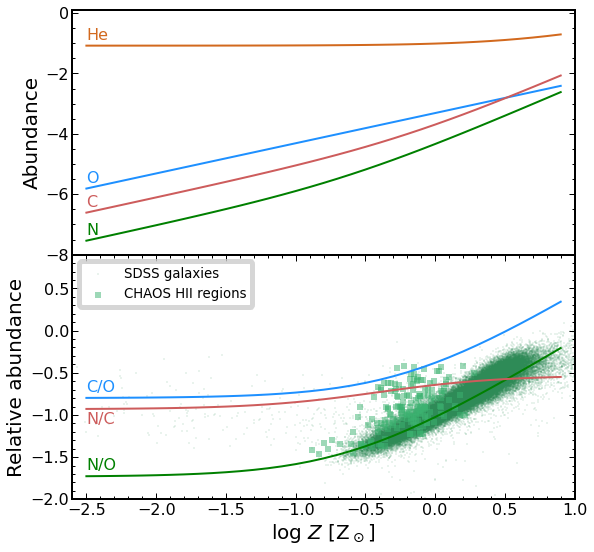

In [50]:
sdss=read_sdss()
sdss_o3hb=sdss['O3Hb']
sdss_o2hb=sdss['O2Hb']
sdss_n2hb=sdss['N2Hb']
sdss_s2ha=sdss['S2Ha']
sdss_hahb=sdss['HaHb']
sdss_s2hb=sdss_s2ha+sdss_hahb

sdss_lgNO=no_abundance(sdss_o2hb,sdss_n2hb)
sdss_lgZ1=charlot_longhetti(sdss_o3hb,sdss_o2hb,sdss_n2hb,sdss_s2hb)
sdss_lgZ2=oh_abundance(sdss_o3hb,sdss_o2hb,sdss_n2hb)
sdss_lgZ3=oh_abundance_g23(sdss_o3hb,sdss_s2hb,sdss_n2hb)

chaos=read_chaos()
chaos_Z=chaos['lgOH']-lgZsun
chaos_eZ=chaos['e_lgOH']
chaos_NO=chaos['lgNO']
chaos_eNO=chaos['e_lgNO']

lzz=np.arange(-2.5,1.0,0.1)
zz=np.power(10.,lzz)

lgOH,lgNH,lgCH,lgHeH=nicholls(zz)
lgNO=lgNH-lgOH
lgNC=lgNH-lgCH
lgCO=lgCH-lgOH

xmin=-2.6
xmax=1.
ymin=-8
ymax=0.1

nicePlot()

fig = plt.figure(figsize=(9,9))

gs = GridSpec(2, 1, figure=fig, wspace=0, hspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
ax1.get_xaxis().set_visible(False)

xmin=-2.6  
xmax= 1.0  
ymin1=-8.0 
ymax1= 0.1 
ymin3=-2.0 
ymax3= 0.9 

ax1.set_xlim(xmin,xmax)
ax2.set_xlim(xmin,xmax)
ax1.set_ylim(ymin1,ymax1)
ax2.set_ylim(ymin3,ymax3)

ax1.plot(lzz,lgOH,c='dodgerblue',linewidth=2)
ax1.plot(lzz,lgNH,c='green',linewidth=2)
ax1.plot(lzz,lgCH,c='indianred',linewidth=2)
ax1.plot(lzz,lgHeH,c='chocolate',linewidth=2)
ax1.text(lzz[0],lgOH[0]+0.2,s='O',c='dodgerblue')
ax1.text(lzz[0],lgNH[0]+0.2,s='N',c='green')
ax1.text(lzz[0],lgCH[0]+0.2,s='C',c='indianred')
ax1.text(lzz[0],lgHeH[0]+0.2,s='He',c='chocolate')

ax2.scatter(sdss_lgZ1, sdss_lgNO, c='seagreen', s=3, marker='s', alpha=0.1, linewidth=0, label='SDSS galaxies')
ax2.scatter(chaos_Z, chaos_NO, c='mediumseagreen', s=30, marker='s', alpha=0.5, linewidth=0, label='CHAOS HII regions')
ax2.plot(lzz,lgCO,c='dodgerblue',linewidth=2)
ax2.plot(lzz,lgNO,c='green',linewidth=2)
ax2.plot(lzz,lgNC,c='indianred',linewidth=2)
ax2.text(lzz[0],lgCO[0]+0.07,s='C/O',c='dodgerblue')
ax2.text(lzz[0],lgNO[0]+0.07,s='N/O',c='green')
ax2.text(lzz[0],lgNC[0]-0.18,s='N/C',c='indianred')
ax2.set_xlabel(r'log $Z$ [Z$_\odot$]')
ax2.legend(fontsize='small')
ax1.set_ylabel(r'Abundance')
ax2.set_ylabel(r'Relative abundance')


nicePlot: Setting rcParams


/tmp/ipykernel_58584/782143433.py:157: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[1]=((1.+n_gamma)*C2_A[1]+(1.+n_gamma)*C2_A[4])/(C2_q[1]+C2_q[4]+C2_qin[7]+C2_qin[8])
/tmp/ipykernel_58584/782143433.py:158: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[2]=((1.+n_gamma)*C2_A[2]+(1.+n_gamma)*C2_A[5]+(1.+n_gamma)*C2_A[7])/(C2_q[2]+C2_q[5]+C2_q[7]+C2_qin[9])
/tmp/ipykernel_58584/782143433.py:159: RuntimeWarning: divide by zero encountered in scalar divide
  C2_ncrit[3]=((1.+n_gamma)*C2_A[3]+(1.+n_gamma)*C2_A[6]+(1.+n_gamma)*C2_A[8]+(1.+n_gamma)*C2_A[9])/(C2_q[3]+C2_q[6]+C2_q[8]+C2_q[9])
/tmp/ipykernel_58584/782143433.py:272: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[1]=((1.+n_gamma)*N3_A[1]+(1.+n_gamma)*N3_A[4])/(N3_q[1]+N3_q[4]+N3_qin[7]+N3_qin[8])
/tmp/ipykernel_58584/782143433.py:273: RuntimeWarning: divide by zero encountered in scalar divide
  N3_ncrit[2]=((1.+n_gamma)*N3_A[2]+(1.+n_gamma)*N3_A[5]+(1.+n_g

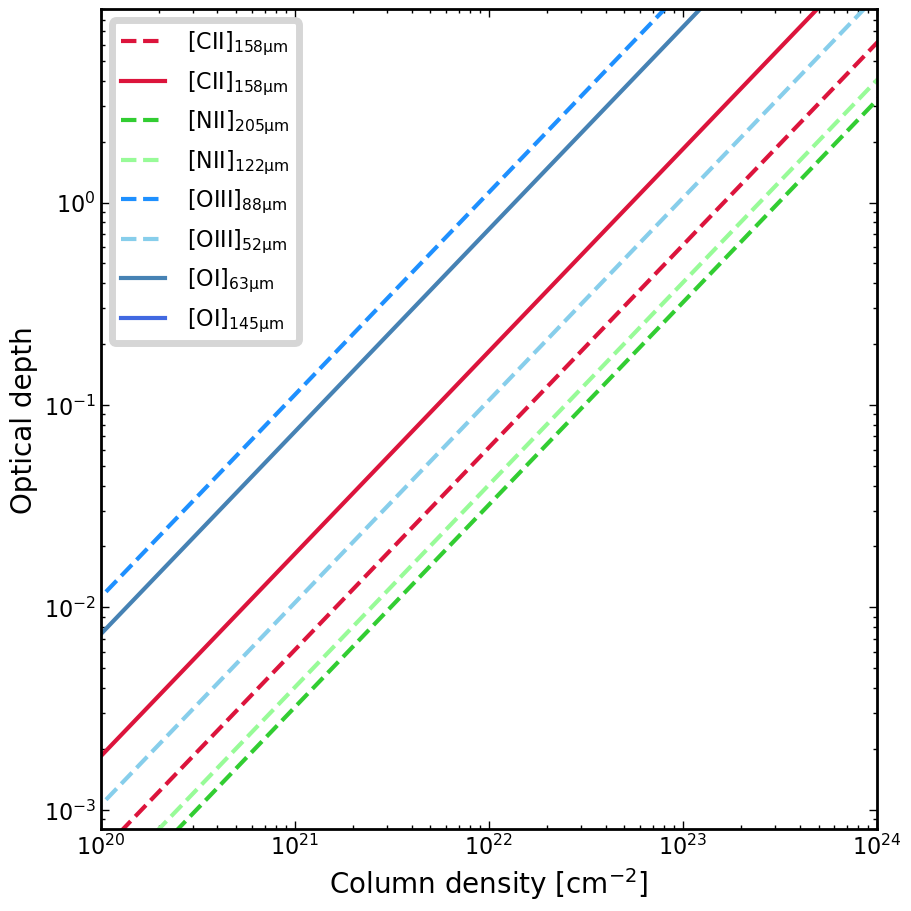

In [14]:
"""
Make a grid of Tgas and n, and solve the level population for 5-level atoms for
each element of the grid. Plot optical depth as a function of column depth.
"""

nicePlot()

# grid spacing
lT_ln_in=np.array([[4.,2.],[2.,4.]])
T_n_in=np.power(10.,lT_ln_in)

# the radiation field density is still to be done
n_gamma=0.  # cm-3

tab_A=Table()
tab_nu=Table()

for i in species:
    tab_A[i+'_A']=Column(np.empty([10,1]),dtype='float')
    tab_nu[i+'_nu']=Column(np.empty([10,1]),dtype='float')


# compute the level population throughout the grid
# ionized phase:
matC2E, nuC2E, AC2E, ncrit=init_C2(T_n_in[1][0],T_n_in[1][1],n_gamma,1.,0.)
matN3, nuN3, AN3, ncrit=init_N3(T_n_in[1][0],T_n_in[1][1],n_gamma)
matN2, nuN2, AN2, ncrit=init_N2(T_n_in[1][0],T_n_in[1][1],n_gamma)
matO3, nuO3, AO3, ncrit=init_O3(T_n_in[1][0],T_n_in[1][1],n_gamma)

# neutral phase:
matC1, nuC1, AC1, ncrit=init_C1(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
matC2N, nuC2N, AC2N, ncrit=init_C2(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)
matO1, nuO1, AO1, ncrit=init_O1(T_n_in[0][0],T_n_in[0][1],n_gamma,0.,0.5)

FC2E=solve_matrix(matC2E)
FN3 =solve_matrix(matN3)
FN2 =solve_matrix(matN2)
FO3 =solve_matrix(matO3)
FC1 =solve_matrix(matC1)
FC2N=solve_matrix(matC2N)
FO1 =solve_matrix(matO1)

lgN_H=np.arange(15.,26.,0.1)
lgOH,lgNH,lgCH,lgHeH=nicholls(1.)
N_H=np.power(10.,lgN_H)
NO=np.power(10.,lgN_H+lgOH)
NN=np.power(10.,lgN_H+lgNH)
NC=np.power(10.,lgN_H+lgCH)

NC1=NC*0.5
NC2=NC*0.5
NN2=NN*0.5
NO1=NO*0.5
NO3=NO*0.25

bvel=10. # km/s
tauC2E=AC2E[0]*NC2*FC2E[0]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuC2E[0],3)*4./2.*(1.-FC2E[1]/4./(FC2E[0]/2.))
tauC2N=AC2N[0]*NC2*FC2N[0]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuC2N[0],3)*4./2.*(1.-FC2N[1]/4./(FC2N[0]/2.))
tauC1a=AC1[0]*NC1*FC1[0]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuC1[0],3)*3./1.*(1.-FC1[1]/3./(FC1[0]/1.))
tauC1b=AC1[4]*NC1*FC1[1]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuC1[4],3)*5./3.*(1.-FC1[2]/5./(FC1[1]/3.))
tauN2a=AN2[0]*NN2*FN2[0]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuN2[0],3)*3./1.*(1.-FN2[1]/3./(FN2[0]/1.))
tauN2b=AN2[4]*NN2*FN2[1]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuN2[4],3)*5./3.*(1.-FN2[2]/5./(FN2[1]/3.))
tauO3a=AO3[0]*NO3*FO3[0]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuO3[0],3)*3./1.*(1.-FO3[1]/3./(FO3[0]/1.))
tauO3b=AO3[4]*NO3*FO3[1]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuO3[4],3)*5./3.*(1.-FO3[2]/5./(FO3[1]/3.))
tauO1a=AO1[0]*NO1*FO1[0]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuO1[0],3)*3./5.*(1.-FO1[1]/3./(FO1[0]/5.))
tauO1b=AO1[4]*NO1*FO1[1]*np.power(clight*1.e5,3)/8./np.power(np.pi,1.5)/(bvel*1e5)/np.power(nuO1[4],3)*1./3.*(1.-FO1[2]/1./(FO1[1]/3.))

fig,ax=plt.subplots(figsize=(9,9),layout='constrained')

xmin=np.power(10.,20)
xmax=np.power(10.,24)
ymin=0.0008
ymax=9
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_yscale('log')
ax.set_xscale('log')

ax.plot(N_H,tauC2E,color='crimson',linestyle='dashed',label=r'[CII]$_{\rm 158\mu m}$')
ax.plot(N_H,tauC2N,color='crimson',label=r'[CII]$_{\rm 158\mu m}$')
ax.plot(N_H,tauN2a,color='limegreen',linestyle='dashed',label=r'[NII]$_{\rm 205\mu m}$')
ax.plot(N_H,tauN2b,color='palegreen',linestyle='dashed',label=r'[NII]$_{\rm 122\mu m}$')
ax.plot(N_H,tauO3a,color='dodgerblue',linestyle='dashed',label=r'[OIII]$_{\rm 88\mu m}$')
ax.plot(N_H,tauO3b,color='skyblue',linestyle='dashed',label=r'[OIII]$_{\rm 52\mu m}$')
ax.plot(N_H,tauO1a,color='steelblue',label=r'[OI]$_{\rm 63\mu m}$')
ax.plot(N_H,tauO1b,color='royalblue',label=r'[OI]$_{\rm 145\mu m}$')

ax.set_xlabel(r'Column density [cm$^{-2}$]')
ax.set_ylabel(r'Optical depth')

ax.legend(loc='upper left')
plt.savefig('figures/opt_depth_NH.png',dpi=400,format='png', bbox_inches='tight')
plt.show()


